# Measuring all 5 protocols and 4 player sizes (720p+) (quality auto) on the test VM -- 2 videos

In [2]:
import pandas as pd
import sqlite3
import datetime
import numpy as np
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
import math
import Cdf
import Pmf
from urllib.parse import urlparse, parse_qs
mpl.rcParams['figure.dpi'] = 200
okabe_ito = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
sns.set_context('paper')
sns.set_palette(sns.color_palette(okabe_ito))
#https://stackoverflow.com/a/45846841
def human_format(num):
    num = float('{:.3g}'.format(num))
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    return '{}{}'.format('{:f}'.format(num).rstrip('0').rstrip('.'), ['', 'K', 'M', 'B', 'T'][magnitude])
def make_cdf(series):
    return series.value_counts(normalize=True).sort_index().cumsum()
def make_pdf(series):
    return series.value_counts(normalize=True).sort_index()

In [3]:
conn = sqlite3.connect('web-performance-youtube-two-videos.db')
measurements = pd.read_sql_query("SELECT * FROM measurements", conn)
measurements
#conn.close()

msm_id              py_time       js_time  \
0     315fc1b3-1c8b-1a99-619f-b6710c7ef174                   -1 -1.000000e+00   
1     77ca19fd-cf26-e754-72d5-ad927757591e  1646062671917013199  1.646063e+12   
2     86a4f8aa-3794-71ea-6511-502b73830cb9                   -1 -1.000000e+00   
3     74a14fc6-06f8-299e-e53c-7d8d985fd683  1646062710220279197  1.646063e+12   
4     bcc3f68f-9e68-ac7e-fddb-f7b70b2e5b31                   -1 -1.000000e+00   
...                                    ...                  ...           ...   
8235  c9b8ad1d-c1aa-00ef-057a-bb09f77822e9  1646249127179307743  1.646249e+12   
8236  4c6ef8fb-1e03-897b-008e-7785c7e67bbd                   -1 -1.000000e+00   
8237  336d57c7-c013-a0d3-7e02-0740b14e15c5  1646249169725214393  1.646249e+12   
8238  23eb8b40-1b80-8203-4589-ed2bb25ebe47                   -1 -1.000000e+00   
8239  5eb16215-0a0d-810e-665c-591afca56768  1646249208065433978  1.646249e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
0            -1.000000e+00      tls  94.140.14.140  aqz-KE-bpKQ                
1             1.646063e+12      tls  94.140.14.140  aqz-KE-bpKQ                
2            -1.000000e+00      tls  94.140.14.140  lqiN98z6Dak                
3             1.646063e+12      tls  94.140.14.140  lqiN98z6Dak                
4            -1.000000e+00      tls  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
8235          1.646249e+12      udp  94.140.14.140  lqiN98z6Dak                
8236         -1.000000e+00      udp  94.140.14.140  aqz-KE-bpKQ                
8237          1.646249e+12      udp  94.140.14.140  aqz-KE-bpKQ                
8238         -1.000000e+00      udp  94.140.14.140  lqiN98z6Dak                
8239          1.646249e+12      udp  94.140.14.140  lqiN98z6Dak                

                       timestamp suggested_quality  player_width  \
0     2022-02-28 15:37:15.423442              auto          1280   
1     2022-02-28 15:37:18.520742              auto          1280   
2     2022-02-28 15:37:53.686765              auto          1280   
3     2022-02-28 15:37:56.821131              auto          1280   
4     2022-02-28 15:38:35.186758              auto          1920   
...                          ...               ...           ...   
8235  2022-03-02 19:24:53.938901              auto          2560   
8236  2022-03-02 19:25:33.154053              auto          3840   
8237  2022-03-02 19:25:36.229625              auto          3840   
8238  2022-03-02 19:26:11.543464              auto          3840   
8239  2022-03-02 19:26:14.668247              auto          3840   

      player_height  start_time  play_time                 video_ids  \
0               720           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
1               720           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
2               720           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
3               720           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
4              1080           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
...             ...         ...        ...                       ...   
8235           1440           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
8236           2160           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
8237           2160           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
8238           2160           0         30  aqz-KE-bpKQ, lqiN98z6Dak   
8239           2160           0         30  aqz-KE-bpKQ, lqiN98z6Dak   

      cacheWarming error  
0                1        
1                0        
2                1        
3                0        
4                1        
...            ...   ...  
8235             0        
8236             1        
8237             0        
8238             1        
8239             0        

[8240 rows x 17 columns]

# data pre-processing

In [4]:
measurements.groupby(['cacheWarming', 'error']).agg({'msm_id':pd.Series.nunique})

msm_id
cacheWarming error        
0                     4120
1                     4120

In [5]:
measurements = measurements[measurements.error == '']

remove cache warming runs early to reduce processing later on

In [6]:
measurements = measurements[measurements.cacheWarming == 0]

In [7]:
measurements['player_width'] = measurements['player_width'].astype(str)
measurements['player_height'] = measurements['player_height'].astype(str)
measurements['player_dimensions'] = measurements['player_width']+"x"+measurements['player_height']

In [8]:
measurements['protocol'] = measurements['protocol'].str.upper()

In [9]:
dns_proto_mapping = {'QUIC':'DoQ', 'HTTPS':'DoH', 'TLS':'DoT', 'TCP':'DoTCP', 'UDP':'DoUDP'}
def map_proto_to_dns(x):
    return dns_proto_mapping[x]
measurements['protocol'] = measurements['protocol'].map(map_proto_to_dns)

In [10]:
measurements

msm_id              py_time       js_time  \
1     77ca19fd-cf26-e754-72d5-ad927757591e  1646062671917013199  1.646063e+12   
3     74a14fc6-06f8-299e-e53c-7d8d985fd683  1646062710220279197  1.646063e+12   
5     5548ccfe-2cca-6944-5905-4f397ff89101  1646062751771817120  1.646063e+12   
7     4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd  1646062790748462145  1.646063e+12   
9     90d50d9c-22e5-b3e6-4039-eb1c79d02fdb  1646062832373938256  1.646063e+12   
...                                    ...                  ...           ...   
8231  4417c7ef-0c11-6f14-d63a-e5fc4db19f11  1646249046761777330  1.646249e+12   
8233  fb5304ff-8aed-08cf-aec7-aa95b0a80a43  1646249088092237057  1.646249e+12   
8235  c9b8ad1d-c1aa-00ef-057a-bb09f77822e9  1646249127179307743  1.646249e+12   
8237  336d57c7-c013-a0d3-7e02-0740b14e15c5  1646249169725214393  1.646249e+12   
8239  5eb16215-0a0d-810e-665c-591afca56768  1646249208065433978  1.646249e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
1             1.646063e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
3             1.646063e+12      DoT  94.140.14.140  lqiN98z6Dak                
5             1.646063e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
7             1.646063e+12      DoT  94.140.14.140  lqiN98z6Dak                
9             1.646063e+12      DoT  94.140.14.140  aqz-KE-bpKQ                
...                    ...      ...            ...          ...          ...   
8231          1.646249e+12    DoUDP  94.140.14.140  lqiN98z6Dak                
8233          1.646249e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
8235          1.646249e+12    DoUDP  94.140.14.140  lqiN98z6Dak                
8237          1.646249e+12    DoUDP  94.140.14.140  aqz-KE-bpKQ                
8239          1.646249e+12    DoUDP  94.140.14.140  lqiN98z6Dak                

                       timestamp suggested_quality player_width player_height  \
1     2022-02-28 15:37:18.520742              auto         1280           720   
3     2022-02-28 15:37:56.821131              auto         1280           720   
5     2022-02-28 15:38:38.320198              auto         1920          1080   
7     2022-02-28 15:39:17.566936              auto         1920          1080   
9     2022-02-28 15:39:58.826239              auto         2560          1440   
...                          ...               ...          ...           ...   
8231  2022-03-02 19:23:33.613370              auto         1920          1080   
8233  2022-03-02 19:24:14.675346              auto         2560          1440   
8235  2022-03-02 19:24:53.938901              auto         2560          1440   
8237  2022-03-02 19:25:36.229625              auto         3840          2160   
8239  2022-03-02 19:26:14.668247              auto         3840          2160   

      start_time  play_time                 video_ids  cacheWarming error  \
1              0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
3              0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
5              0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
7              0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
9              0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
...          ...        ...                       ...           ...   ...   
8231           0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
8233           0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
8235           0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
8237           0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         
8239           0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         

     player_dimensions  
1             1280x720  
3             1280x720  
5            1920x1080  
7            1920x1080  
9            2560x1440  
...                ...  
8231         1920x1080  
8233

## find the optimal resolution as determined by the youtube player for each run

In [11]:
df_optimal_resolutions = pd.read_sql_query("""
SELECT msm_id, resolution, time FROM nerd_stats
""", conn)

In [12]:
df_optimal_resolutions['current_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[0]
df_optimal_resolutions['current_res'] = df_optimal_resolutions['current_res'].str.split('@').str[0]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['resolution'].str.split(' / ').str[1]
df_optimal_resolutions['optimal_res'] = df_optimal_resolutions['optimal_res'].str.split('@').str[0]
df_optimal_resolutions['time'] = pd.to_datetime(df_optimal_resolutions['time'], unit='ms', origin='unix')

In [13]:
df_optimal_resolutions = df_optimal_resolutions[['msm_id','optimal_res', 'time', 'current_res']]

In [14]:
df_optimal_resolutions.groupby('msm_id').optimal_res.nunique().sort_values()

msm_id
0003b249-791f-a8bd-95c8-3fd8f2fdacfa    1
a8d75a3c-346b-916b-929e-4f4b67e68b15    1
a8dbbb8e-bcfa-541e-99b7-84f2a909952e    1
a8e4d6c8-a249-4bd8-46fa-966a75ef3c07    1
a8f1a0fb-ee36-36f8-6c3c-570b48b1b5a7    1
                                       ..
5501866f-d996-bb1a-a6f1-7acda9c8f536    1
550a1d69-ab6d-266a-e11d-90edc2385f01    1
5475f5ab-07e9-bcca-d1e3-933c9b47b3e1    1
3b9df8f4-03cc-c148-cd2a-d356dcf27e43    2
096aeca4-3007-5237-8c51-826569ee912e    2
Name: optimal_res, Length: 4120, dtype: int64

### filter out measurements where the player changes the optimal resolution within the run (mostly from 4k to 1440p)

In [15]:
s_filter_msm = df_optimal_resolutions.groupby('msm_id').optimal_res.nunique()

In [16]:
s_filter_msm[s_filter_msm > 1].index.tolist()

['096aeca4-3007-5237-8c51-826569ee912e',
 '3b9df8f4-03cc-c148-cd2a-d356dcf27e43']

In [17]:
df_optimal_resolutions[df_optimal_resolutions.msm_id.isin(s_filter_msm[s_filter_msm > 1].index.tolist())].sort_values('time').groupby(['msm_id', 'optimal_res']).agg({'time':'min'}).sort_values('time')

time
msm_id                               optimal_res                              
096aeca4-3007-5237-8c51-826569ee912e 3840x2160   2022-03-01 19:04:12.232999936
                                     2560x1440   2022-03-01 19:04:42.320999936
3b9df8f4-03cc-c148-cd2a-d356dcf27e43 3840x2160   2022-03-02 06:50:16.976000000
                                     2560x1440   2022-03-02 06:50:36.678200064

first idea: we take the nerd stats optimal res at the end of playback (i.e. the furthest in terms of video playback) as the "true" optimal res  ------ probably dumb idea, see example above, for now just filter out the ones with multiple optimal resolutions?

In [18]:
#assert set(df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.value_counts().values) == {1}
#assert df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].msm_id.nunique() == measurements.msm_id.nunique()
#df_optimal_resolutions = df_optimal_resolutions.loc[df_optimal_resolutions.groupby('msm_id').time.idxmax()].reset_index(drop=True)


In [18]:
df_msms_with_multiple_opt_res = df_optimal_resolutions.groupby('msm_id', as_index=False).agg(opt_res_num=('optimal_res',pd.Series.nunique), opt_res_list=('optimal_res',pd.Series.unique)).sort_values('opt_res_num')

In [19]:
df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1]

msm_id  opt_res_num            opt_res_list
963  3b9df8f4-03cc-c148-cd2a-d356dcf27e43            2  [3840x2160, 2560x1440]
161  096aeca4-3007-5237-8c51-826569ee912e            2  [3840x2160, 2560x1440]

In [20]:
measurements_to_remove = df_msms_with_multiple_opt_res[df_msms_with_multiple_opt_res.opt_res_num > 1].msm_id.unique().tolist()

In [21]:
measurements_to_remove

['3b9df8f4-03cc-c148-cd2a-d356dcf27e43',
 '096aeca4-3007-5237-8c51-826569ee912e']

In [22]:
measurements[measurements.msm_id.isin(measurements_to_remove)].player_dimensions.value_counts()

3840x2160    2
Name: player_dimensions, dtype: int64

In [23]:
measurements[measurements.msm_id.isin(measurements_to_remove)].protocol.value_counts()

DoT      1
DoTCP    1
Name: protocol, dtype: int64

In [24]:
measurements[measurements.player_dimensions == "3840x2160"].protocol.value_counts()

DoT      206
DoH      206
DoQ      206
DoTCP    206
DoUDP    206
Name: protocol, dtype: int64

In [25]:
measurements = measurements[~measurements.msm_id.isin(measurements_to_remove)]

In [26]:
df_optimal_resolutions = df_optimal_resolutions[~df_optimal_resolutions.msm_id.isin(measurements_to_remove)][['msm_id', 'optimal_res']].drop_duplicates().reset_index().drop('index', axis=1)

In [27]:
df_optimal_resolutions

msm_id optimal_res
0     77ca19fd-cf26-e754-72d5-ad927757591e    1280x720
1     74a14fc6-06f8-299e-e53c-7d8d985fd683    1280x720
2     5548ccfe-2cca-6944-5905-4f397ff89101   1920x1080
3     4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd   1920x1080
4     90d50d9c-22e5-b3e6-4039-eb1c79d02fdb   2560x1440
...                                    ...         ...
4113  4417c7ef-0c11-6f14-d63a-e5fc4db19f11   1920x1080
4114  fb5304ff-8aed-08cf-aec7-aa95b0a80a43   2560x1440
4115  c9b8ad1d-c1aa-00ef-057a-bb09f77822e9   2560x1440
4116  336d57c7-c013-a0d3-7e02-0740b14e15c5   3840x2160
4117  5eb16215-0a0d-810e-665c-591afca56768   3840x2160

[4118 rows x 2 columns]

In [28]:
df_optimal_resolutions = pd.merge(df_optimal_resolutions, measurements[['msm_id', 'player_dimensions']], on='msm_id')
df_optimal_resolutions

msm_id optimal_res player_dimensions
0     77ca19fd-cf26-e754-72d5-ad927757591e    1280x720          1280x720
1     74a14fc6-06f8-299e-e53c-7d8d985fd683    1280x720          1280x720
2     5548ccfe-2cca-6944-5905-4f397ff89101   1920x1080         1920x1080
3     4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd   1920x1080         1920x1080
4     90d50d9c-22e5-b3e6-4039-eb1c79d02fdb   2560x1440         2560x1440
...                                    ...         ...               ...
4113  4417c7ef-0c11-6f14-d63a-e5fc4db19f11   1920x1080         1920x1080
4114  fb5304ff-8aed-08cf-aec7-aa95b0a80a43   2560x1440         2560x1440
4115  c9b8ad1d-c1aa-00ef-057a-bb09f77822e9   2560x1440         2560x1440
4116  336d57c7-c013-a0d3-7e02-0740b14e15c5   3840x2160         3840x2160
4117  5eb16215-0a0d-810e-665c-591afca56768   3840x2160         3840x2160

[4118 rows x 3 columns]

### make sure the optimal resolutions match what we set as the player size

In [29]:
df_optimal_resolutions[df_optimal_resolutions.optimal_res != df_optimal_resolutions.player_dimensions]

Empty DataFrame
Columns: [msm_id, optimal_res, player_dimensions]
Index: []

### make sure each run has a start playing event that fired before 1s of playtime passed (there seems to always be a little bit of playtime (i.e. the curr play time when the event fires is never zero) presumably due to the delay from javascript execution between getting the playback time within the callback)

In [30]:
df_player_state_playing = pd.read_sql_query("select time, msm_id, curr_play_time from iframe_api where event_type = 'PlayerStatePLAYING'", conn)

In [31]:
df_player_state_playing[df_player_state_playing.curr_play_time > 1].curr_play_time.describe()

count    1597.000000
mean       19.902360
std         2.190874
min         4.556201
25%        17.943333
50%        19.350333
75%        21.121000
max        28.257000
Name: curr_play_time, dtype: float64

In [32]:
df_player_state_playing[df_player_state_playing.curr_play_time < 1].curr_play_time.describe()

count    4120.000000
mean        0.022557
std         0.012159
min         0.003158
25%         0.017440
50%         0.020968
75%         0.023895
max         0.204029
Name: curr_play_time, dtype: float64

In [33]:
df_player_state_intial_playback = df_player_state_playing[(df_player_state_playing.curr_play_time < 1) & 
                                    (df_player_state_playing.msm_id.isin(measurements.msm_id.unique()))]

make sure each measurement only has one corresponding initial playing state event and that all measurements have such an event

In [34]:
assert set(df_player_state_intial_playback.msm_id.value_counts().values) == {1}
assert pd.Series.nunique(df_player_state_intial_playback.msm_id.value_counts().index) == \
pd.Series.nunique(measurements['msm_id'])

### if the 1s metric produced a unique start playing state event for each run, we can use it to calculate the startup delay between when we tell the player to start playing and when it actually plays

In [35]:
df_start_time = pd.read_sql_query("""
SELECT start_time, play_time, msm_id, current_quality AS initial_quality FROM
(SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction')
JOIN
(SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1)
USING (msm_id);
""", conn)
df_start_time = df_start_time[df_start_time.msm_id.isin(measurements.msm_id.unique())]

df_start_time['start_time'] = pd.to_datetime(df_start_time['start_time'], unit='ms', origin='unix')
df_start_time['play_time'] = pd.to_datetime(df_start_time['play_time'], unit='ms', origin='unix')

df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [36]:
df_start_time

start_time                     play_time  \
0    2022-02-28 15:37:20.970100224 2022-02-28 15:37:21.411300096   
1    2022-02-28 15:37:59.203100160 2022-02-28 15:37:59.610300160   
2    2022-02-28 15:38:40.754400000 2022-02-28 15:38:41.106200064   
3    2022-02-28 15:39:19.916600064 2022-02-28 15:39:20.310300160   
4    2022-02-28 15:40:01.187099904 2022-02-28 15:40:01.830899968   
...                            ...                           ...   
4115 2022-03-02 19:23:35.919600128 2022-03-02 19:23:36.279400192   
4116 2022-03-02 19:24:17.011000064 2022-03-02 19:24:17.404899840   
4117 2022-03-02 19:24:56.262400256 2022-03-02 19:24:56.640600064   
4118 2022-03-02 19:25:38.736200192 2022-03-02 19:25:39.143600128   
4119 2022-03-02 19:26:17.035000064 2022-03-02 19:26:17.485900032   

                                    msm_id initial_quality  startup_delay  
0     77ca19fd-cf26-e754-72d5-ad927757591e           hd720         0.4412  
1     74a14fc6-06f8-299e-e53c-7d8d985fd683           hd720         0.4072  
2     5548ccfe-2cca-6944-5905-4f397ff89101          hd1080         0.3518  
3     4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd          hd1080         0.3937  
4     90d50d9c-22e5-b3e6-4039-eb1c79d02fdb          hd1440         0.6438  
...                                    ...             ...            ...  
4115  4417c7ef-0c11-6f14-d63a-e5fc4db19f11          hd1080         0.3598  
4116  fb5304ff-8aed-08cf-aec7-aa95b0a80a43          hd1440         0.3939  
4117  c9b8ad1d-c1aa-00ef-057a-bb09f77822e9          hd1440         0.3782  
4118  336d57c7-c013-a0d3-7e02-0740b14e15c5          hd2160         0.4074  
4119  5eb16215-0a0d-810e-665c-591afca56768          hd2160         0.4509  

[4118 rows x 5 columns]

### for each measurement we call getQuality when the player fires the start playing callback, however this seems to again be susceptible to some delay, some measurements have quality change events for that resolution fire __after__ the recorded timestamp for the playing event ---> thus we figure out the quality change event that happened closest to the timestamp of the start playing event but still happened before it

In [37]:
df_player_quality_change_event = pd.read_sql_query("select msm_id, time, curr_play_time, current_quality from iframe_api where event_type LIKE 'QualityChange%'", conn)
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.msm_id.isin(measurements.msm_id.unique())]

In [38]:
df_player_quality_change_event['time'] = pd.to_datetime(df_player_quality_change_event['time'], unit='ms', origin='unix')

In [39]:
df_player_quality_change_event.curr_play_time.value_counts().sort_index()

0.000000     8093
0.007861        1
0.016166        1
0.016184        1
0.016828        1
             ... 
27.755920       1
27.791298       1
27.823754       1
27.854435       1
27.924962       1
Name: curr_play_time, Length: 443, dtype: int64

In [40]:
df_player_quality_change_event[df_player_quality_change_event.curr_play_time == 0].msm_id.value_counts()

e37a4c5f-daee-4fc3-41de-3a2787a97d81    3
103aa76f-3c04-e424-8a5f-9088a110ac8e    3
55424416-cd4d-ceb5-fff4-6368a05b3f4b    3
43906fa9-0e28-d254-e132-32155148c6bb    3
42fa2dcb-e034-2233-bee1-4a7abc71fe77    2
                                       ..
17ef7c6f-3741-7838-b0c6-d0ff8385b195    1
f3e7eebe-935c-1a1f-e6bd-4bf118df7db2    1
2a66cd42-0d64-d1f9-16aa-0936706eaa6d    1
b31f89a3-1478-b55c-789b-b248c20df06b    1
fffe7391-cbea-d6b1-4839-92a364345217    1
Name: msm_id, Length: 4118, dtype: int64

In [41]:
df_player_quality_change_event[df_player_quality_change_event.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

msm_id                          time  \
5670  e37a4c5f-daee-4fc3-41de-3a2787a97d81 2022-03-02 02:12:49.285099776   
5671  e37a4c5f-daee-4fc3-41de-3a2787a97d81 2022-03-02 02:13:03.694500096   
5672  e37a4c5f-daee-4fc3-41de-3a2787a97d81 2022-03-02 02:13:03.747699968   

      curr_play_time current_quality  
5670             0.0           large  
5671             0.0           hd720  
5672             0.0          hd1080

In [42]:
measurements[measurements.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

msm_id              py_time       js_time  \
5479  e37a4c5f-daee-4fc3-41de-3a2787a97d81  1646187200221406423  1.646187e+12   

      resource_time_origin protocol         server       domain vantagePoint  \
5479          1.646187e+12      DoQ  94.140.14.140  lqiN98z6Dak                

                       timestamp suggested_quality player_width player_height  \
5479  2022-03-02 02:12:46.670774              auto         1920          1080   

      start_time  play_time                 video_ids  cacheWarming error  \
5479           0         30  aqz-KE-bpKQ, lqiN98z6Dak             0         

     player_dimensions  
5479         1920x1080

In [43]:
df_start_time[df_start_time.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

start_time                     play_time  \
2739 2022-03-02 02:12:49.105399808 2022-03-02 02:13:03.855099904   

                                    msm_id initial_quality  startup_delay  
2739  e37a4c5f-daee-4fc3-41de-3a2787a97d81          hd1080        14.7497

In [44]:
df_true_initial_quality = pd.merge(df_start_time[['msm_id', 'play_time', 'initial_quality']], df_player_quality_change_event[df_player_quality_change_event.curr_play_time < 1][['time', 'current_quality', 'msm_id']], on='msm_id')


In [45]:
df_true_initial_quality['delay_to_play_time'] = (df_true_initial_quality['play_time'] - df_true_initial_quality['time']).dt.total_seconds()

In [47]:
df_true_initial_quality[df_true_initial_quality.msm_id == "e37a4c5f-daee-4fc3-41de-3a2787a97d81"]

msm_id                     play_time  \
5507  e37a4c5f-daee-4fc3-41de-3a2787a97d81 2022-03-02 02:13:03.855099904   
5508  e37a4c5f-daee-4fc3-41de-3a2787a97d81 2022-03-02 02:13:03.855099904   
5509  e37a4c5f-daee-4fc3-41de-3a2787a97d81 2022-03-02 02:13:03.855099904   

     initial_quality                          time current_quality  \
5507          hd1080 2022-03-02 02:12:49.285099776           large   
5508          hd1080 2022-03-02 02:13:03.694500096           hd720   
5509          hd1080 2022-03-02 02:13:03.747699968          hd1080   

      delay_to_play_time  
5507             14.5700  
5508              0.1606  
5509              0.1074

In [48]:
df_true_initial_quality = df_true_initial_quality[df_true_initial_quality.delay_to_play_time > 0]

In [49]:
df_true_initial_quality = df_true_initial_quality.loc[df_true_initial_quality.groupby('msm_id').delay_to_play_time.idxmin()].reset_index(drop=True)

In [50]:
df_true_initial_quality[df_true_initial_quality.initial_quality != df_true_initial_quality.current_quality]

msm_id                     play_time  \
126   077f98aa-1e79-ebd0-d384-275f9dd75478 2022-03-01 05:42:58.664499968   
164   0981396c-5783-3547-affb-9ab982a2c34a 2022-03-01 09:37:31.944499968   
192   0b1b92de-d383-766c-5822-68d1d4846699 2022-02-28 19:36:08.260699904   
253   0f4b8013-eb38-821c-495f-8810b7e5c72c 2022-03-02 13:02:10.230599936   
328   13743d06-a510-ff0e-0de4-203ee4793f8c 2022-03-02 14:54:57.325099776   
...                                    ...                           ...   
4003  f7cfcca1-5380-54ea-4e88-da9f0d6c0a4c 2022-02-28 17:20:15.313499904   
4012  f83a277b-f64f-77de-7f45-20b0a93384df 2022-03-01 18:25:37.148199936   
4075  fc66269a-7d8e-a392-afe7-b96749d96735 2022-03-01 18:55:34.689099776   
4082  fd363867-3b57-38b6-9da1-744bf897b221 2022-03-02 03:18:13.220399872   
4117  fffe7391-cbea-d6b1-4839-92a364345217 2022-02-28 22:24:53.563900160   

     initial_quality                          time current_quality  \
126           hd1080 2022-03-01 05:42:58.571599872           large   
164           hd1080 2022-03-01 09:37:31.829699840           large   
192            hd720 2022-02-28 19:36:07.912499968           large   
253           hd1080 2022-03-02 13:02:10.126099968           large   
328           hd1440 2022-03-02 14:54:57.222799872           large   
...              ...                           ...             ...   
4003          hd2160 2022-02-28 17:20:15.219899904          medium   
4012          hd1440 2022-03-01 18:25:37.041899776          medium   
4075          hd2160 2022-03-01 18:55:34.561399808          medium   
4082          hd1080 2022-03-02 03:18:13.050400000           large   
4117          hd1440 2022-02-28 22:24:53.461100032           large   

      delay_to_play_time  
126               0.0929  
164               0.1148  
192               0.3482  
253               0.1045  
328               0.1023  
...                  ...  
4003              0.0936  
4012              0.1063  
4075              0.1277  
4082              0.1700  
4117              0.1028  

[80 rows x 6 columns]

In [51]:
df_true_initial_quality.rename(columns=lambda x: x.replace('current_quality', 'true_initial_quality'), inplace=True)

In [52]:
df_true_initial_quality

msm_id                     play_time  \
0     0003b249-791f-a8bd-95c8-3fd8f2fdacfa 2022-03-01 08:21:37.558500096   
1     0004eaf6-6cdc-9977-b364-0736e522c9bb 2022-03-01 13:42:54.756000000   
2     002af7dd-128f-1f64-dd00-2eec5f7da387 2022-02-28 23:42:11.358400000   
3     002c7bc6-fe3e-ae13-cffe-4bf54efb6ae7 2022-03-01 16:09:33.398600192   
4     0049cd10-efca-0acd-0807-ee5e6630abe4 2022-03-01 14:23:00.172000000   
...                                    ...                           ...   
4113  ffa30917-6342-dfca-2d00-5027f254d307 2022-03-01 02:44:53.764600064   
4114  ffe8977b-2a9d-c929-b186-301f31ceb3a1 2022-03-02 18:00:50.819000064   
4115  ffefeeaa-abd0-57b6-3719-6c689999dce1 2022-03-01 05:20:13.980900096   
4116  fff0047b-515d-34bf-35d3-763998591c8d 2022-03-02 01:50:15.264600064   
4117  fffe7391-cbea-d6b1-4839-92a364345217 2022-02-28 22:24:53.563900160   

     initial_quality                          time true_initial_quality  \
0              hd720 2022-03-01 08:21:37.407200000                hd720   
1             hd1080 2022-03-01 13:42:54.662500096               hd1080   
2             hd1080 2022-02-28 23:42:11.268100096               hd1080   
3             hd1440 2022-03-01 16:09:33.283000064               hd1440   
4             hd1080 2022-03-01 14:23:00.083600128               hd1080   
...              ...                           ...                  ...   
4113          hd2160 2022-03-01 02:44:53.656400128               hd2160   
4114           hd720 2022-03-02 18:00:50.802400000                hd720   
4115          hd2160 2022-03-01 05:20:13.864800000               hd2160   
4116          hd2160 2022-03-02 01:50:15.250200320               hd2160   
4117          hd1440 2022-02-28 22:24:53.461100032                large   

      delay_to_play_time  
0                 0.1513  
1                 0.0935  
2                 0.0903  
3                 0.1156  
4                 0.0884  
...                  ...  
4113              0.1082  
4114              0.0166  
4115              0.1161  
4116              0.0144  
4117              0.1028  

[4118 rows x 6 columns]

### helper functions

In [53]:
res_to_quality = {
    "256x144":"tiny", "426x240": "small", "640x360": "medium", "854x480": "large",
    "1280x720": "hd720", "1920x1080": "hd1080", "2560x1440": "hd1440", "3840x2160": "hd2160"
}

quality_to_res = {v: k for k, v in res_to_quality.items()}

def map_quality_to_res(quality):
    return quality_to_res[quality]
def map_res_to_quality(resolution):
    return res_to_quality[resolution]

def make_quality_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['auto', 'tiny', 'small', 'medium', 'large', 'hd720', 'hd1080', 'highres', 'hd1440', 'hd2160'])

def make_res_column_sortable(df_, col_name_):
    df_[col_name_] = pd.Categorical(df_[col_name_], ['256x144', '426x240', '640x360', '854x480', '1280x720', '1920x1080', '2560x1440', '3840x2160'])

In [54]:
df_resource_timing = pd.read_sql_query("SELECT msm_id, name, nextHopProtocol FROM page_resources", conn)
#df_resource_timing = df_resource_timing[df_resource_timing.msm_id.isin(measurements.msm_id.unique())]

In [55]:
df_resource_timing['googlevideo'] = df_resource_timing.name.str.split('/').str[2]

In [56]:
df_resource_timing.googlevideo.unique()

array(['rr2---sn-4g5lzner.googlevideo.com',
       'rr4---sn-4g5e6nsr.googlevideo.com',
       'rr4---sn-4g5ednde.googlevideo.com',
       'rr2---sn-4g5ednly.googlevideo.com',
       'r4---sn-4g5e6nsr.googlevideo.com',
       'r2---sn-4g5ednly.googlevideo.com',
       'r2---sn-4g5lzner.googlevideo.com',
       'rr4---sn-5hnekn7k.googlevideo.com',
       'rr4---sn-5hne6nz6.googlevideo.com',
       'rr2---sn-5hne6nsr.googlevideo.com'], dtype=object)

In [57]:
def find_initial_requests(url_):
    parse_res = urlparse(url_)
    opts = parse_qs(parse_res.query)
    if opts['range'][0][0] == '0':
        return True
    return False
df_resource_timing['first_request'] = df_resource_timing['name'].map(find_initial_requests)

In [58]:
df_resource_timing['h1_first_request'] = False
df_resource_timing['h1_first_request'] = np.where((df_resource_timing.nextHopProtocol == 'http/1.1') & (df_resource_timing.first_request == True), True, df_resource_timing['h1_first_request'])

In [59]:
df_resource_timing = pd.merge(df_resource_timing, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [60]:
df_resource_timing[df_resource_timing.cacheWarming == 0].groupby('msm_id', as_index=False).agg({'googlevideo':pd.Series.nunique}).sort_values('googlevideo')

msm_id  googlevideo
0     0003b249-791f-a8bd-95c8-3fd8f2fdacfa            1
2737  a8d5793e-30a9-391e-6e90-cbfb389b7782            1
2738  a8d75a3c-346b-916b-929e-4f4b67e68b15            1
2739  a8dbbb8e-bcfa-541e-99b7-84f2a909952e            1
2740  a8e4d6c8-a249-4bd8-46fa-966a75ef3c07            1
...                                    ...          ...
3785  ea13ebfc-be02-99e3-a7de-f9178c41b3a4            2
2188  8754d4fd-153c-1e8a-c19b-c6090c1c1283            2
2040  7e226777-5baf-08ea-90d0-c997c91f91c2            2
3678  e37a4c5f-daee-4fc3-41de-3a2787a97d81            2
1105  43906fa9-0e28-d254-e132-32155148c6bb            3

[4120 rows x 2 columns]

In [61]:
df_caught_first_request = df_resource_timing.groupby('msm_id', as_index=False).agg({'first_request': lambda x: sum(x) > 0, 'h1_first_request': lambda x: sum(x) > 0})

In [62]:
print(df_caught_first_request[df_caught_first_request.first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == True].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.h1_first_request == False].msm_id.nunique())
print(df_caught_first_request.msm_id.nunique())

417
3703
4120
164
3956
4120


In [63]:
df_caught_first_request = pd.merge(df_caught_first_request, pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn))

In [64]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 0)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 0].msm_id.nunique())

417
3703
4120
164
3956
4120


In [65]:
print(df_caught_first_request[(df_caught_first_request.first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == True) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[(df_caught_first_request.h1_first_request == False) & (df_caught_first_request.cacheWarming == 1)].msm_id.nunique())
print(df_caught_first_request[df_caught_first_request.cacheWarming == 1].msm_id.nunique())

0
0
0
0
0
0


In [66]:
df_resource_timing.msm_id.nunique()

4120

In [70]:
all_measurements = pd.read_sql_query("SELECT msm_id, cacheWarming, (player_width || 'x' || player_height) as player_dimensions, timestamp FROM measurements", conn)

In [71]:
df_start_time = pd.merge(df_start_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']])

In [76]:
#df_start_time = df_start_time[df_start_time.cacheWarming == 0]

In [72]:
df_start_time.protocol.value_counts()

DoH      824
DoQ      824
DoUDP    824
DoT      823
DoTCP    823
Name: protocol, dtype: int64

In [73]:
df_start_time.columns

Index(['start_time', 'play_time', 'msm_id', 'initial_quality', 'startup_delay',
       'player_dimensions', 'protocol', 'vantagePoint', 'domain'],
      dtype='object')

In [74]:
df_start_time = pd.merge(df_start_time, df_true_initial_quality[['msm_id', 'true_initial_quality']], on='msm_id')

In [75]:
df_start_time[df_start_time.initial_quality != df_start_time.true_initial_quality]

start_time                     play_time  \
46   2022-02-28 16:34:11.724600064 2022-02-28 16:34:12.065799936   
63   2022-02-28 16:45:33.319400192 2022-02-28 16:45:33.721900032   
67   2022-02-28 16:48:12.422400000 2022-02-28 16:48:12.793699840   
98   2022-02-28 17:12:12.702700032 2022-02-28 17:12:13.032599808   
110  2022-02-28 17:20:15.022899968 2022-02-28 17:20:15.313499904   
...                            ...                           ...   
3813 2022-03-02 15:40:09.772499968 2022-03-02 15:40:10.117799936   
3887 2022-03-02 16:36:12.940899840 2022-03-02 16:36:13.290400000   
3963 2022-03-02 17:33:30.147399936 2022-03-02 17:33:30.496000000   
4009 2022-03-02 18:07:33.235400192 2022-03-02 18:07:33.727000064   
4065 2022-03-02 18:48:14.868599808 2022-03-02 18:48:15.193499904   

                                    msm_id initial_quality  startup_delay  \
46    cb8b6393-6a7d-4cc2-bfbb-2bcc2922e581          hd2160         0.3412   
63    37fc0aaf-09d2-494d-55b3-186427f93d8e          hd2160         0.4025   
67    5b560f80-4ea7-7f3b-eaff-43be87005da8          hd1080         0.3713   
98    2c105915-b536-3cfc-adb7-1551d95ec6e9          hd1080         0.3299   
110   f7cfcca1-5380-54ea-4e88-da9f0d6c0a4c          hd2160         0.2906   
...                                    ...             ...            ...   
3813  37df9609-3caa-c6ee-c3fa-f77f98c6319a          hd2160         0.3453   
3887  a8602467-4e7a-728e-2c8b-1d8f2d251fb8           hd720         0.3495   
3963  1ba3e46e-0fe8-42d0-e5ed-9e9d2f738278          hd1440         0.3486   
4009  e227ecf5-8583-1116-f4fa-396d346623c4          hd1080         0.4916   
4065  640e042d-0006-9ee6-8eea-f7145574ea72          hd1080         0.3249   

     player_dimensions protocol vantagePoint       domain true_initial_quality  
46           3840x2160      DoT               aqz-KE-bpKQ               medium  
63           3840x2160      DoQ               lqiN98z6Dak                large  
67           1920x1080    DoTCP               lqiN98z6Dak                large  
98           1920x1080      DoQ               aqz-KE-bpKQ               medium  
110          3840x2160    DoTCP               aqz-KE-bpKQ               medium  
...                ...      ...          ...          ...                  ...  
3813         3840x2160      DoH               lqiN98z6Dak                large  
3887          1280x720      DoH               lqiN98z6Dak                large  
3963         2560x1440      DoT               lqiN98z6Dak                large  
4009         1920x1080      DoH               lqiN98z6Dak                large  
4065         1920x1080    DoTCP               lqiN98z6Dak                large  

[80 rows x 10 columns]

In [76]:
make_quality_column_sortable(df_start_time, 'true_initial_quality')
make_quality_column_sortable(df_start_time, 'initial_quality')
make_res_column_sortable(df_start_time, 'player_dimensions')

In [136]:
df_start_time['player_dimensions_as_quality'] = df_start_time['player_dimensions'].map(map_res_to_quality)

In [152]:
pd.set_option('display.max_rows', 100)

In [148]:
df_start_time['suggested_with_initial_quality'] = df_start_time['player_dimensions_as_quality'].astype(str) +'<-'+ df_start_time['true_initial_quality'].astype(str)

In [155]:
df_start_time[df_start_time.domain == 'aqz-KE-bpKQ'].groupby(['suggested_with_initial_quality', 'protocol']).agg({'msm_id':pd.Series.nunique}).dropna()

msm_id
suggested_with_initial_quality protocol        
hd1080<-hd1080                 DoH          102
                               DoQ           99
                               DoT           97
                               DoTCP        102
                               DoUDP        101
hd1080<-hd720                  DoH            1
                               DoQ            2
                               DoT            3
                               DoUDP          1
hd1080<-medium                 DoQ            2
                               DoT            3
                               DoTCP          1
                               DoUDP          1
hd1440<-hd1080                 DoH            5
                               DoQ            2
                               DoT            2
                               DoTCP          3
hd1440<-hd1440                 DoH           95
                               DoQ           98
                               DoT           96
                               DoTCP         96
                               DoUDP        100
hd1440<-hd720                  DoH            1
                               DoQ            1
                               DoT            1
                               DoTCP          2
hd1440<-large                  DoH            1
                               DoQ            1
                               DoT            1
hd1440<-medium                 DoH            1
                               DoQ            1
                               DoT            3
                               DoTCP          2
                               DoUDP          3
hd2160<-hd1080                 DoH            2
                               DoQ            1
                               DoTCP          3
                               DoUDP          3
hd2160<-hd1440                 DoH           16
                               DoQ           12
                               DoT           16
                               DoTCP         18
                               DoUDP         13
hd2160<-hd2160                 DoH           85
                               DoQ           87
                               DoT           84
                               DoTCP         80
                               DoUDP         83
hd2160<-hd720                  DoQ            1
                               DoT            1
hd2160<-large                  DoUDP          1
hd2160<-medium                 DoQ            2
                               DoT            1
                               DoTCP          1
                               DoUDP          3
hd720<-hd720                   DoH          103
                               DoQ          102
                               DoT          102
                               DoTCP        101
                               DoUDP        101
hd720<-medium                  DoQ            1
                               DoT            1
                               DoTCP          2
                               DoUDP          2

In [157]:
df_start_time[df_start_time.domain == 'lqiN98z6Dak'].groupby(['suggested_with_initial_quality', 'protocol']).agg({'msm_id':pd.Series.nunique}).dropna()

msm_id
suggested_with_initial_quality protocol        
hd1080<-hd1080                 DoH           98
                               DoQ           97
                               DoT           97
                               DoTCP         94
                               DoUDP         99
hd1080<-large                  DoH            5
                               DoQ            6
                               DoT            6
                               DoTCP          9
                               DoUDP          4
hd1440<-hd1080                 DoT            2
hd1440<-hd1440                 DoH          100
                               DoQ          101
                               DoT           96
                               DoTCP         99
                               DoUDP        100
hd1440<-large                  DoH            3
                               DoQ            2
                               DoT            5
                               DoTCP          4
                               DoUDP          3
hd2160<-hd1080                 DoH            1
hd2160<-hd1440                 DoH            4
                               DoQ            4
                               DoTCP          3
                               DoUDP          5
hd2160<-hd2160                 DoH           93
                               DoQ           95
                               DoT           94
                               DoTCP         89
                               DoUDP         92
hd2160<-large                  DoH            5
                               DoQ            4
                               DoT            9
                               DoTCP         11
                               DoUDP          6
hd720<-hd720                   DoH          101
                               DoQ          101
                               DoT          102
                               DoTCP        102
                               DoUDP        100
hd720<-large                   DoH            2
                               DoQ            2
                               DoT            1
                               DoTCP          1
                               DoUDP          3

In [77]:
df_player_quality_change_event['curr_qual_as_res'] = df_player_quality_change_event['current_quality'].map(map_quality_to_res)

In [78]:
df_player_started = pd.read_sql_query("""
SELECT time AS start_time, msm_id FROM iframe_api WHERE event_type = 'PlayStartedFromFunction'
""", conn)
df_player_started = df_player_started[df_player_started.msm_id.isin(measurements.msm_id.unique())]

df_player_started['start_time'] = pd.to_datetime(df_player_started['start_time'], unit='ms', origin='unix')


#df_start_time['startup_delay'] = (df_start_time['play_time'] - df_start_time['start_time']).dt.total_seconds()

In [80]:
df_player_quality_change_event = pd.merge(df_player_quality_change_event, df_optimal_resolutions[['msm_id', 'optimal_res']], on='msm_id')
df_player_quality_change_event

msm_id                          time  \
0     77ca19fd-cf26-e754-72d5-ad927757591e 2022-02-28 15:37:21.209900032   
1     77ca19fd-cf26-e754-72d5-ad927757591e 2022-02-28 15:37:21.283000064   
2     74a14fc6-06f8-299e-e53c-7d8d985fd683 2022-02-28 15:37:59.406700032   
3     74a14fc6-06f8-299e-e53c-7d8d985fd683 2022-02-28 15:37:59.593799936   
4     5548ccfe-2cca-6944-5905-4f397ff89101 2022-02-28 15:38:40.967299840   
...                                    ...                           ...   
8530  c9b8ad1d-c1aa-00ef-057a-bb09f77822e9 2022-03-02 19:24:56.548600064   
8531  336d57c7-c013-a0d3-7e02-0740b14e15c5 2022-03-02 19:25:38.961600000   
8532  336d57c7-c013-a0d3-7e02-0740b14e15c5 2022-03-02 19:25:39.032200192   
8533  5eb16215-0a0d-810e-665c-591afca56768 2022-03-02 19:26:17.276000000   
8534  5eb16215-0a0d-810e-665c-591afca56768 2022-03-02 19:26:17.363700224   

      curr_play_time current_quality curr_qual_as_res optimal_res  
0                0.0          medium          640x360    1280x720  
1                0.0           hd720         1280x720    1280x720  
2                0.0           large          854x480    1280x720  
3                0.0           hd720         1280x720    1280x720  
4                0.0          medium          640x360   1920x1080  
...              ...             ...              ...         ...  
8530             0.0          hd1440        2560x1440   2560x1440  
8531             0.0          medium          640x360   3840x2160  
8532             0.0          hd2160        3840x2160   3840x2160  
8533             0.0           large          854x480   3840x2160  
8534             0.0          hd2160        3840x2160   3840x2160  

[8535 rows x 6 columns]

In [81]:
df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res].msm_id.nunique()

4118

In [82]:
df_player_quality_change_event = df_player_quality_change_event[df_player_quality_change_event.curr_qual_as_res == df_player_quality_change_event.optimal_res]

In [83]:
df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].curr_play_time.value_counts()

0.000000    3869
4.509499       1
0.022668       1
1.531576       1
0.907448       1
            ... 
0.030729       1
0.045688       1
0.057513       1
0.033718       1
0.027027       1
Name: curr_play_time, Length: 250, dtype: int64

In [84]:
assert set(df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.value_counts().values) == {1}
assert df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].msm_id.nunique() == measurements.msm_id.nunique()
df_player_quality_change_event_to_opt = df_player_quality_change_event.loc[df_player_quality_change_event.groupby('msm_id').time.idxmin()].reset_index(drop=True)


In [85]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt[['msm_id', 'time', 'optimal_res']], df_player_started,on='msm_id')

In [86]:

df_player_quality_change_event_to_opt['optimal_quality_delay'] = (df_player_quality_change_event_to_opt['time'] - df_player_quality_change_event_to_opt['start_time']).dt.total_seconds()
df_player_quality_change_event_to_opt

msm_id                          time  \
0     0003b249-791f-a8bd-95c8-3fd8f2fdacfa 2022-03-01 08:21:37.407200000   
1     0004eaf6-6cdc-9977-b364-0736e522c9bb 2022-03-01 13:42:54.662500096   
2     002af7dd-128f-1f64-dd00-2eec5f7da387 2022-02-28 23:42:11.268100096   
3     002c7bc6-fe3e-ae13-cffe-4bf54efb6ae7 2022-03-01 16:09:38.000800000   
4     0049cd10-efca-0acd-0807-ee5e6630abe4 2022-03-01 14:23:00.083600128   
...                                    ...                           ...   
4113  ffa30917-6342-dfca-2d00-5027f254d307 2022-03-01 02:44:53.656400128   
4114  ffe8977b-2a9d-c929-b186-301f31ceb3a1 2022-03-02 18:00:50.802400000   
4115  ffefeeaa-abd0-57b6-3719-6c689999dce1 2022-03-01 05:20:13.864800000   
4116  fff0047b-515d-34bf-35d3-763998591c8d 2022-03-02 01:50:15.250200320   
4117  fffe7391-cbea-d6b1-4839-92a364345217 2022-02-28 22:24:53.565699840   

     optimal_res                    start_time  optimal_quality_delay  
0       1280x720 2022-03-01 08:21:37.196199936                 0.2110  
1      1920x1080 2022-03-01 13:42:54.376900096                 0.2856  
2      1920x1080 2022-02-28 23:42:11.001100032                 0.2670  
3      3840x2160 2022-03-01 16:09:32.970500096                 5.0303  
4      1920x1080 2022-03-01 14:22:59.788100096                 0.2955  
...          ...                           ...                    ...  
4113   3840x2160 2022-03-01 02:44:53.373799936                 0.2826  
4114    1280x720 2022-03-02 18:00:50.486600192                 0.3158  
4115   3840x2160 2022-03-01 05:20:13.584400128                 0.2804  
4116   3840x2160 2022-03-02 01:50:14.941799936                 0.3084  
4117   2560x1440 2022-02-28 22:24:53.245900032                 0.3198  

[4118 rows x 5 columns]

In [87]:
df_player_quality_change_event_to_opt = pd.merge(df_player_quality_change_event_to_opt, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')

In [88]:
df_buffering_events = pd.read_sql_query("""
SELECT time, curr_play_time, current_quality, msm_id FROM iframe_api WHERE event_type = 'PlayerStateBUFFERING'
""", conn)

df_buffering_events = df_buffering_events[df_buffering_events.msm_id.isin(measurements.msm_id.unique())]

#df_buffering_events_time = pd.merge(df_buffering_events, measurements[measurements.cacheWarming == 0][['msm_id', 'player_dimensions', 'domain']], on='msm_id')

In [89]:
df_buffering_events['time'] = pd.to_datetime(df_buffering_events['time'], unit='ms', origin='unix')

In [90]:
#df_buffering_events_time['time'] = pd.to_datetime(df_buffering_events_time['time'], unit='ms', origin='unix')

In [91]:
#df_buffering_events_time = df_buffering_events_time[~df_buffering_events_time.msm_id.isin(measurements_to_remove)]

In [92]:
df_buffering_events[df_buffering_events.curr_play_time > 1].current_quality.unique()

array(['hd1440', 'hd2160', 'hd1080'], dtype=object)

filter out buffering events that happened before the player started playing

In [93]:
df_playback_started = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time < 1
""", conn)
df_playback_started = df_playback_started[df_playback_started.msm_id.isin(measurements.msm_id.unique())]

df_playback_started['play_time'] = pd.to_datetime(df_playback_started['play_time'], unit='ms', origin='unix')

In [94]:
#df_playback_started = df_playback_started[~df_playback_started.msm_id.isin(measurements_to_remove)]

In [95]:
df_playback_started

play_time                                msm_id  \
0    2022-02-28 15:37:21.411300096  77ca19fd-cf26-e754-72d5-ad927757591e   
1    2022-02-28 15:37:59.610300160  74a14fc6-06f8-299e-e53c-7d8d985fd683   
2    2022-02-28 15:38:41.106200064  5548ccfe-2cca-6944-5905-4f397ff89101   
3    2022-02-28 15:39:20.310300160  4e618f7c-9fcc-b3d2-ef15-ee8aff76c4cd   
4    2022-02-28 15:40:01.830899968  90d50d9c-22e5-b3e6-4039-eb1c79d02fdb   
...                            ...                                   ...   
4115 2022-03-02 19:23:36.279400192  4417c7ef-0c11-6f14-d63a-e5fc4db19f11   
4116 2022-03-02 19:24:17.404899840  fb5304ff-8aed-08cf-aec7-aa95b0a80a43   
4117 2022-03-02 19:24:56.640600064  c9b8ad1d-c1aa-00ef-057a-bb09f77822e9   
4118 2022-03-02 19:25:39.143600128  336d57c7-c013-a0d3-7e02-0740b14e15c5   
4119 2022-03-02 19:26:17.485900032  5eb16215-0a0d-810e-665c-591afca56768   

     current_quality  
0              hd720  
1              hd720  
2             hd1080  
3             hd1080  
4             hd1440  
...              ...  
4115          hd1080  
4116          hd1440  
4117          hd1440  
4118          hd2160  
4119          hd2160  

[4118 rows x 3 columns]

In [96]:
df_buffering_events_time = pd.merge(df_buffering_events, df_playback_started[['msm_id', 'play_time']], on='msm_id')

In [97]:
df_buffering_events_time = df_buffering_events_time[df_buffering_events_time.time > df_buffering_events_time.play_time]

In [98]:
df_buffering_events_time = pd.merge(df_buffering_events_time, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_buffering_events_time


time  curr_play_time current_quality  \
0    2022-02-28 15:40:21.116800000       19.255192          hd1440   
1    2022-02-28 15:41:39.418300160       17.848390          hd2160   
2    2022-02-28 15:41:46.969600000       21.048364          hd2160   
3    2022-02-28 15:41:52.279300096       23.279193          hd2160   
4    2022-02-28 15:45:42.452299776       19.245566          hd1440   
...                            ...             ...             ...   
1785 2022-03-02 19:20:33.837499904       17.870838          hd2160   
1786 2022-03-02 19:20:41.378099968       21.061958          hd2160   
1787 2022-03-02 19:24:36.691200000       19.276619          hd1440   
1788 2022-03-02 19:25:57.001799936       17.830145          hd2160   
1789 2022-03-02 19:26:04.510200320       21.000595          hd2160   

                                    msm_id                     play_time  \
0     90d50d9c-22e5-b3e6-4039-eb1c79d02fdb 2022-02-28 15:40:01.830899968   
1     7c8ac90a-0fa7-2339-2a2a-28751d799180 2022-02-28 15:41:21.458100224   
2     7c8ac90a-0fa7-2339-2a2a-28751d799180 2022-02-28 15:41:21.458100224   
3     7c8ac90a-0fa7-2339-2a2a-28751d799180 2022-02-28 15:41:21.458100224   
4     3509b5bf-4717-5421-57d2-f674c195edeb 2022-02-28 15:45:23.173199872   
...                                    ...                           ...   
1785  d8e212eb-7a1c-14d4-a06a-74a70c40ab1c 2022-03-02 19:20:15.877499904   
1786  d8e212eb-7a1c-14d4-a06a-74a70c40ab1c 2022-03-02 19:20:15.877499904   
1787  fb5304ff-8aed-08cf-aec7-aa95b0a80a43 2022-03-02 19:24:17.404899840   
1788  336d57c7-c013-a0d3-7e02-0740b14e15c5 2022-03-02 19:25:39.143600128   
1789  336d57c7-c013-a0d3-7e02-0740b14e15c5 2022-03-02 19:25:39.143600128   

     player_dimensions protocol vantagePoint       domain  
0            2560x1440      DoT               aqz-KE-bpKQ  
1            3840x2160      DoT               aqz-KE-bpKQ  
2            3840x2160      DoT               aqz-KE-bpKQ  
3            3840x2160      DoT               aqz-KE-bpKQ  
4            2560x1440      DoH               aqz-KE-bpKQ  
...                ...      ...          ...          ...  
1785         3840x2160    DoTCP               aqz-KE-bpKQ  
1786         3840x2160    DoTCP               aqz-KE-bpKQ  
1787         2560x1440    DoUDP               aqz-KE-bpKQ  
1788         3840x2160    DoUDP               aqz-KE-bpKQ  
1789         3840x2160    DoUDP               aqz-KE-bpKQ  

[1790 rows x 9 columns]

In [99]:
#df_buffering_events_time.rename(columns=lambda x: x.replace('domain_x', 'domain'), inplace=True)
#df_buffering_events_time.rename(columns=lambda x: x.replace('player_dimensions_x', 'player_dimensions'), inplace=True)

In [100]:
df_playback_restarted = pd.read_sql_query("""
SELECT time AS play_time, msm_id, current_quality FROM iframe_api WHERE event_type = 'PlayerStatePLAYING' AND curr_play_time >= 1
""", conn)
df_playback_restarted = df_playback_restarted[df_playback_restarted.msm_id.isin(measurements.msm_id.unique())]

df_playback_restarted['play_time'] = pd.to_datetime(df_playback_restarted['play_time'], unit='ms', origin='unix')
#df_playback_restarted = df_playback_restarted[~df_playback_restarted.msm_id.isin(measurements_to_remove)]

In [101]:
df_buffering_events.dtypes


time               datetime64[ns]
curr_play_time            float64
current_quality            object
msm_id                     object
dtype: object

In [102]:
df_stall_times = pd.merge_asof(df_playback_restarted, df_buffering_events, by='msm_id', left_on='play_time', right_on='time', direction='backward')

In [103]:
df_stall_times = pd.merge(df_stall_times, measurements[['msm_id', 'player_dimensions', 'protocol', 'vantagePoint', 'domain']], on='msm_id')
df_stall_times

play_time                                msm_id  \
0    2022-02-28 15:40:21.557199872  90d50d9c-22e5-b3e6-4039-eb1c79d02fdb   
1    2022-02-28 15:41:43.766400000  7c8ac90a-0fa7-2339-2a2a-28751d799180   
2    2022-02-28 15:41:49.994100224  7c8ac90a-0fa7-2339-2a2a-28751d799180   
3    2022-02-28 15:45:42.867500032  3509b5bf-4717-5421-57d2-f674c195edeb   
4    2022-02-28 15:47:06.150800128  f556d20f-d6b1-a6be-d6f7-877c5708eaa3   
...                            ...                                   ...   
1585 2022-03-02 19:20:38.177999872  d8e212eb-7a1c-14d4-a06a-74a70c40ab1c   
1586 2022-03-02 19:20:44.393799680  d8e212eb-7a1c-14d4-a06a-74a70c40ab1c   
1587 2022-03-02 19:24:37.163399936  fb5304ff-8aed-08cf-aec7-aa95b0a80a43   
1588 2022-03-02 19:26:01.329100032  336d57c7-c013-a0d3-7e02-0740b14e15c5   
1589 2022-03-02 19:26:07.529100032  336d57c7-c013-a0d3-7e02-0740b14e15c5   

     current_quality_x                          time  curr_play_time  \
0               hd1440 2022-02-28 15:40:21.116800000       19.255192   
1               hd2160 2022-02-28 15:41:39.418300160       17.848390   
2               hd2160 2022-02-28 15:41:46.969600000       21.048364   
3               hd1440 2022-02-28 15:45:42.452299776       19.245566   
4               hd2160 2022-02-28 15:47:01.783000064       17.835481   
...                ...                           ...             ...   
1585            hd2160 2022-03-02 19:20:33.837499904       17.870838   
1586            hd2160 2022-03-02 19:20:41.378099968       21.061958   
1587            hd1440 2022-03-02 19:24:36.691200000       19.276619   
1588            hd2160 2022-03-02 19:25:57.001799936       17.830145   
1589            hd2160 2022-03-02 19:26:04.510200320       21.000595   

     current_quality_y player_dimensions protocol vantagePoint       domain  
0               hd1440         2560x1440      DoT               aqz-KE-bpKQ  
1               hd2160         3840x2160      DoT               aqz-KE-bpKQ  
2               hd2160         3840x2160      DoT               aqz-KE-bpKQ  
3               hd1440         2560x1440      DoH               aqz-KE-bpKQ  
4               hd2160         3840x2160      DoH               aqz-KE-bpKQ  
...                ...               ...      ...          ...          ...  
1585            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
1586            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ  
1587            hd1440         2560x1440    DoUDP               aqz-KE-bpKQ  
1588            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ  
1589            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ  

[1590 rows x 10 columns]

In [104]:

df_stall_times['stall_time'] = (df_stall_times['play_time'] - df_stall_times['time']).dt.total_seconds()

In [105]:
df_stall_times

play_time                                msm_id  \
0    2022-02-28 15:40:21.557199872  90d50d9c-22e5-b3e6-4039-eb1c79d02fdb   
1    2022-02-28 15:41:43.766400000  7c8ac90a-0fa7-2339-2a2a-28751d799180   
2    2022-02-28 15:41:49.994100224  7c8ac90a-0fa7-2339-2a2a-28751d799180   
3    2022-02-28 15:45:42.867500032  3509b5bf-4717-5421-57d2-f674c195edeb   
4    2022-02-28 15:47:06.150800128  f556d20f-d6b1-a6be-d6f7-877c5708eaa3   
...                            ...                                   ...   
1585 2022-03-02 19:20:38.177999872  d8e212eb-7a1c-14d4-a06a-74a70c40ab1c   
1586 2022-03-02 19:20:44.393799680  d8e212eb-7a1c-14d4-a06a-74a70c40ab1c   
1587 2022-03-02 19:24:37.163399936  fb5304ff-8aed-08cf-aec7-aa95b0a80a43   
1588 2022-03-02 19:26:01.329100032  336d57c7-c013-a0d3-7e02-0740b14e15c5   
1589 2022-03-02 19:26:07.529100032  336d57c7-c013-a0d3-7e02-0740b14e15c5   

     current_quality_x                          time  curr_play_time  \
0               hd1440 2022-02-28 15:40:21.116800000       19.255192   
1               hd2160 2022-02-28 15:41:39.418300160       17.848390   
2               hd2160 2022-02-28 15:41:46.969600000       21.048364   
3               hd1440 2022-02-28 15:45:42.452299776       19.245566   
4               hd2160 2022-02-28 15:47:01.783000064       17.835481   
...                ...                           ...             ...   
1585            hd2160 2022-03-02 19:20:33.837499904       17.870838   
1586            hd2160 2022-03-02 19:20:41.378099968       21.061958   
1587            hd1440 2022-03-02 19:24:36.691200000       19.276619   
1588            hd2160 2022-03-02 19:25:57.001799936       17.830145   
1589            hd2160 2022-03-02 19:26:04.510200320       21.000595   

     current_quality_y player_dimensions protocol vantagePoint       domain  \
0               hd1440         2560x1440      DoT               aqz-KE-bpKQ   
1               hd2160         3840x2160      DoT               aqz-KE-bpKQ   
2               hd2160         3840x2160      DoT               aqz-KE-bpKQ   
3               hd1440         2560x1440      DoH               aqz-KE-bpKQ   
4               hd2160         3840x2160      DoH               aqz-KE-bpKQ   
...                ...               ...      ...          ...          ...   
1585            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
1586            hd2160         3840x2160    DoTCP               aqz-KE-bpKQ   
1587            hd1440         2560x1440    DoUDP               aqz-KE-bpKQ   
1588            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ   
1589            hd2160         3840x2160    DoUDP               aqz-KE-bpKQ   

      stall_time  
0         0.4404  
1         4.3481  
2         3.0245  
3         0.4152  
4         4.3678  
...          ...  
1585      4.3405  
1586      3.0157  
1587      0.4722  
1588      4.3273  
1589      3.0189  

[1590 rows x 11 columns]

In [111]:
def draw_cdf(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    if col_name_ == 'protocol':
        line_order =['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                    lnwidth = .5
                    mrksize = 3
                    df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                    fig, ax = plt.subplots(figsize=(5,2))
                    for col_val_ in df_tmp[col_name_].sort_values().unique():
                        cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                    linestyle='-', linewidth=lnwidth, 
                                    markersize=mrksize, fillstyle='none', 
                                    markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                    color=colors[col_val_], marker=markers[col_val_]
                                )
                        #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                        #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                    ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                    ax.spines['right'].set_color('none')
                    ax.spines['top'].set_color('none')
                    ax.yaxis.set_ticks_position('left')
                    ax.xaxis.set_ticks_position('bottom')
                    ax.spines['bottom'].set_position(('axes', -0.0))
                    ax.spines['left'].set_position(('axes', -0.0))

                    if not log:
                        #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                        ax.legend(loc='best', ncol=2, markerscale=2)
                    else:
                        ax.set_xscale('log')
                        #ax.set_xscale('symlog')
                        ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.5))

                    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                    ax.tick_params(axis='x', which='minor', labelsize=6)


                    ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                    ax.set_xlabel(xlabel)

                    ax.set_ylabel("CDF")
                    ax.set_ylim(-0.1,1.1)
                    if xlim != [0,0]:
                        ax.set_xlim(xlim)
                        
                    for line in ax.get_legend().get_lines():
                        line.set_linewidth(2.0)

                    if log:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    else:
                        fig.savefig('figures/cdf-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    #plt.show()

In [112]:
def draw_cdf_grid(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim):
    if col_name_ == 'protocol':
        line_order = ['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    else:
        line_order = sorted(df_[col_name_].unique().tolist())
    colors = dict(zip(line_order, ['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']))
    markers = dict(zip(line_order, ['o','v','^','>','s','p','h','d','<','.']))
    for vp in df_['vantagePoint'].unique():
        print(vp)
        for video in df_['domain'].unique():
            for log in log_list:
                num_rows = math.ceil(df_[col_outer_groupby_].nunique()/2)
                if df_[col_outer_groupby_].nunique() > 1:
                    fig, axs = plt.subplots(num_rows, 2, sharex='all', sharey='all', figsize=(12,3*num_rows))
                    fig.subplots_adjust(hspace=.5)
                    for col_grp_, ax in zip(df_[col_outer_groupby_].sort_values().unique(), axs.flat):
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        for col_val_ in df_tmp[col_name_].sort_values().unique():
                            cdf = Cdf.MakeCdfFromList(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            ax.plot(cdf.xs, cdf.ps, label=col_val_,
                                        linestyle='-', linewidth=lnwidth, 
                                        markersize=mrksize, fillstyle='none', 
                                        markevery=max(1, int(len(cdf.xs)/10)), drawstyle="default",
                                        color=colors[col_val_], marker=markers[col_val_]
                                    )
                            #dfplt = make_cdf(df_tmp[df_tmp[col_name_] == col_val_][col_metric_])
                            #dfplt.plot(ax=ax, label=col_val_, marker=markers[col_val_], markersize=mrksize, drawstyle="default", color=colors[col_val_], lw=lnwidth, logx=log)

                            ax.yaxis.set_major_formatter(PercentFormatter(xmax = 1.0))

                            ax.spines['right'].set_color('none')
                            ax.spines['top'].set_color('none')
                            ax.yaxis.set_ticks_position('left')
                            ax.xaxis.set_ticks_position('bottom')
                            ax.spines['bottom'].set_position(('axes', -0.0))
                            ax.spines['left'].set_position(('axes', -0.0))
                            if log:
                                ax.set_xscale('log')
                            #if not log:
                            #    #ax.legend(loc='center', ncol=1, markerscale=10, bbox_to_anchor=(0.5, -.6))
                            #    ax.legend(loc='best', ncol=2, markerscale=2)
                            #else:
                            #    ax.set_xscale('log')
                            #    #ax.set_xscale('symlog')
                            #    ax.legend(loc='center', ncol=2, markerscale=2, bbox_to_anchor=(.5, -.4))
                            #if i == df_[col_outer_groupby_].nunique()-1:
                            #    handles, labels = ax.get_legend_handles_labels()
                            #    fig.legend(handles, labels, loc='upper center')

                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel("CDF")
                            ax.set_ylim(-0.1,1.1)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)
                                
                        #for line in ax.get_legend().get_lines():
                            #    line.set_linewidth(2.0)
                    legend_elements = [mpl.lines.Line2D([0], [0], color=colors[legend_item], lw=2, label=legend_item, marker=markers[legend_item]) for legend_item in df_tmp[col_name_].unique()]
                    #handles, labels = ax.get_legend_handles_labels()
                    plt.gca().legend(handles=legend_elements, loc='lower left', ncol=2, bbox_to_anchor=(-.3, (-.4-num_rows*.1)))

                    if log:
                        fig.savefig('figures/cdf-'+figname+'-grid-'+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                    else:
                        fig.savefig('figures/cdf-'+figname+'-grid-'+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                    plt.show()
                

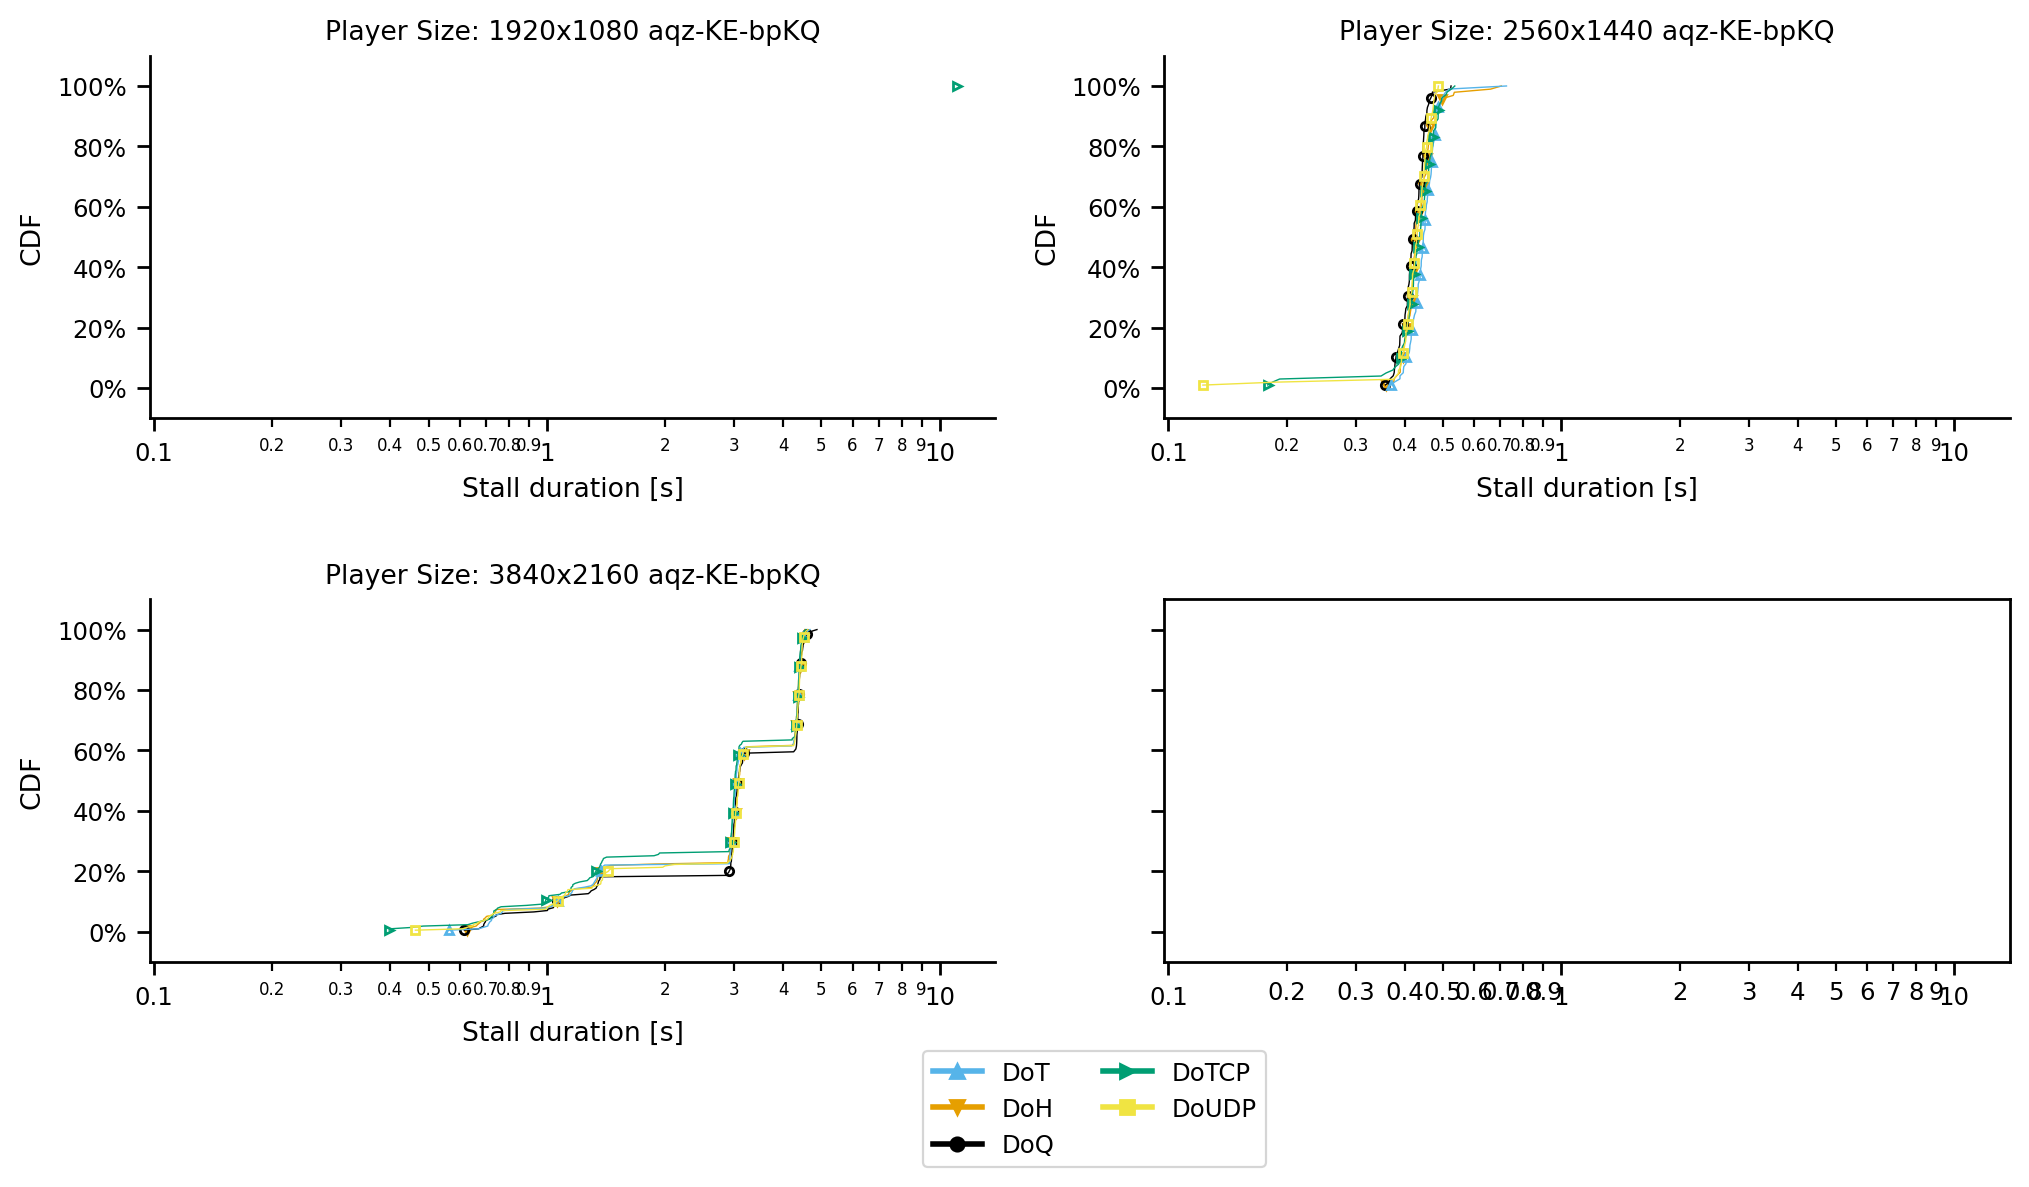

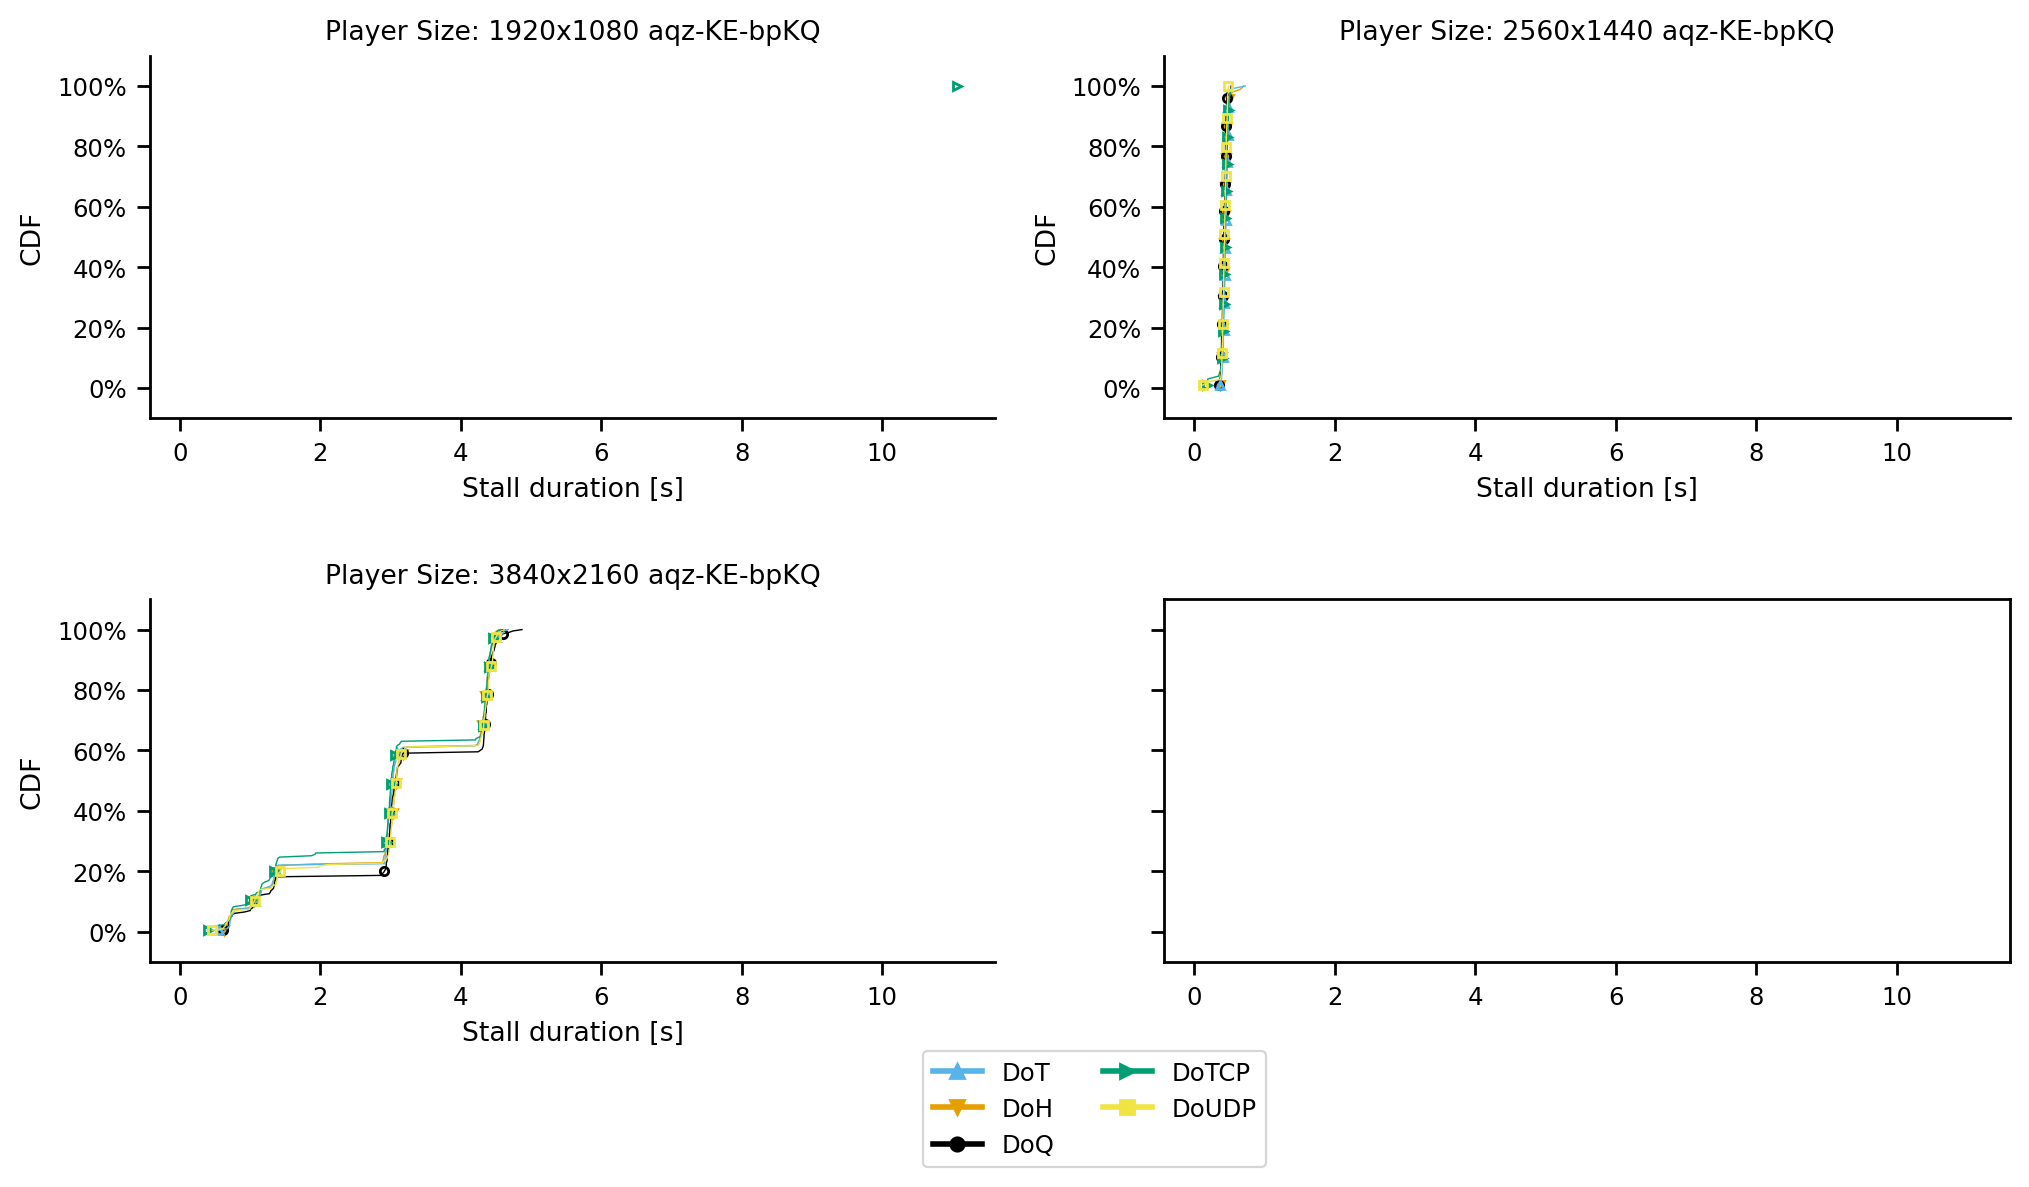

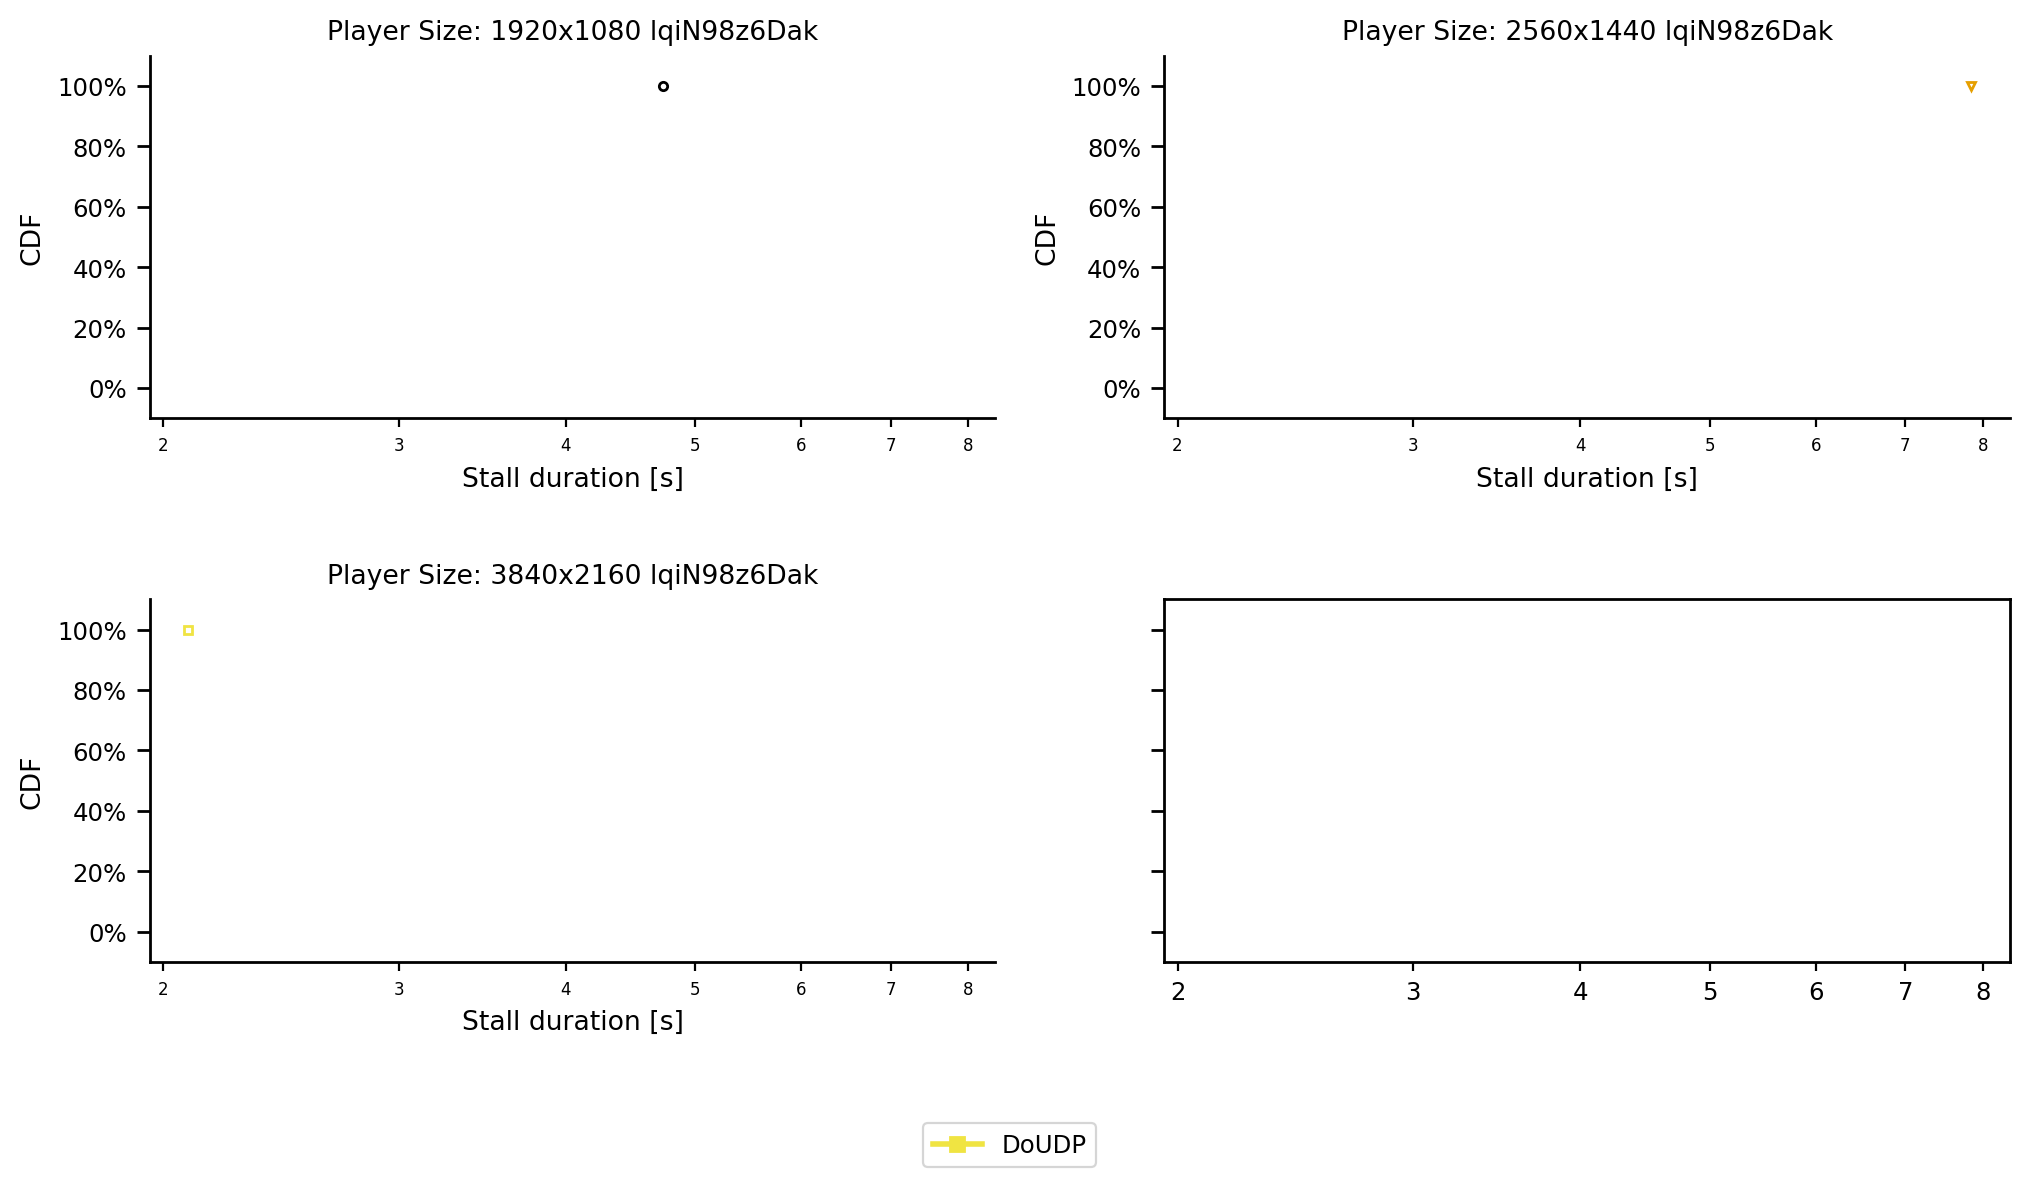

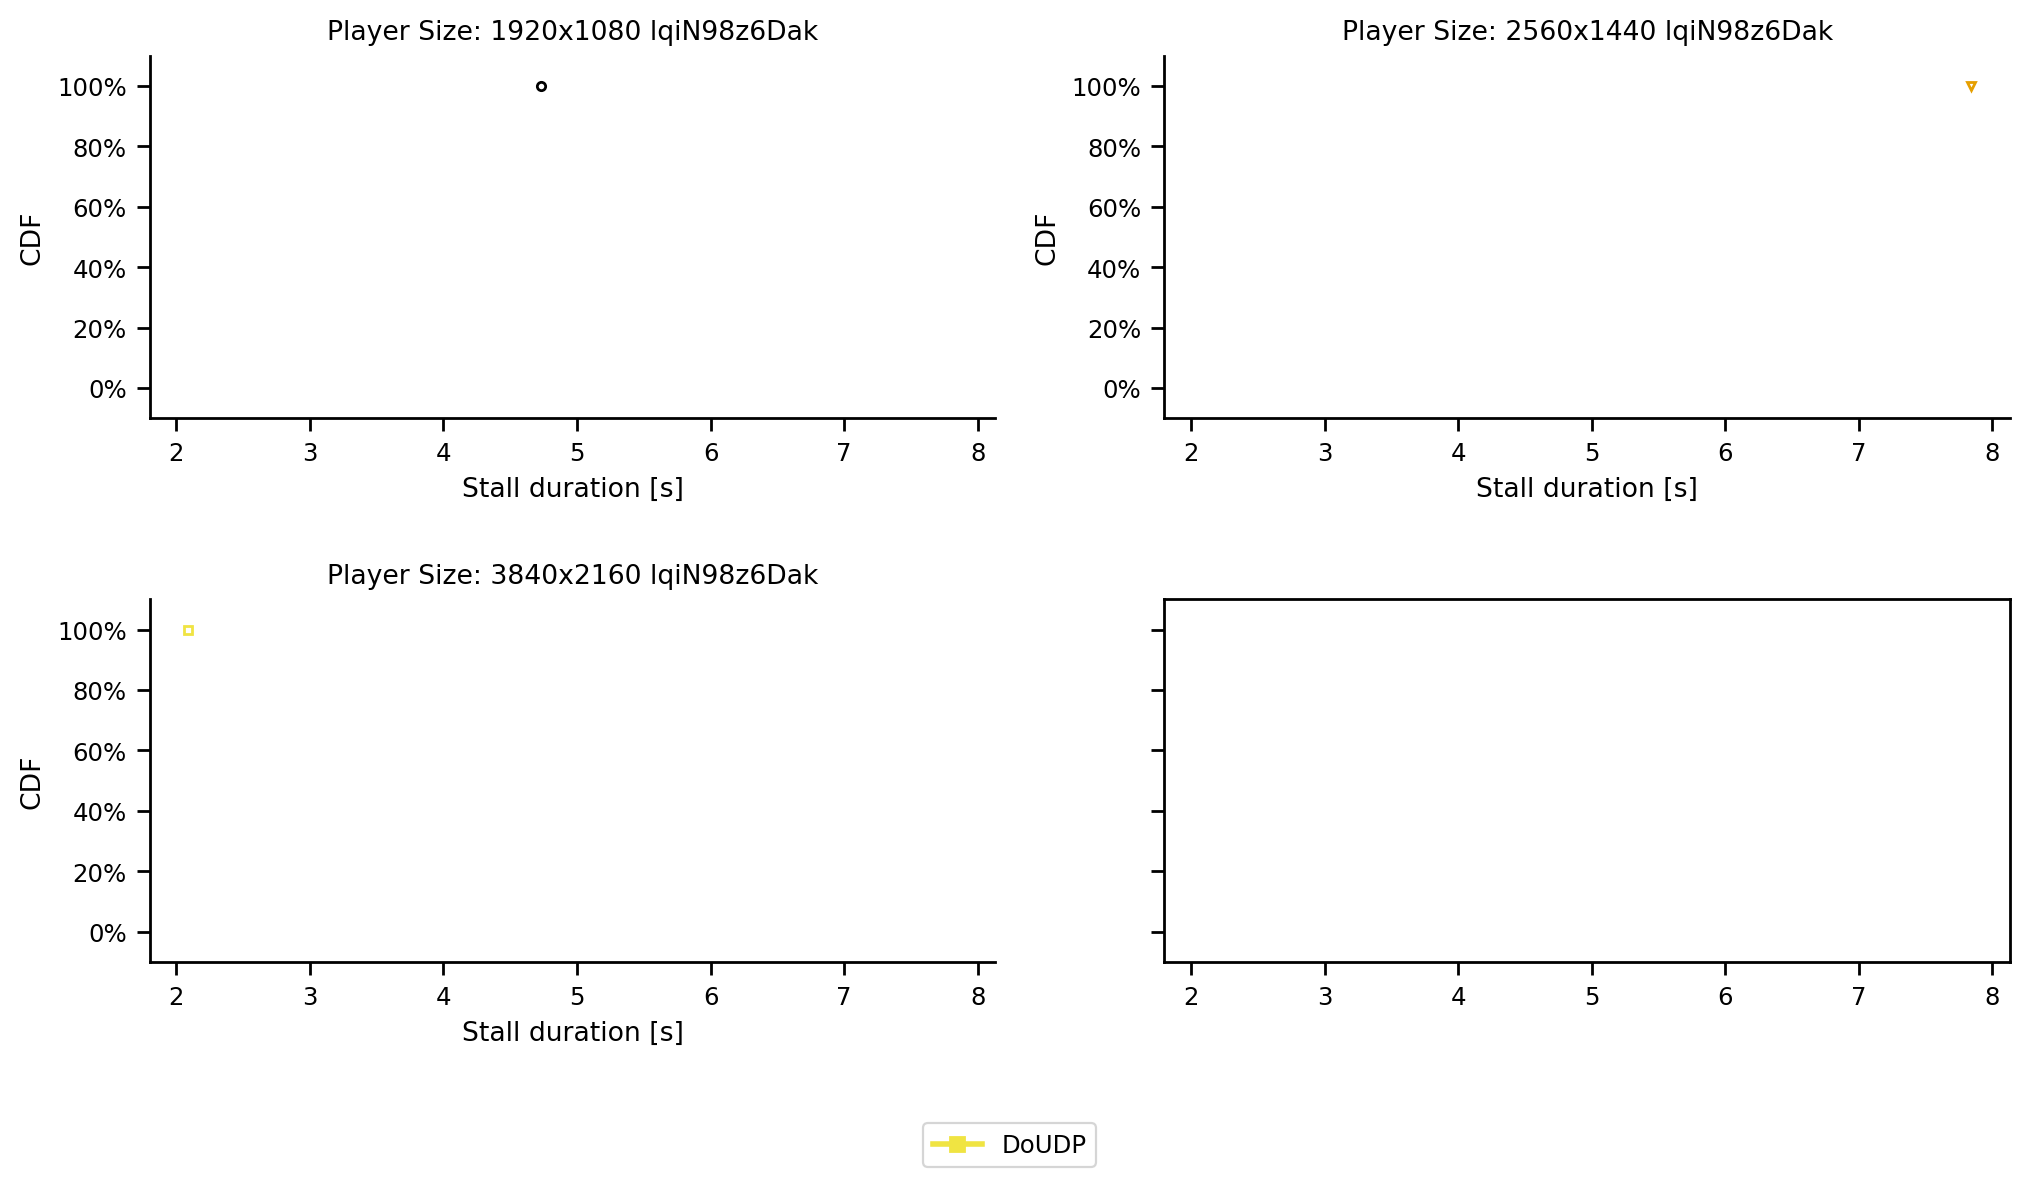

In [113]:
draw_cdf_grid(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0])

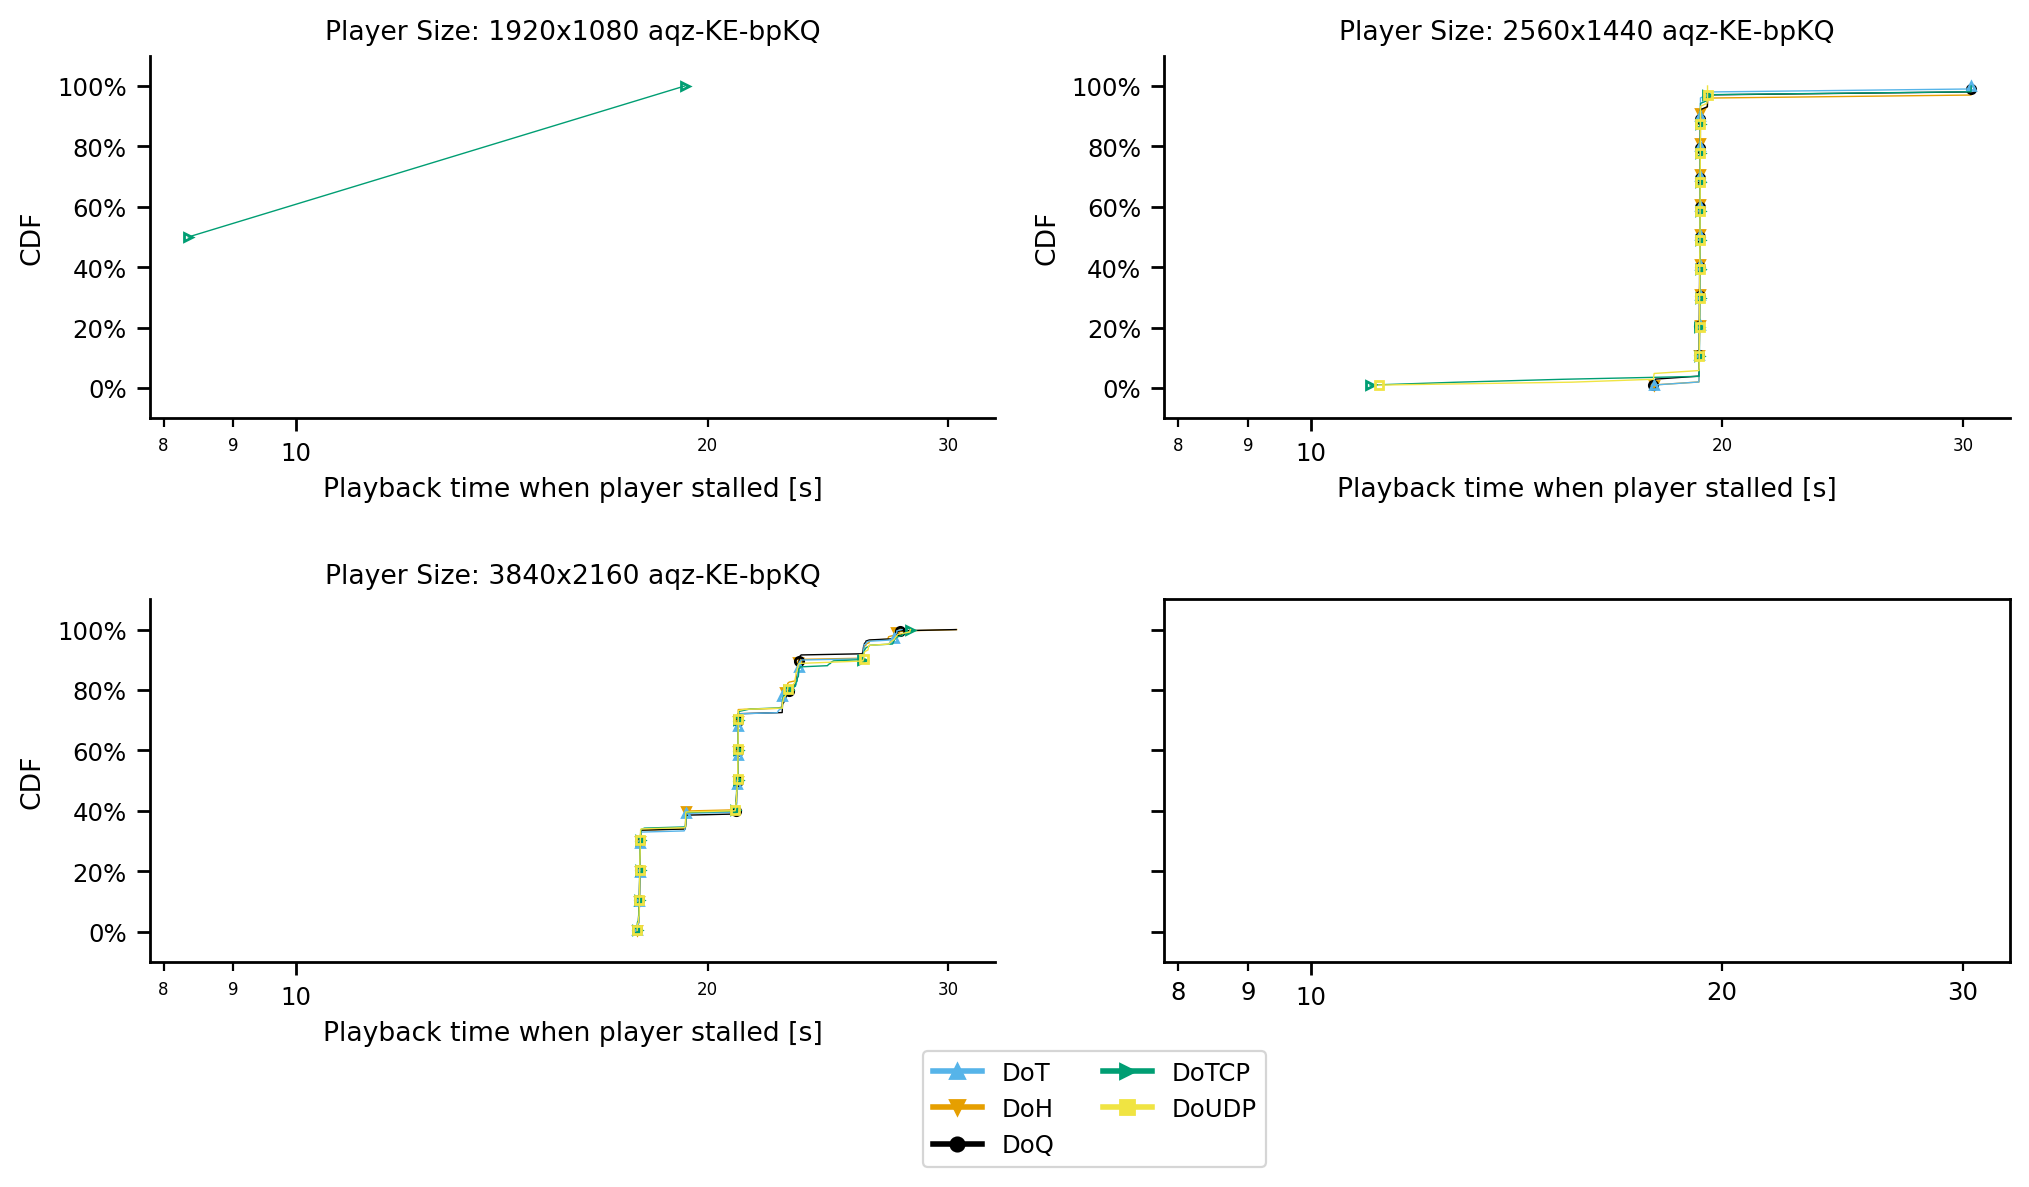

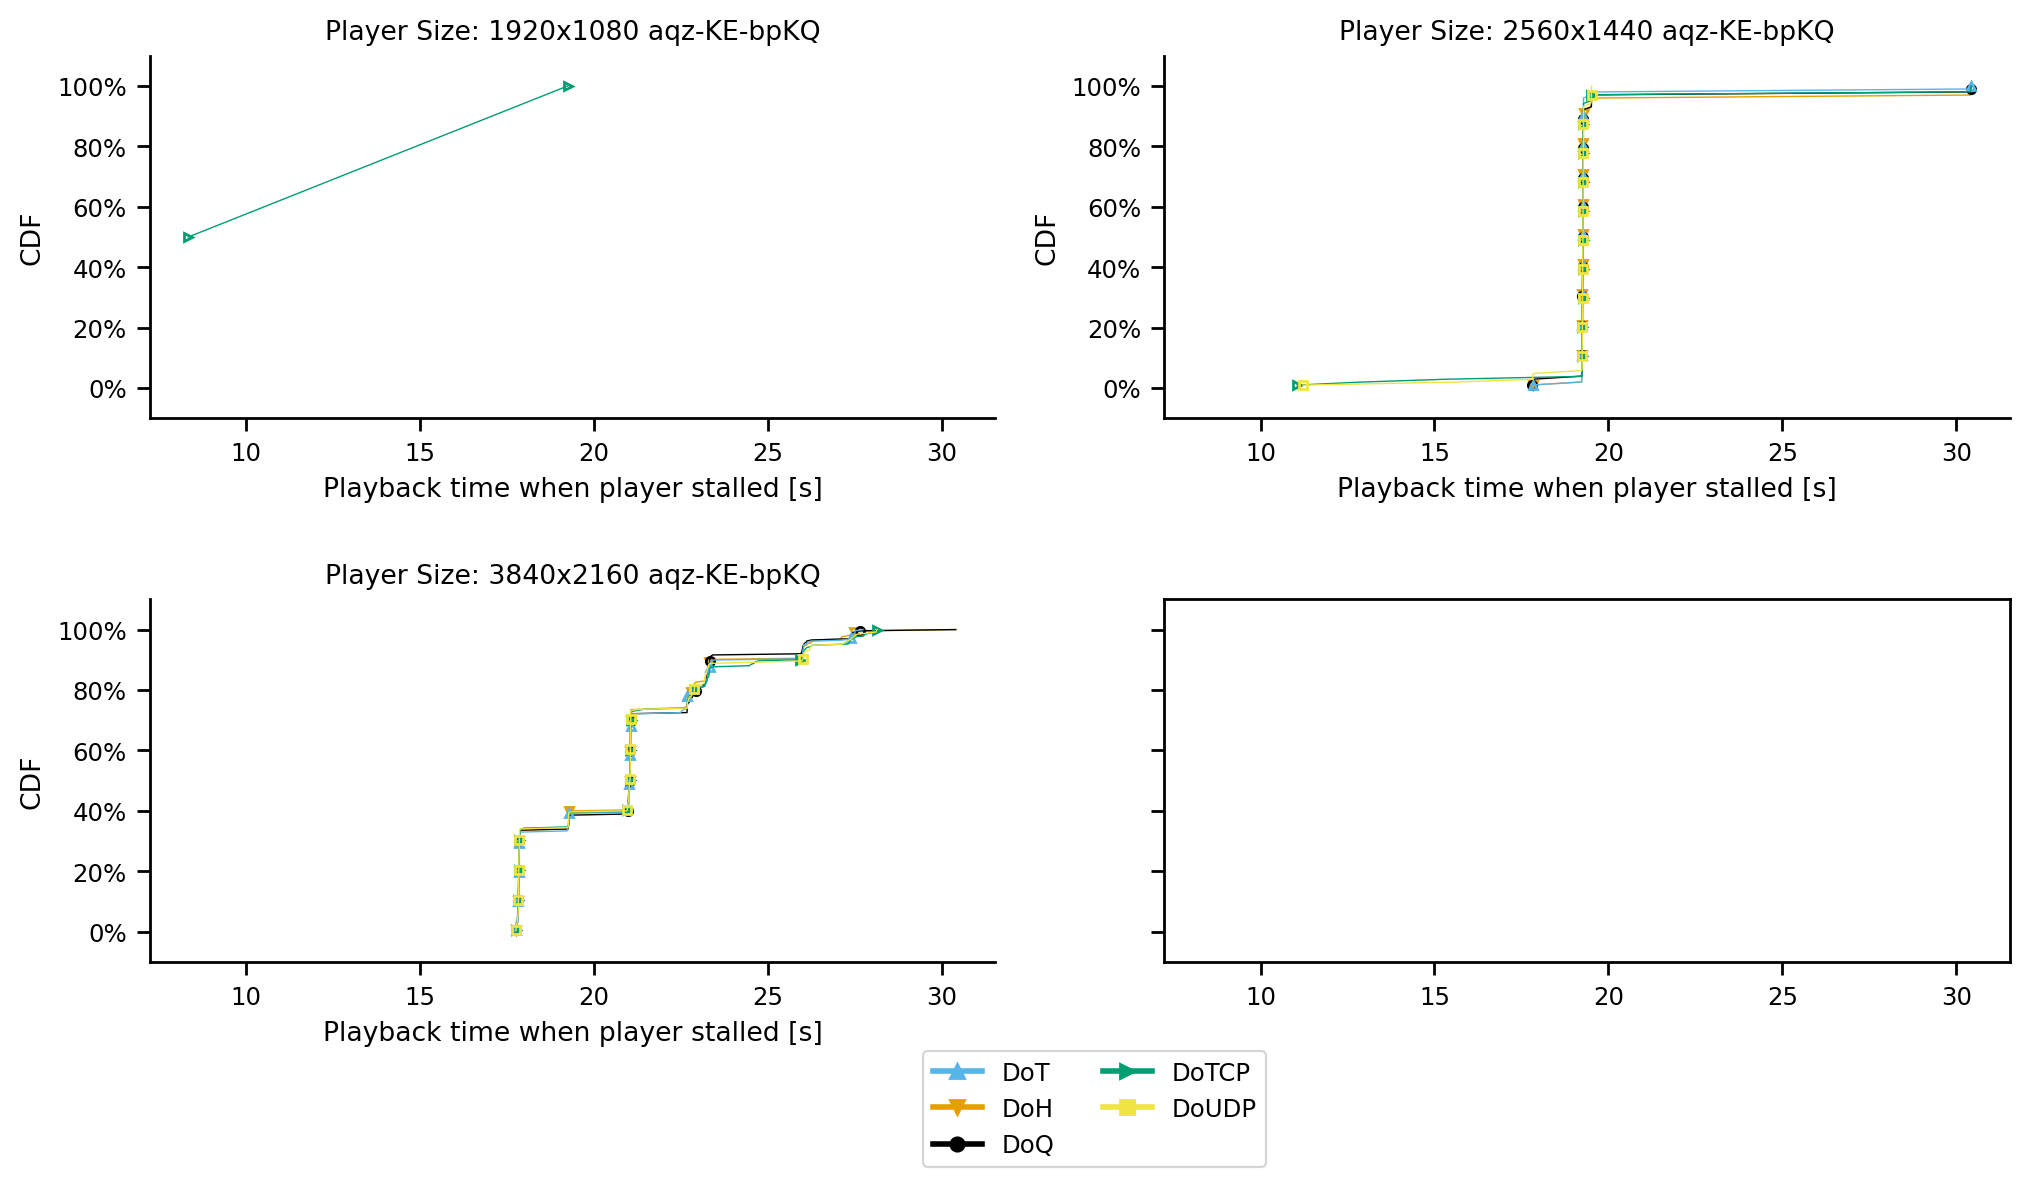

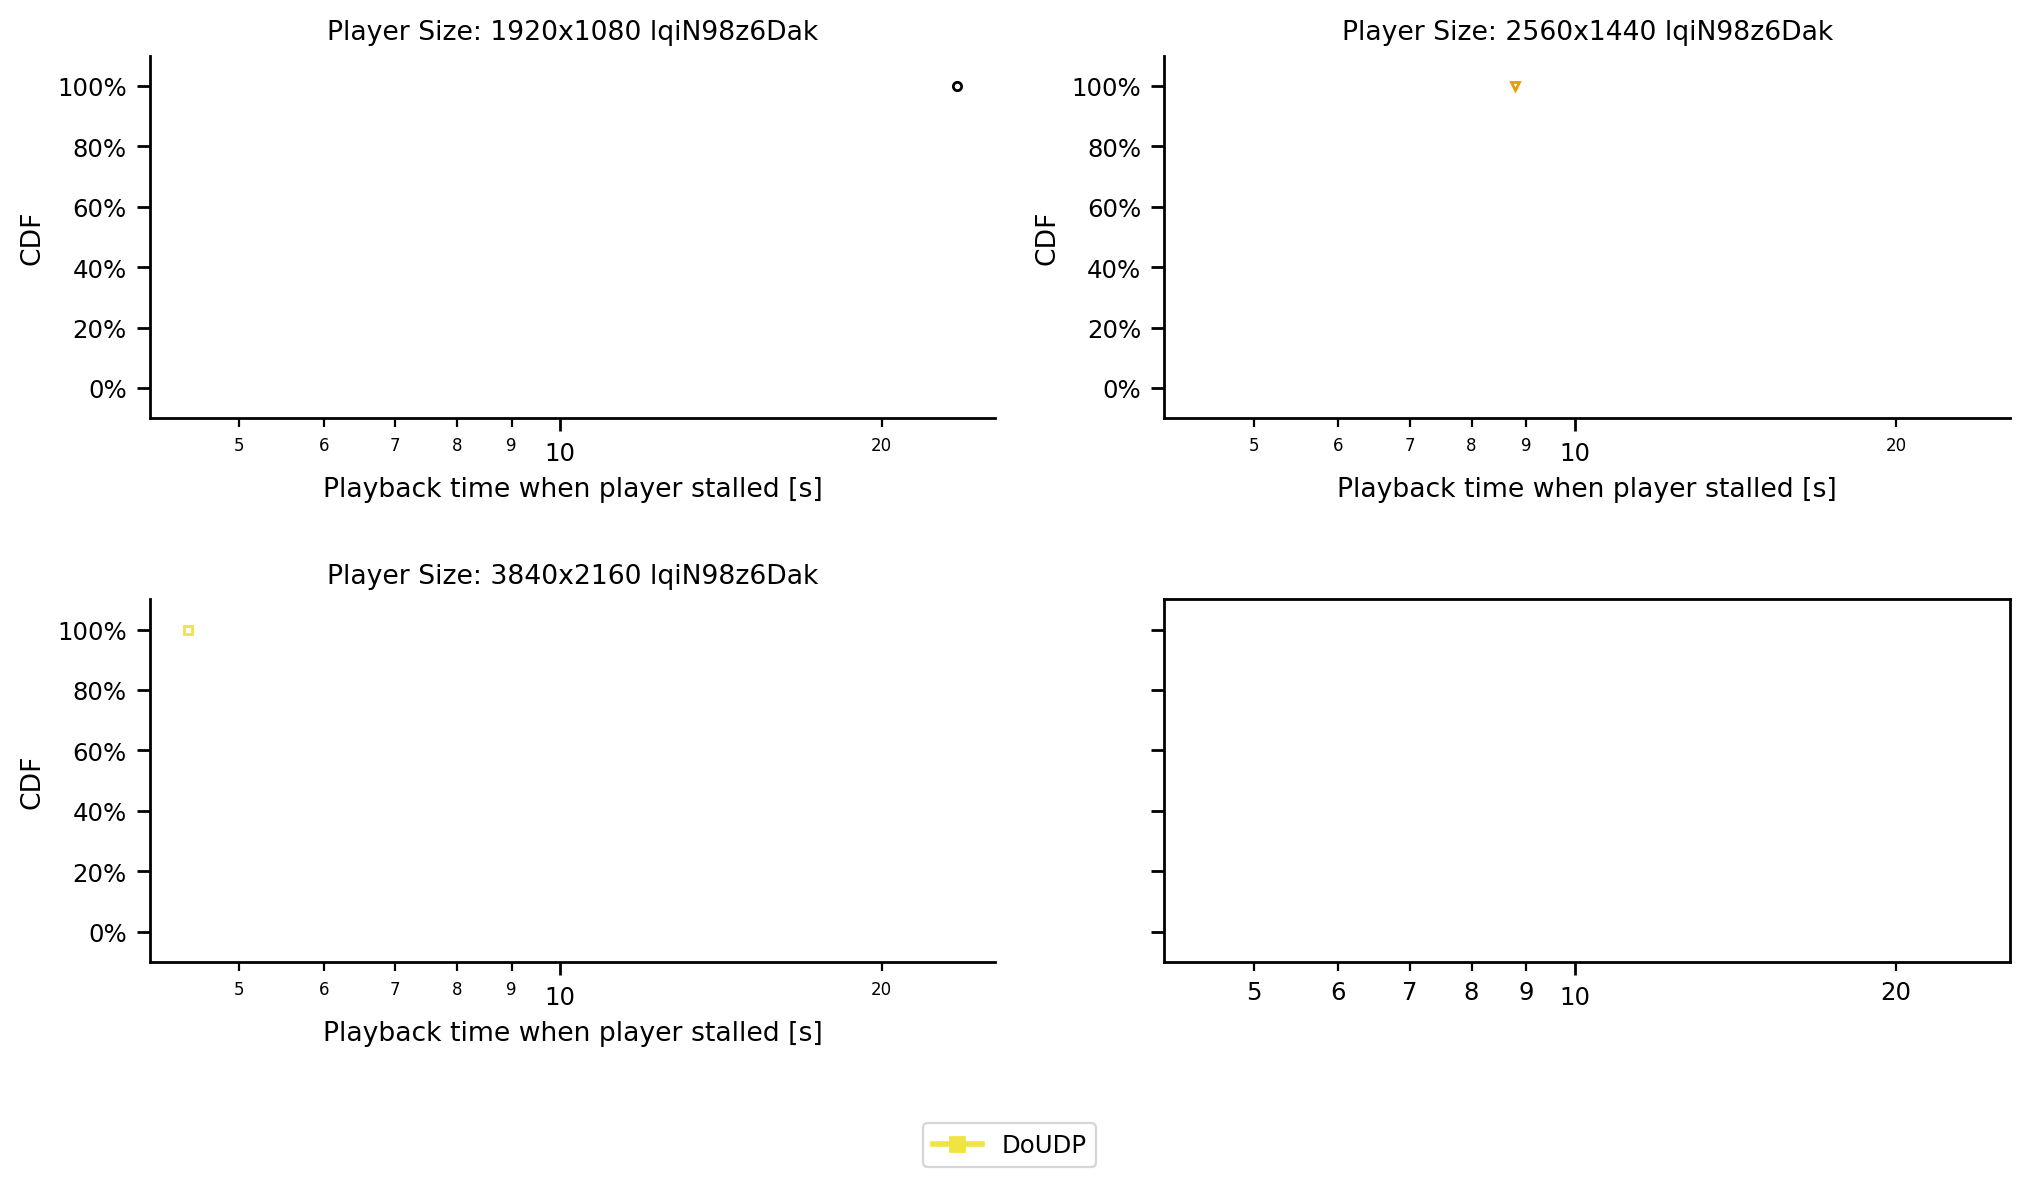

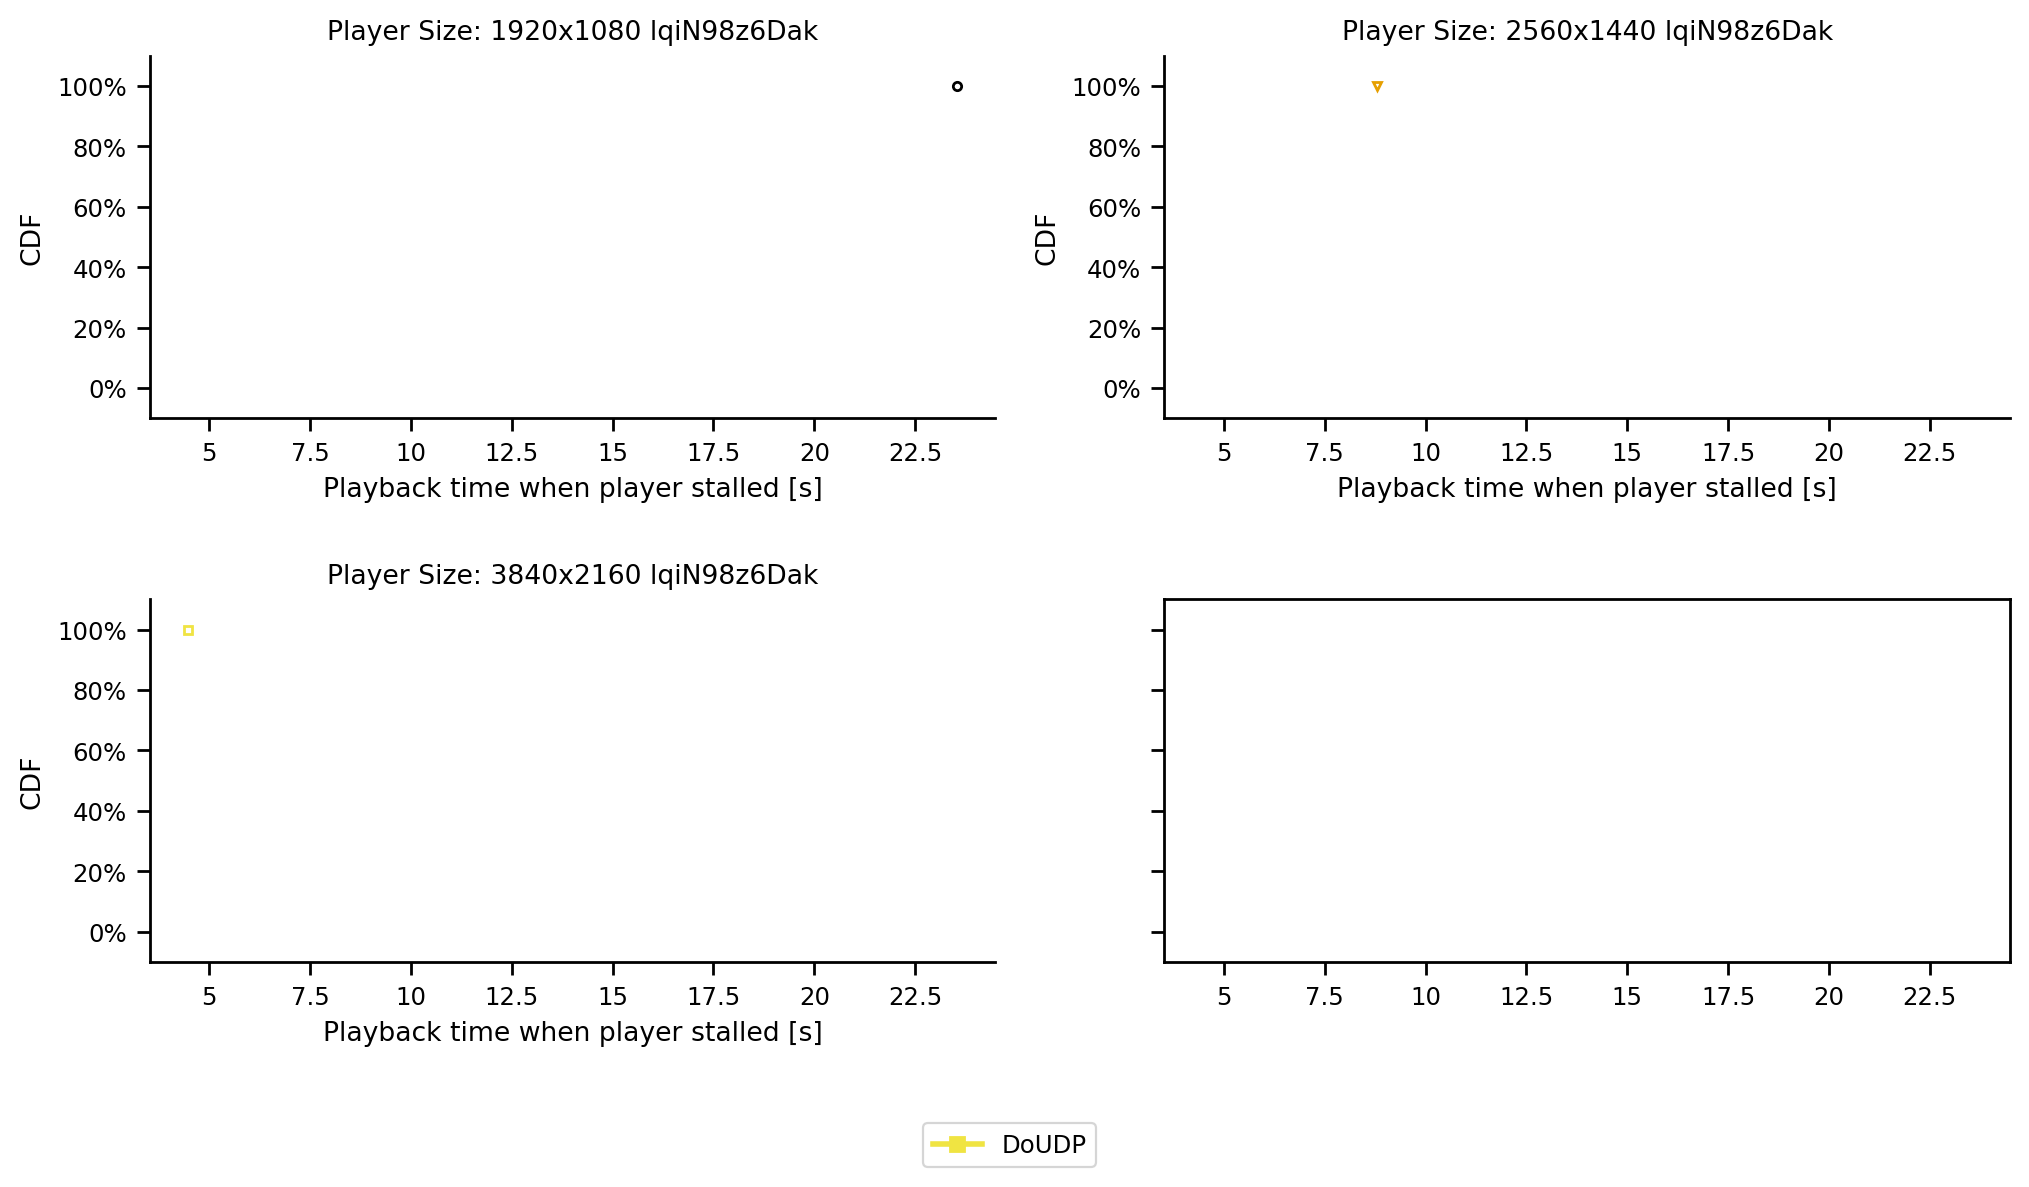

In [115]:
draw_cdf_grid(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True,False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0])

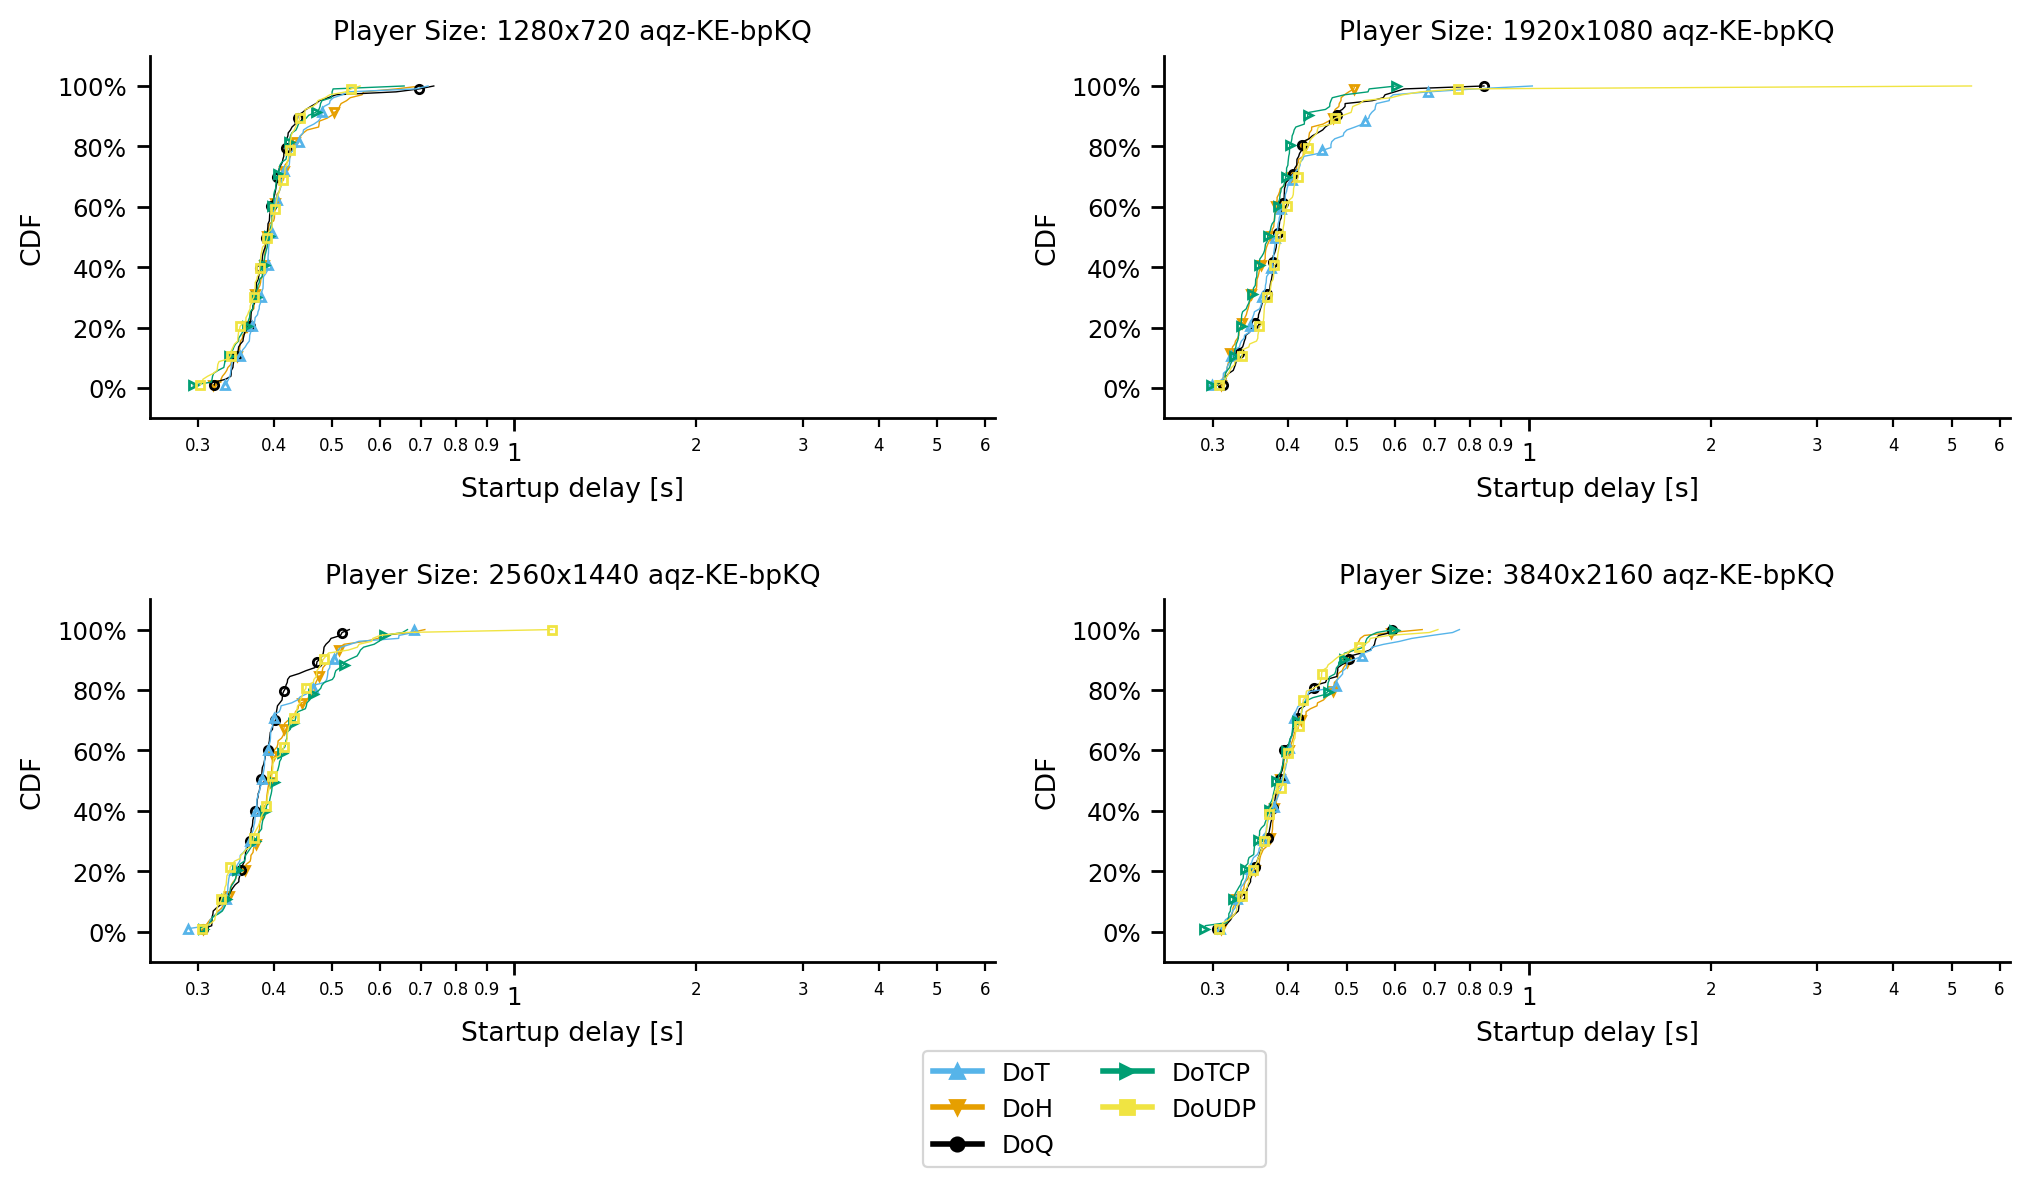

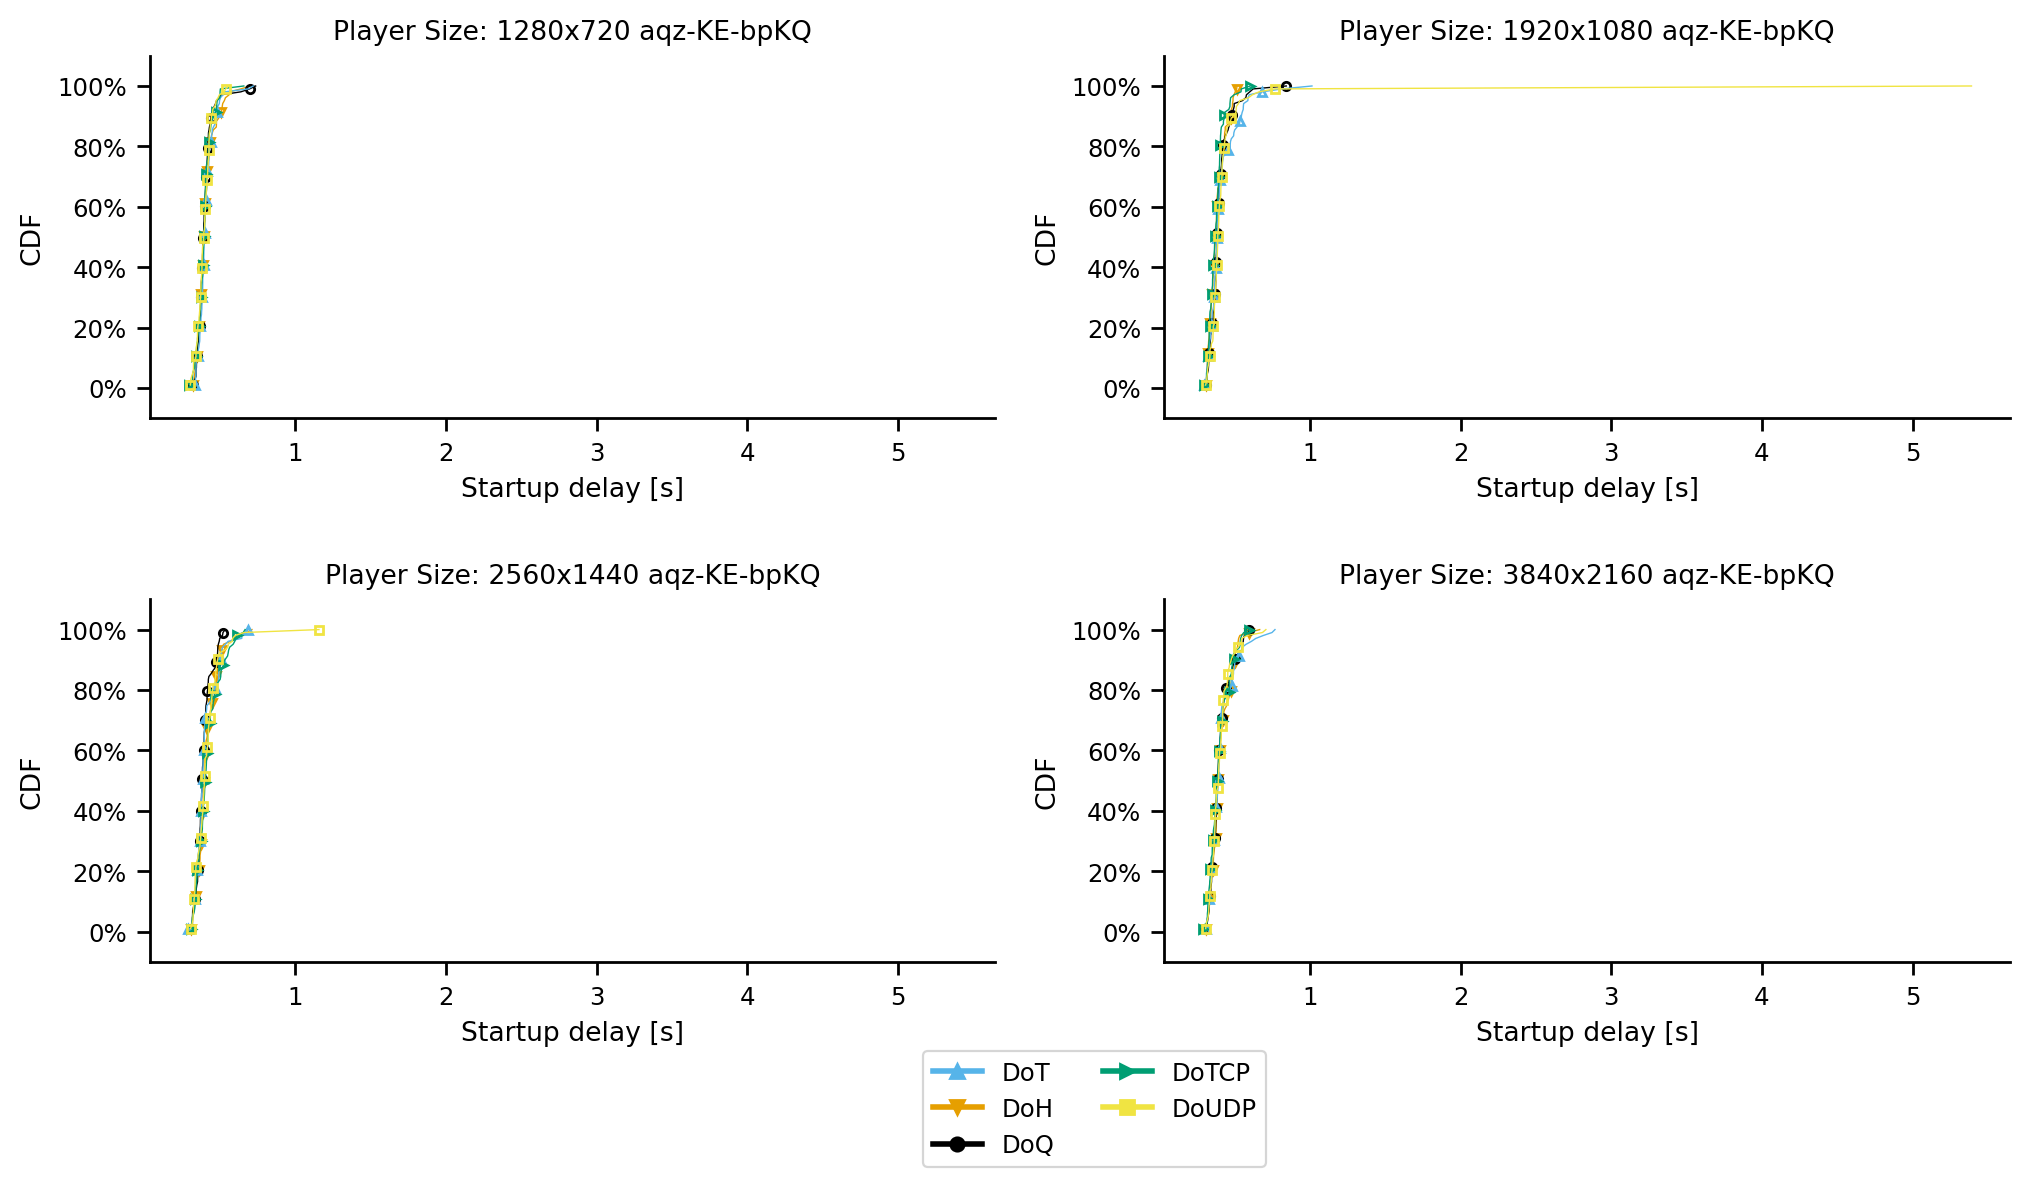

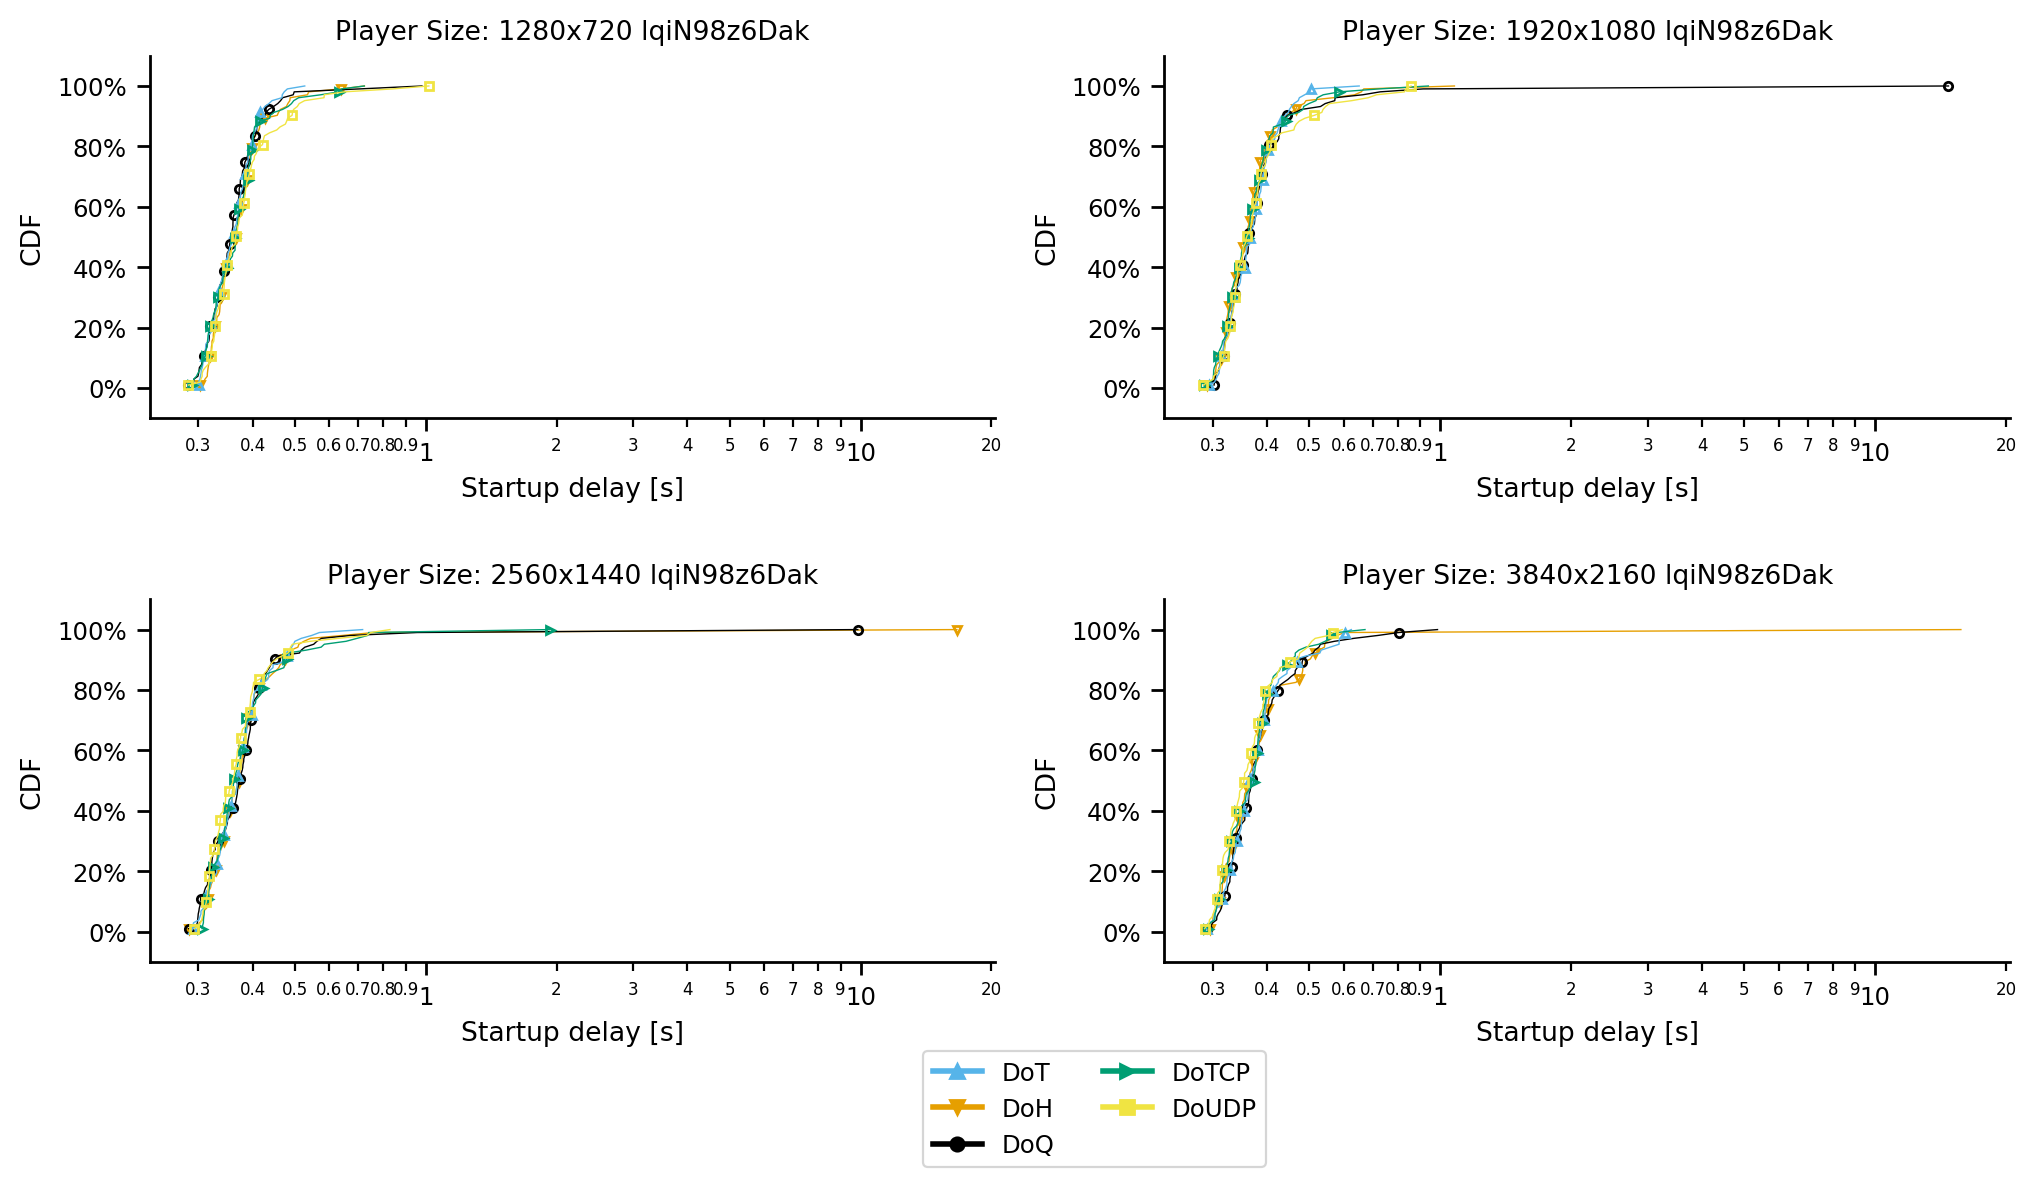

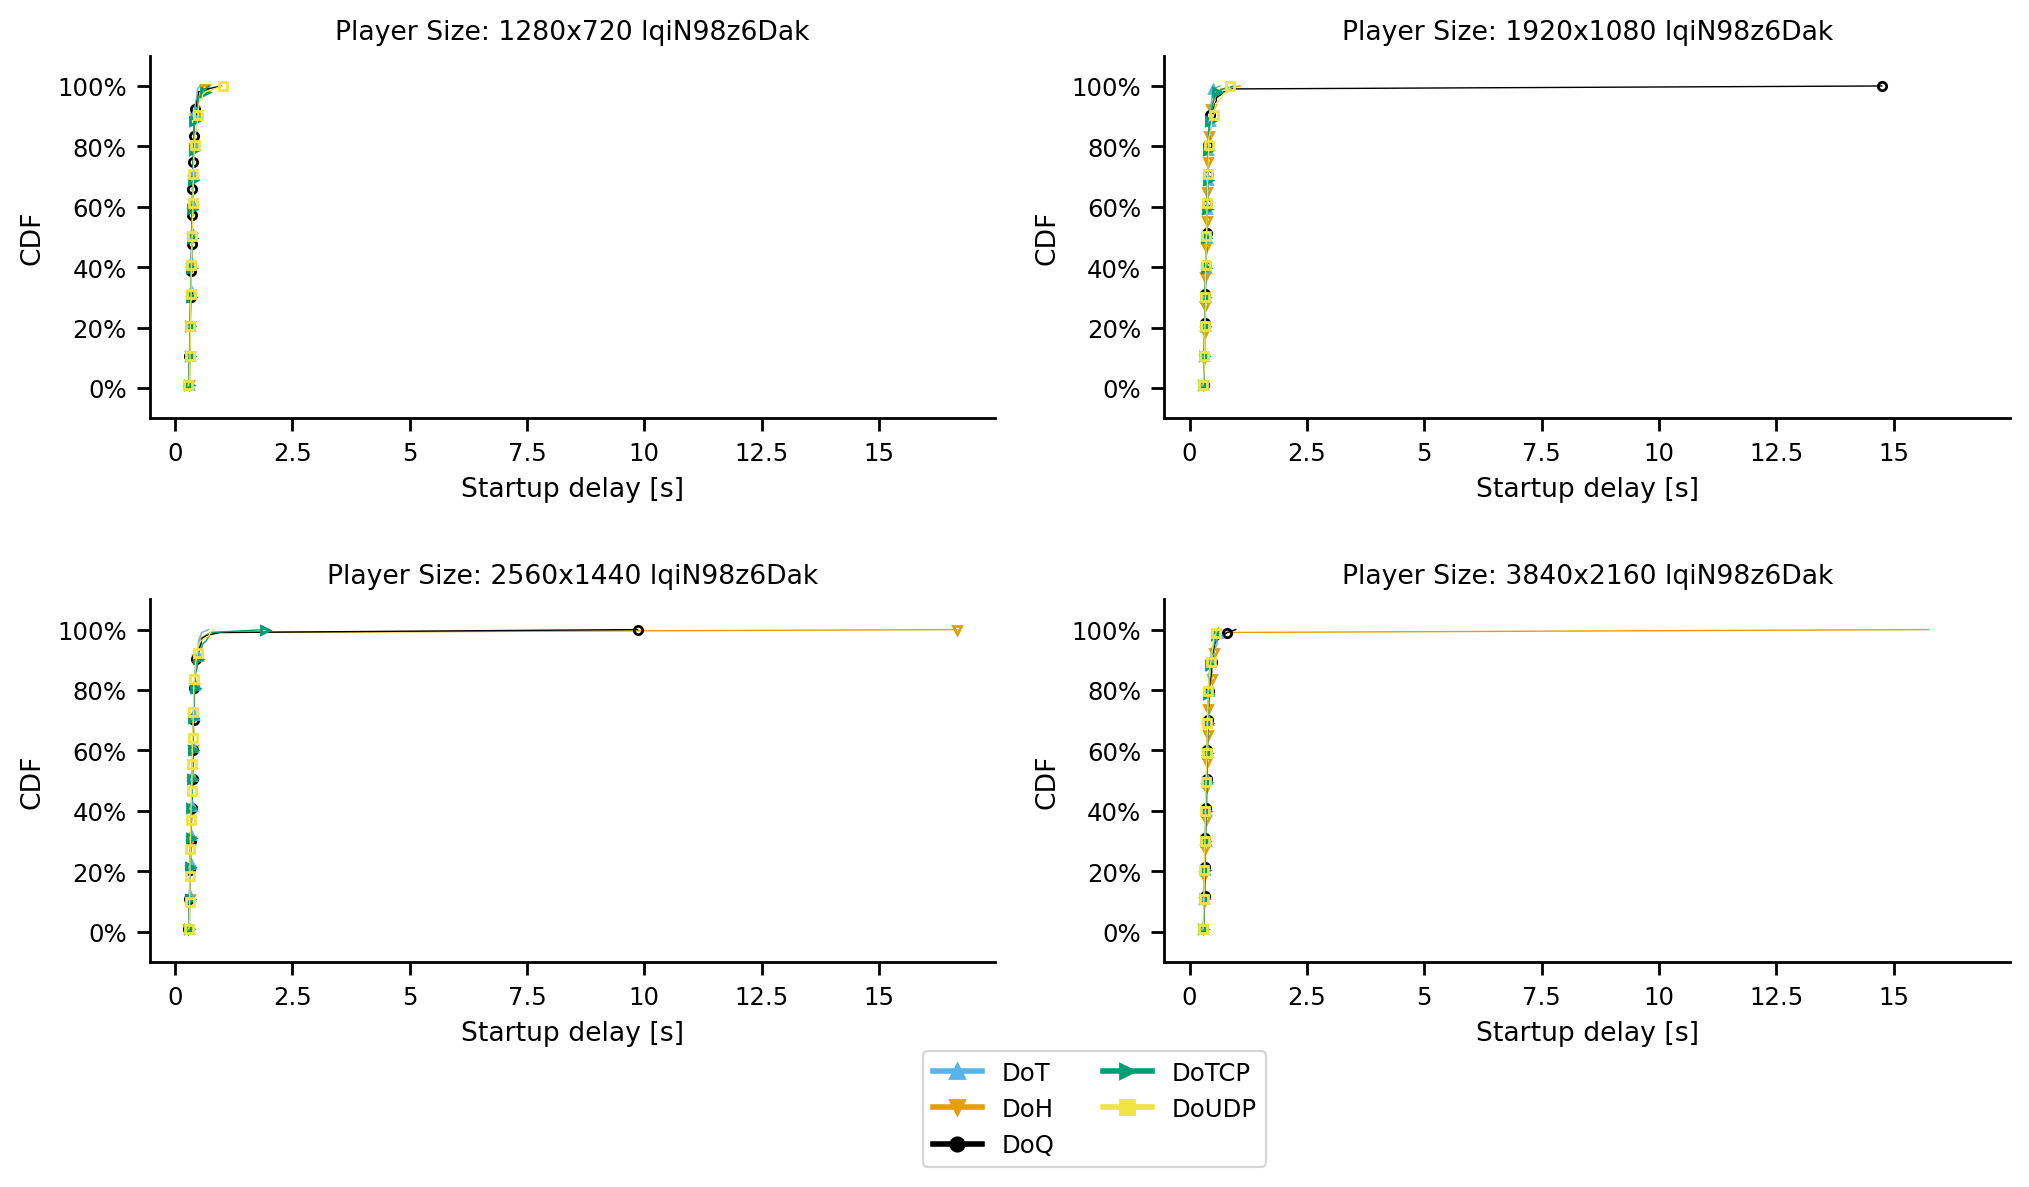

In [117]:
draw_cdf_grid(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0])

In [ ]:
draw_cdf(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0.1,1])

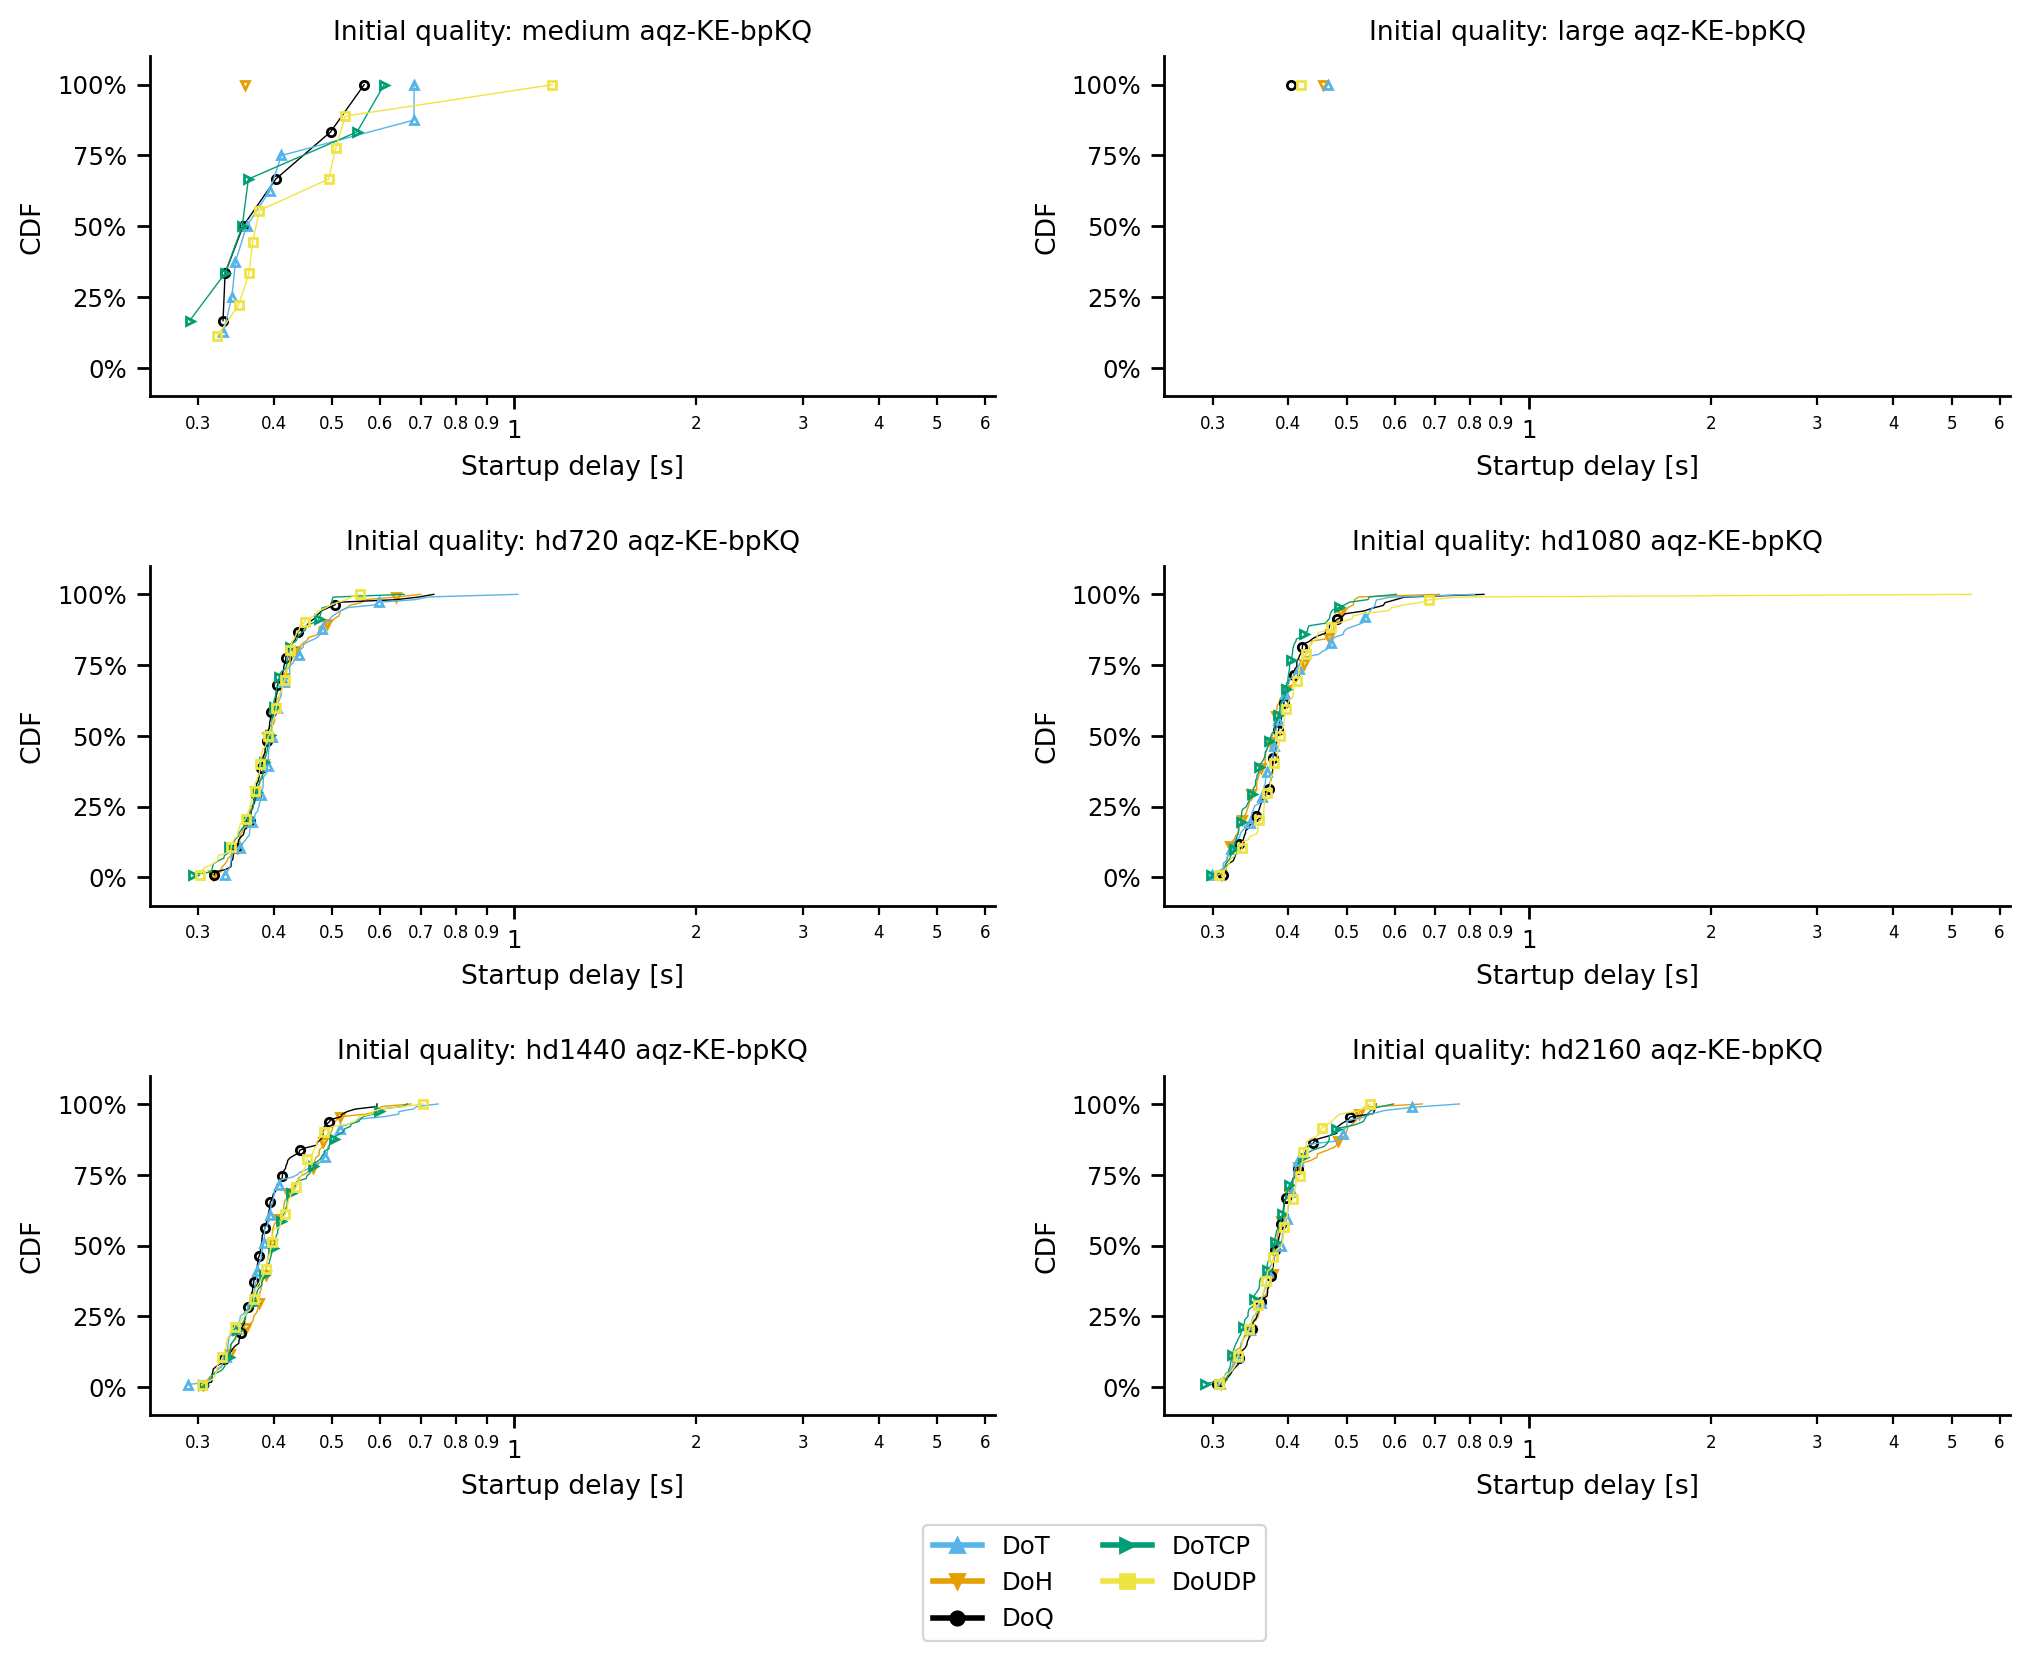

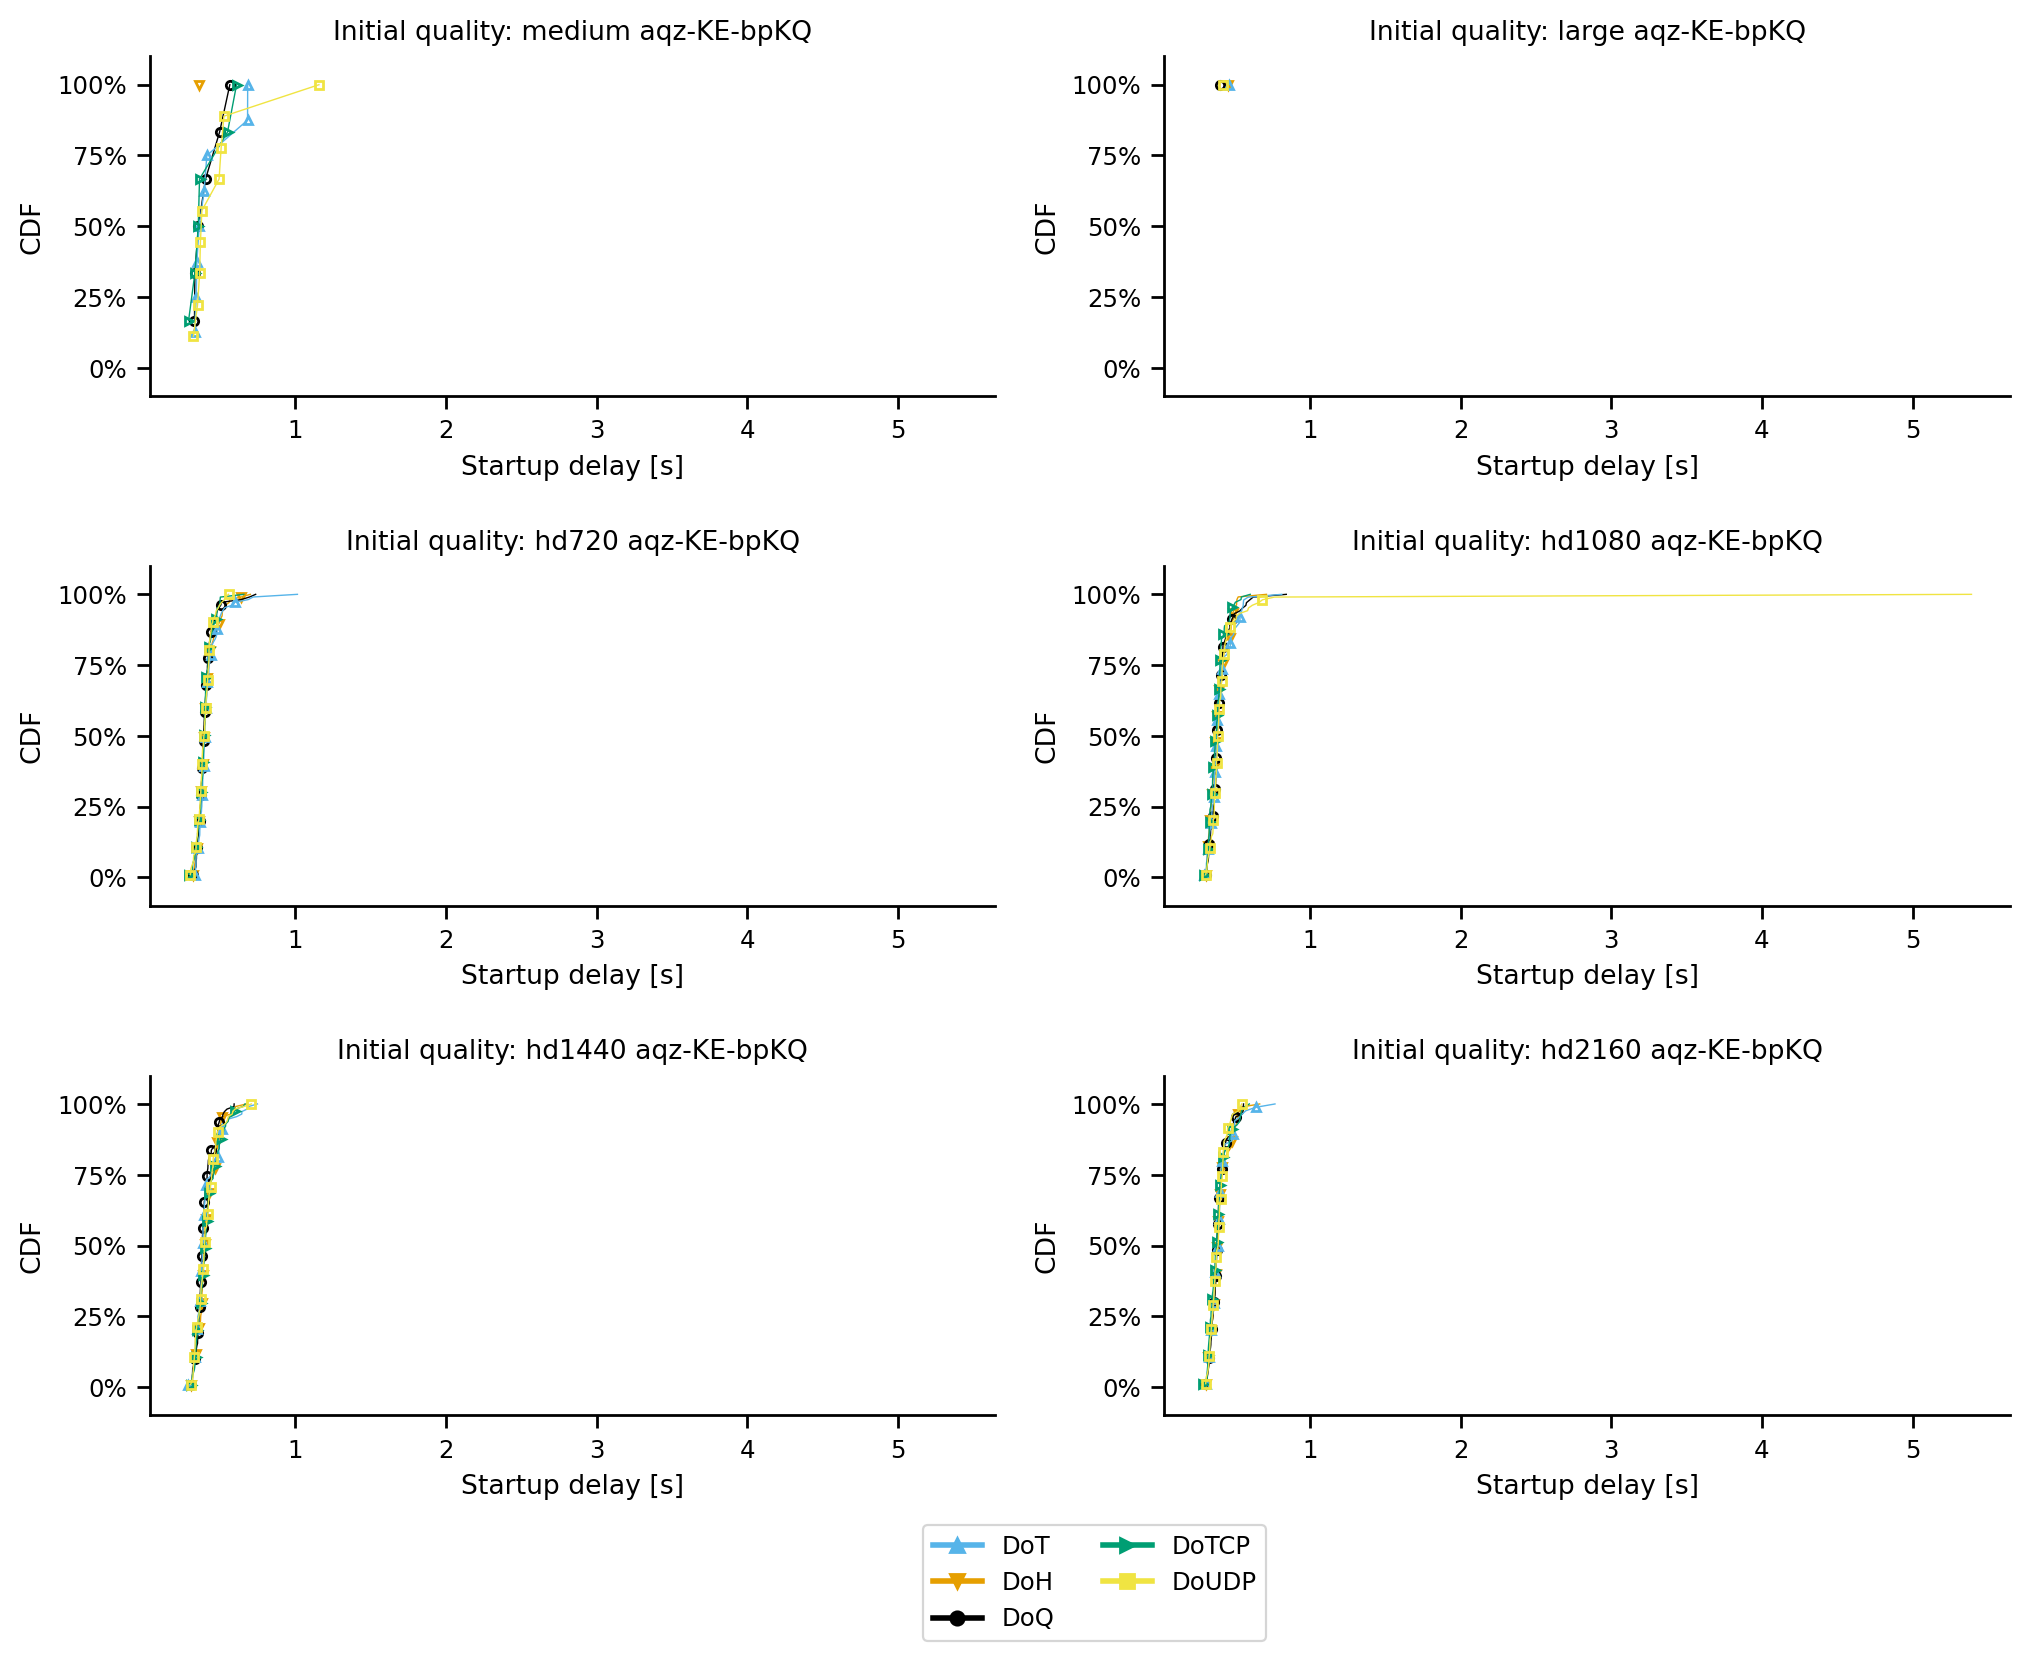

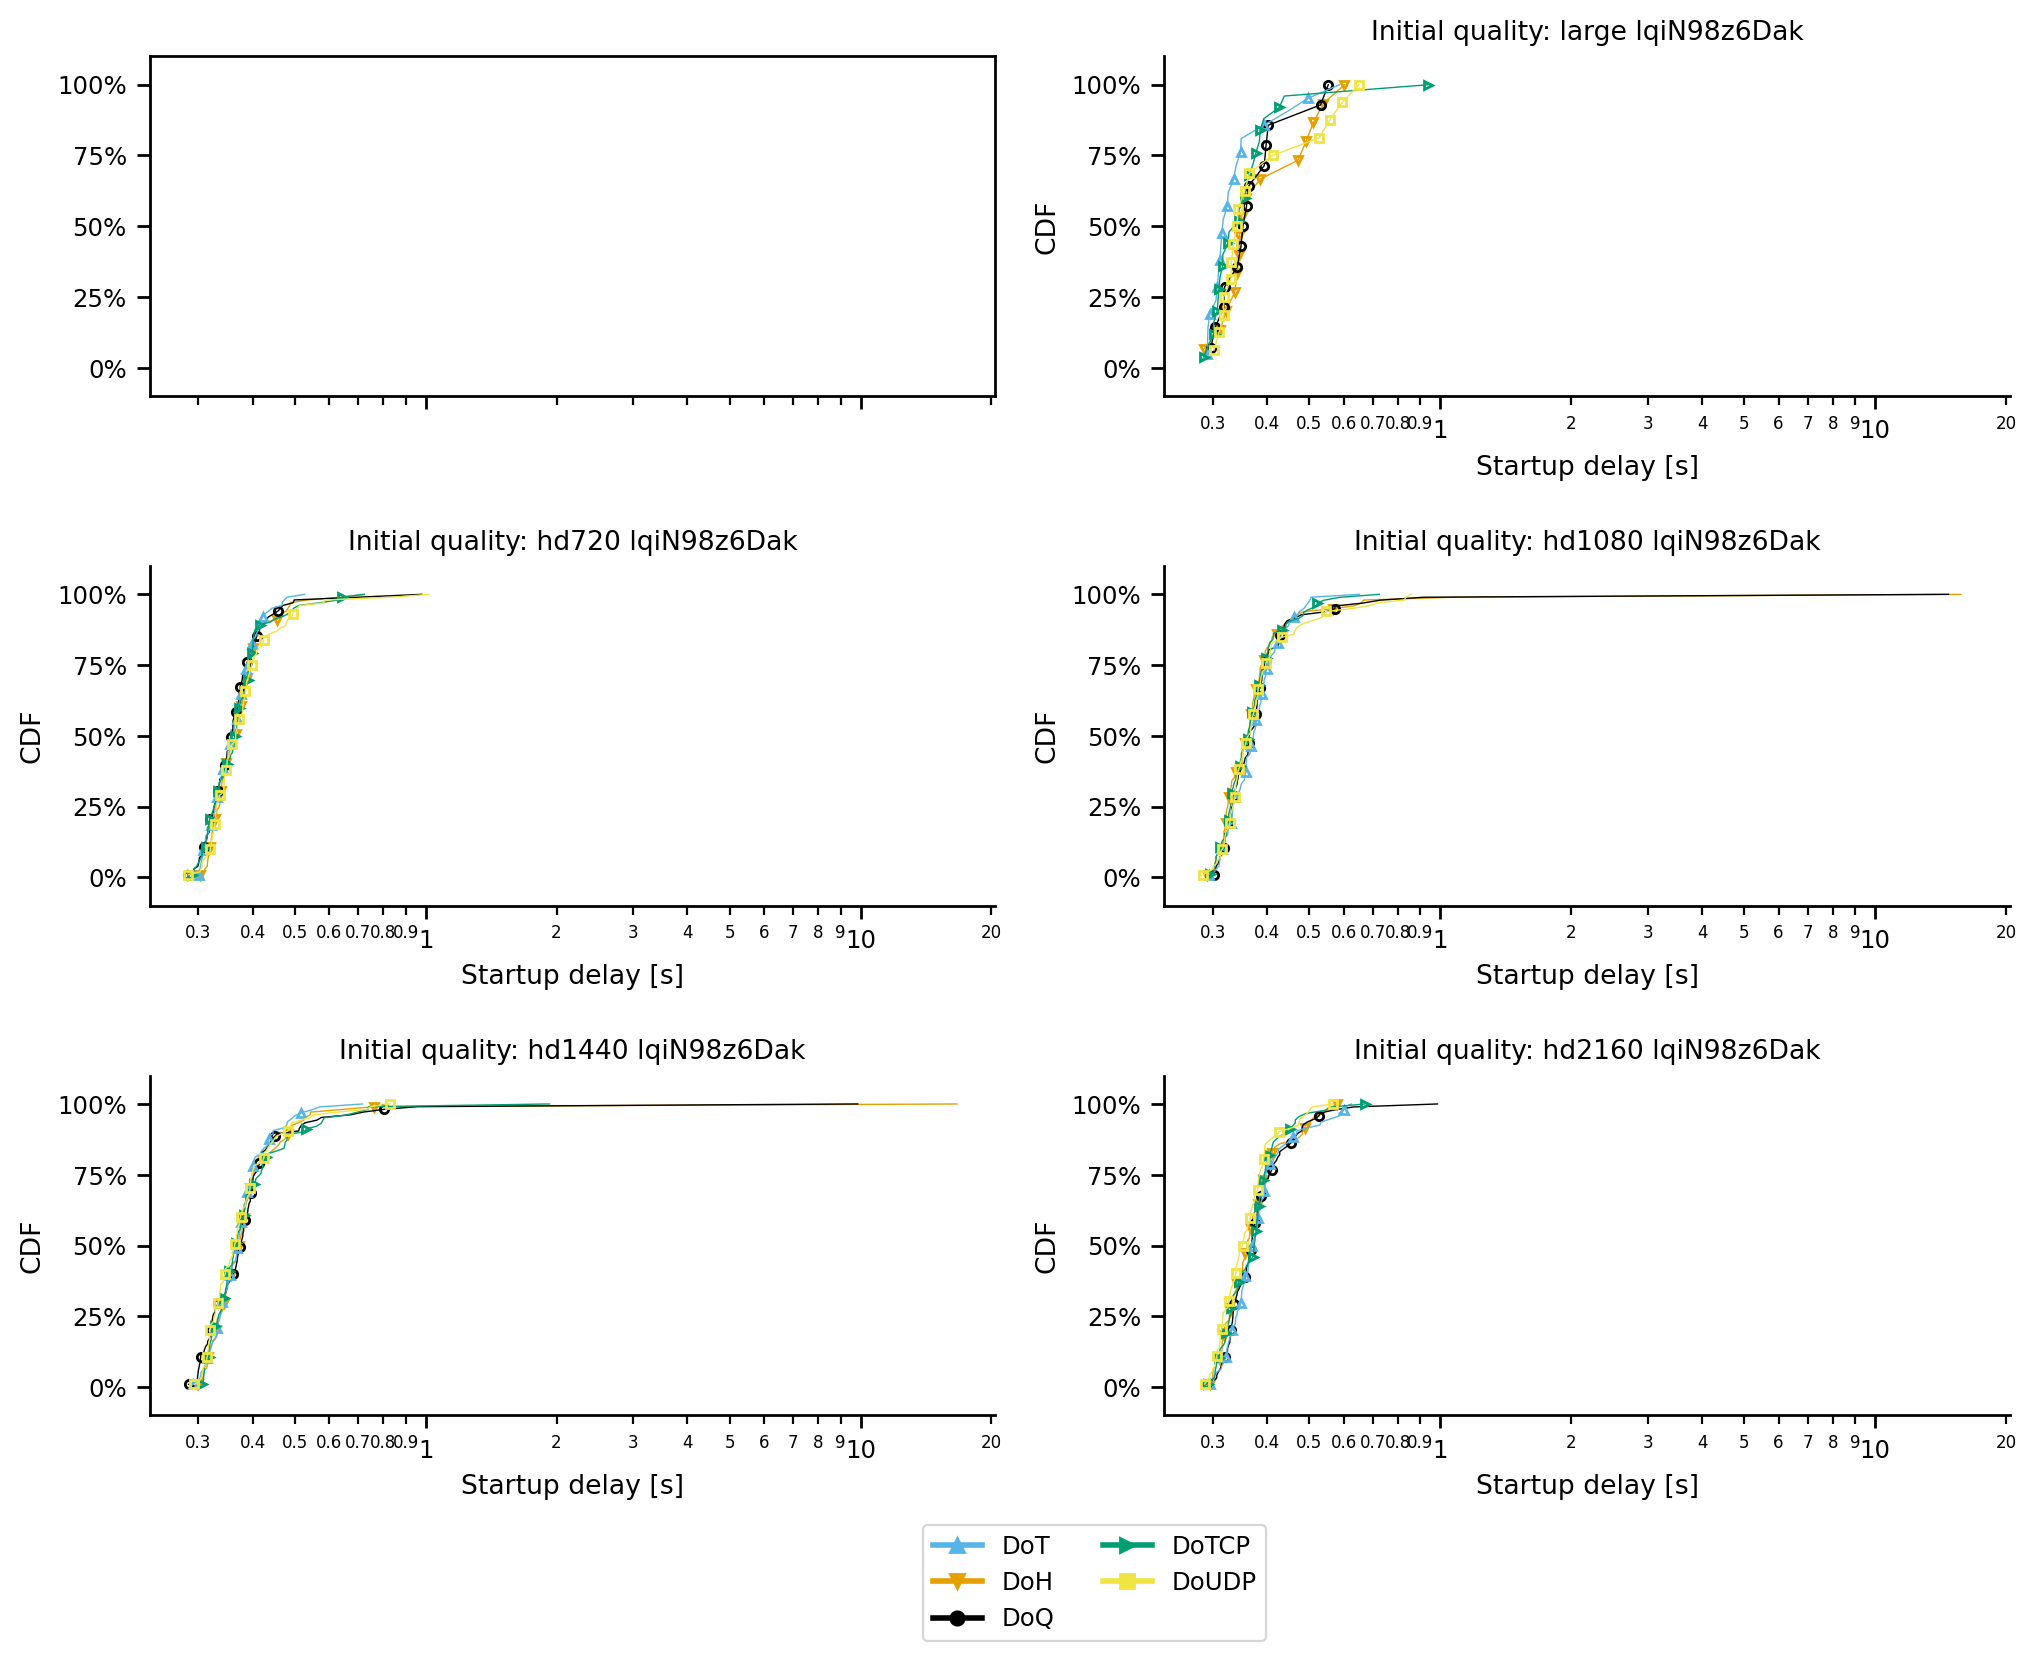

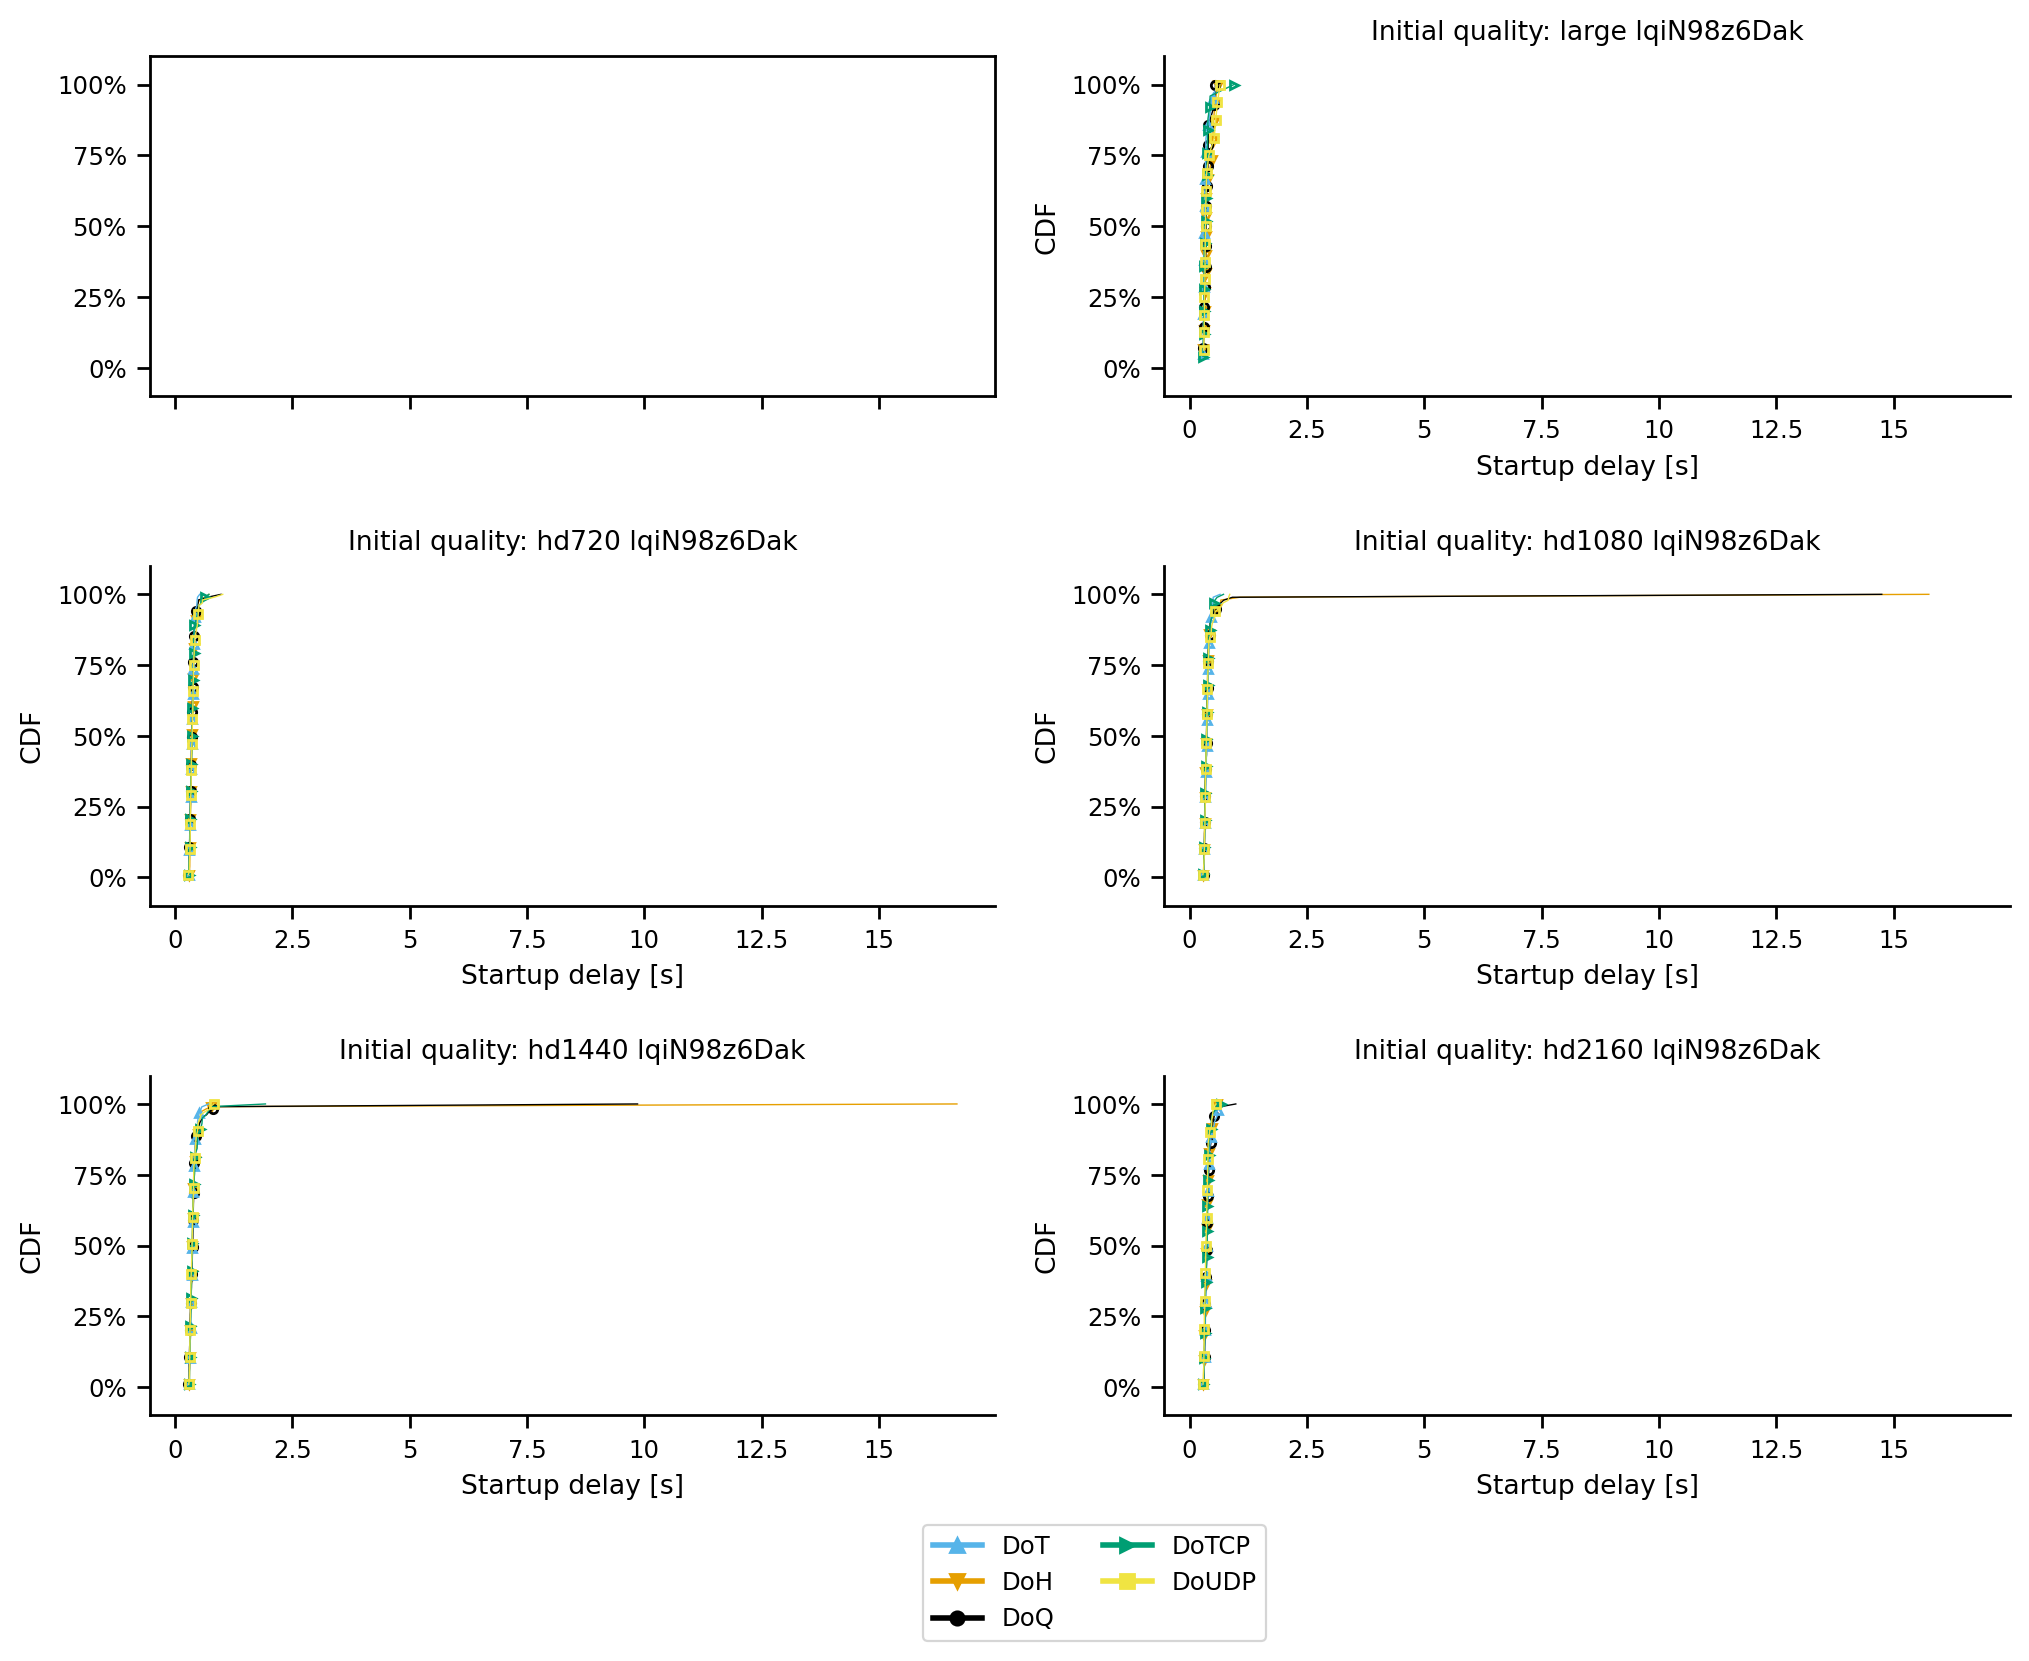

In [119]:
draw_cdf_grid(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0])

In [ ]:
draw_cdf(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True,False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0.1,1])

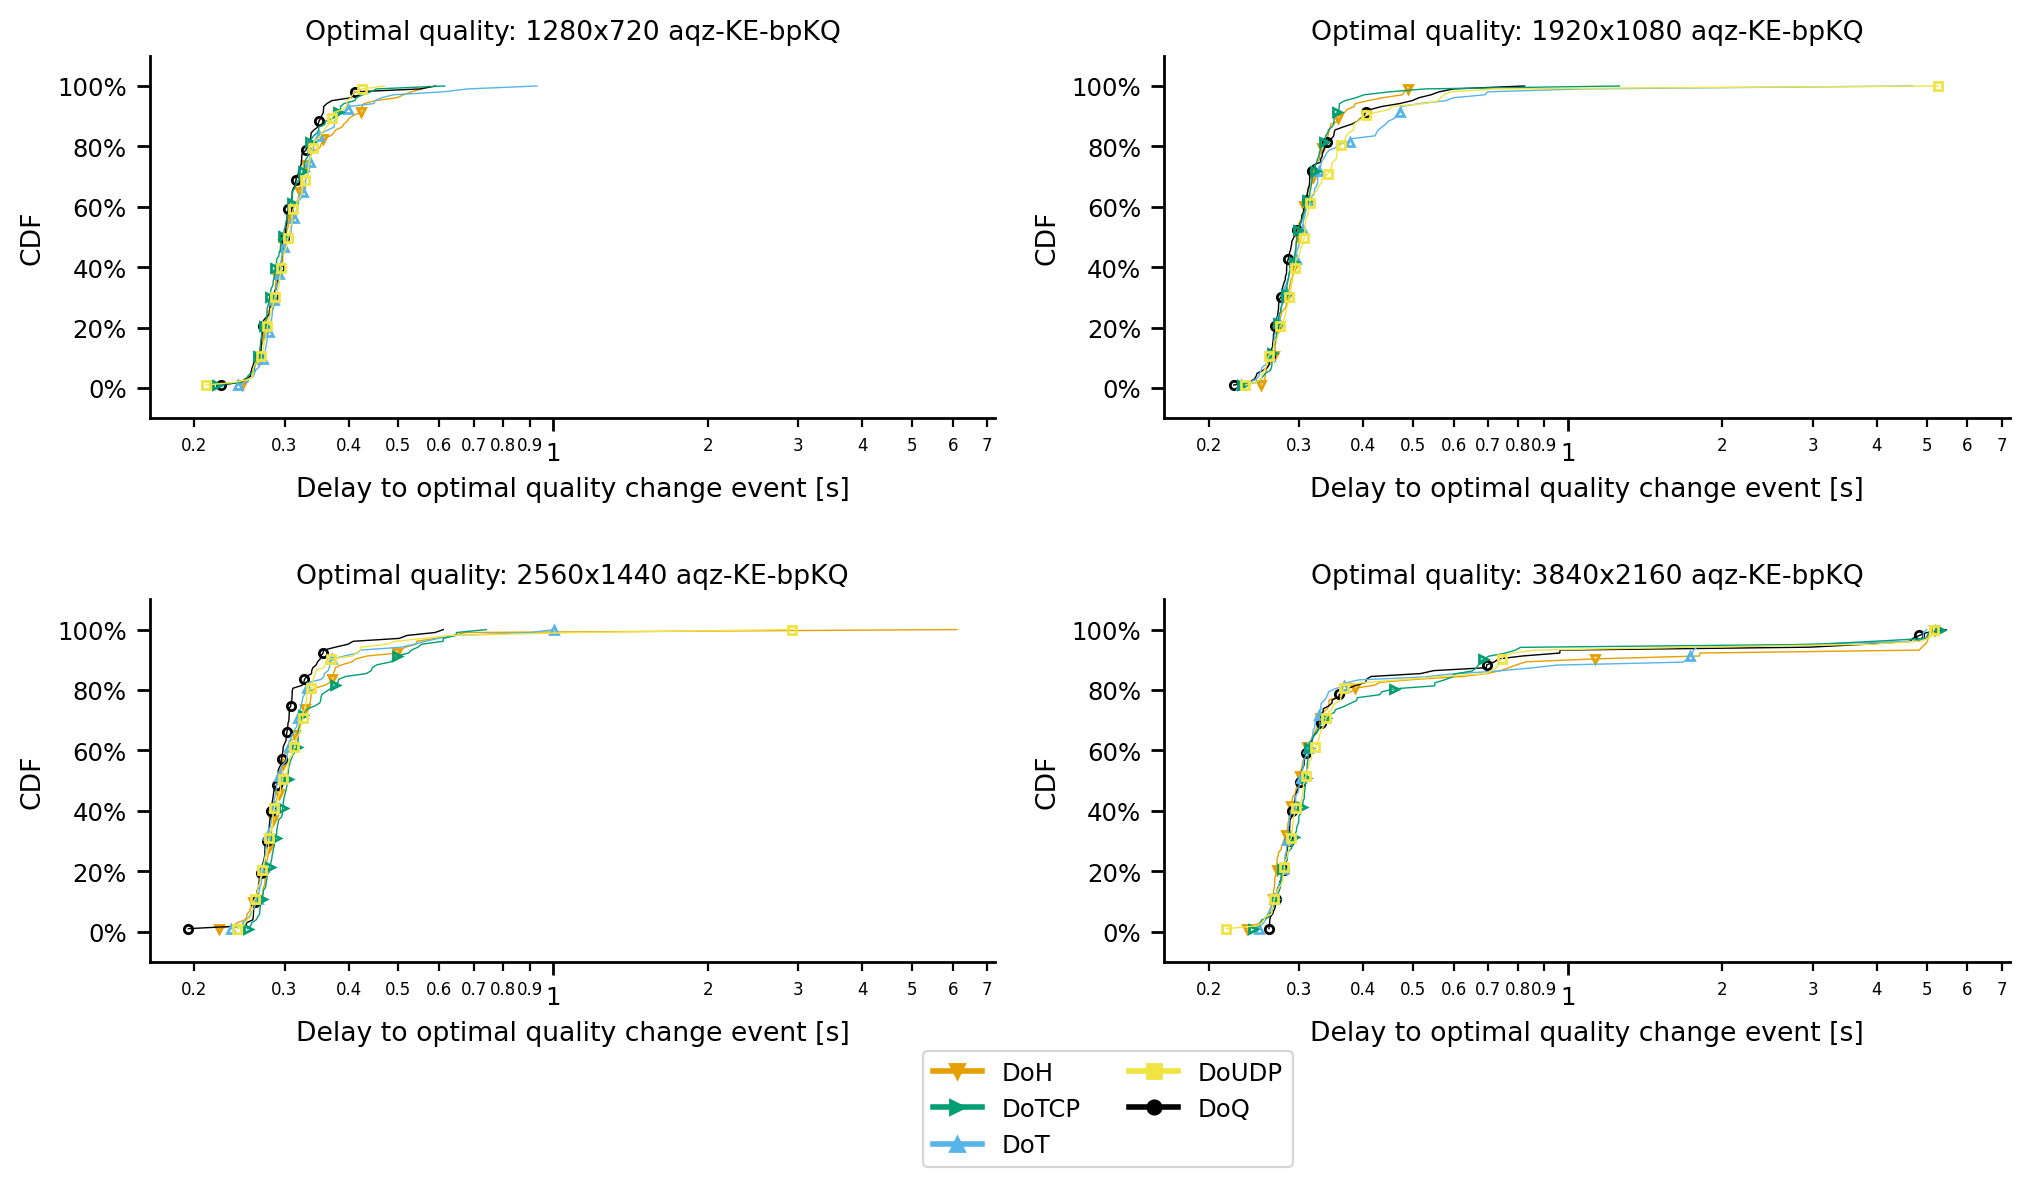

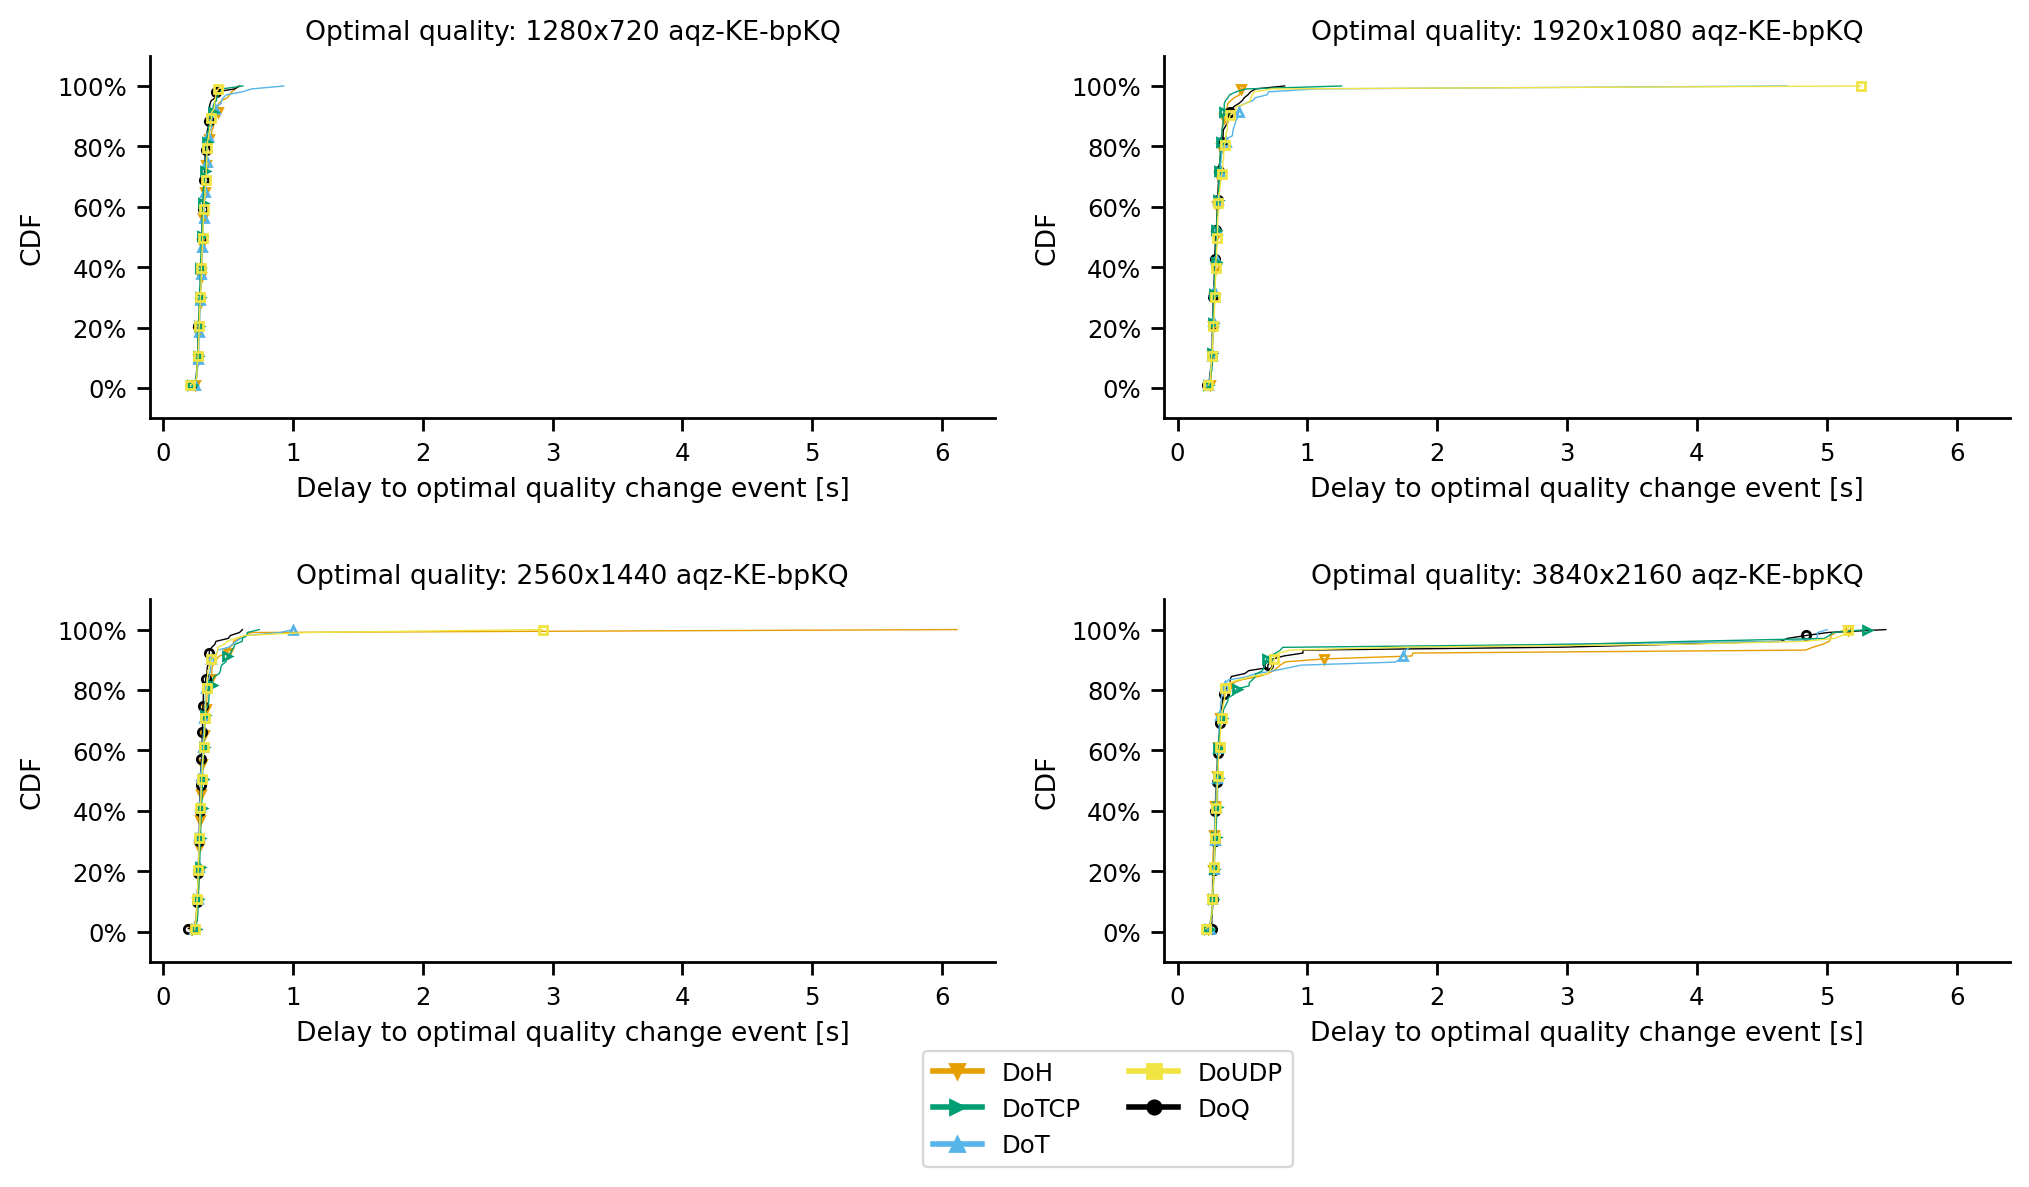

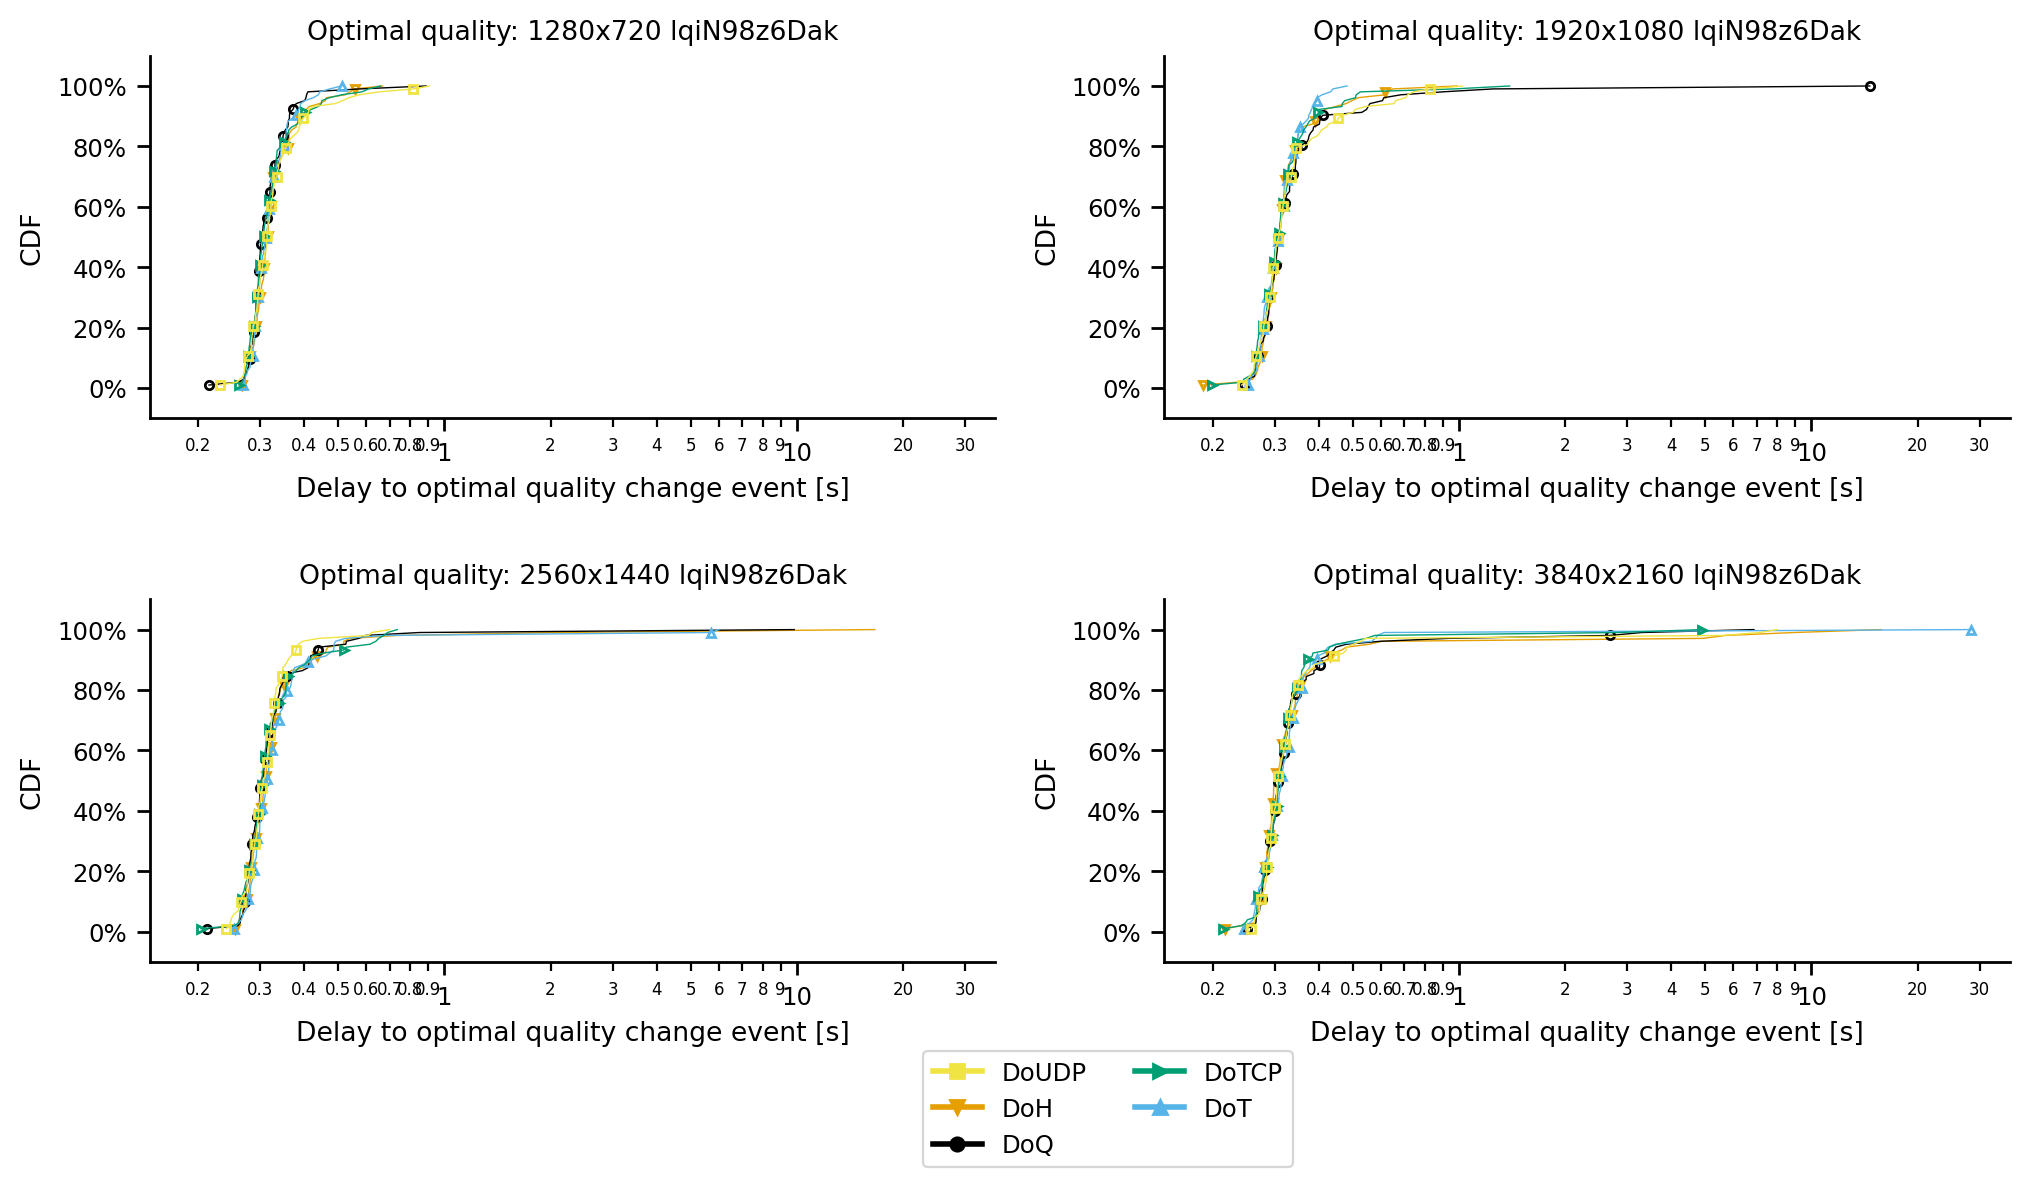

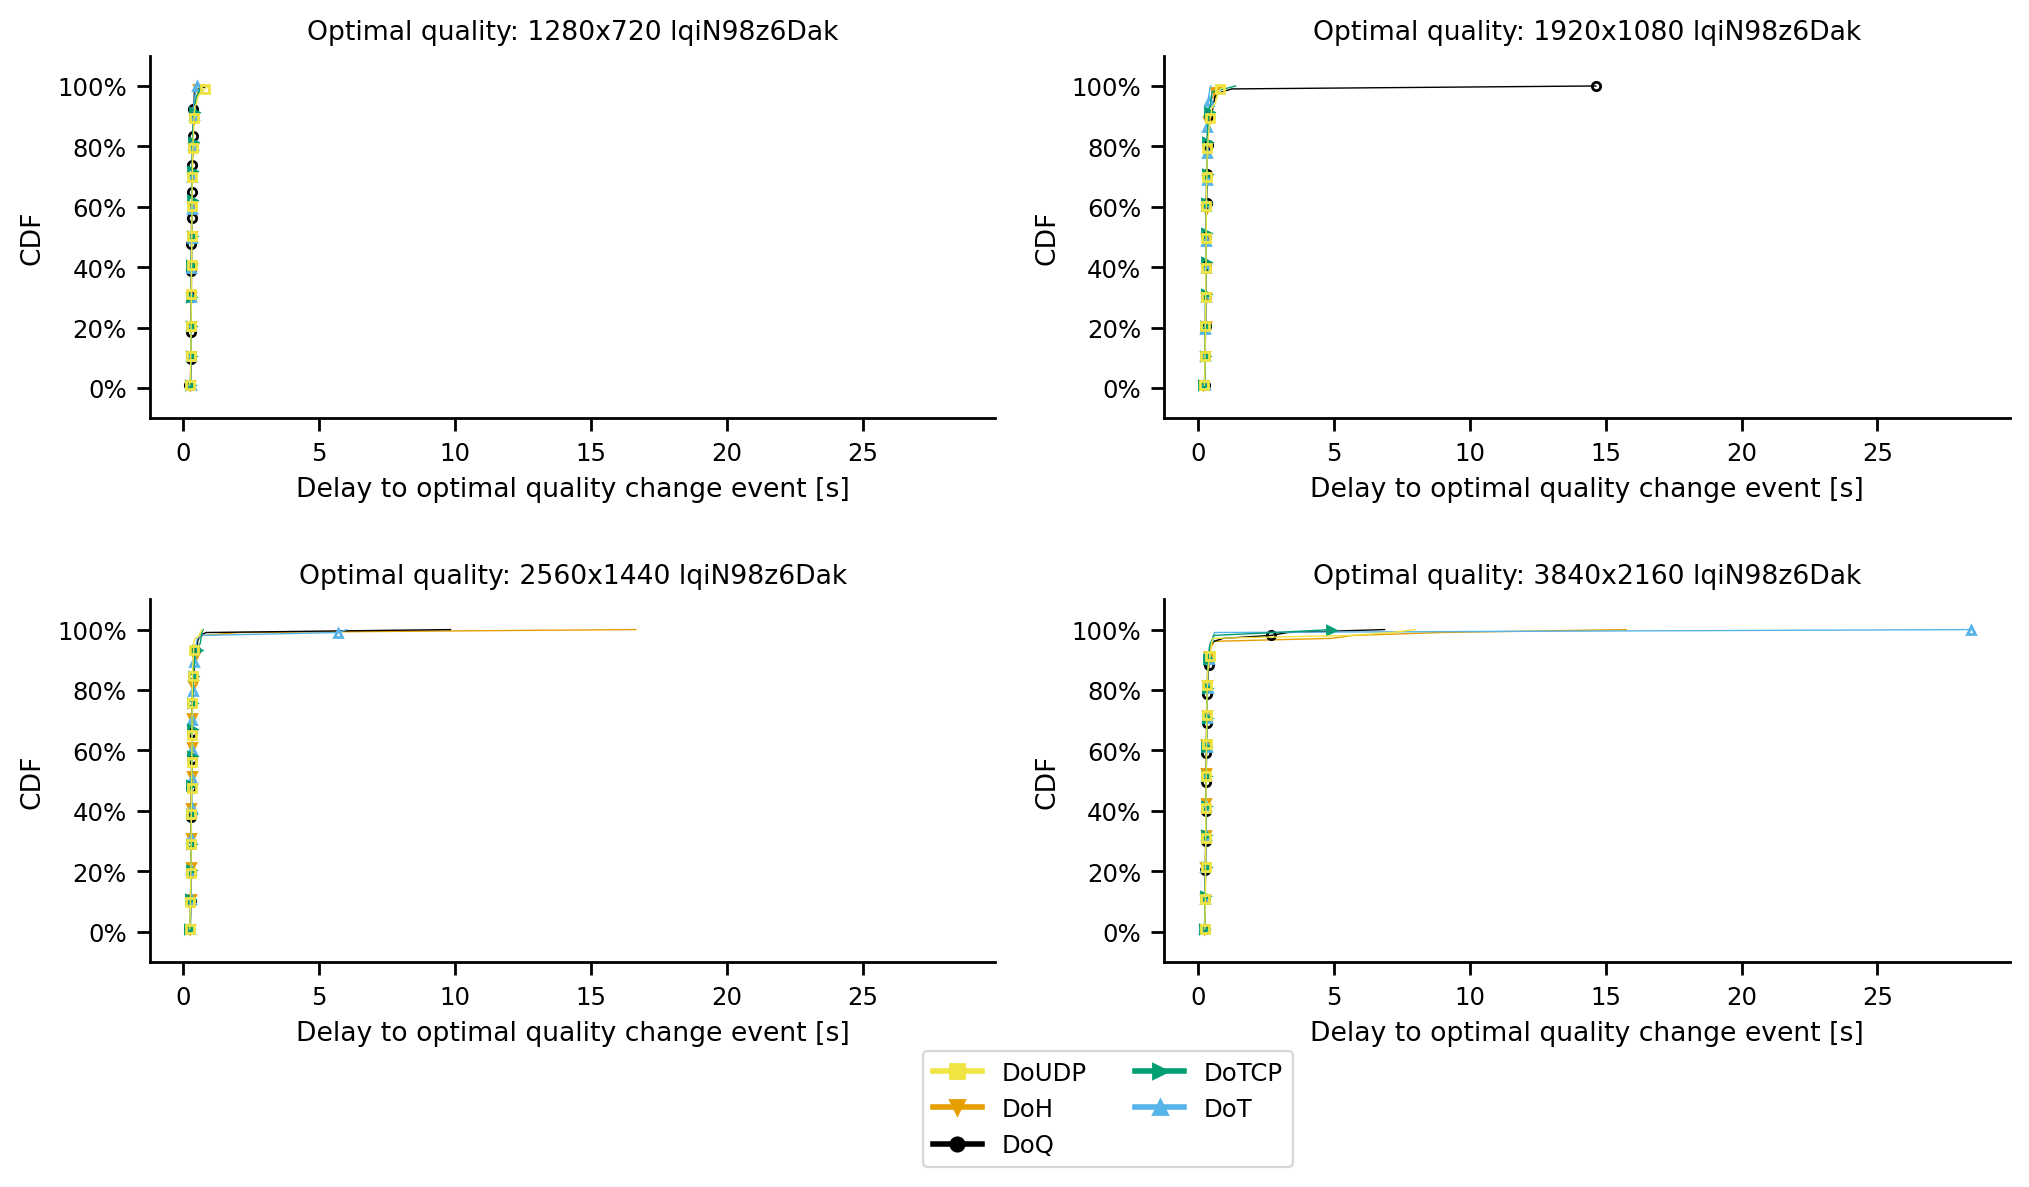

In [121]:
draw_cdf_grid(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

In [ ]:
draw_cdf(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True,False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0])

In [123]:
def draw_boxplot_grid(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    proto_order=['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    if col_name_ == 'protocol':
        y_order = proto_order
    else:
        y_order = sorted(df_[col_name_].unique().tolist())
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    num_rows = math.ceil(df_[col_outer_groupby_].nunique()/2)
                    if df_[col_outer_groupby_].nunique() > 1:
                        fig, axs = plt.subplots(num_rows, 2, sharex='all', figsize=(12,6*num_rows))#, sharey='all')
                        fig.subplots_adjust(hspace=.2, wspace=.3)
                        for col_grp_, ax in zip(df_[col_outer_groupby_].sort_values().unique(), axs.flat):
                        #for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                            lnwidth = .5
                            mrksize = 3
                            df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                            #hue=
                            
                            boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                            showfliers=False, order=y_order,
                            color='white',
                            meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                            sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=1.5, order=y_order)
                            
                            if log:
                                ax.set_xscale('log')
                            
                            
                            ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))
                            ax.tick_params(axis='x', which='minor', labelsize=6)
                            ax.xaxis.set_tick_params(labelbottom=True, which='both')


                            ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                            ax.set_xlabel(xlabel)

                            ax.set_ylabel(ylabel)
                            if xlim != [0,0]:
                                ax.set_xlim(xlim)

                            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                            ax.grid(b=True, which='both')


                        if log:
                            fig.savefig('figures/boxplot-'+figname+'-grid-'+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        else:
                            fig.savefig('figures/boxplot-'+figname+'-grid-'+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        plt.show()

In [124]:
def draw_boxplot(df_, col_outer_groupby_, col_name_, col_metric_, log_list, xlabel, title, figname, xlim, ylabel):
    proto_order=['DoQ', 'DoH', 'DoT', 'DoTCP', 'DoUDP']
    if col_name_ == 'protocol':
        y_order = proto_order
    else:
        y_order = sorted(df_[col_name_].unique().tolist())
    with plt.style.context('seaborn-whitegrid'):
        for vp in df_['vantagePoint'].unique():
            print(vp)
            for video in df_['domain'].unique():
                for log in log_list:
                    for col_grp_ in df_[col_outer_groupby_].sort_values().unique():
                        lnwidth = .5
                        mrksize = 3
                        df_tmp = df_[(df_[col_outer_groupby_]==col_grp_)&(df_['vantagePoint'] == vp) & (df_['domain'] == video)]
                        fig, ax = plt.subplots(figsize=(6,8))
                        #hue=
                        boxplt = sns.boxplot(x=col_metric_, y=col_name_ , data=df_tmp, orient='h', linewidth=1, ax=ax, 
                        showfliers=False, order=y_order,
                        color='white',
                        meanline = True, showmeans = True, meanprops=dict(color='darkgoldenrod'), medianprops=dict(color='blue'))
                        sw = sns.swarmplot(x=col_metric_, y=col_name_, data=df_tmp, color=".25", ax=ax, orient='h', size=1.5, order=y_order)
                        
                        if log:
                            ax.set_xscale('log')
                        
                        
                        ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:g}"))
                        #ax.xaxis.set_minor_formatter(ticker.StrMethodFormatter("{x:g}"))


                        ax.set_title(title+ ' ' + col_grp_ + ' ' + video)

                        ax.set_xlabel(xlabel)

                        ax.set_ylabel(ylabel)
                        if xlim != [0,0]:
                            ax.set_xlim(xlim)

                        ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
                        ax.grid(b=True, which='both')


                        if log:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'-log.pdf', format='pdf', bbox_inches='tight')
                        else:
                            fig.savefig('figures/boxplot-'+figname+col_grp_+video+vp+'.pdf', format='pdf', bbox_inches='tight')
                        #plt.show()

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 9.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 15.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home

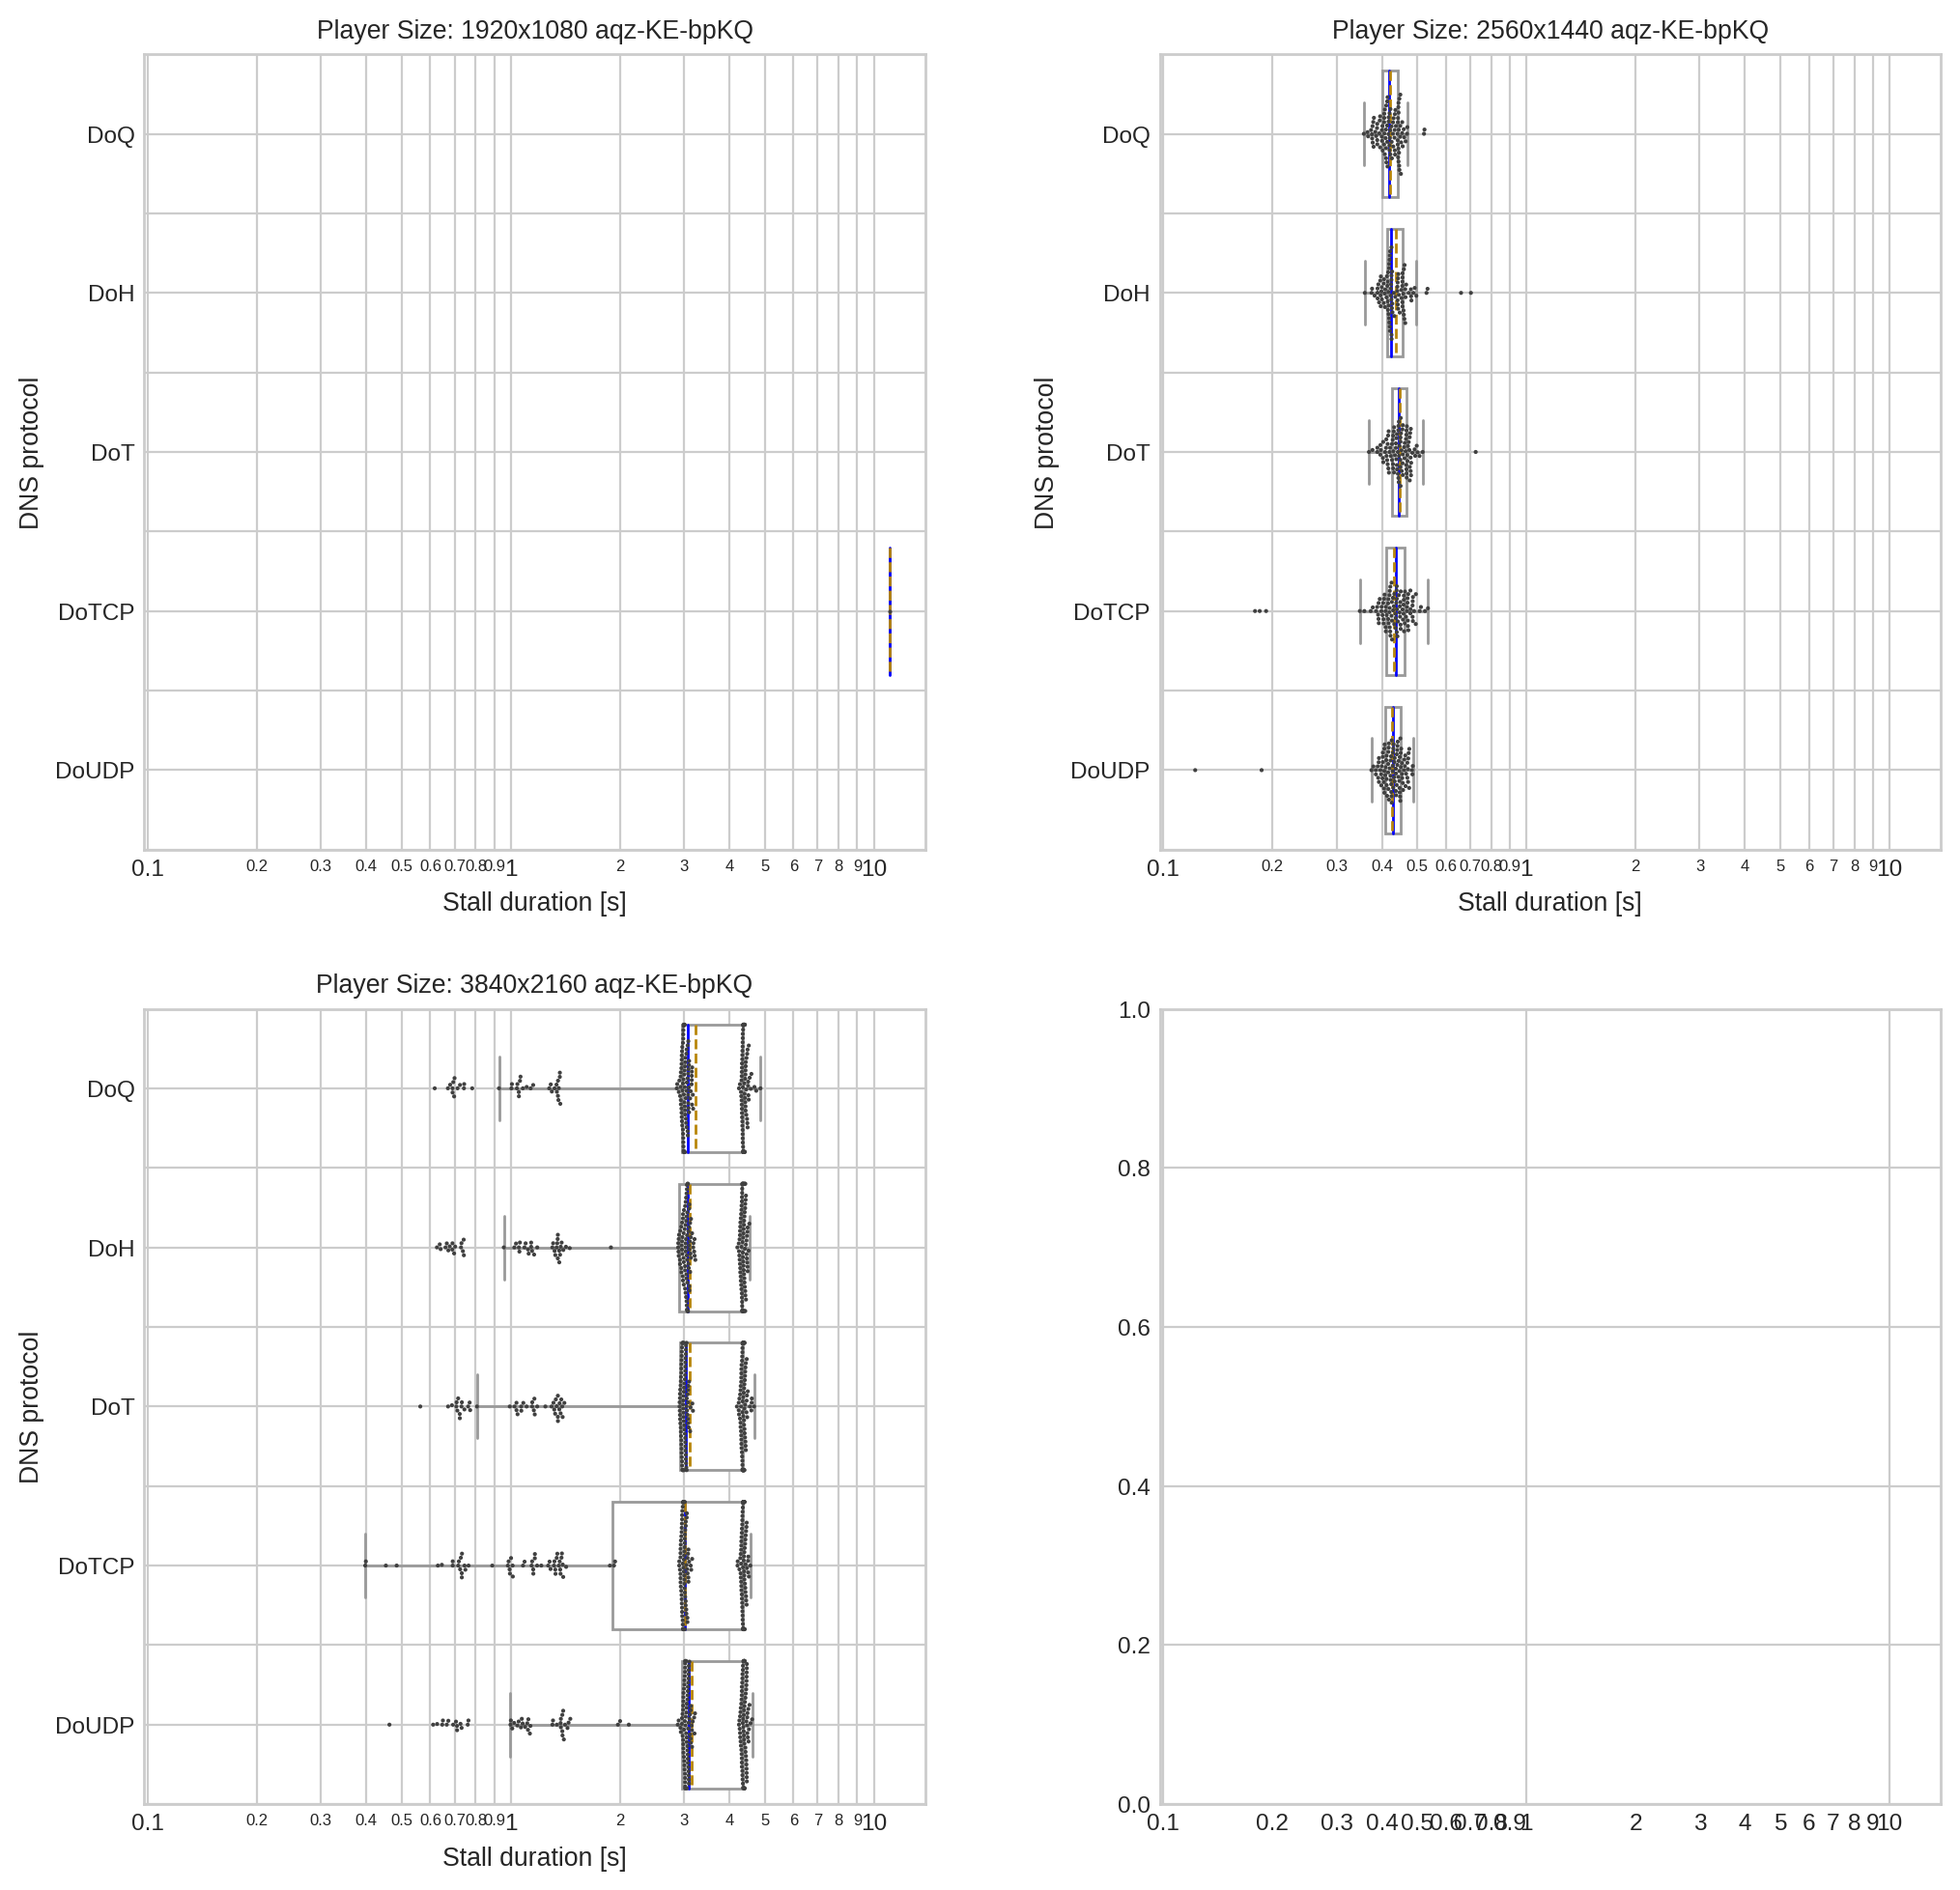

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 36.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 28.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

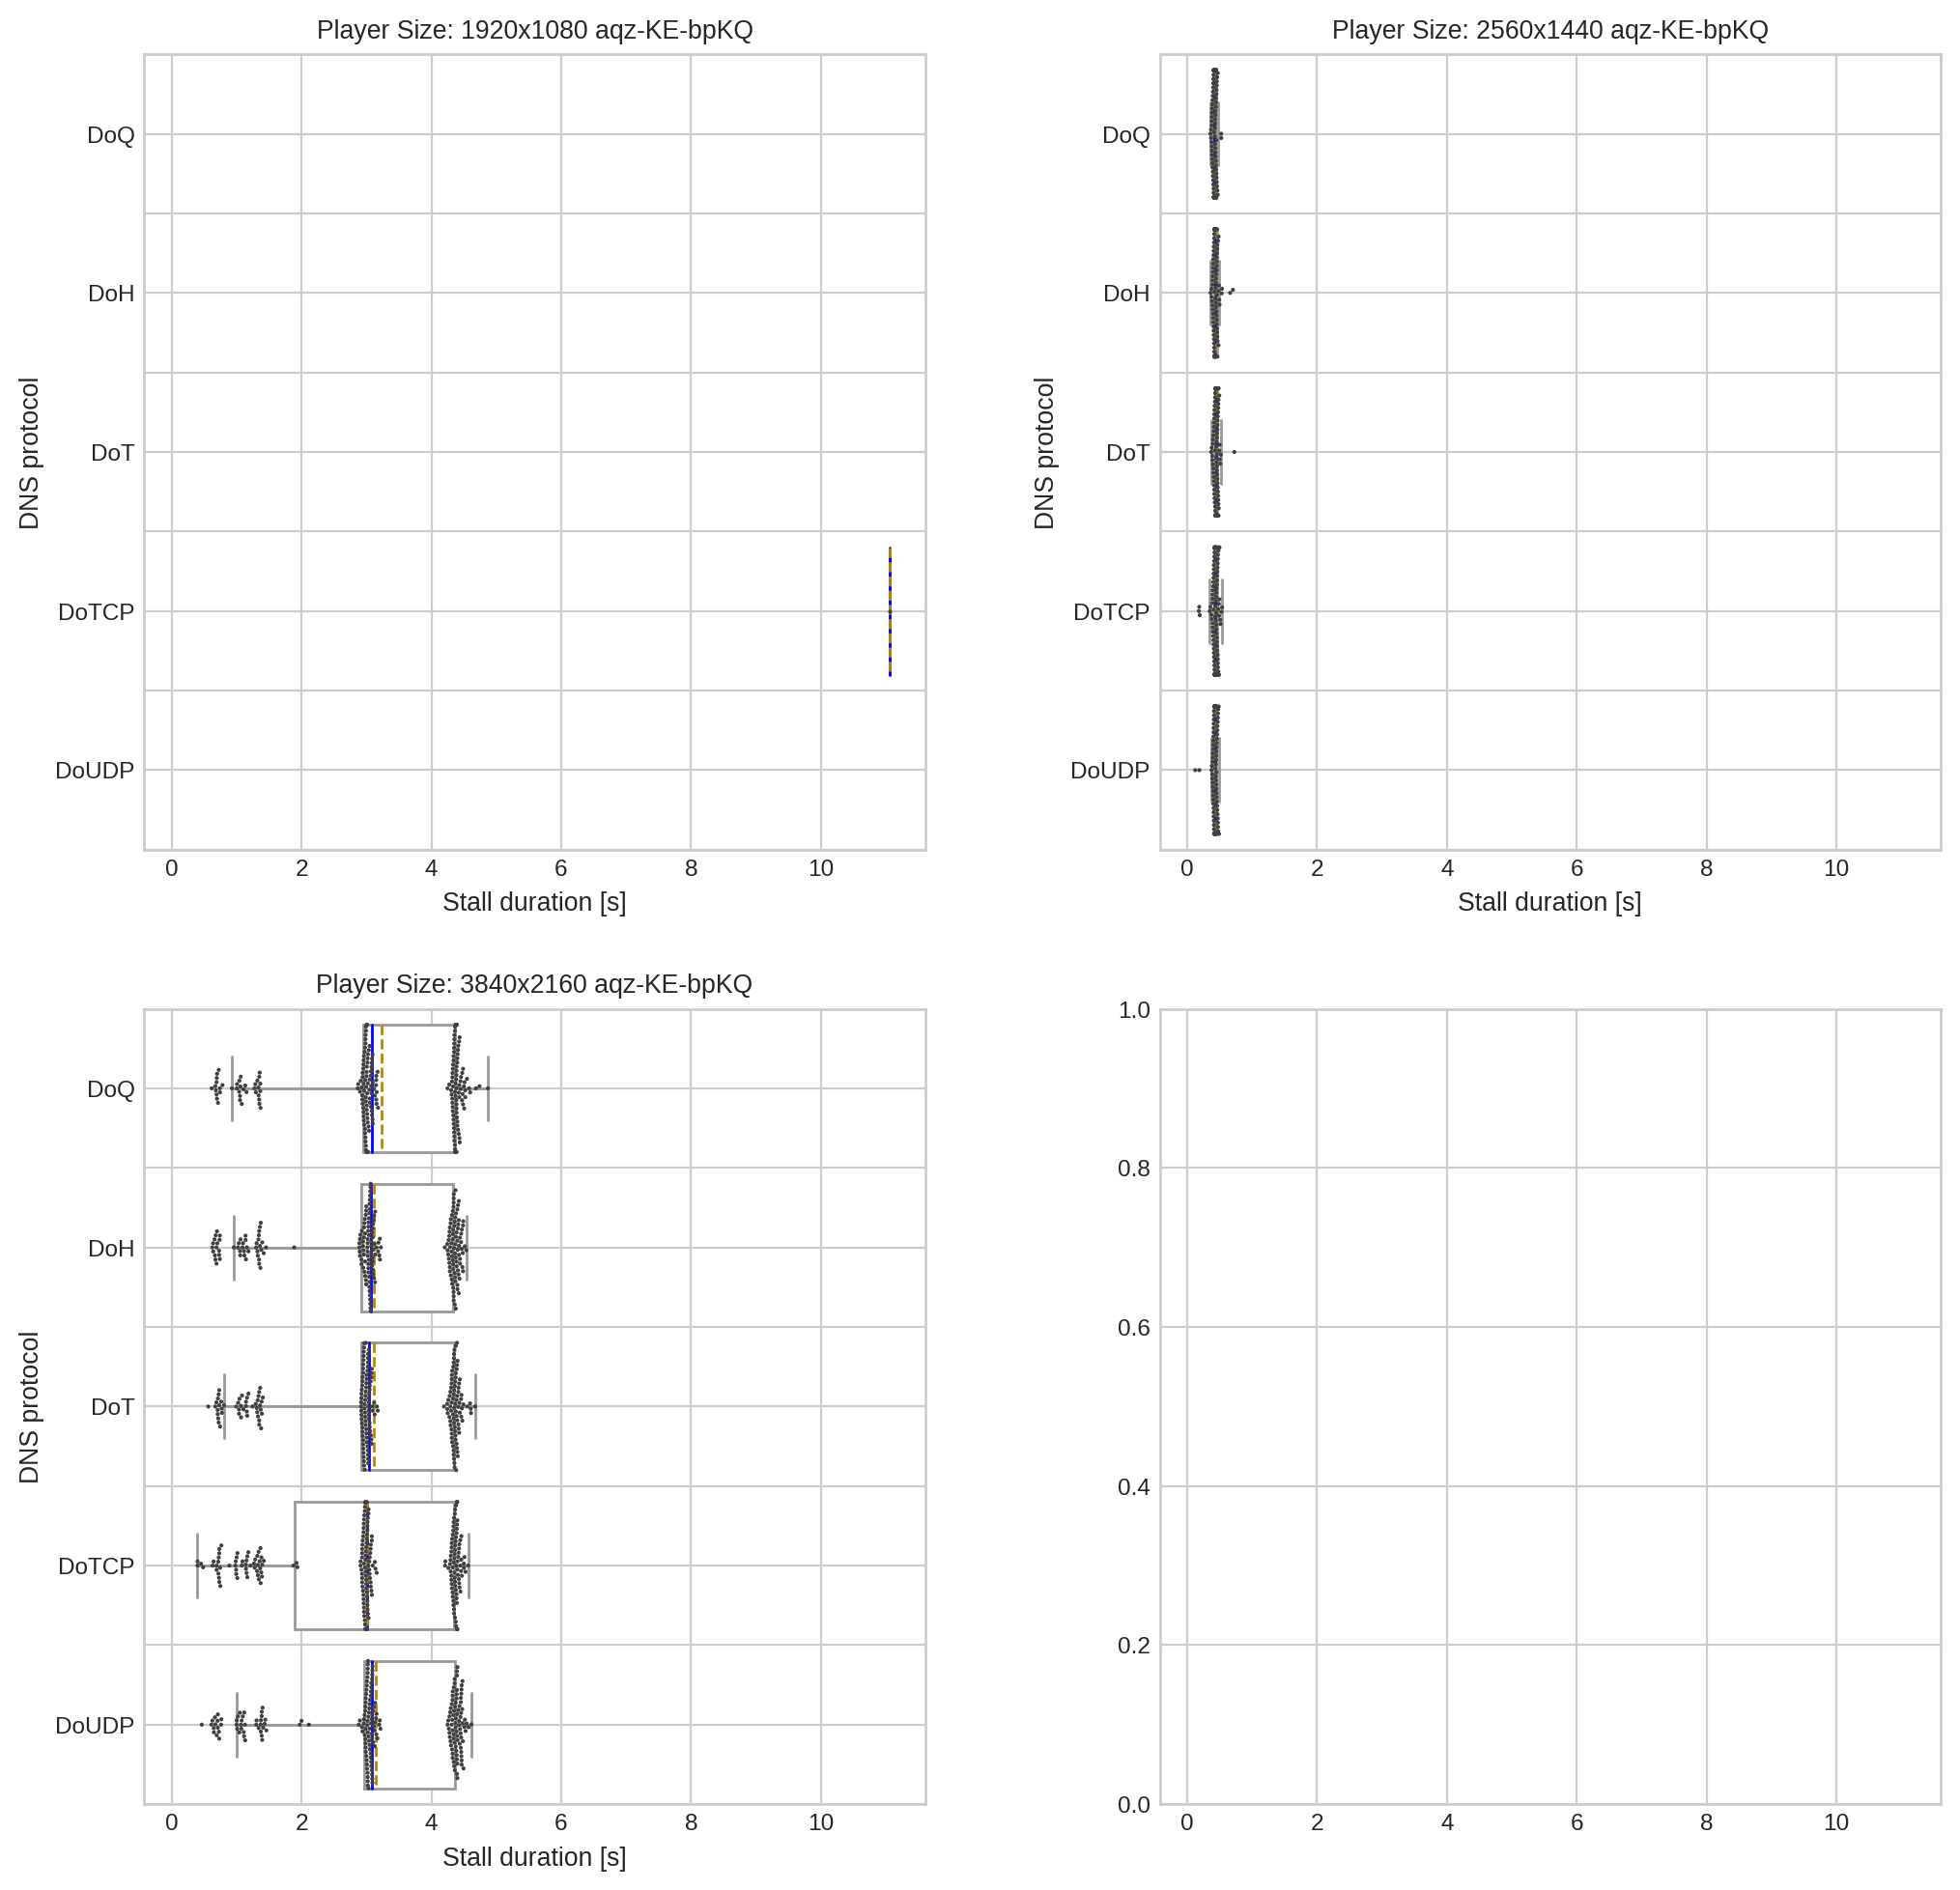

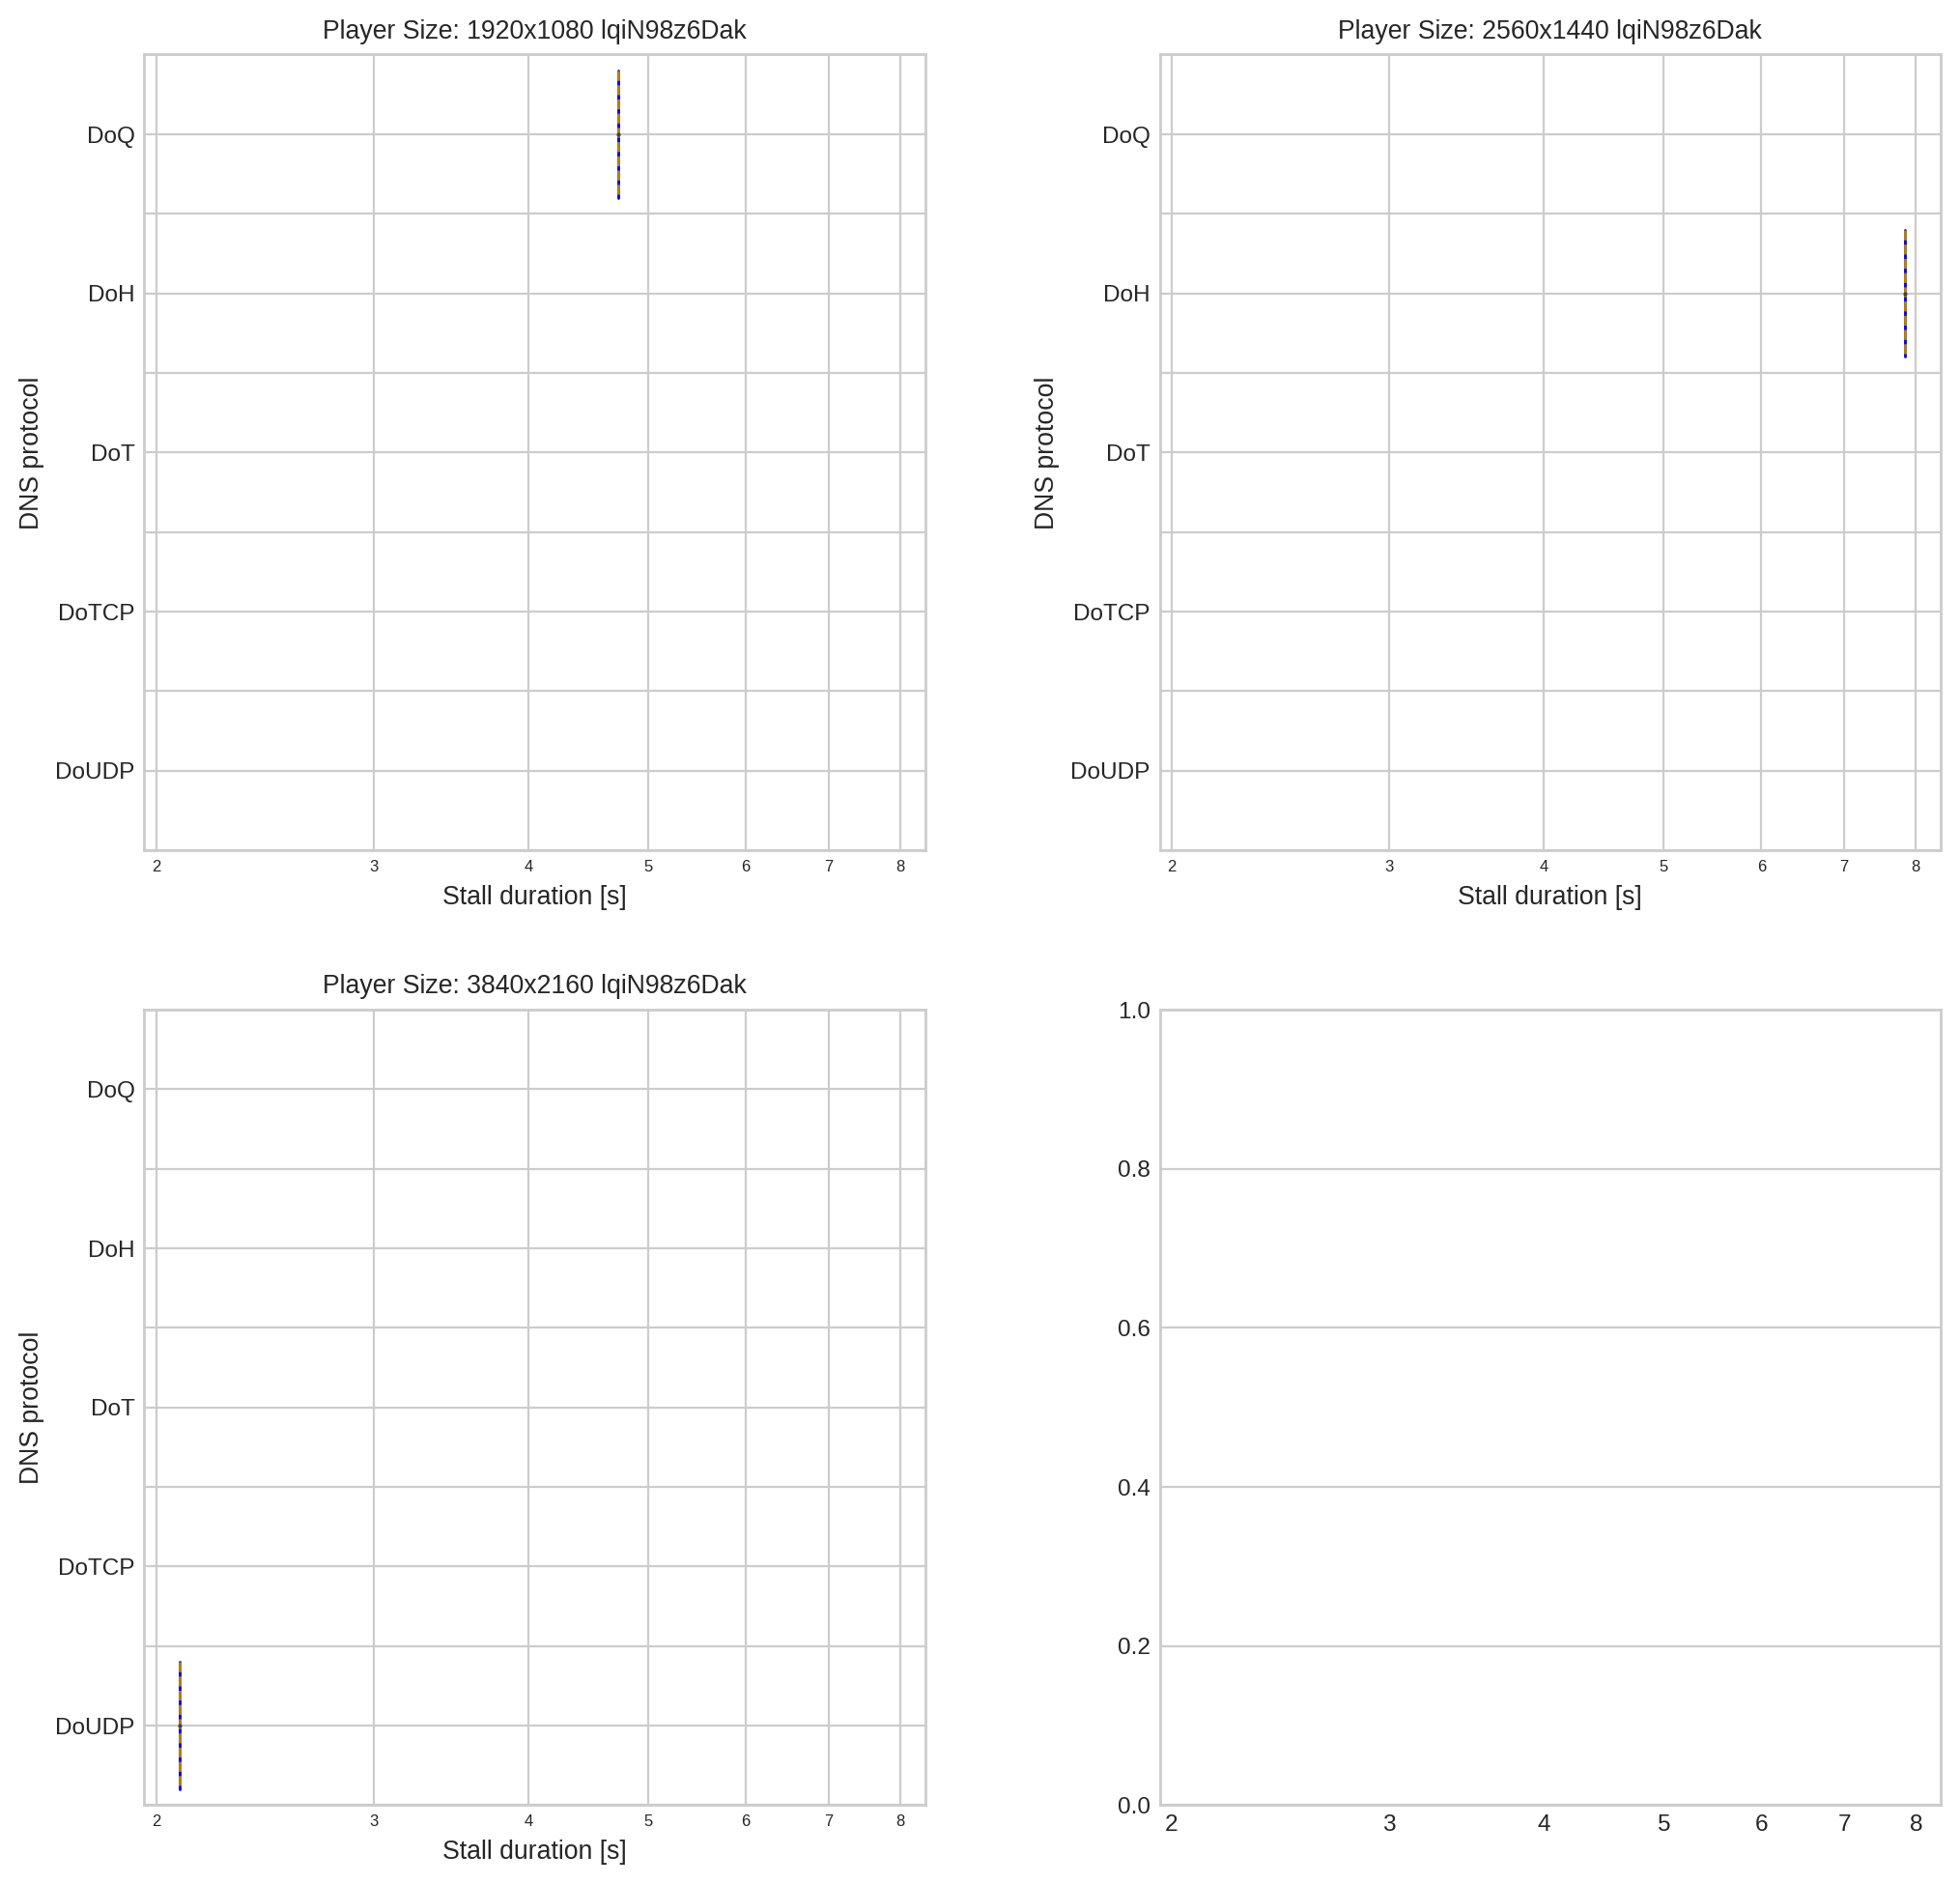

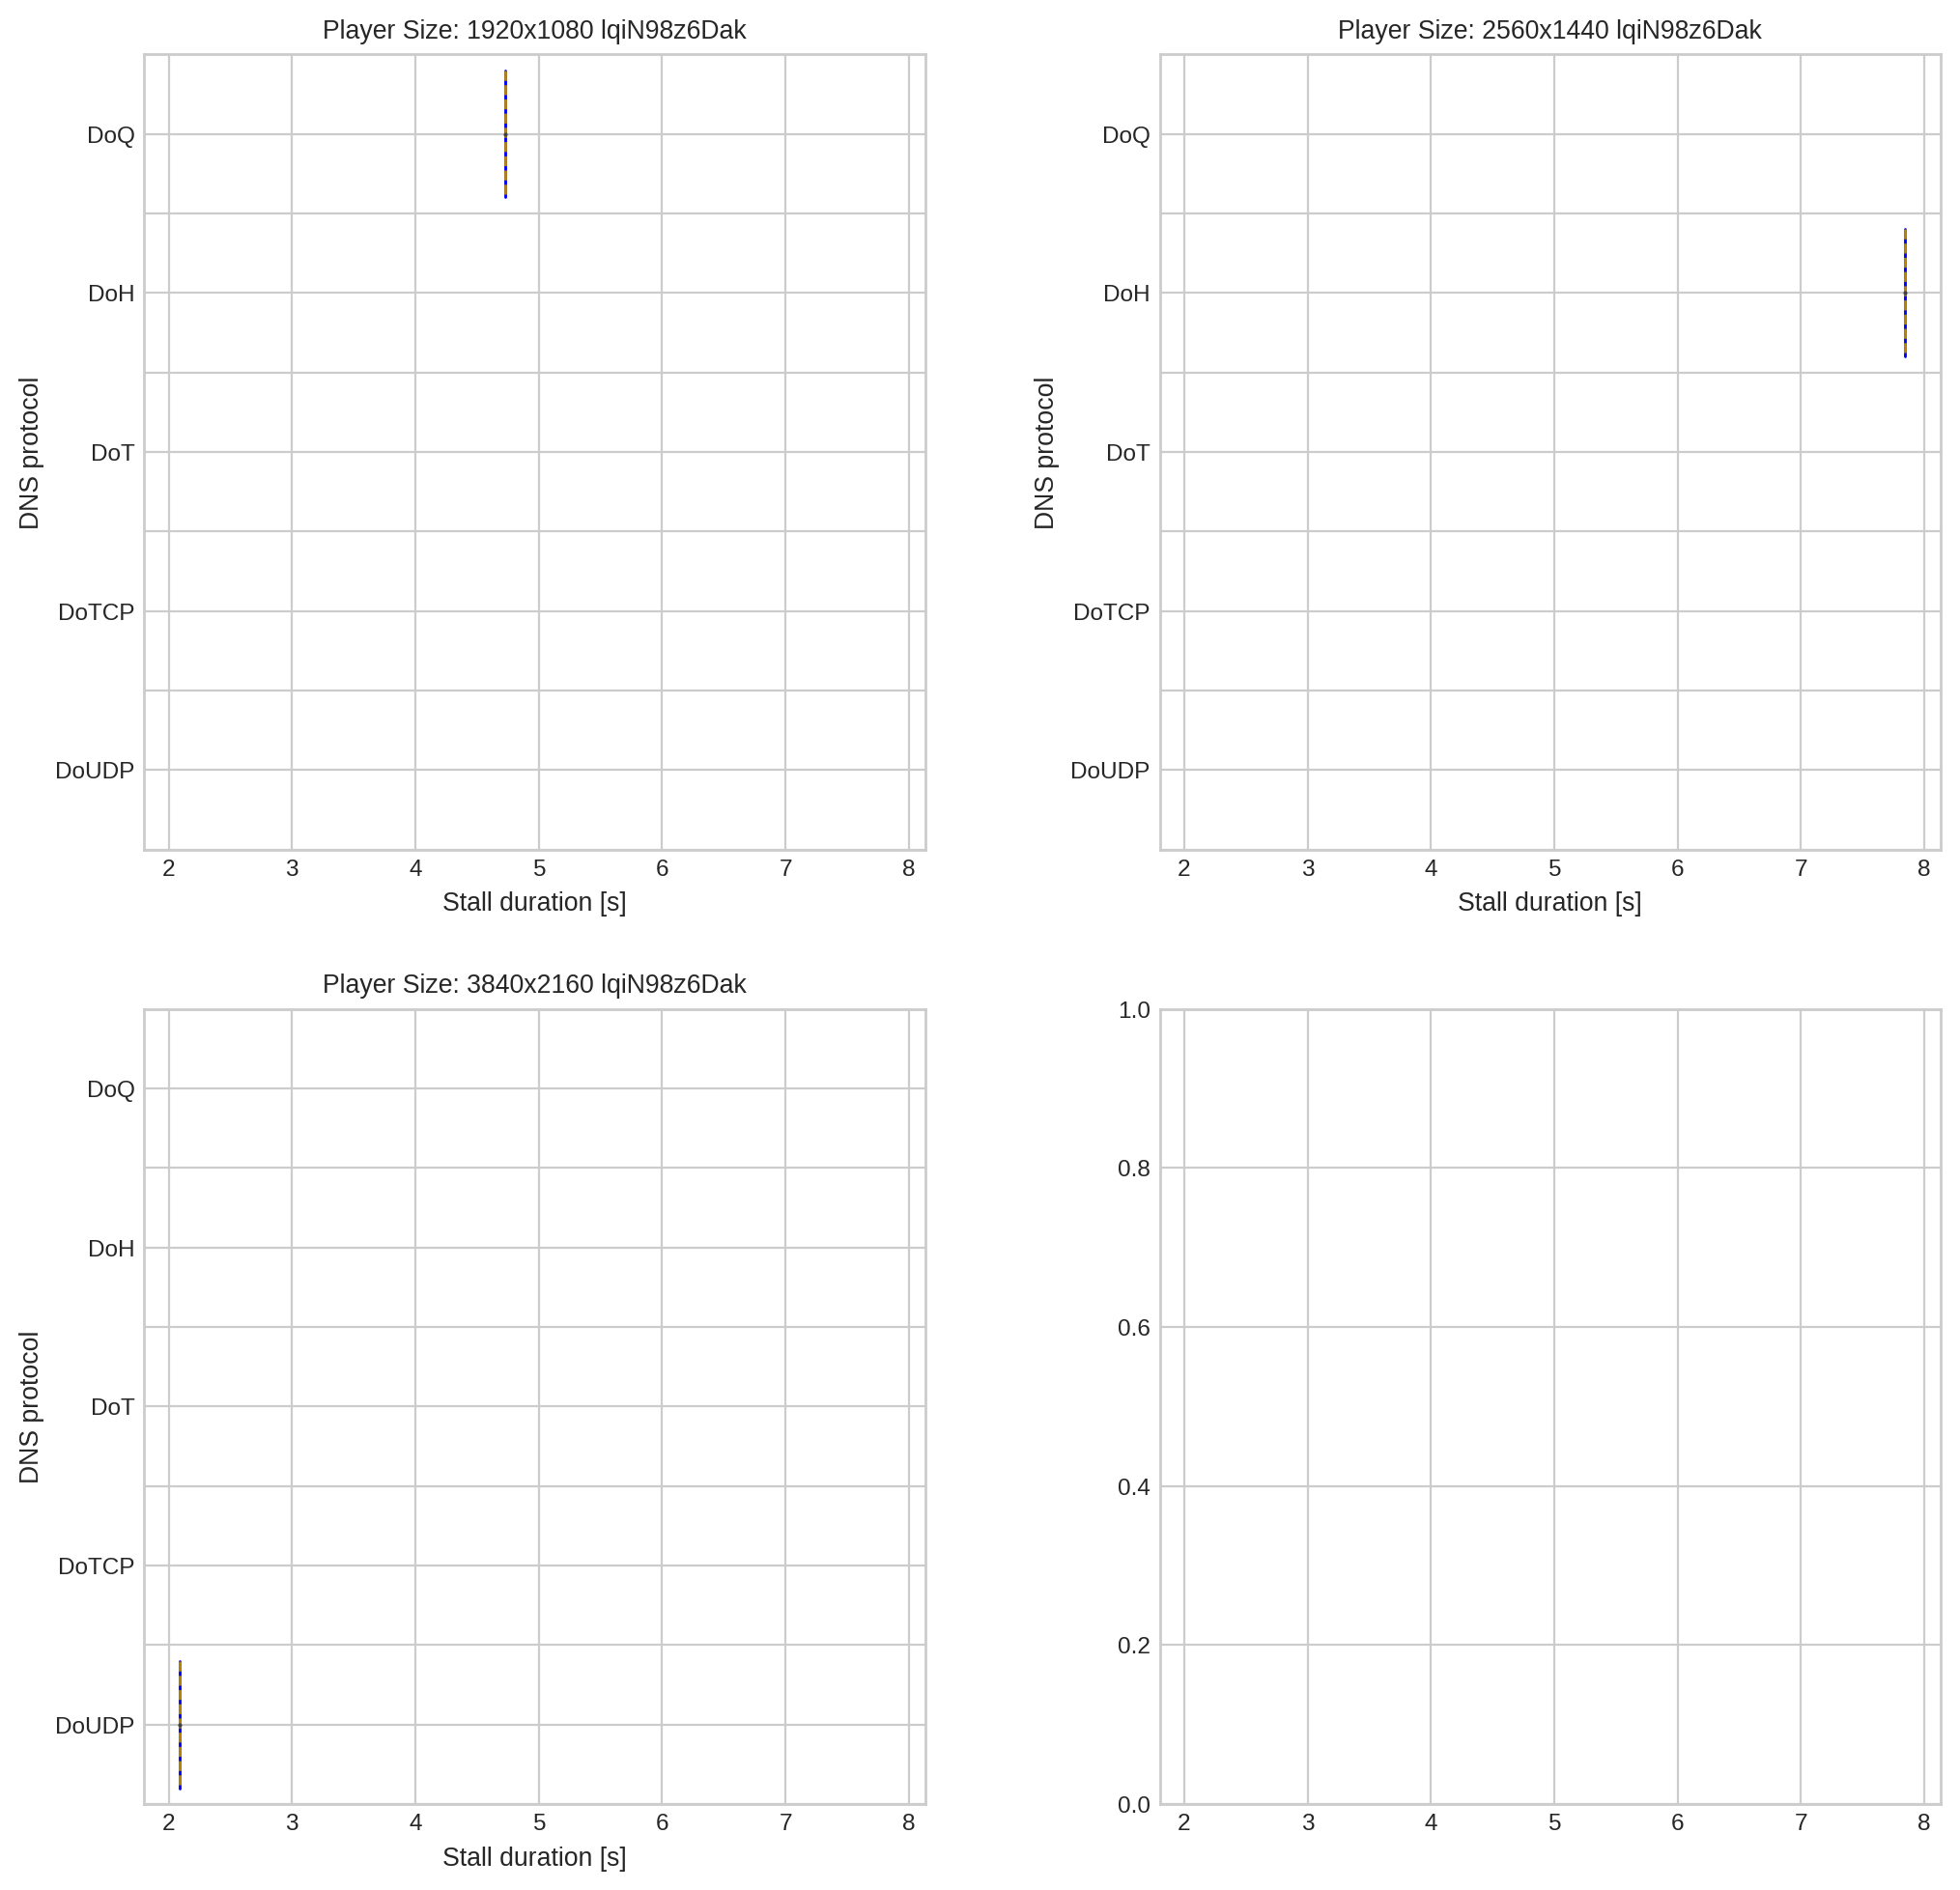

In [125]:
draw_boxplot_grid(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [True,False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_stall_times, 'player_dimensions', 'protocol', 'stall_time', [False], 'Stall duration [s]', 'Player Size:', 'stall-durations-by-player-size-and-proto', [0,0], "DNS protocol")

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 64.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 61.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

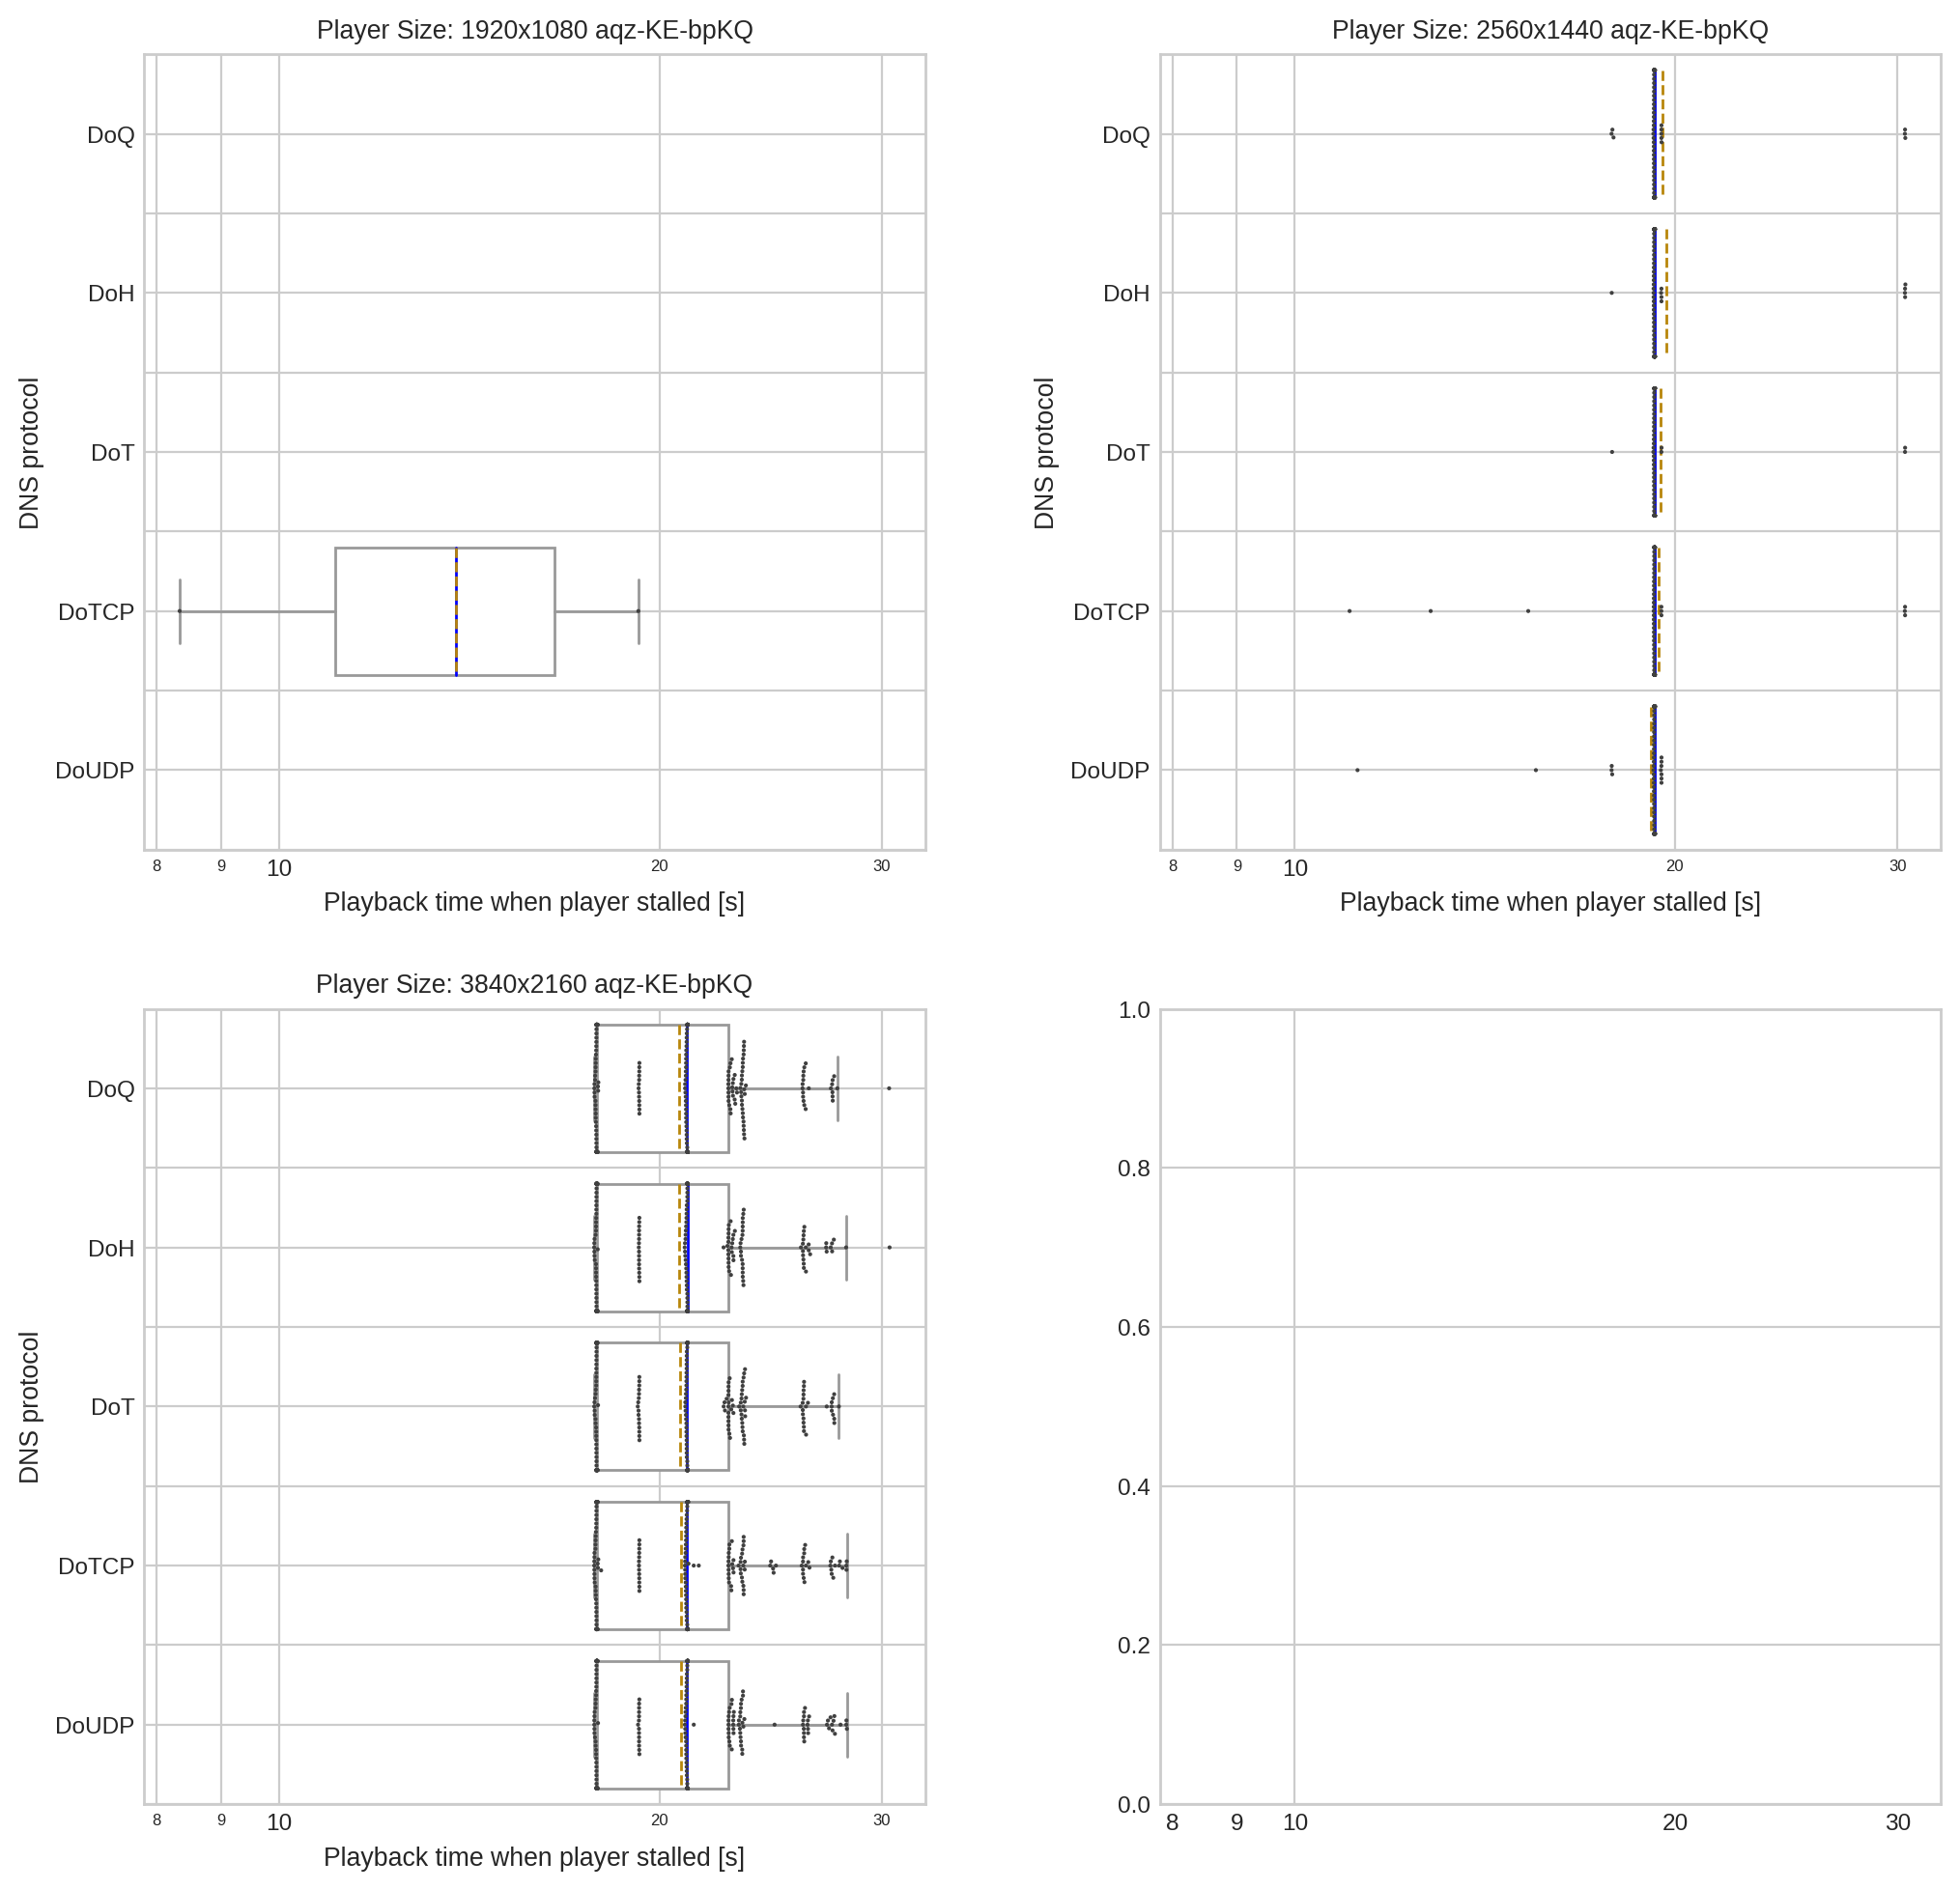

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 58.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 60.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 64.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 61.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

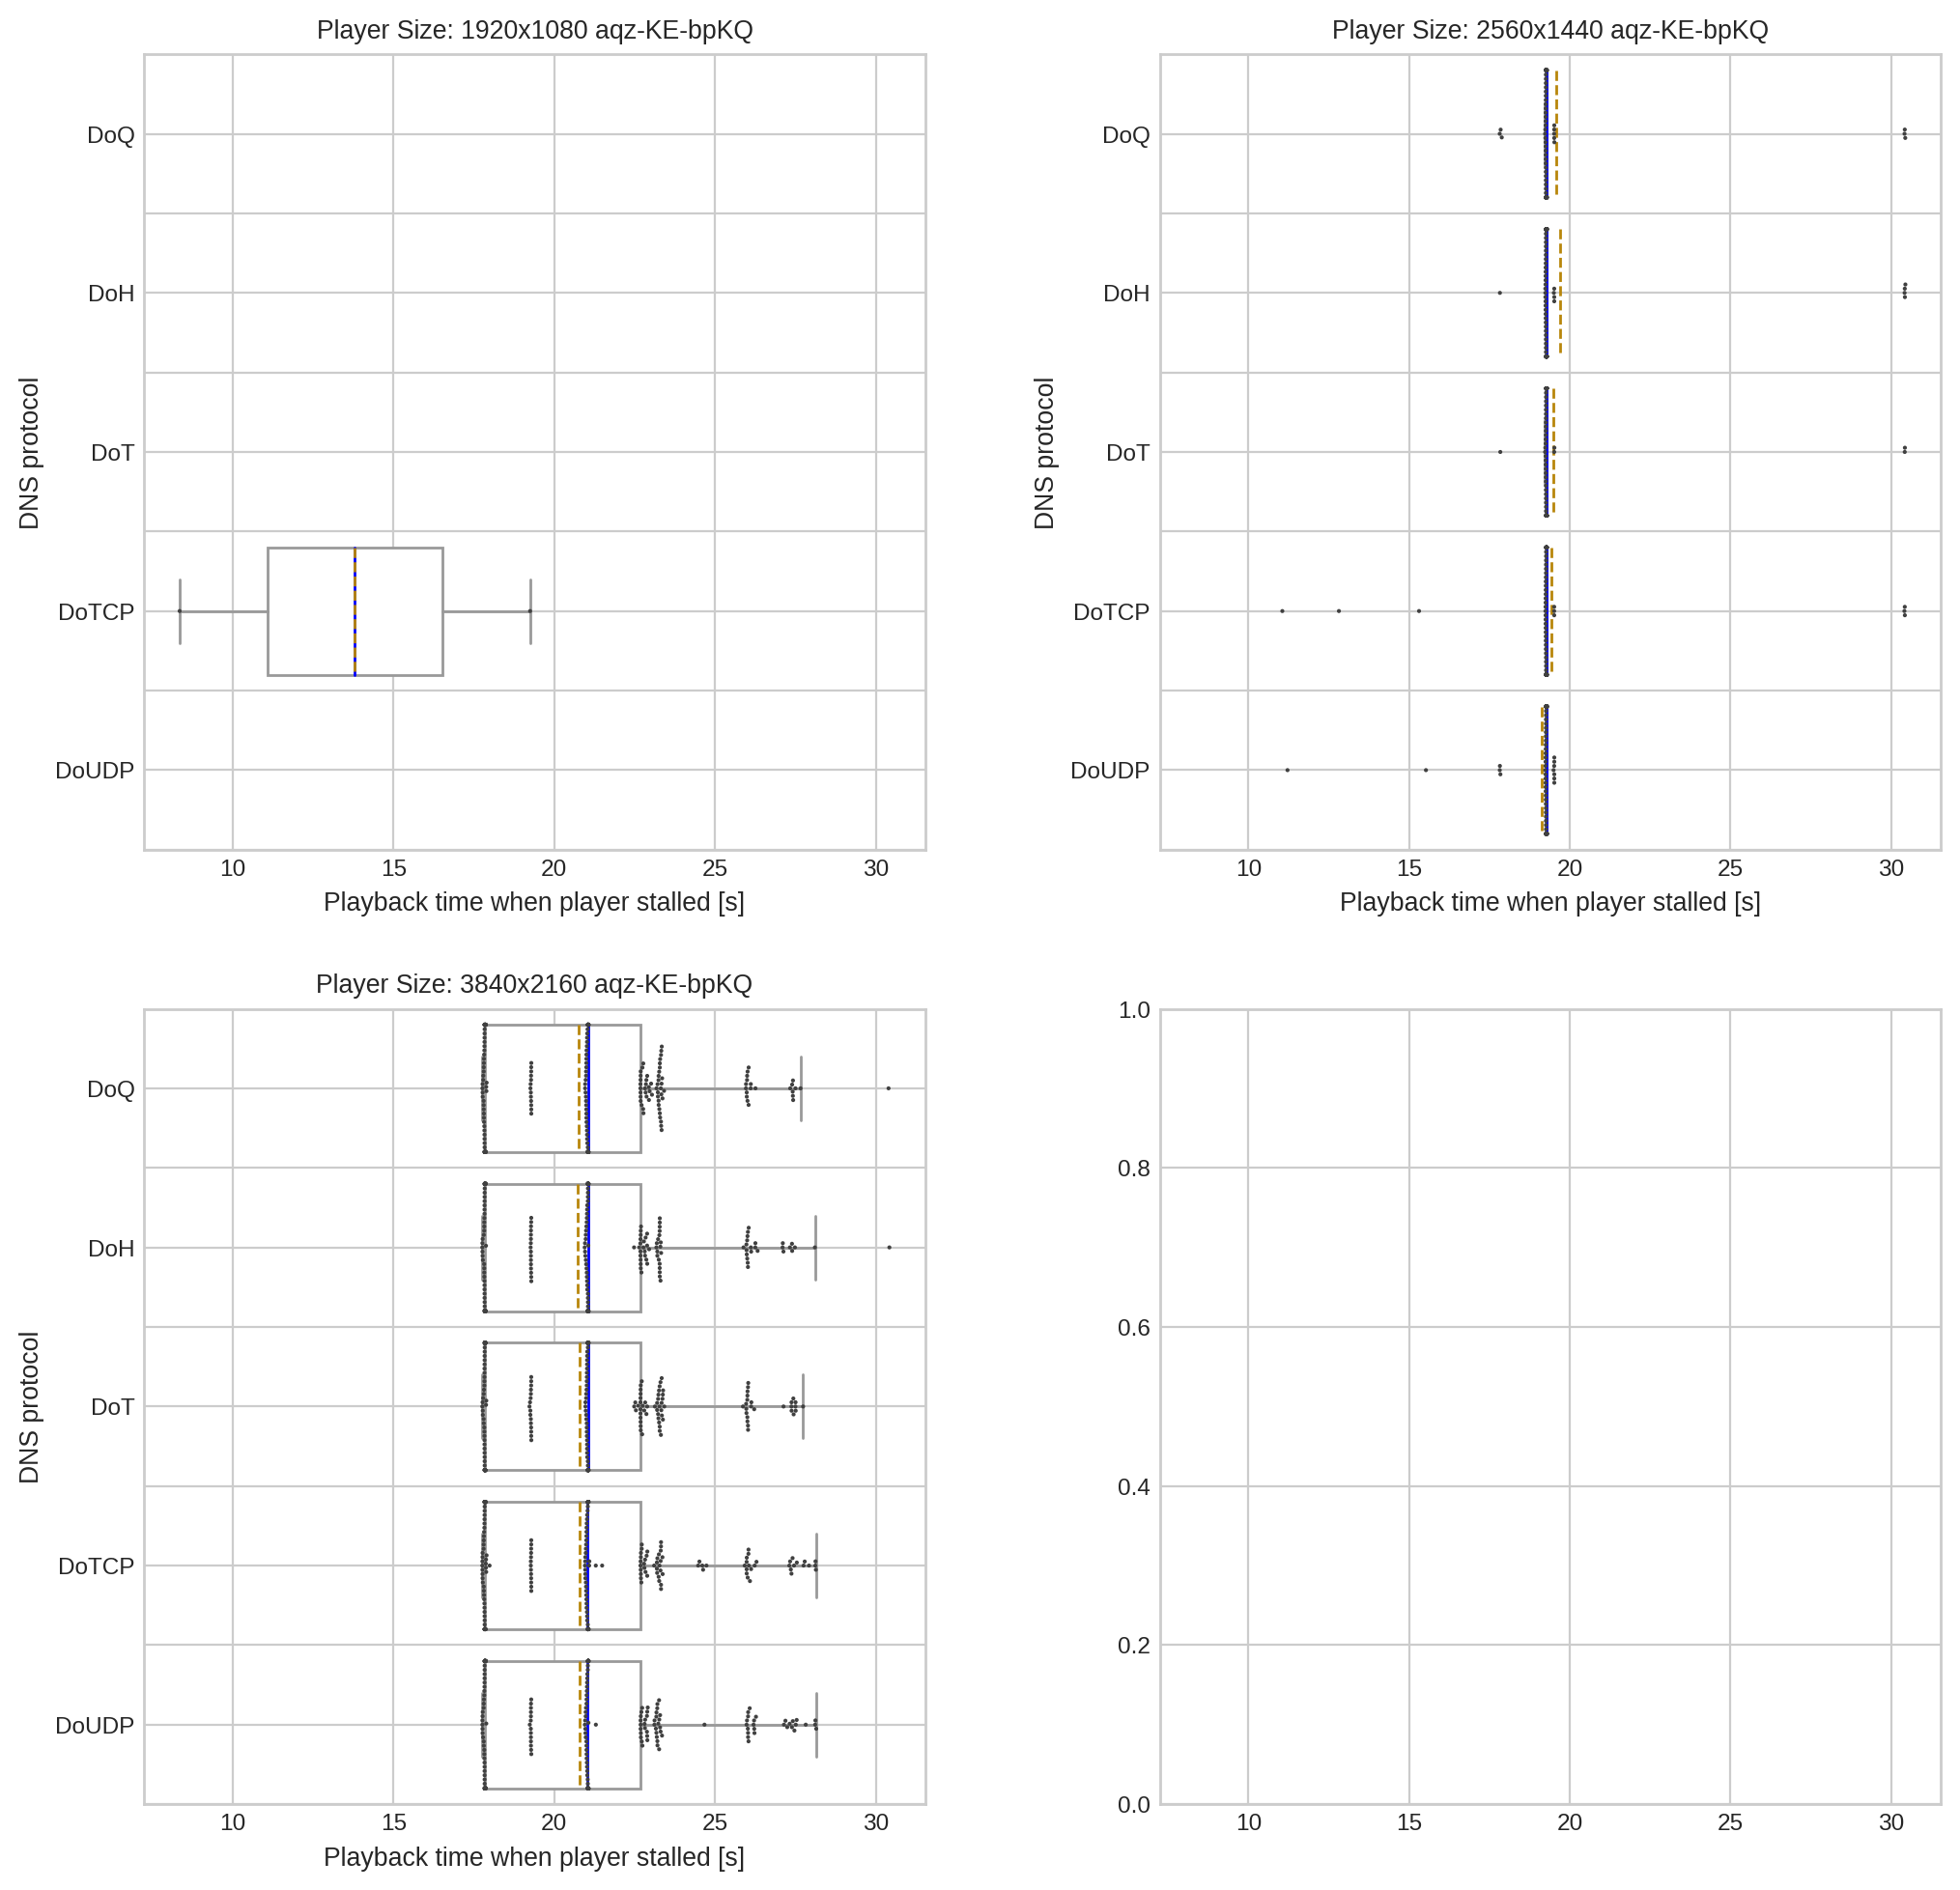

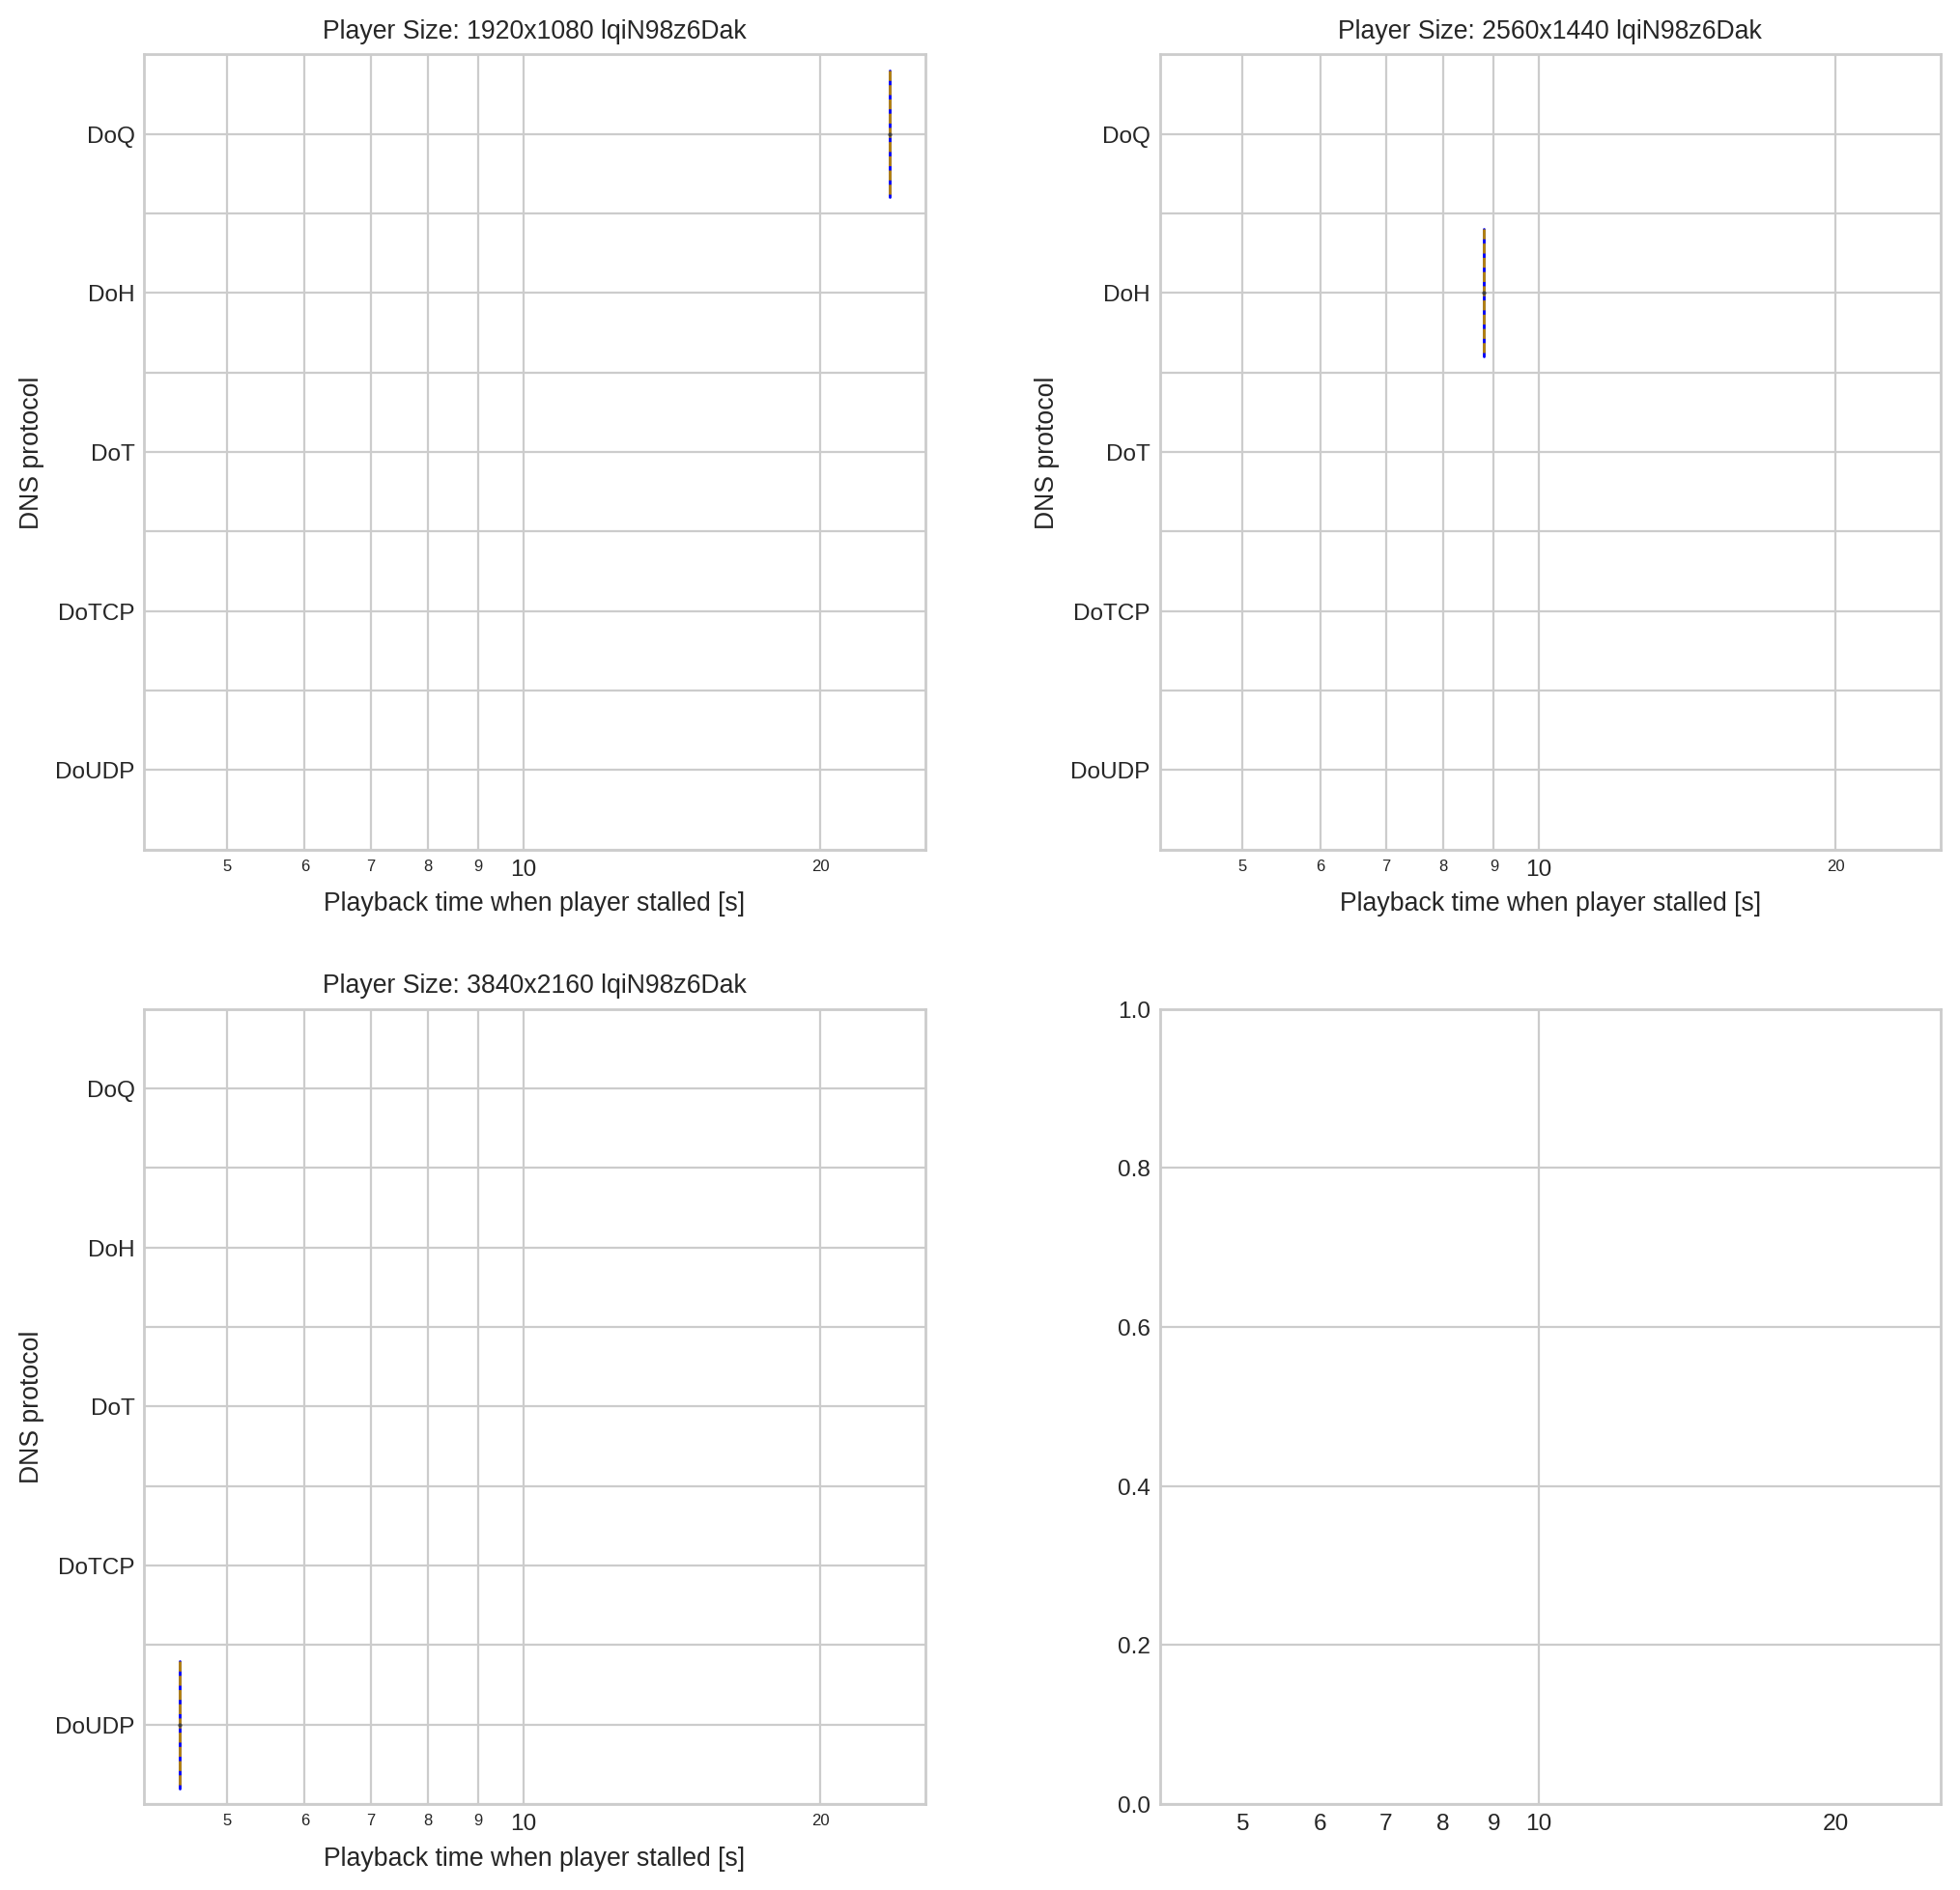

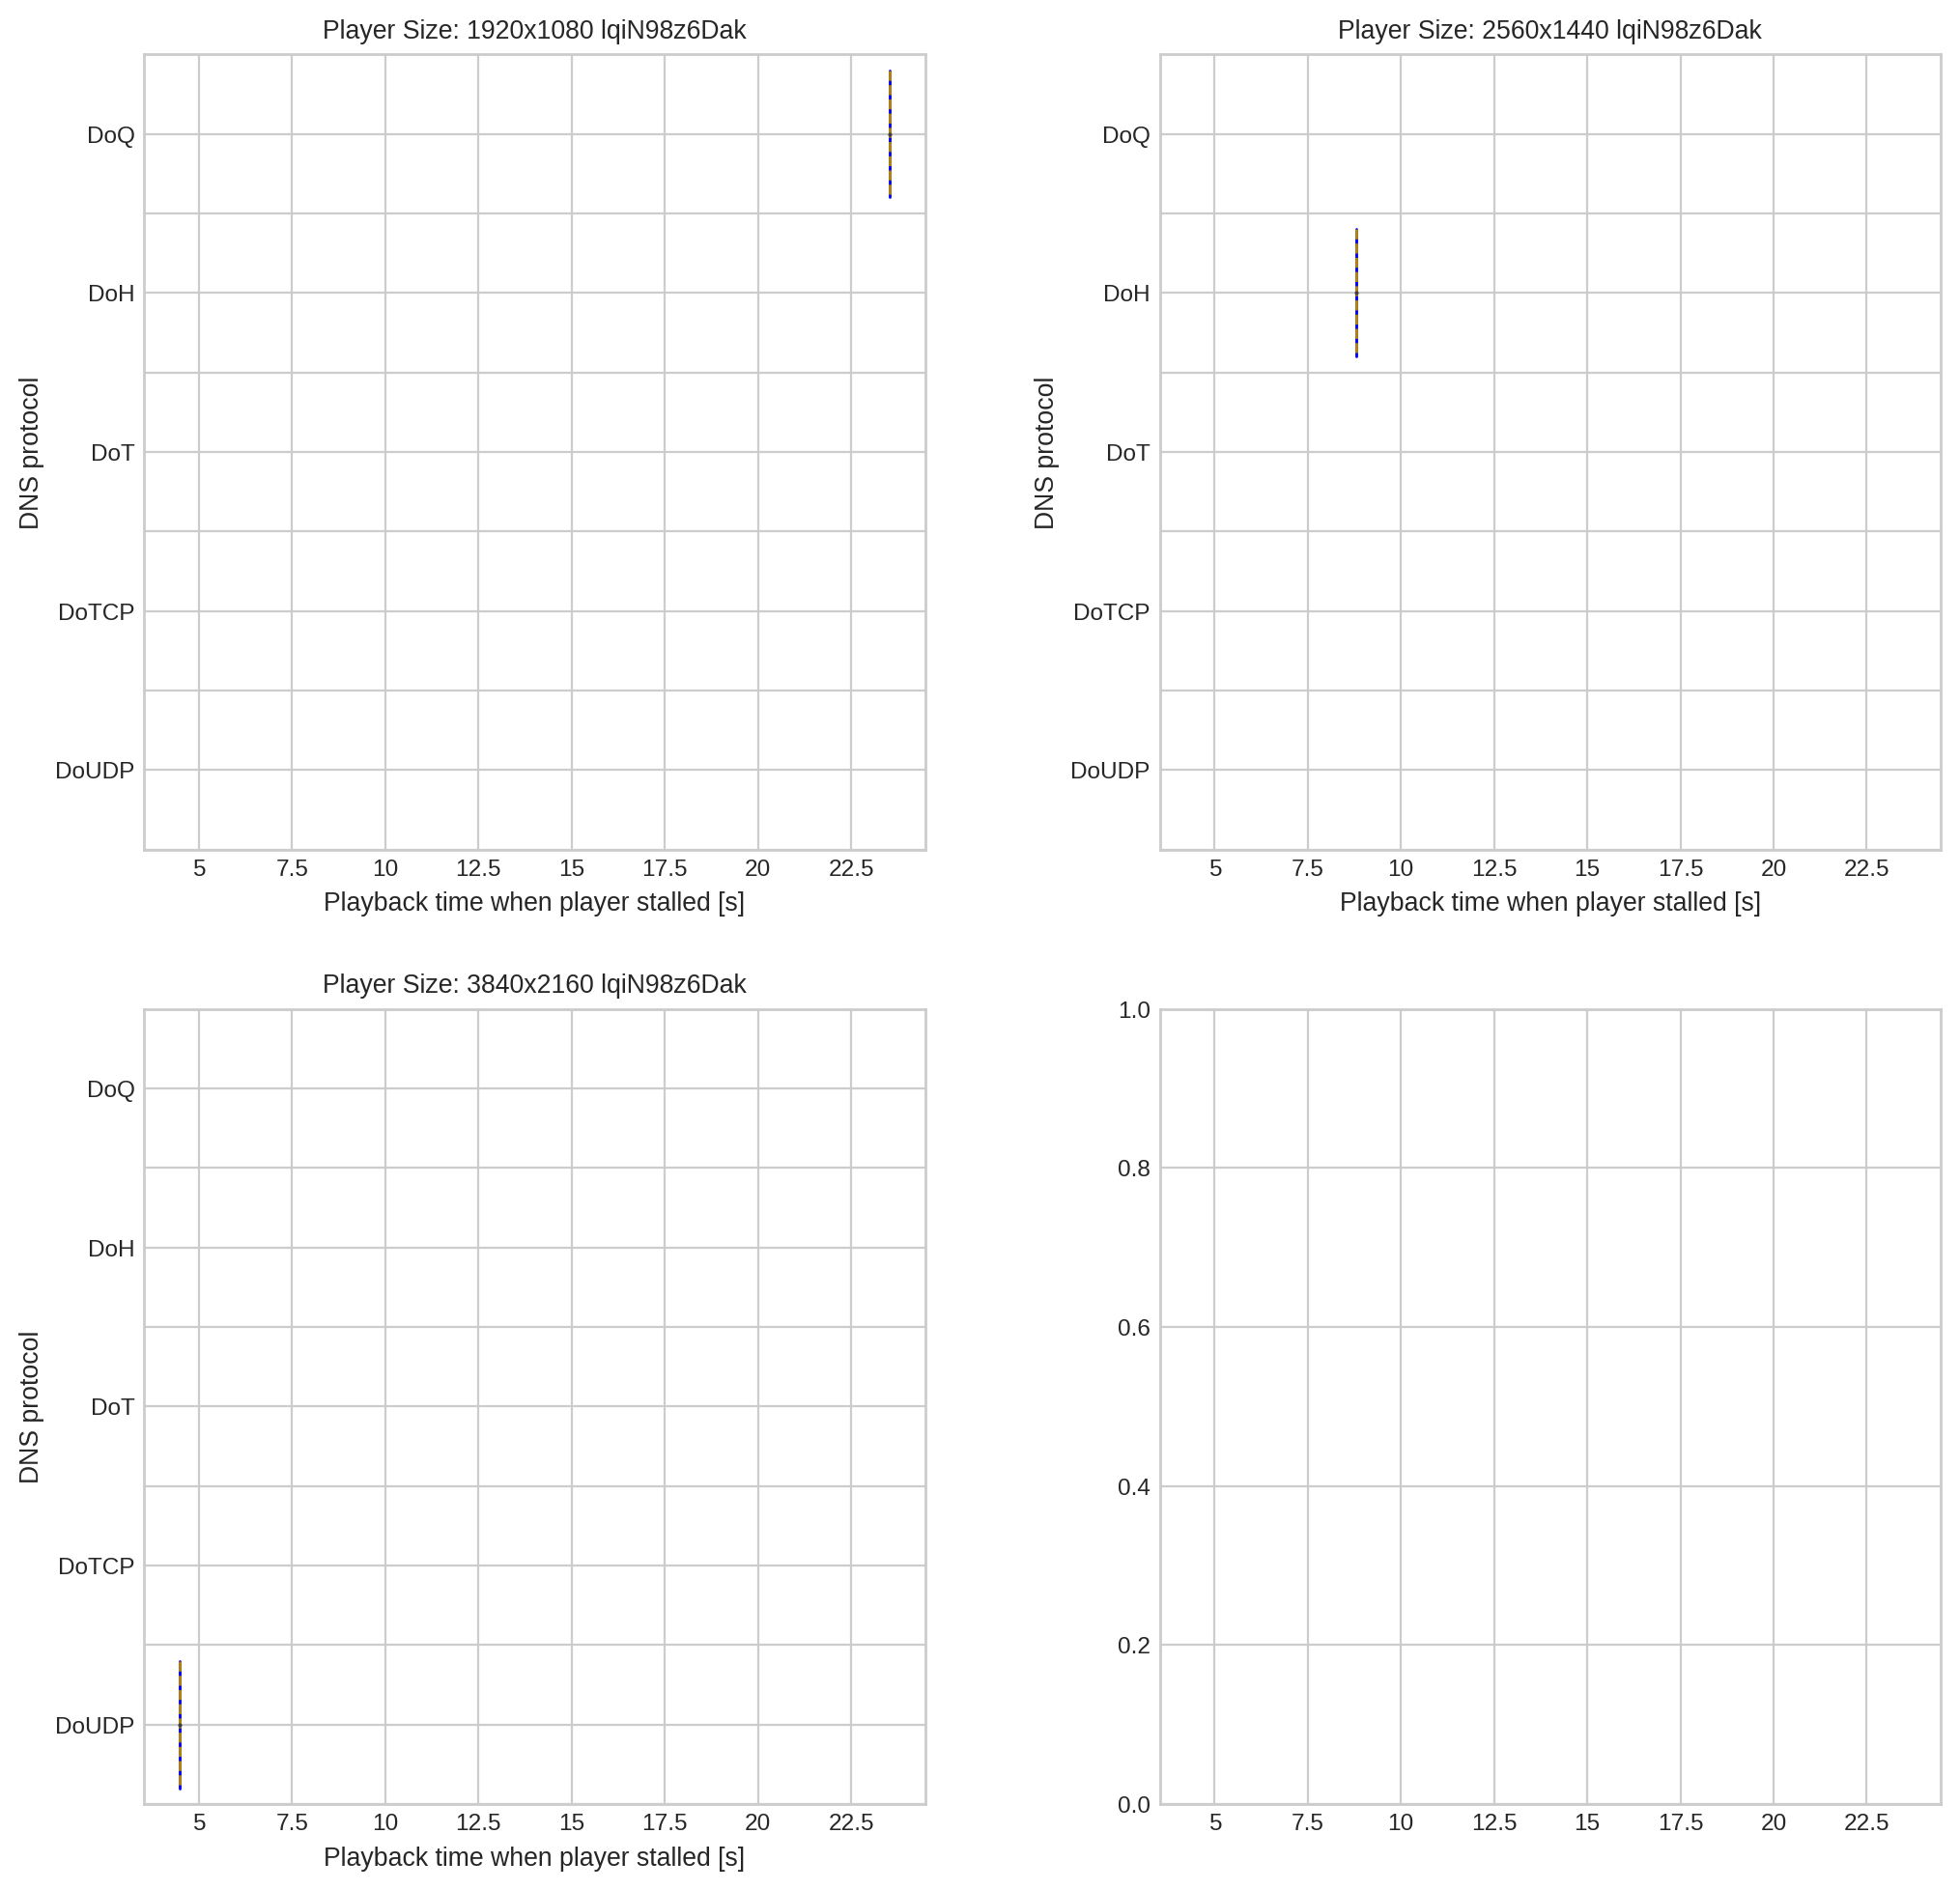

In [127]:
draw_boxplot_grid(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [True, False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_buffering_events_time, 'player_dimensions', 'protocol', 'curr_play_time', [False], 'Playback time when player stalled [s]', 'Player Size:', 'buffer-events-by-player-size-and-proto', [0,0], "DNS protocol")

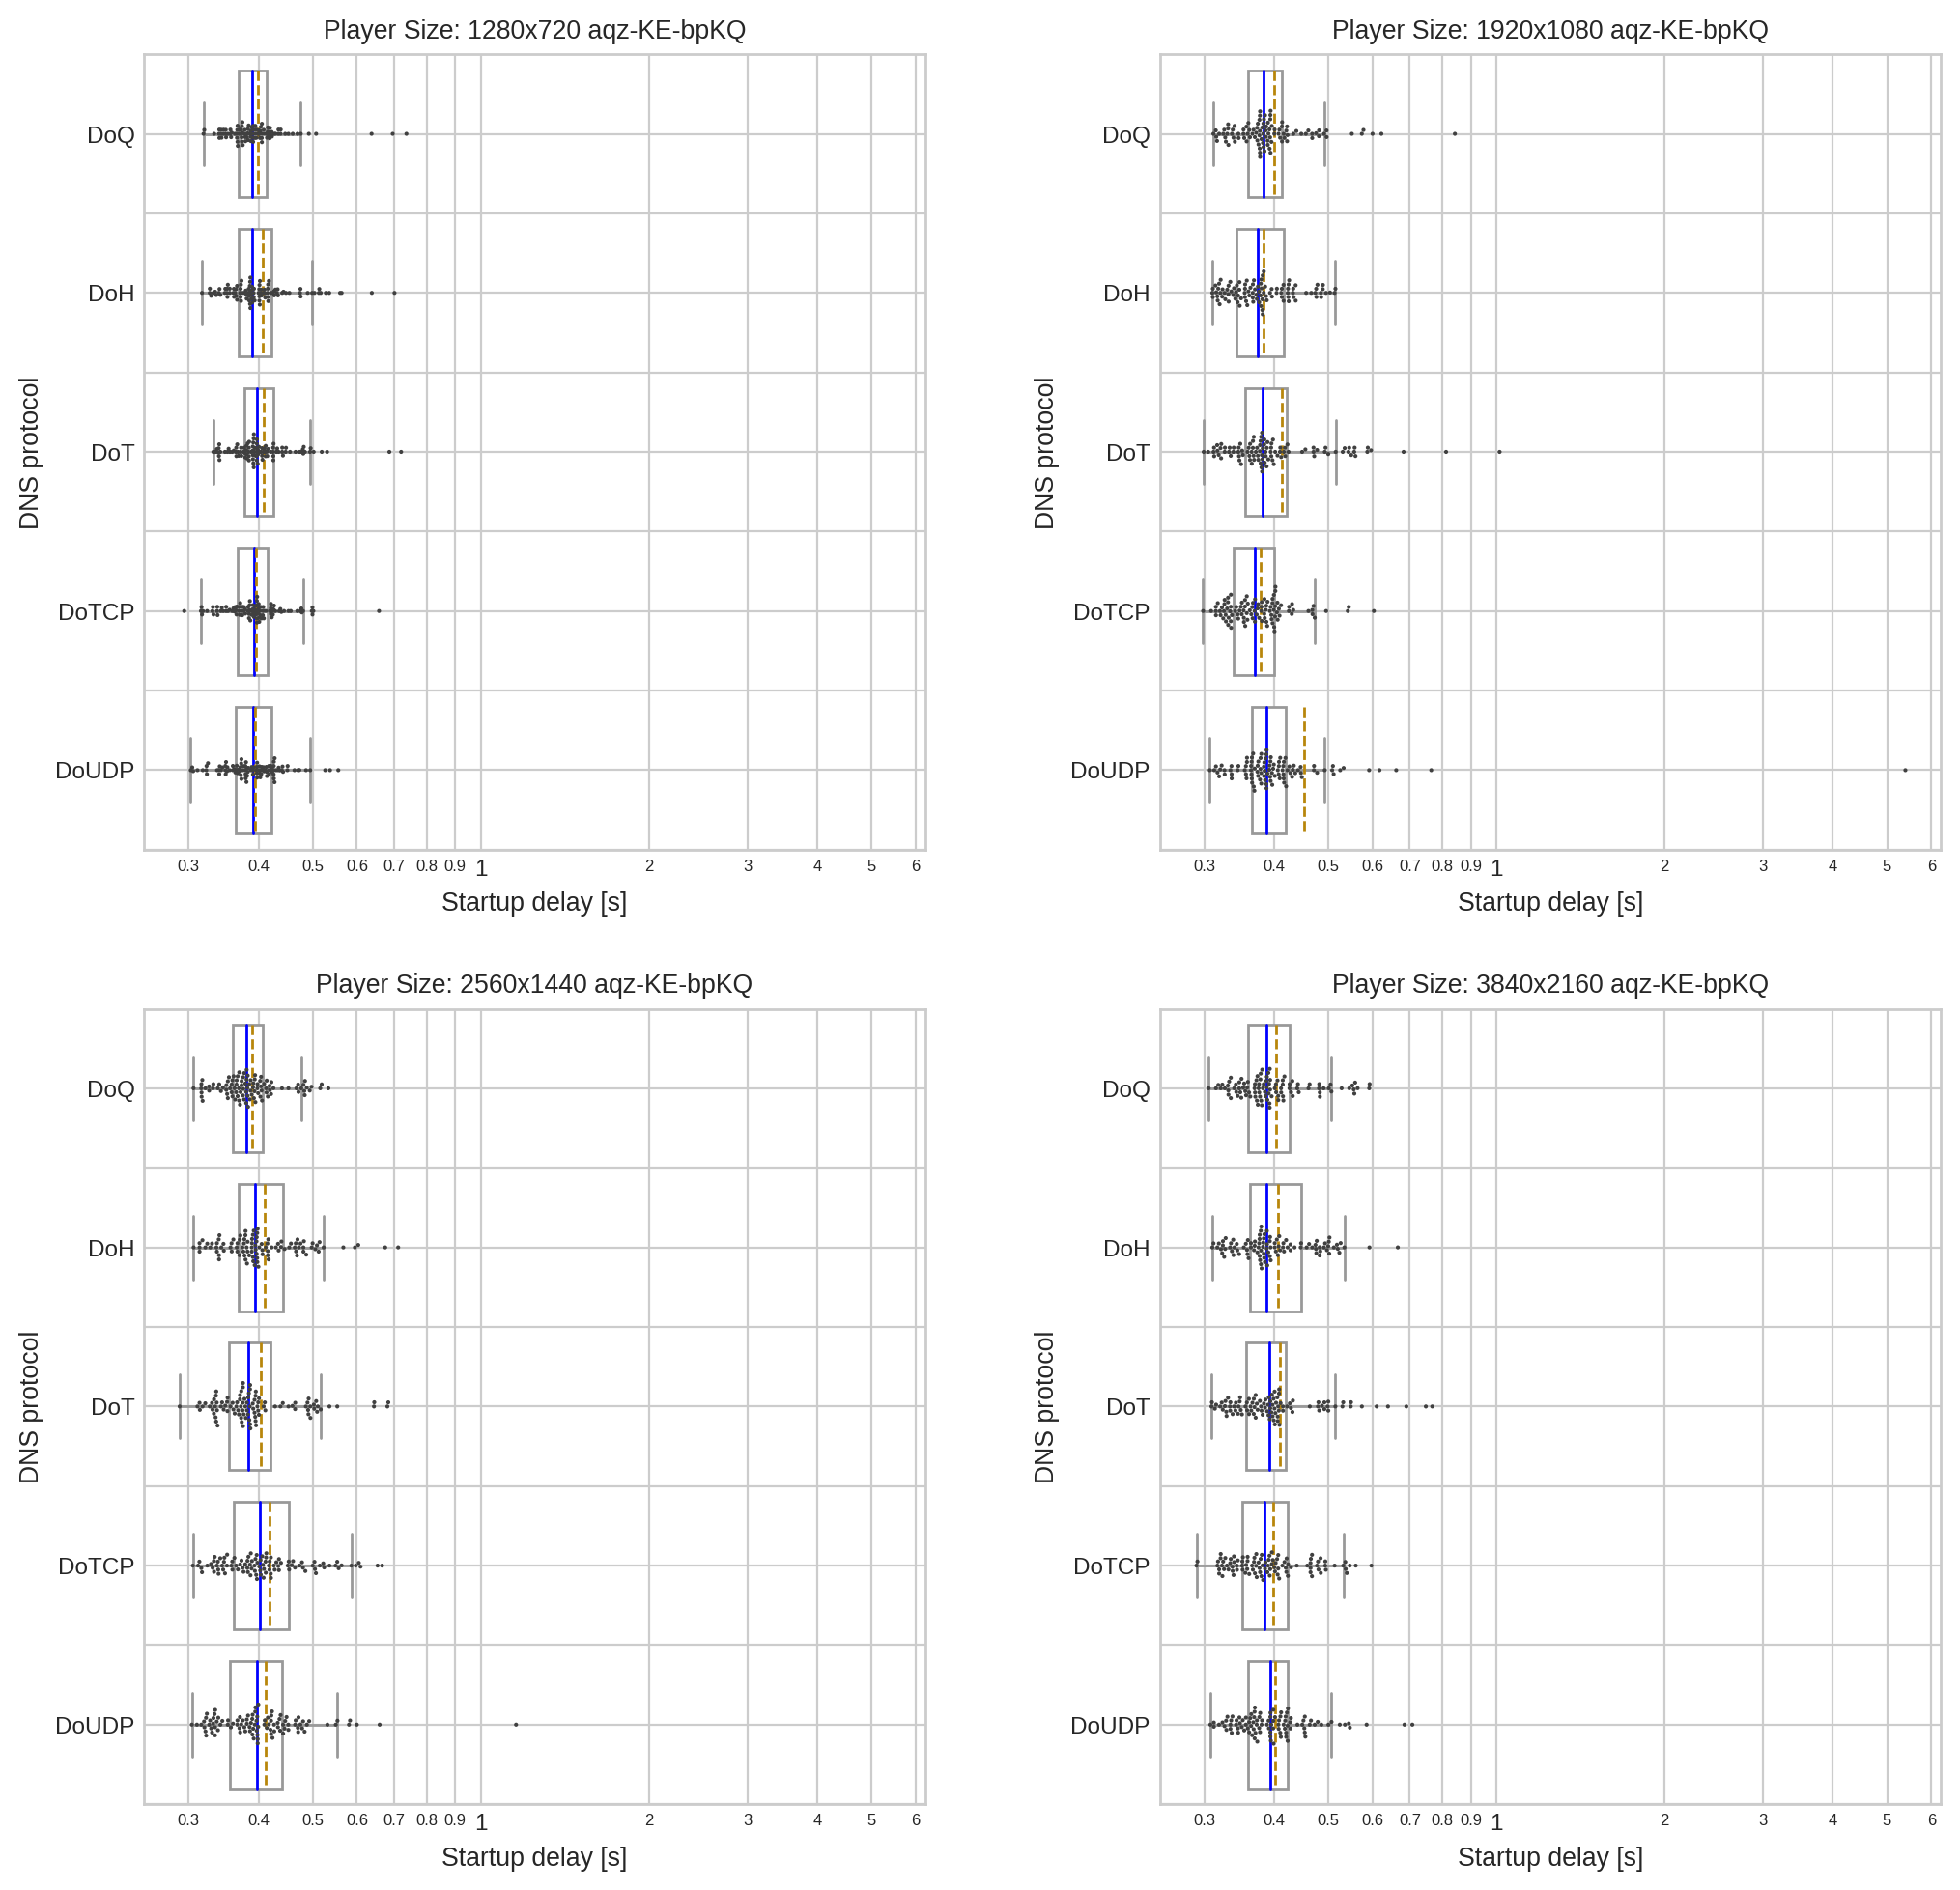

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


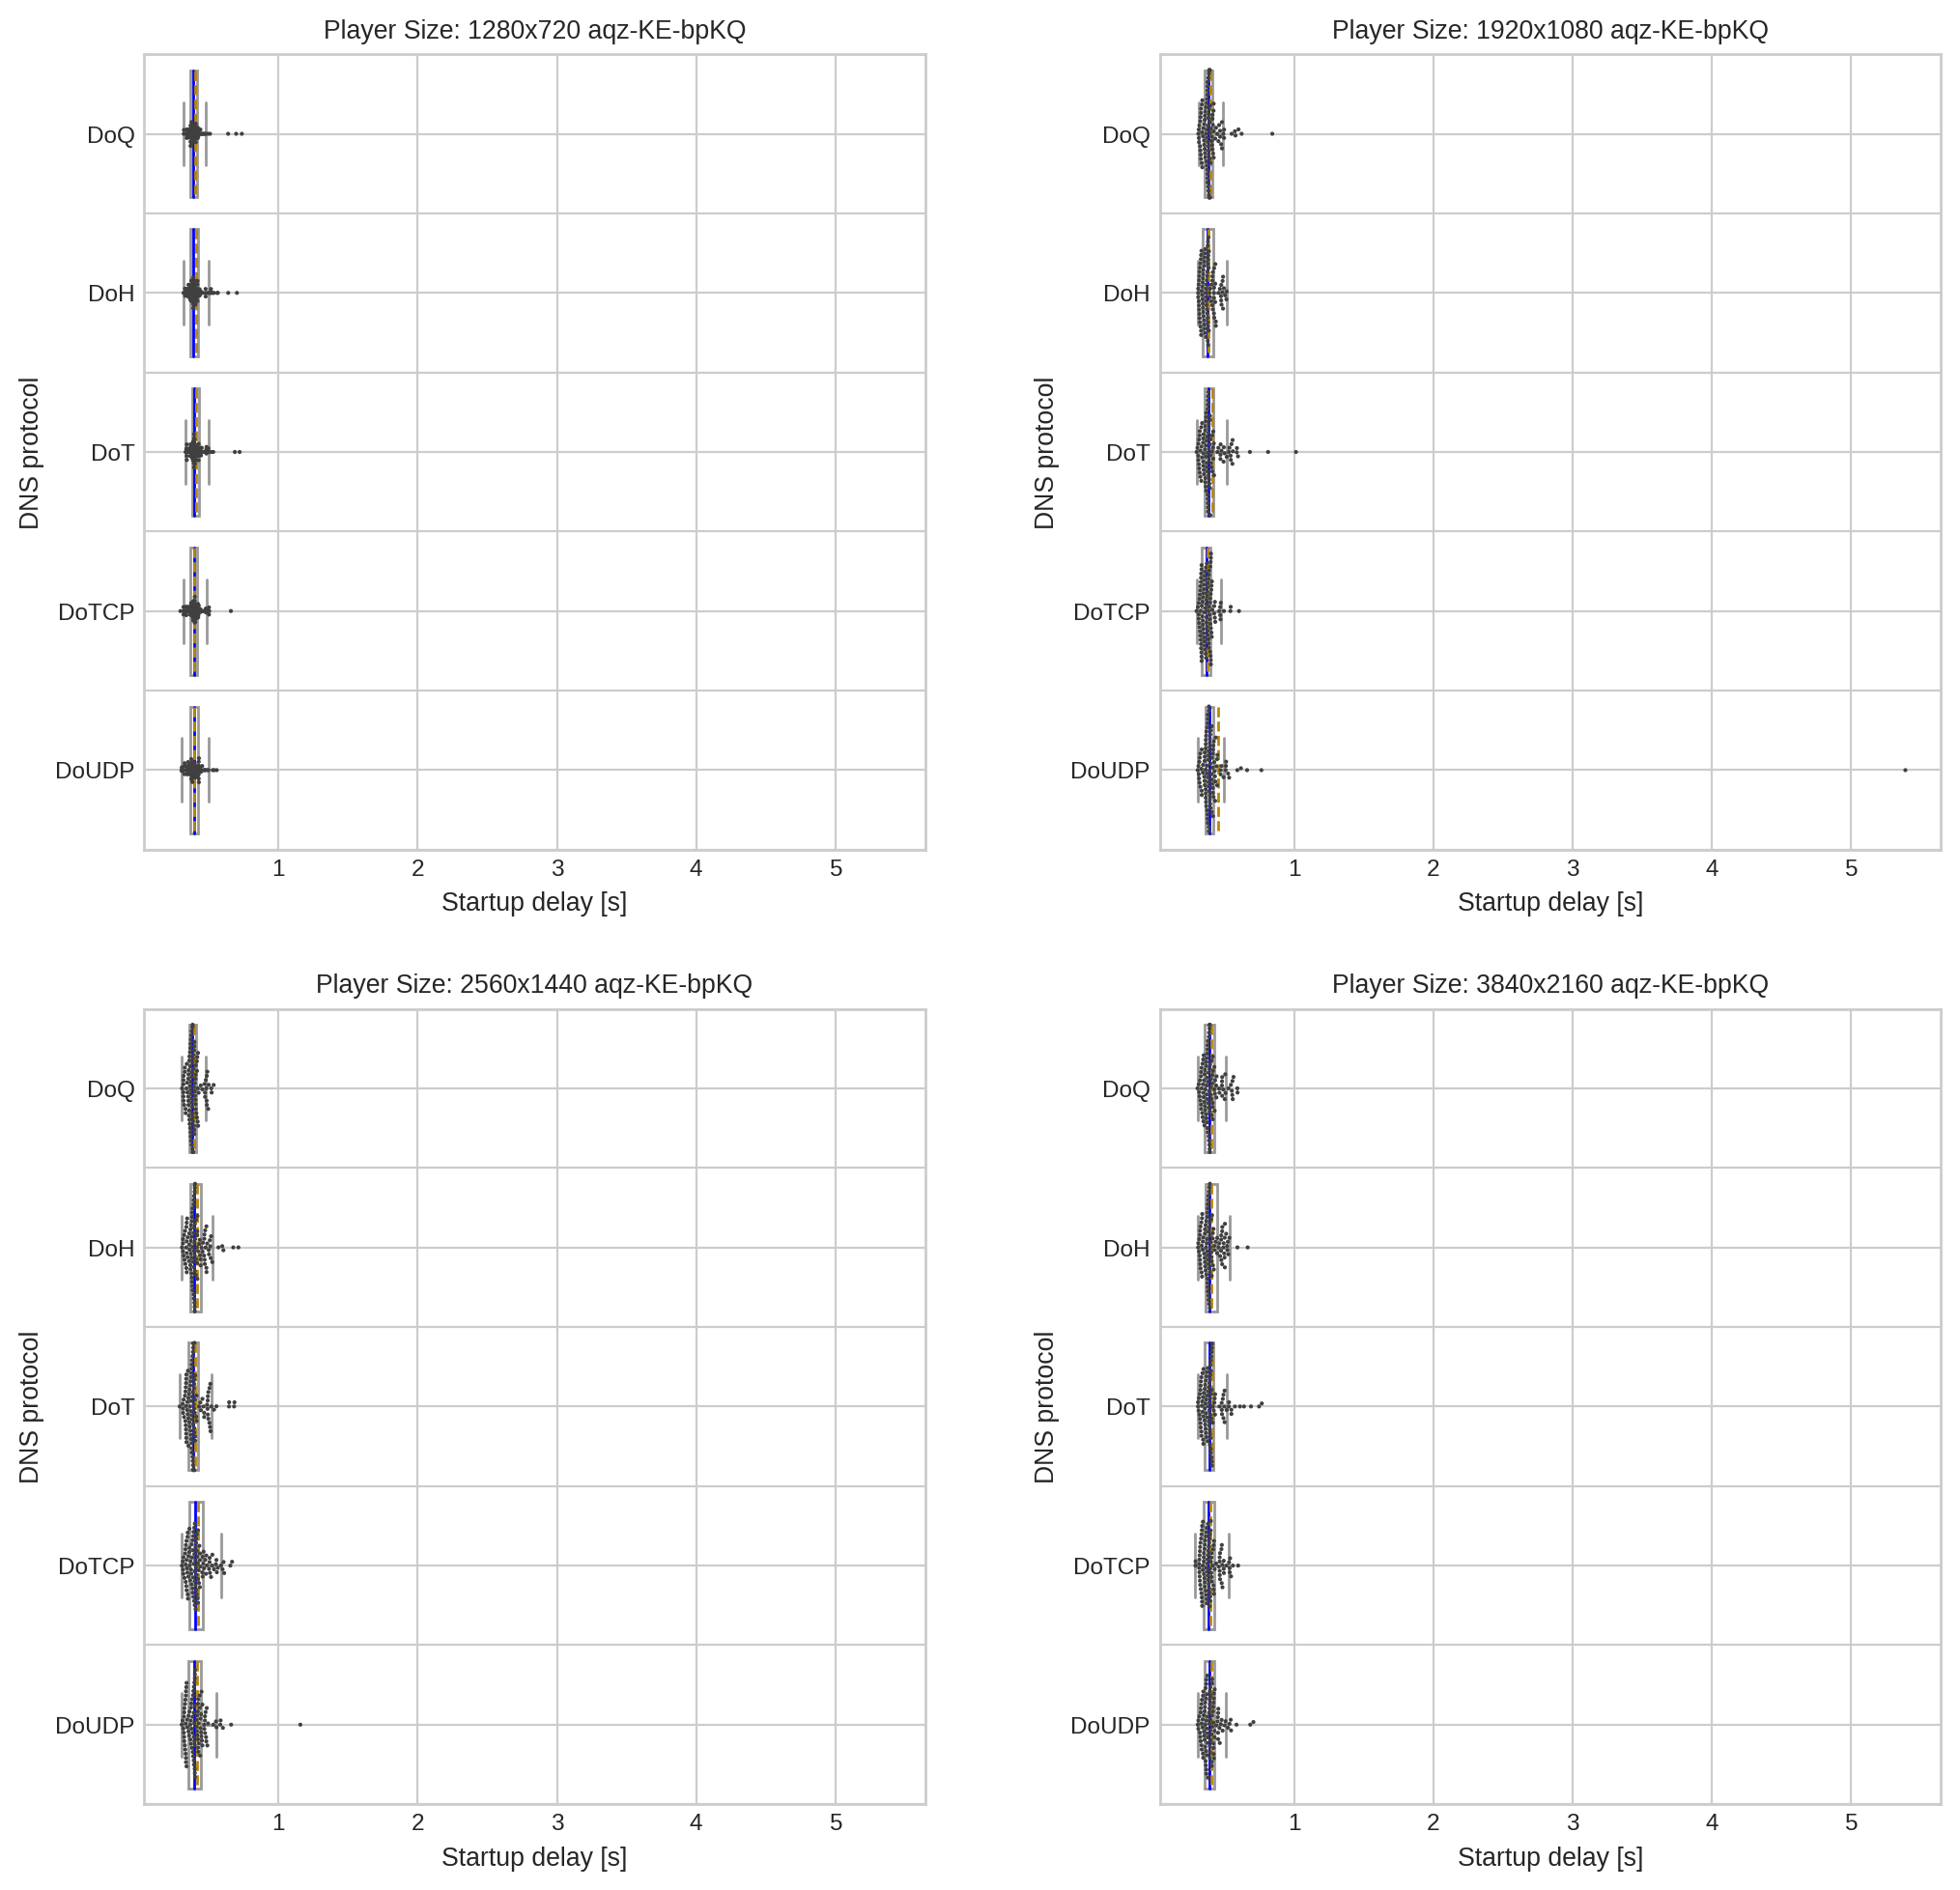

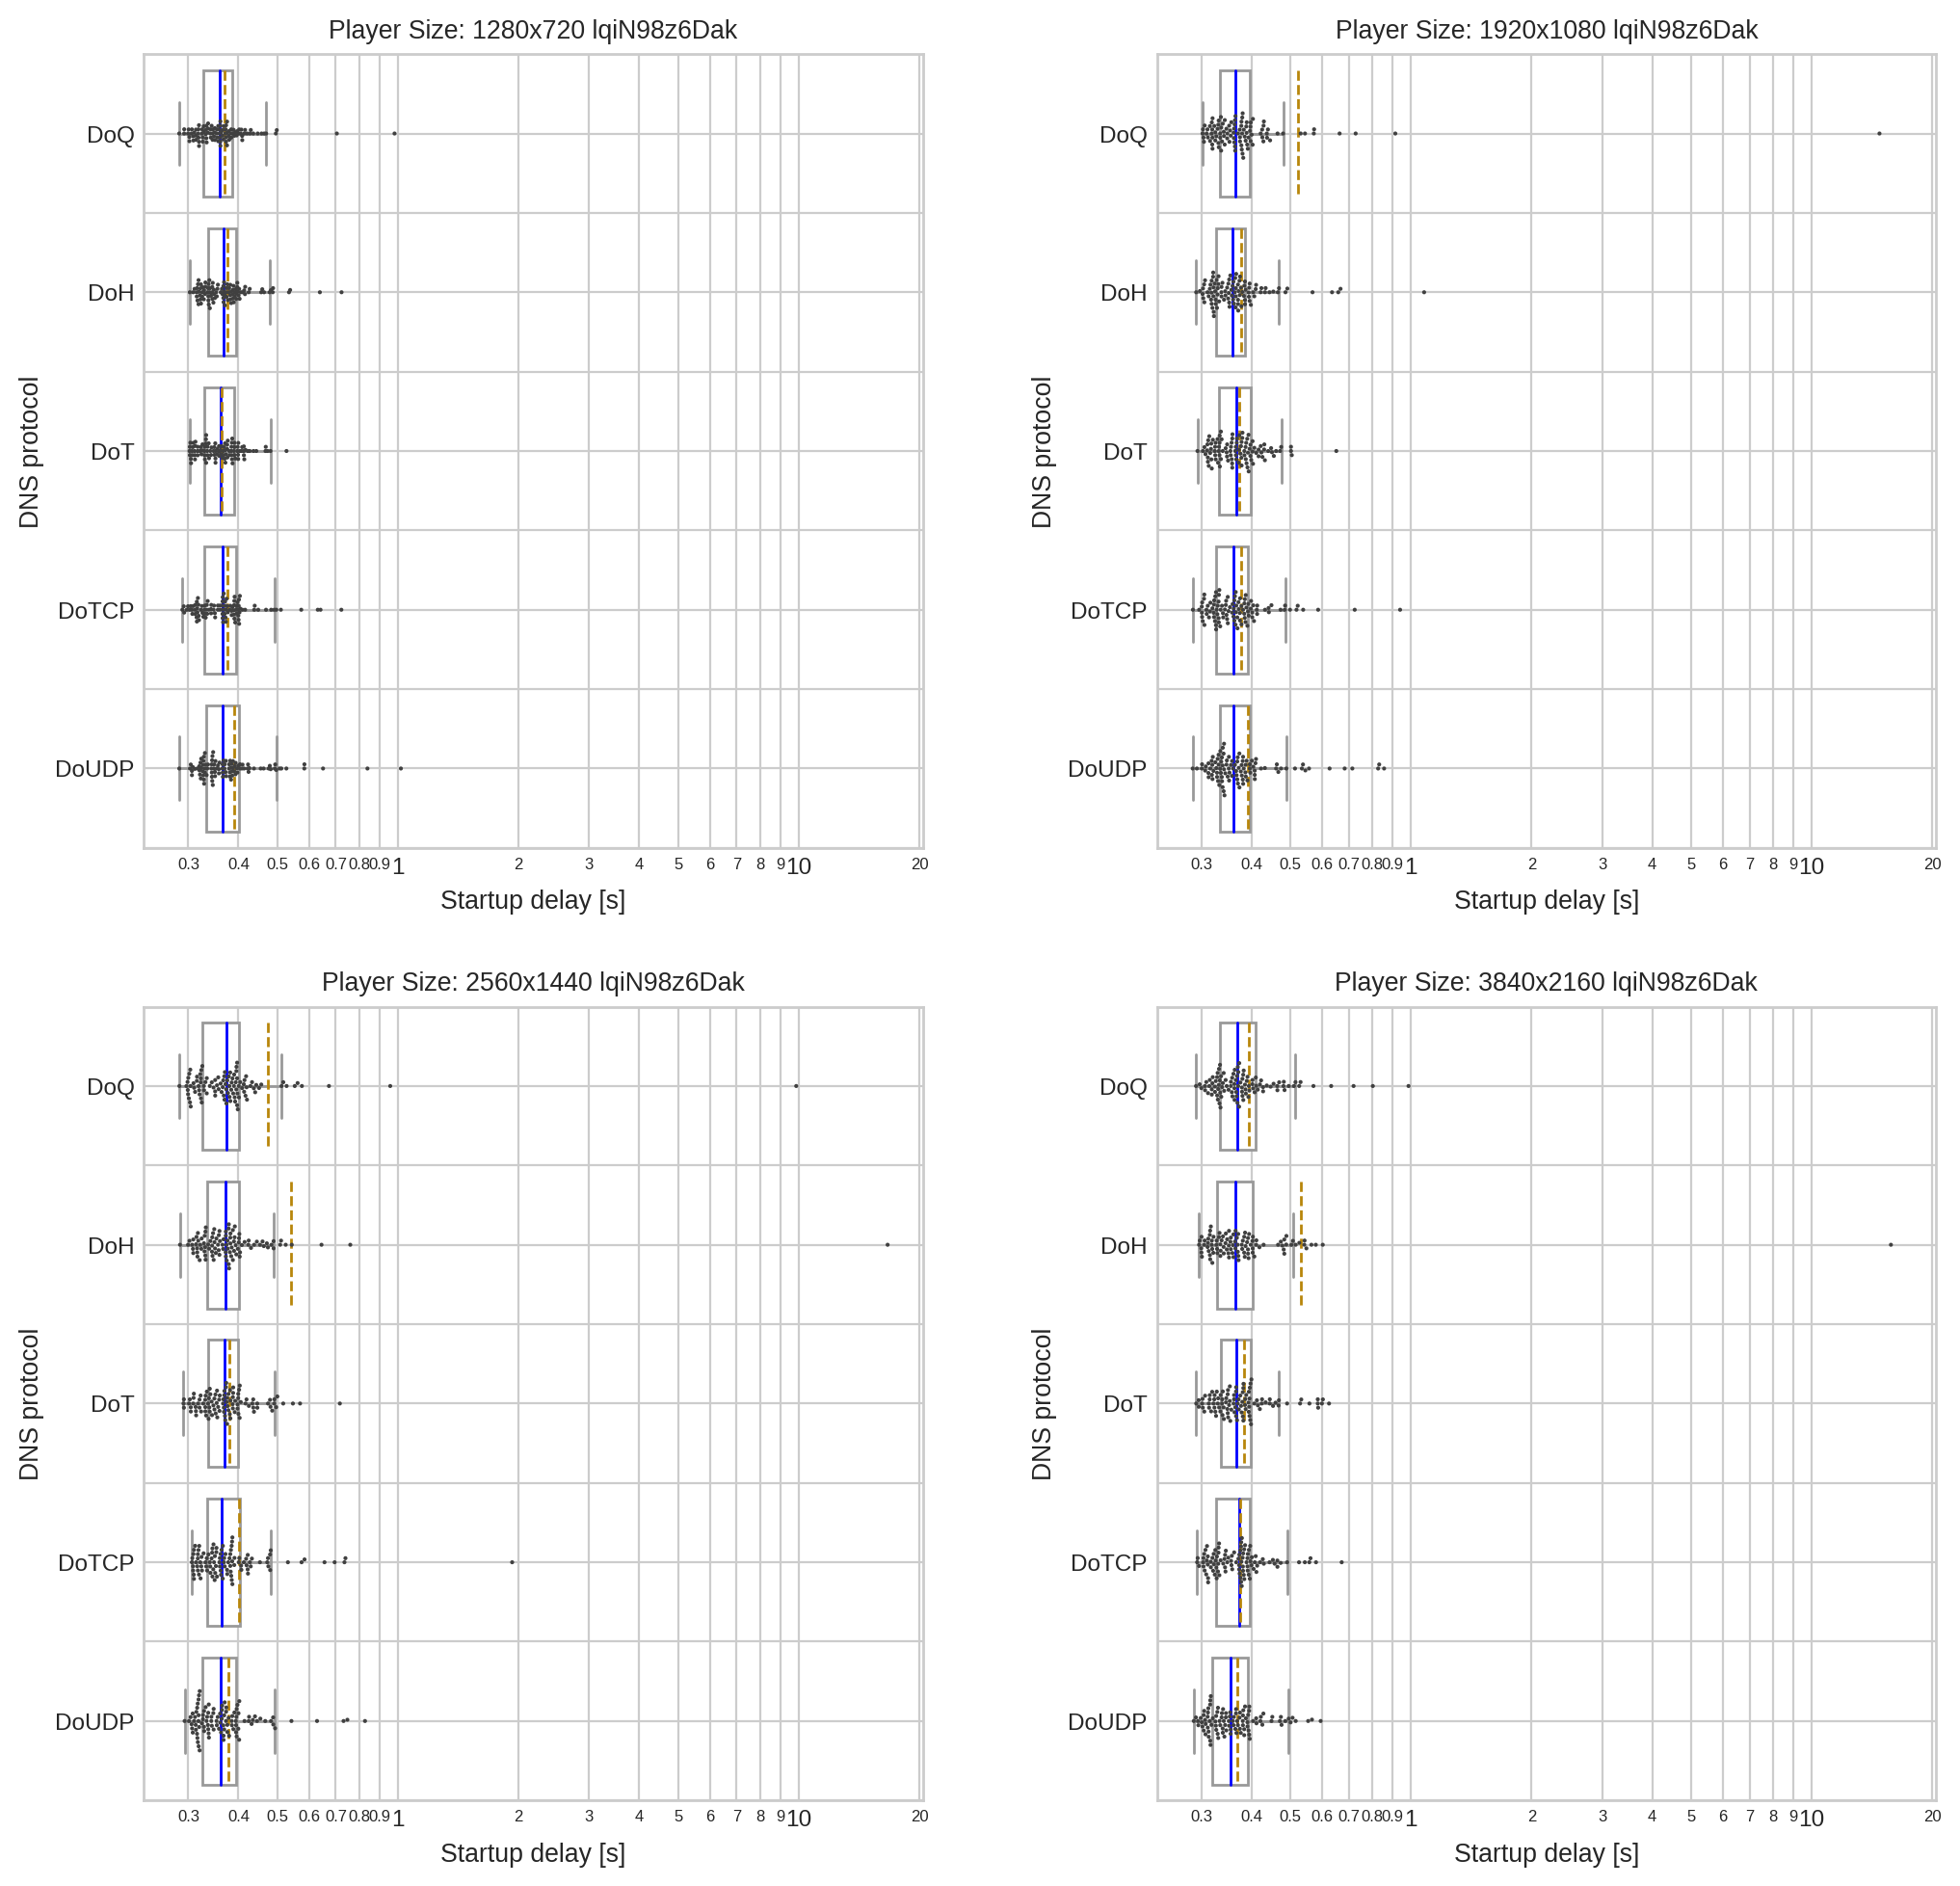

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 34.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 29.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

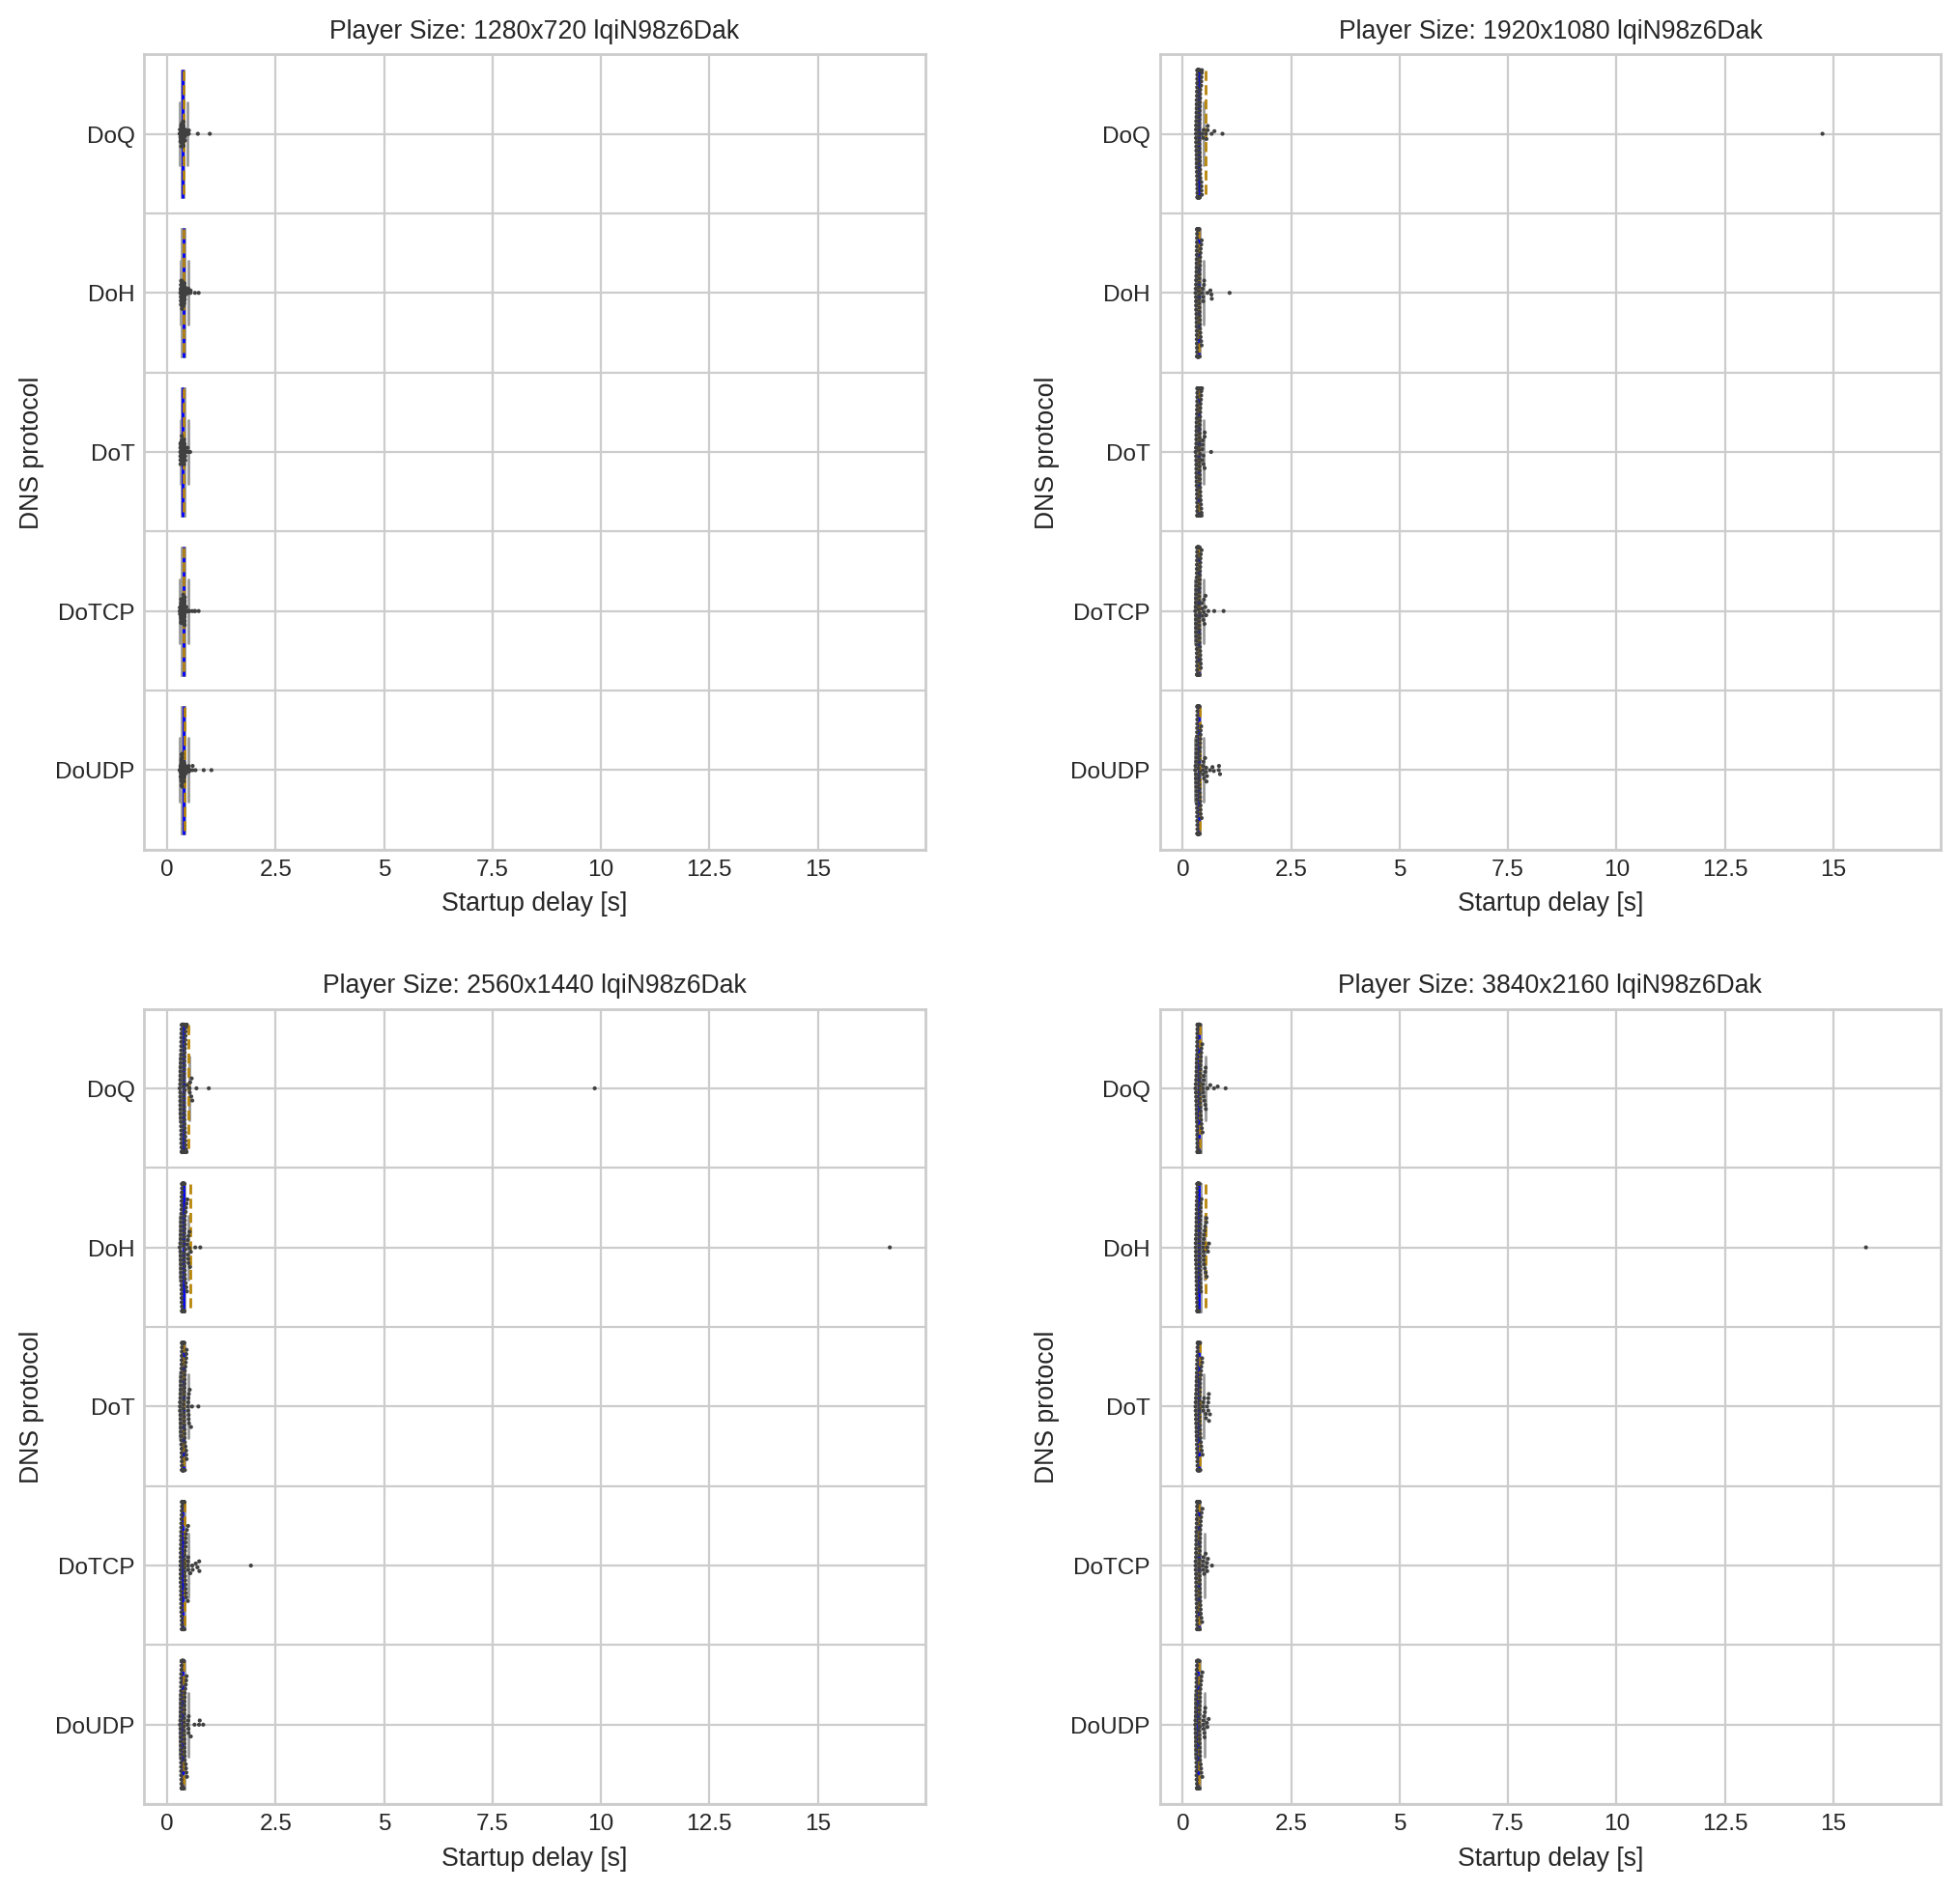

In [129]:
draw_boxplot_grid(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [True, False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_start_time, 'player_dimensions', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Player Size:', 'startup-delay-by-player-size-and-proto', [0,0], "DNS protocol")

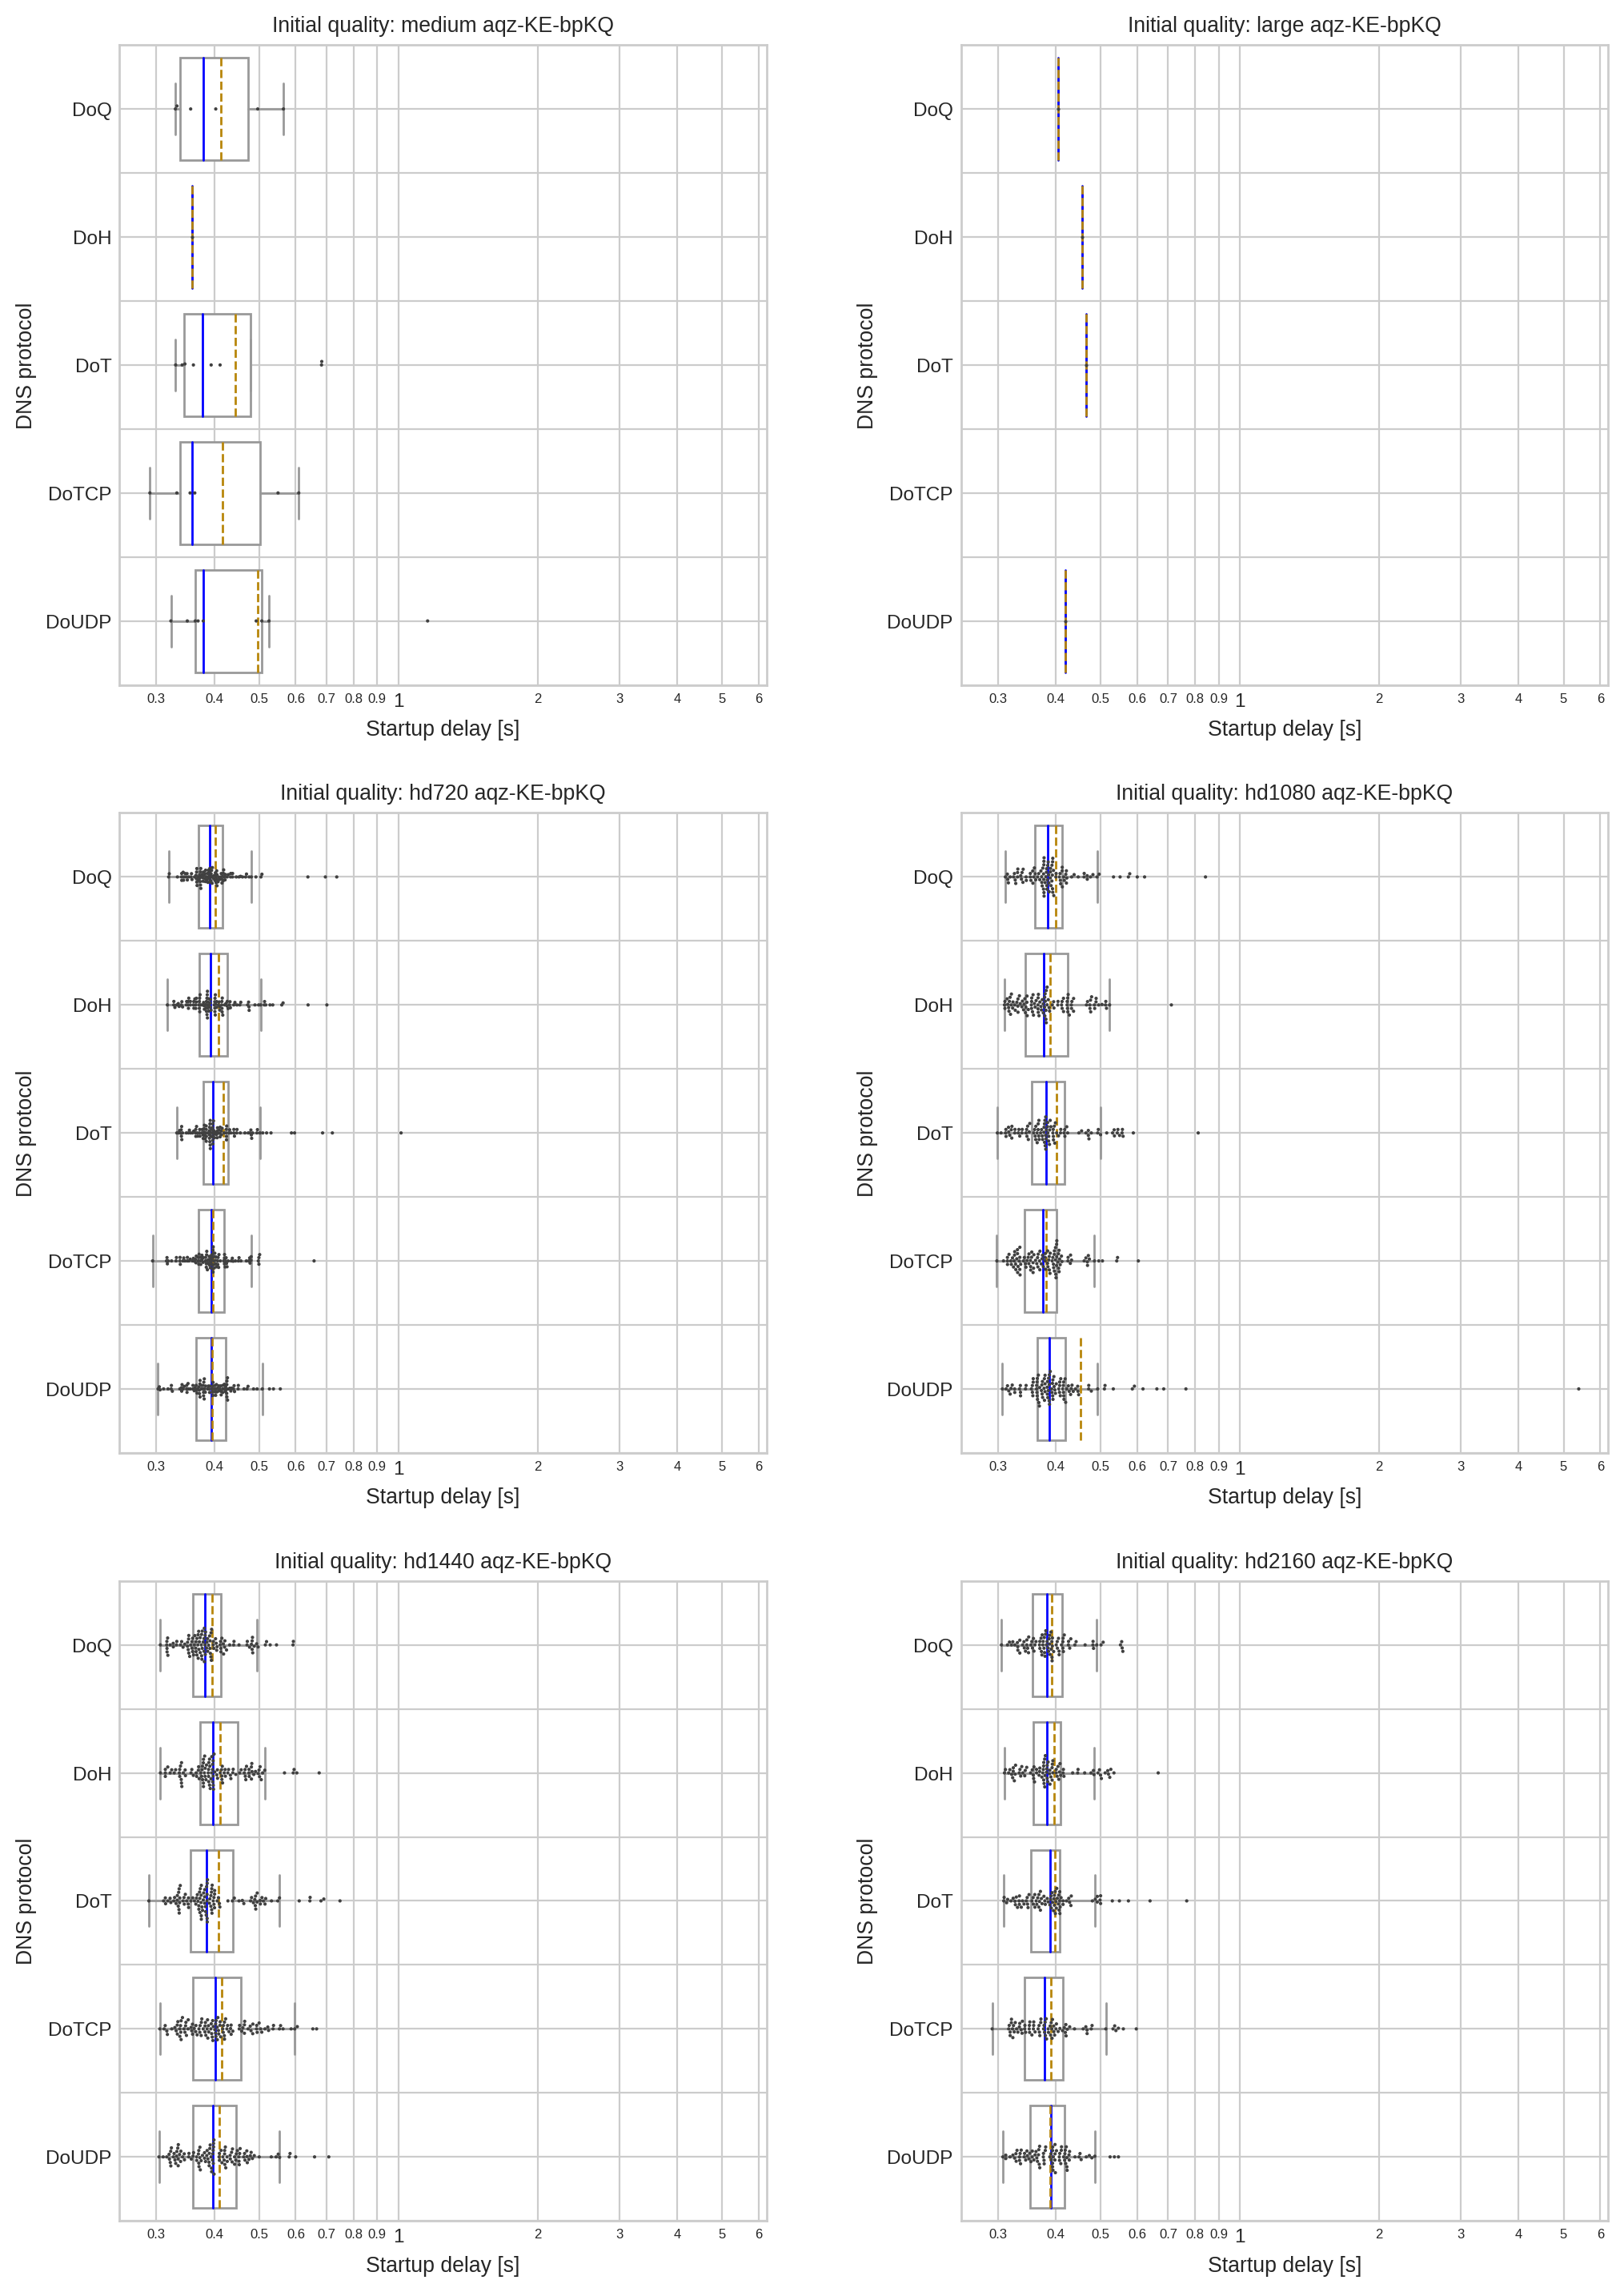

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


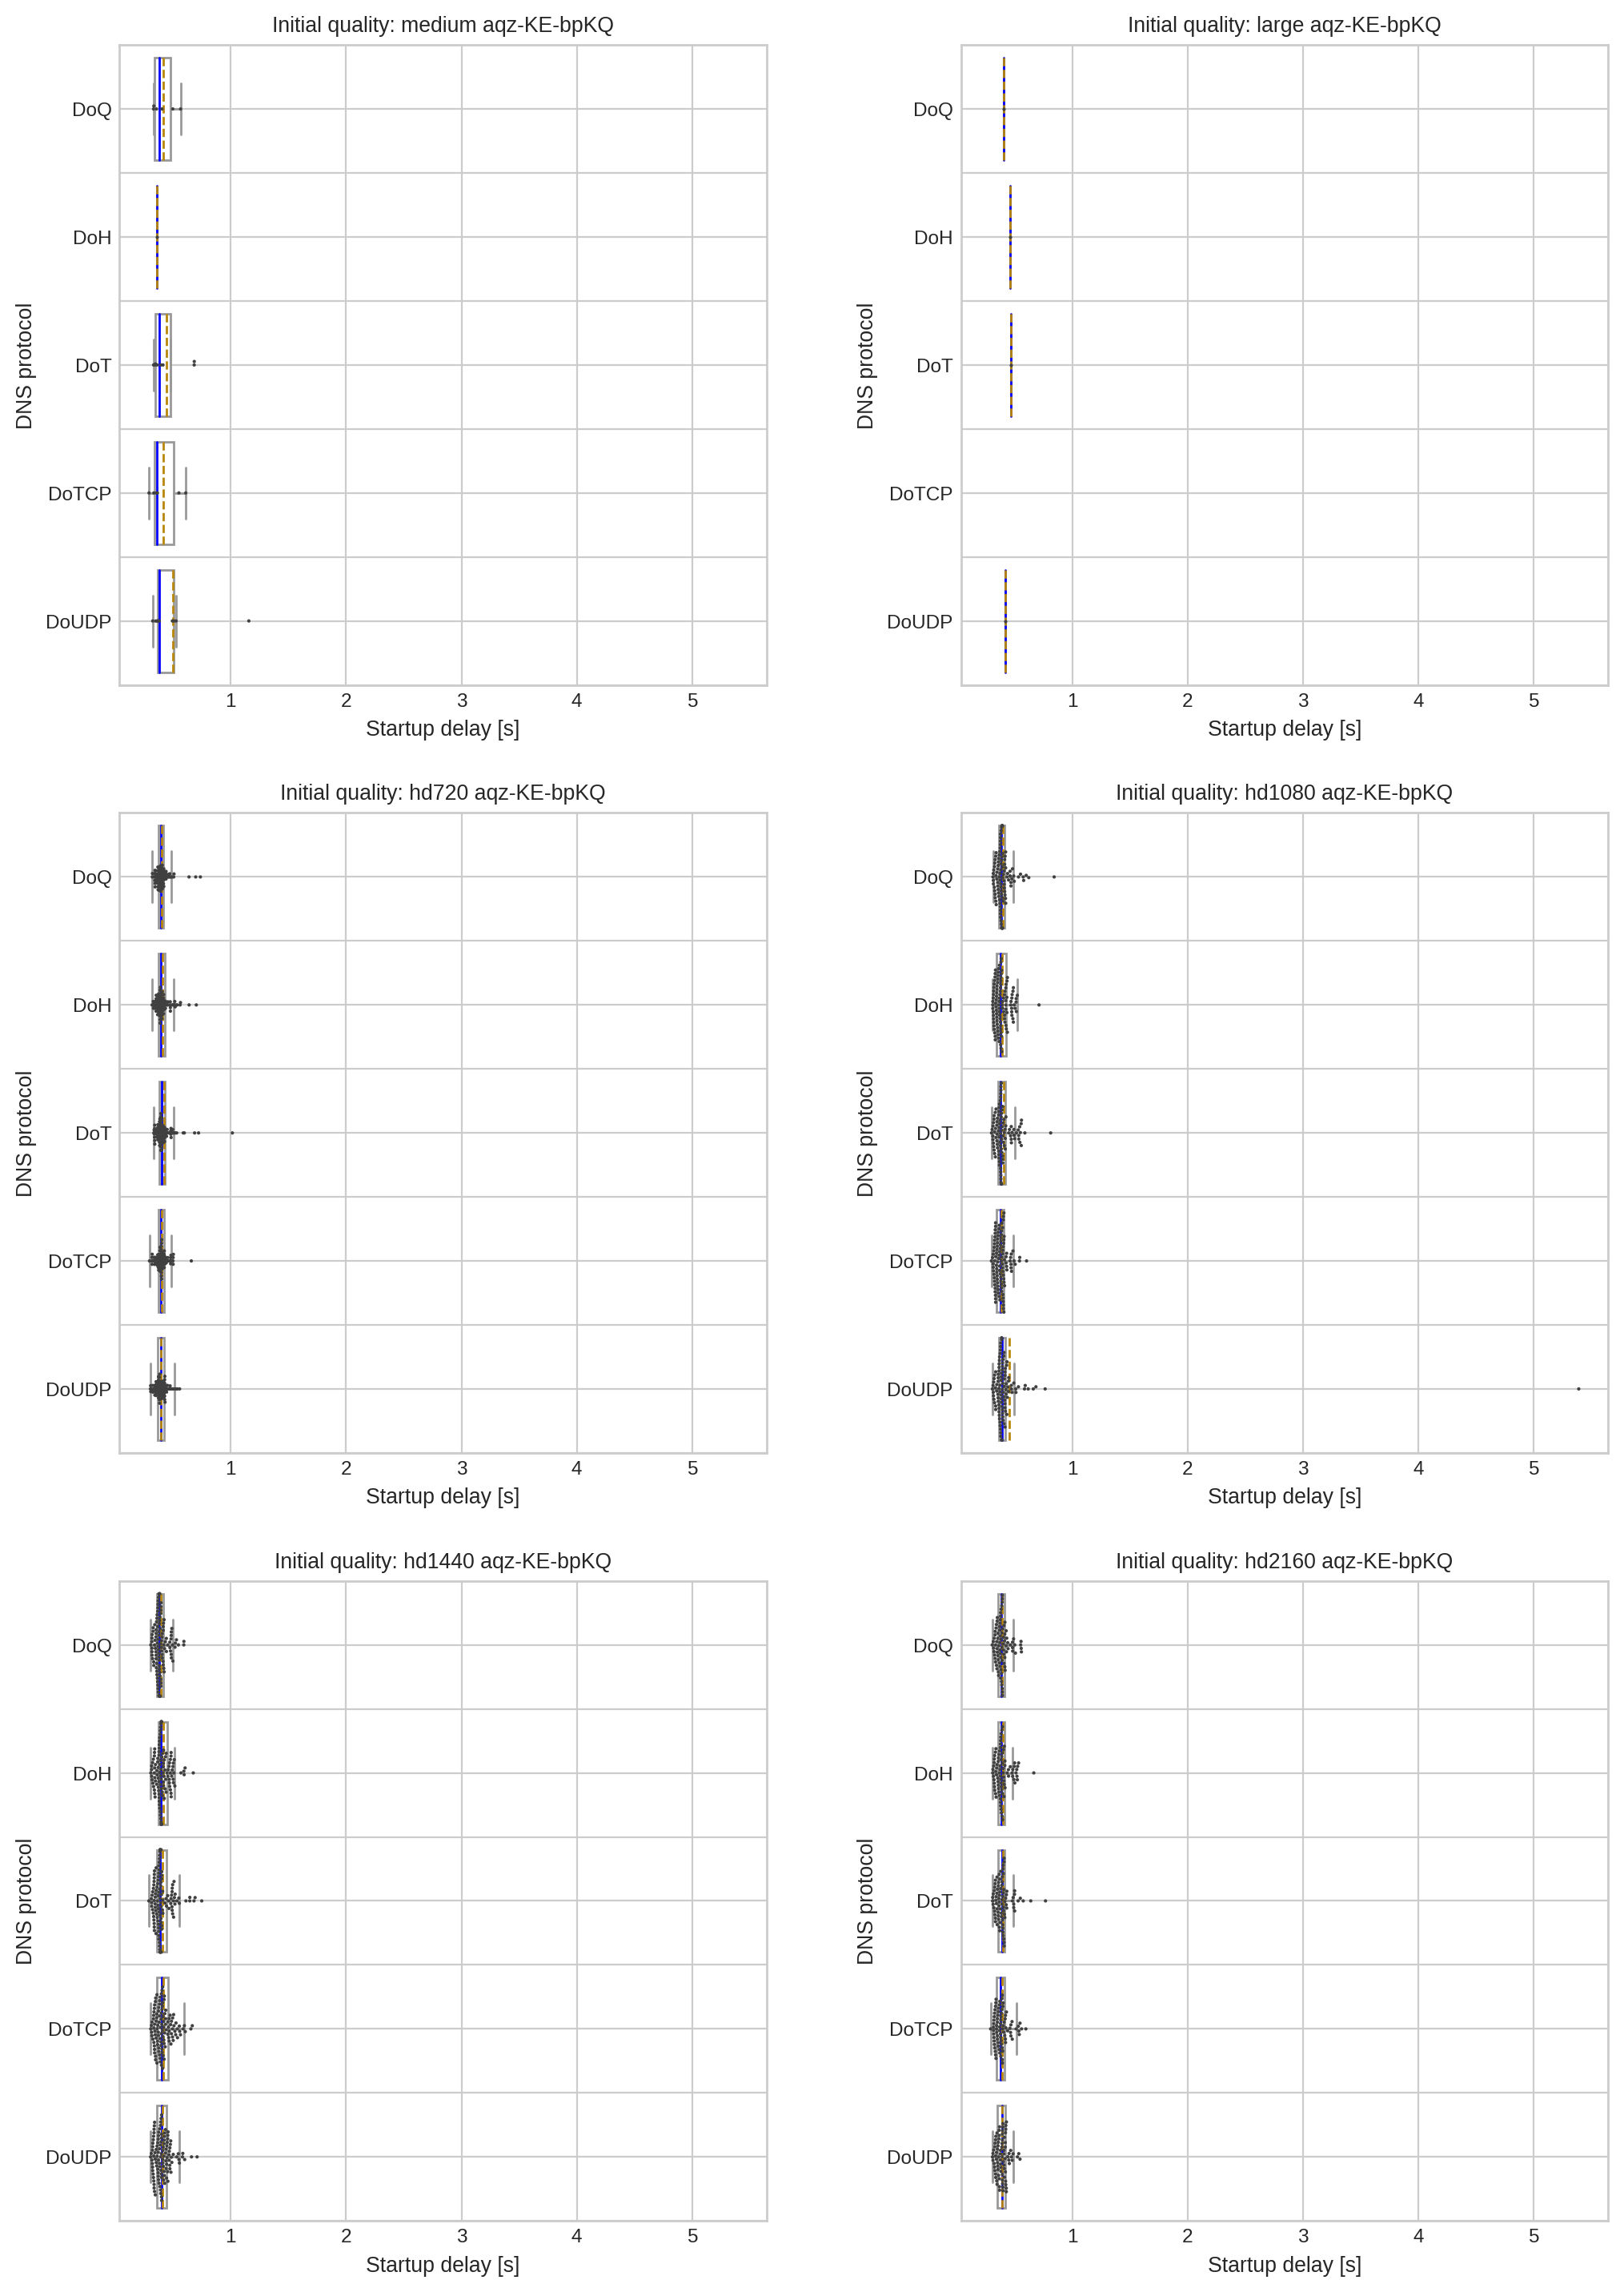

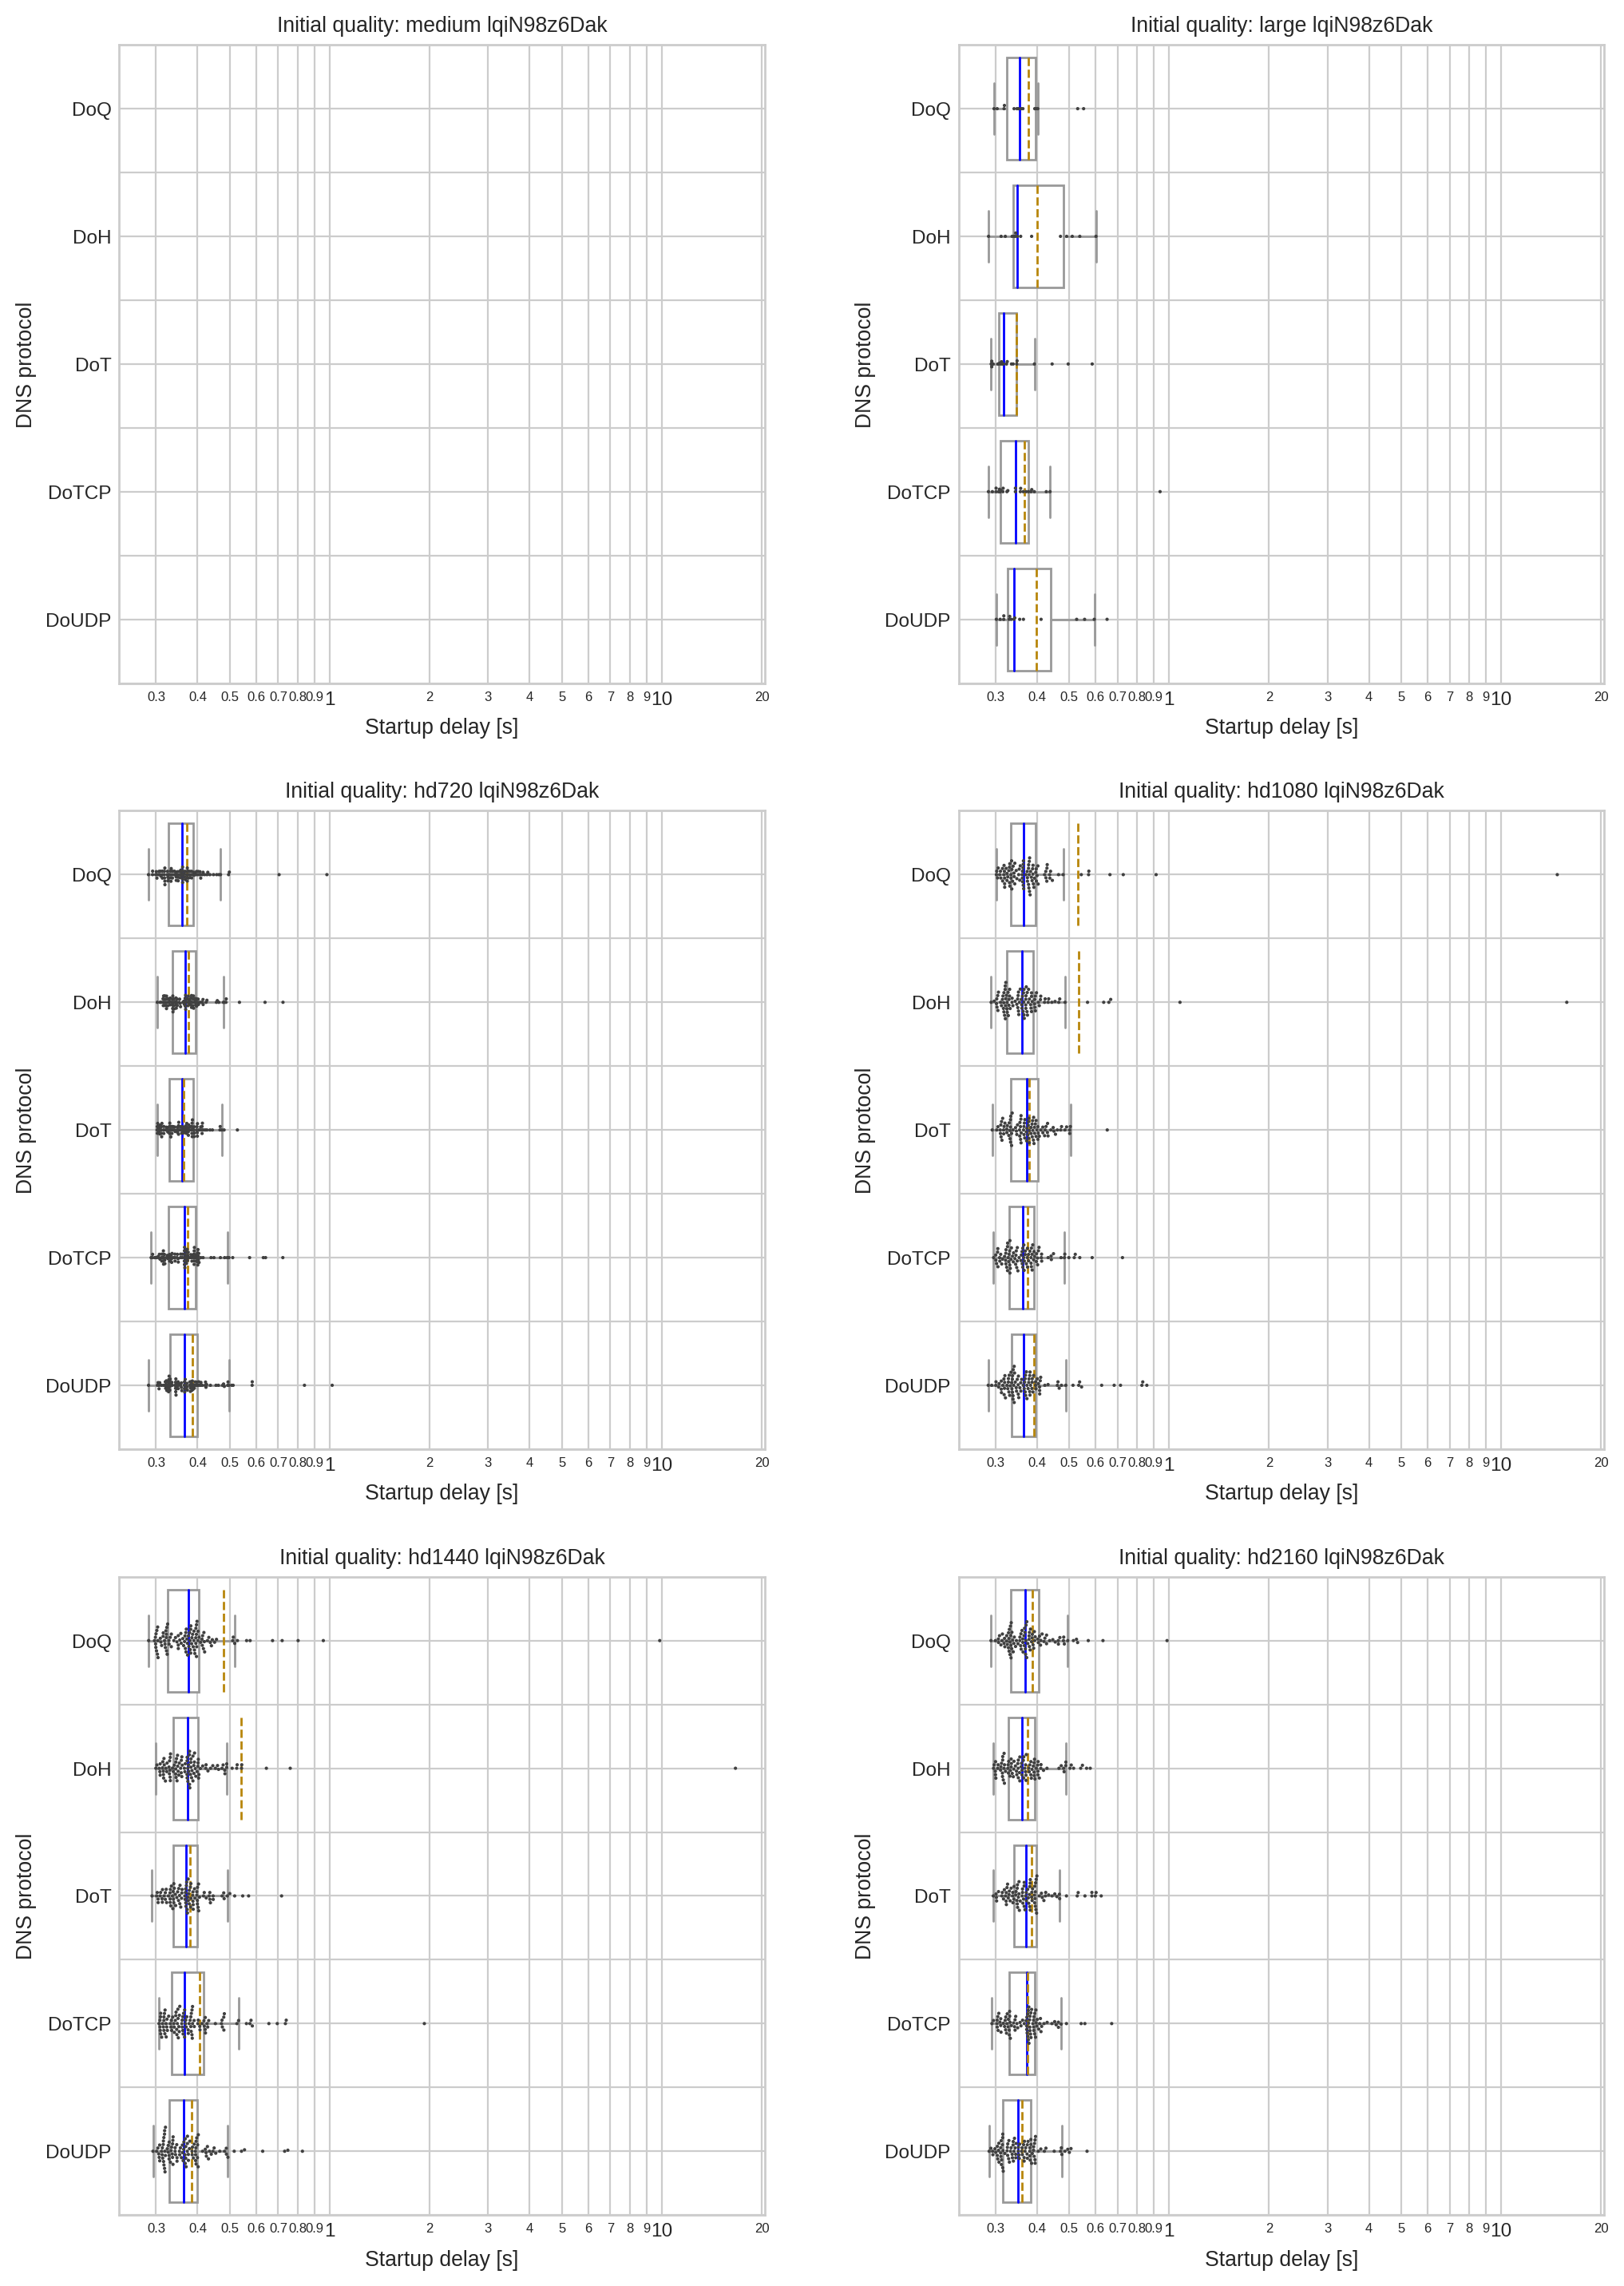

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 37.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 30.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

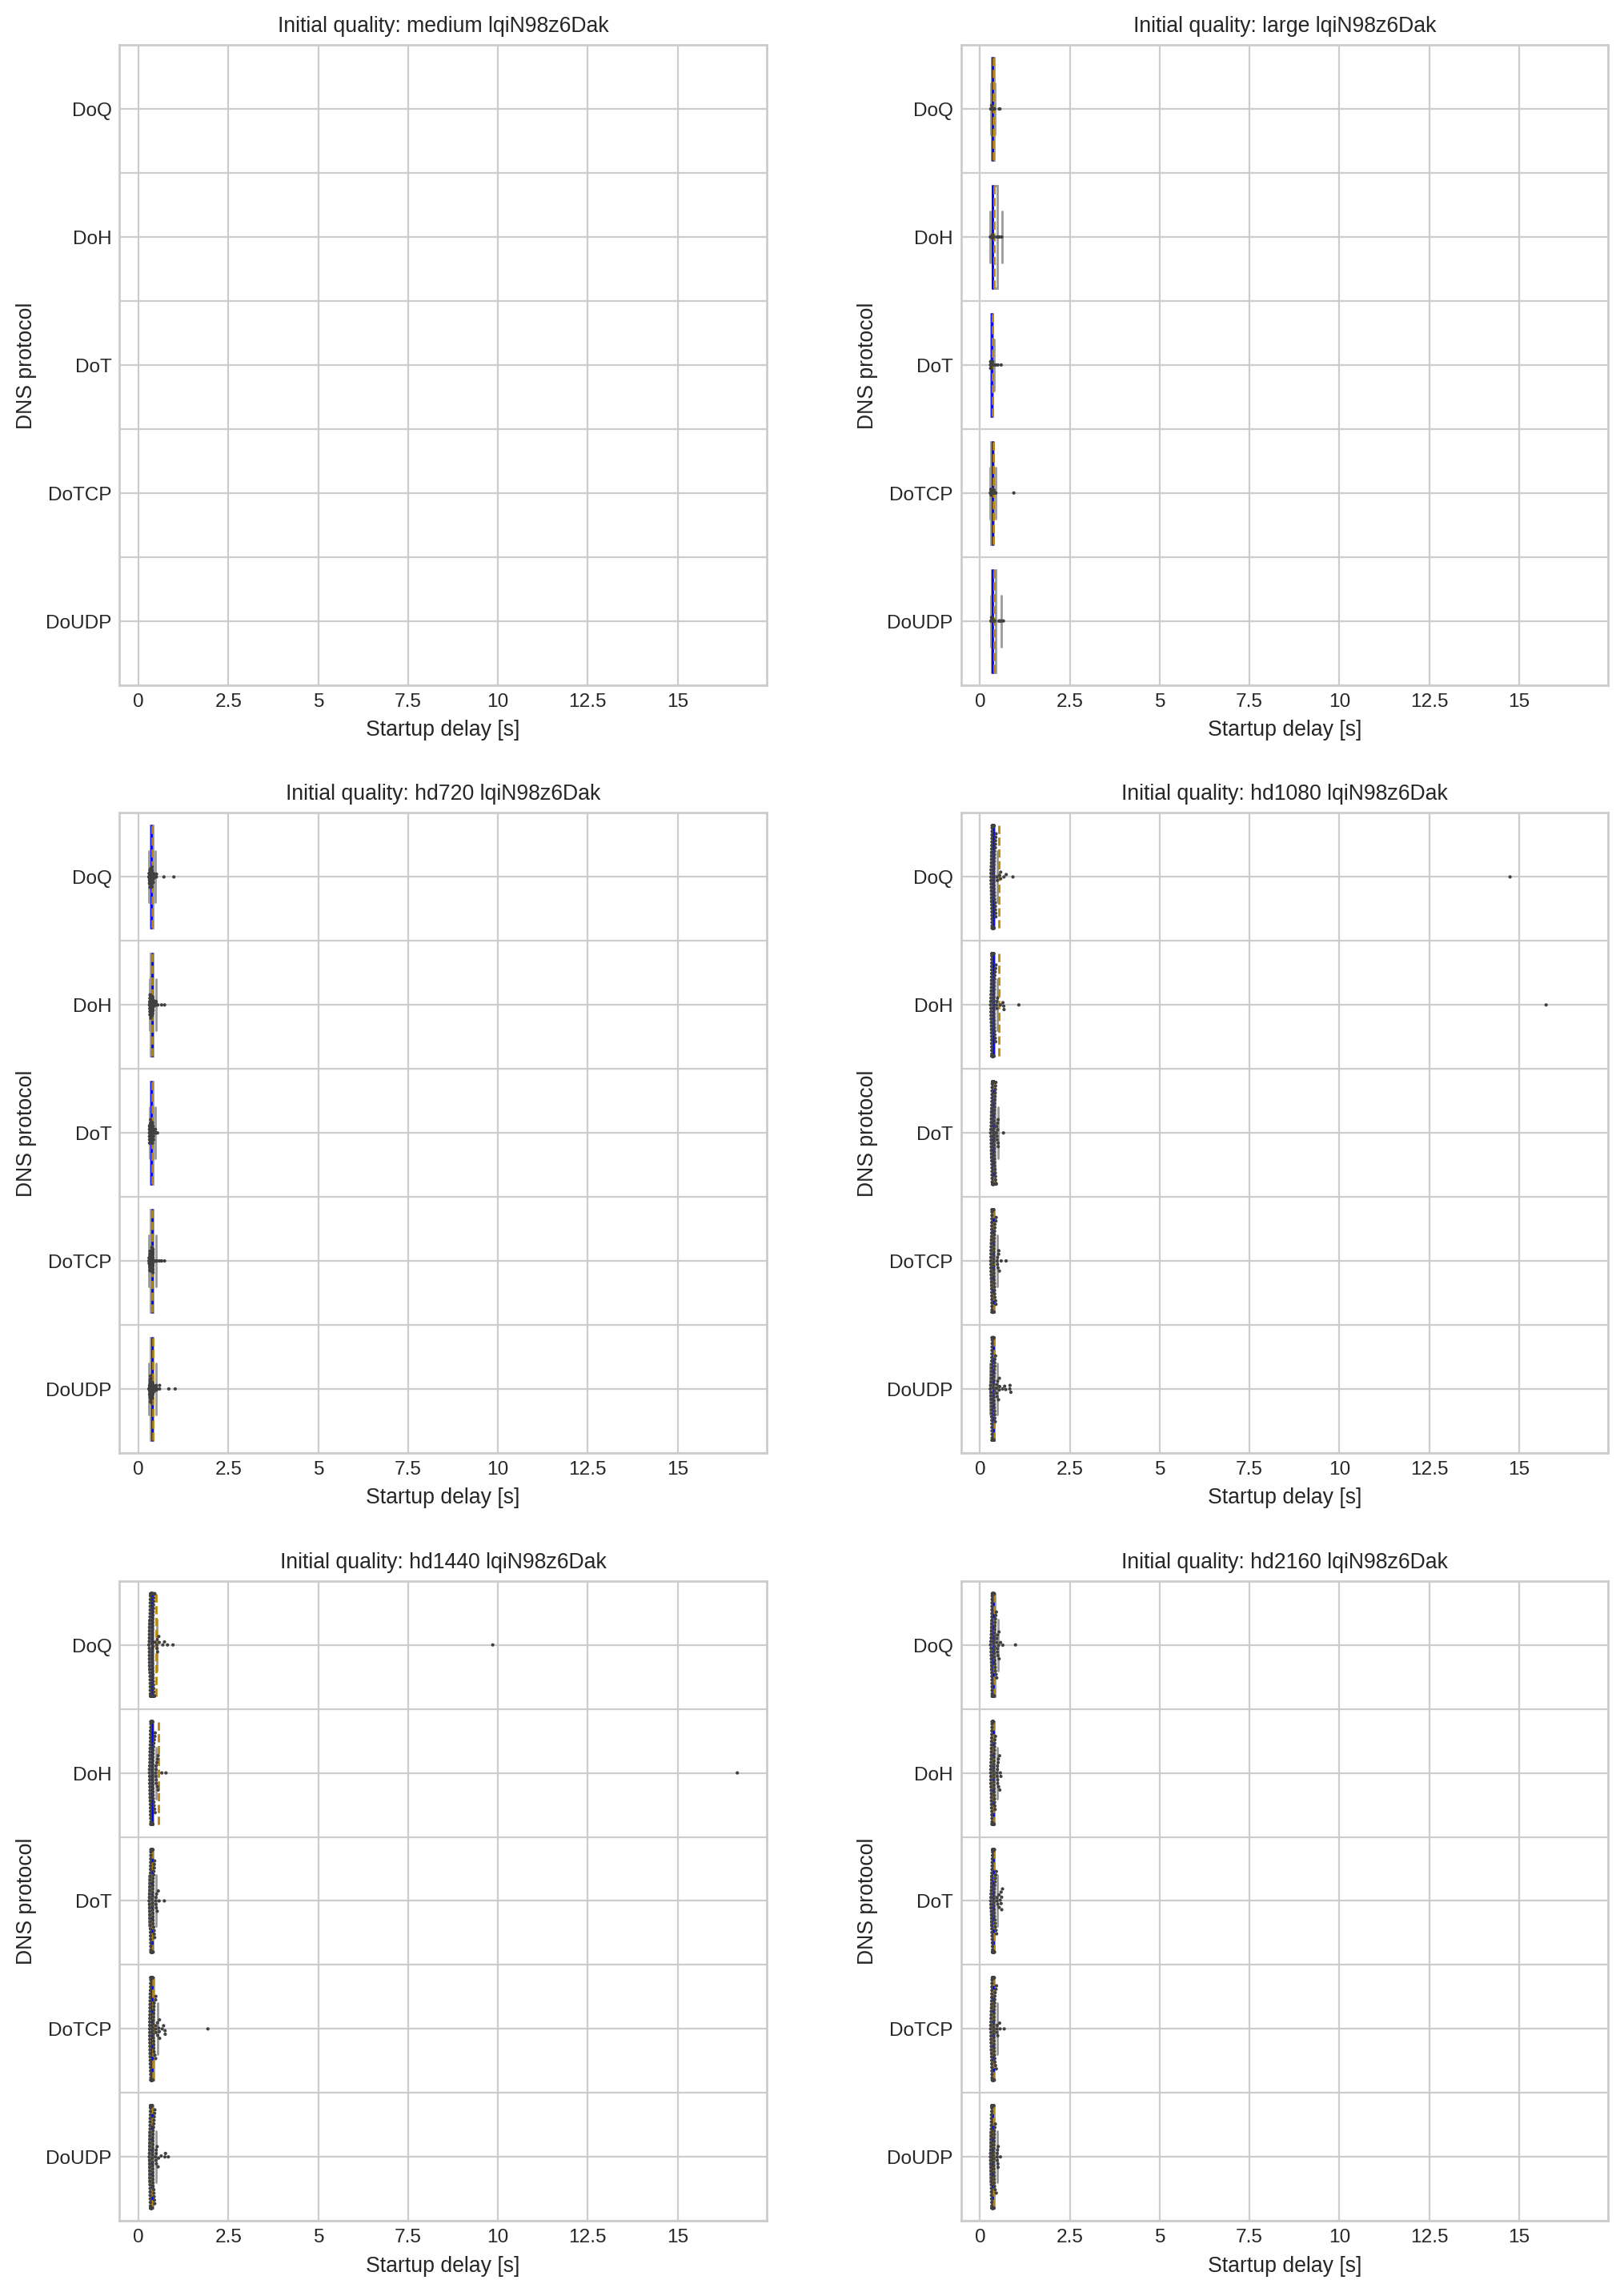

In [131]:
draw_boxplot_grid(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [True, False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")


In [ ]:
draw_boxplot(df_start_time, 'true_initial_quality', 'protocol', 'startup_delay', [False], 'Startup delay [s]', 'Initial quality:', 'startup-delay-by-initial-quality-and-proto', [0,0], "DNS protocol")


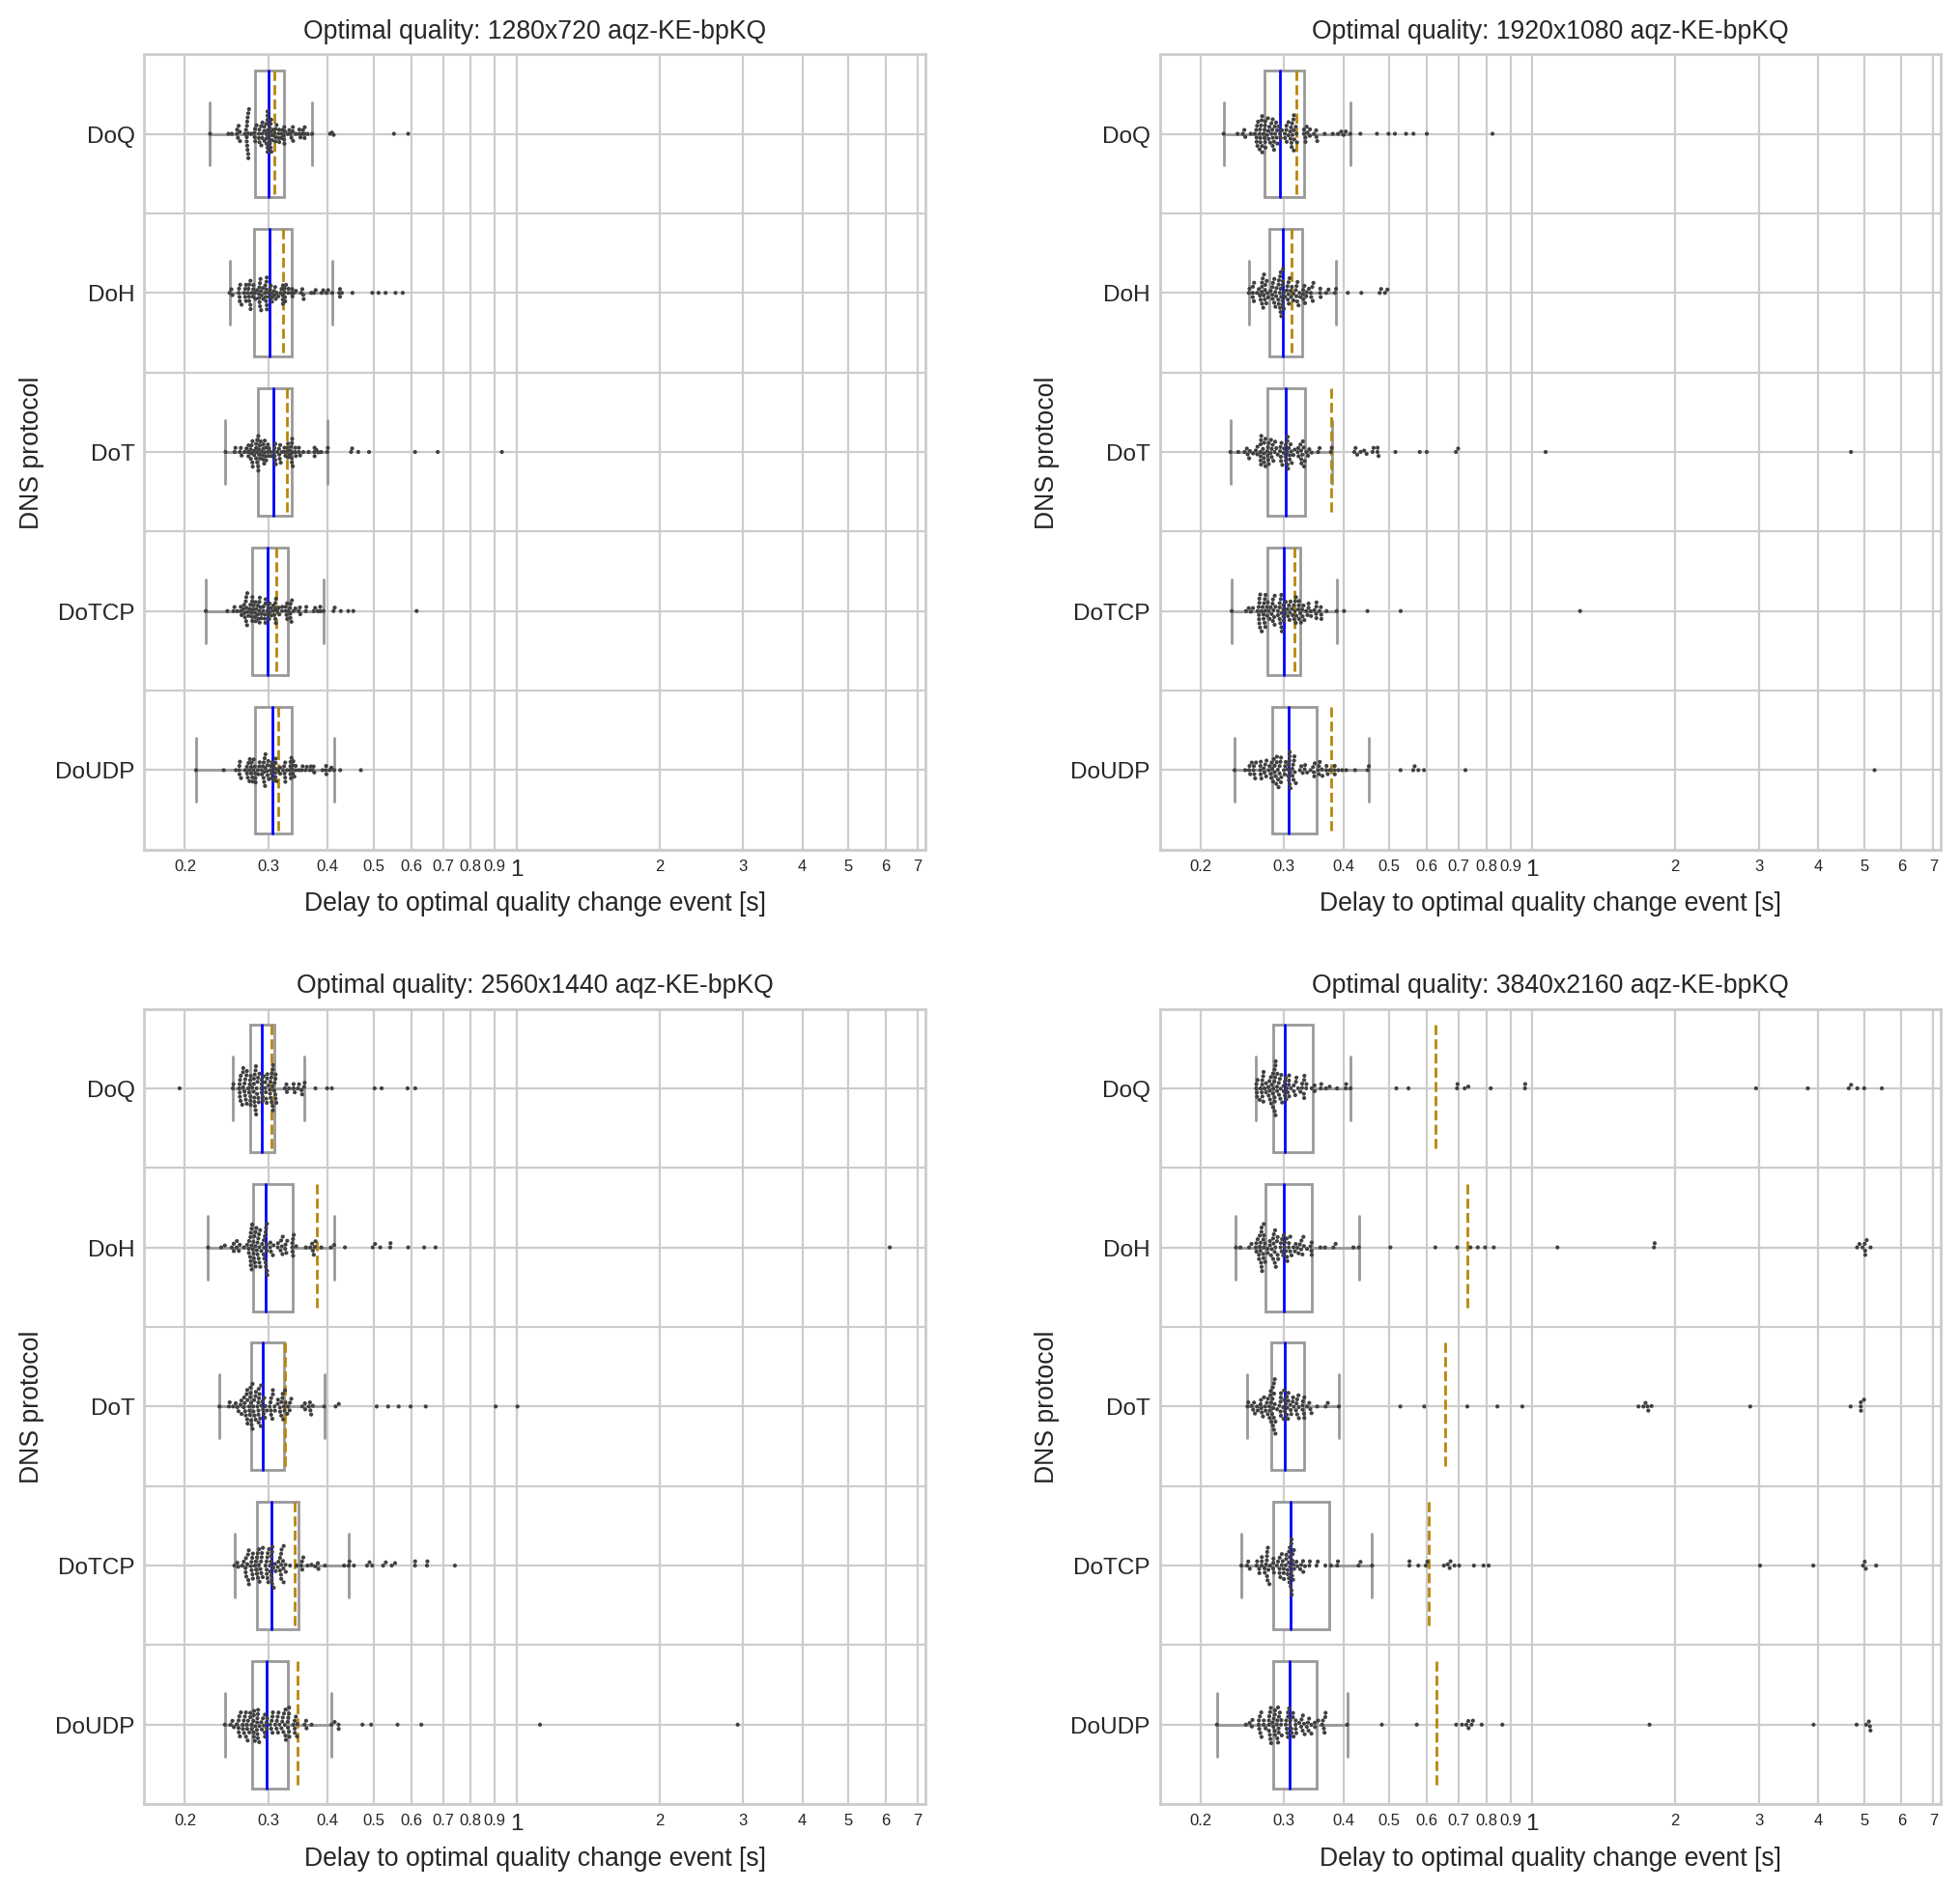

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 7.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 20.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 17.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/

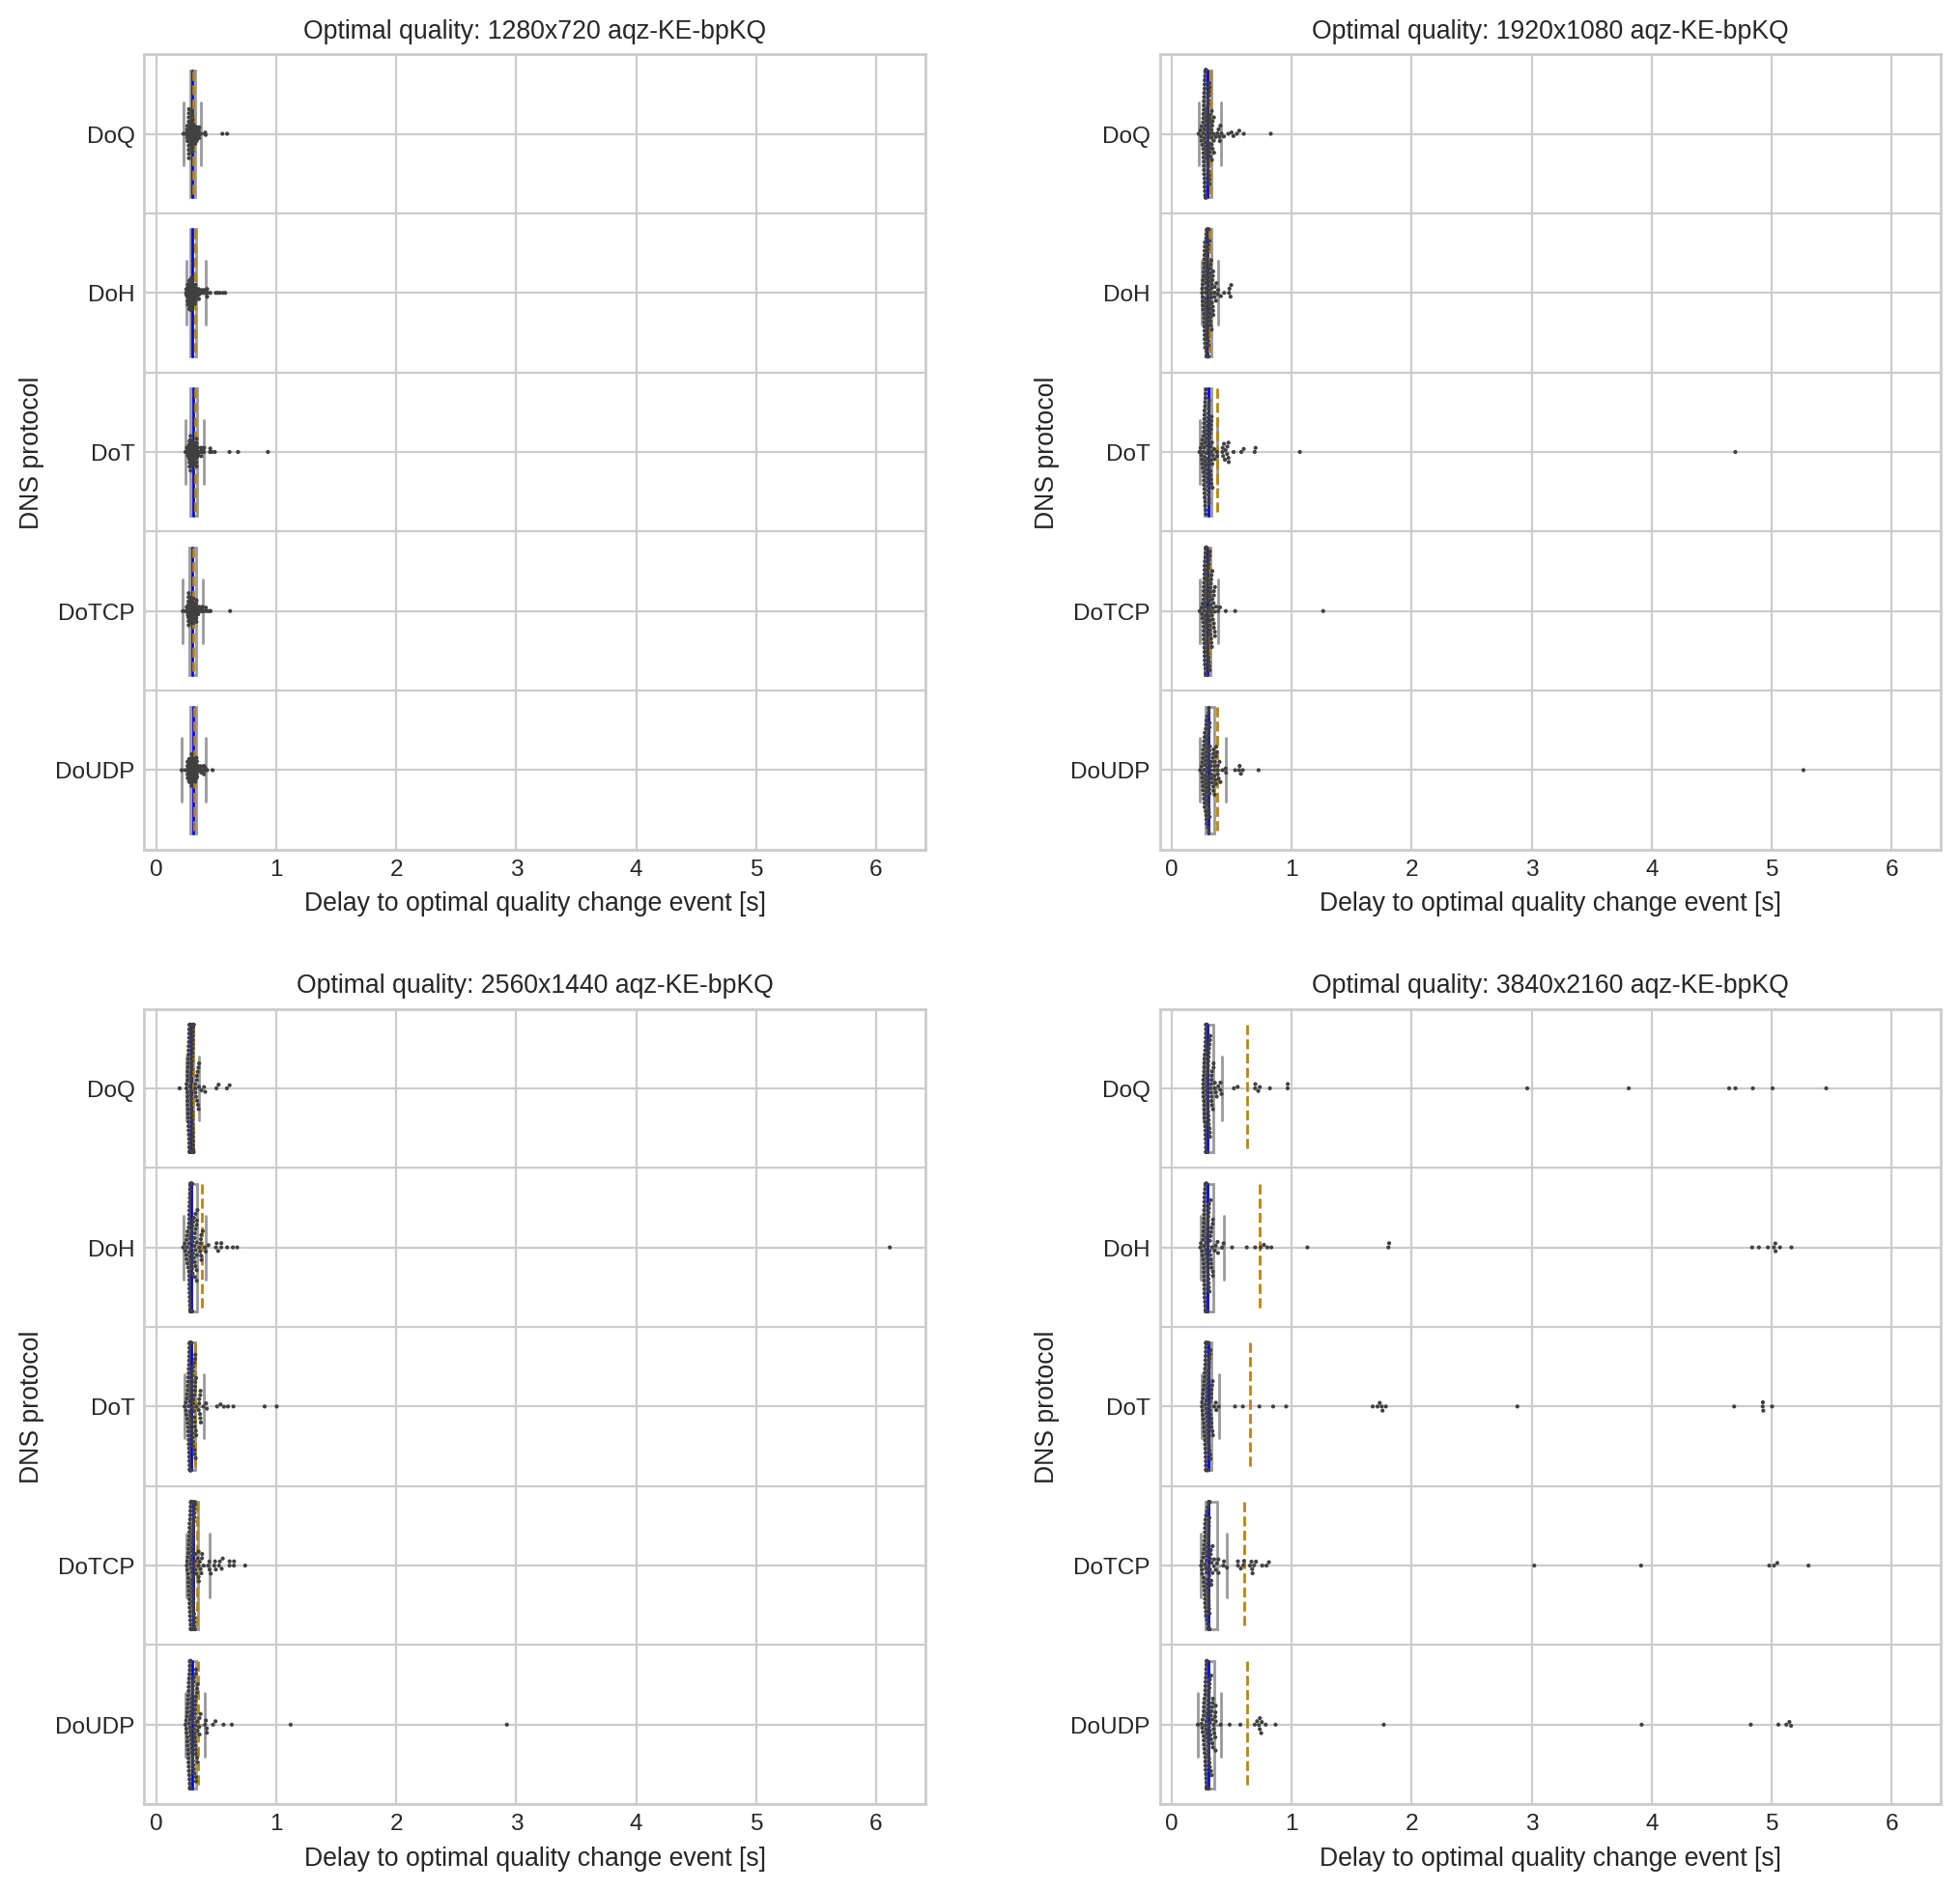

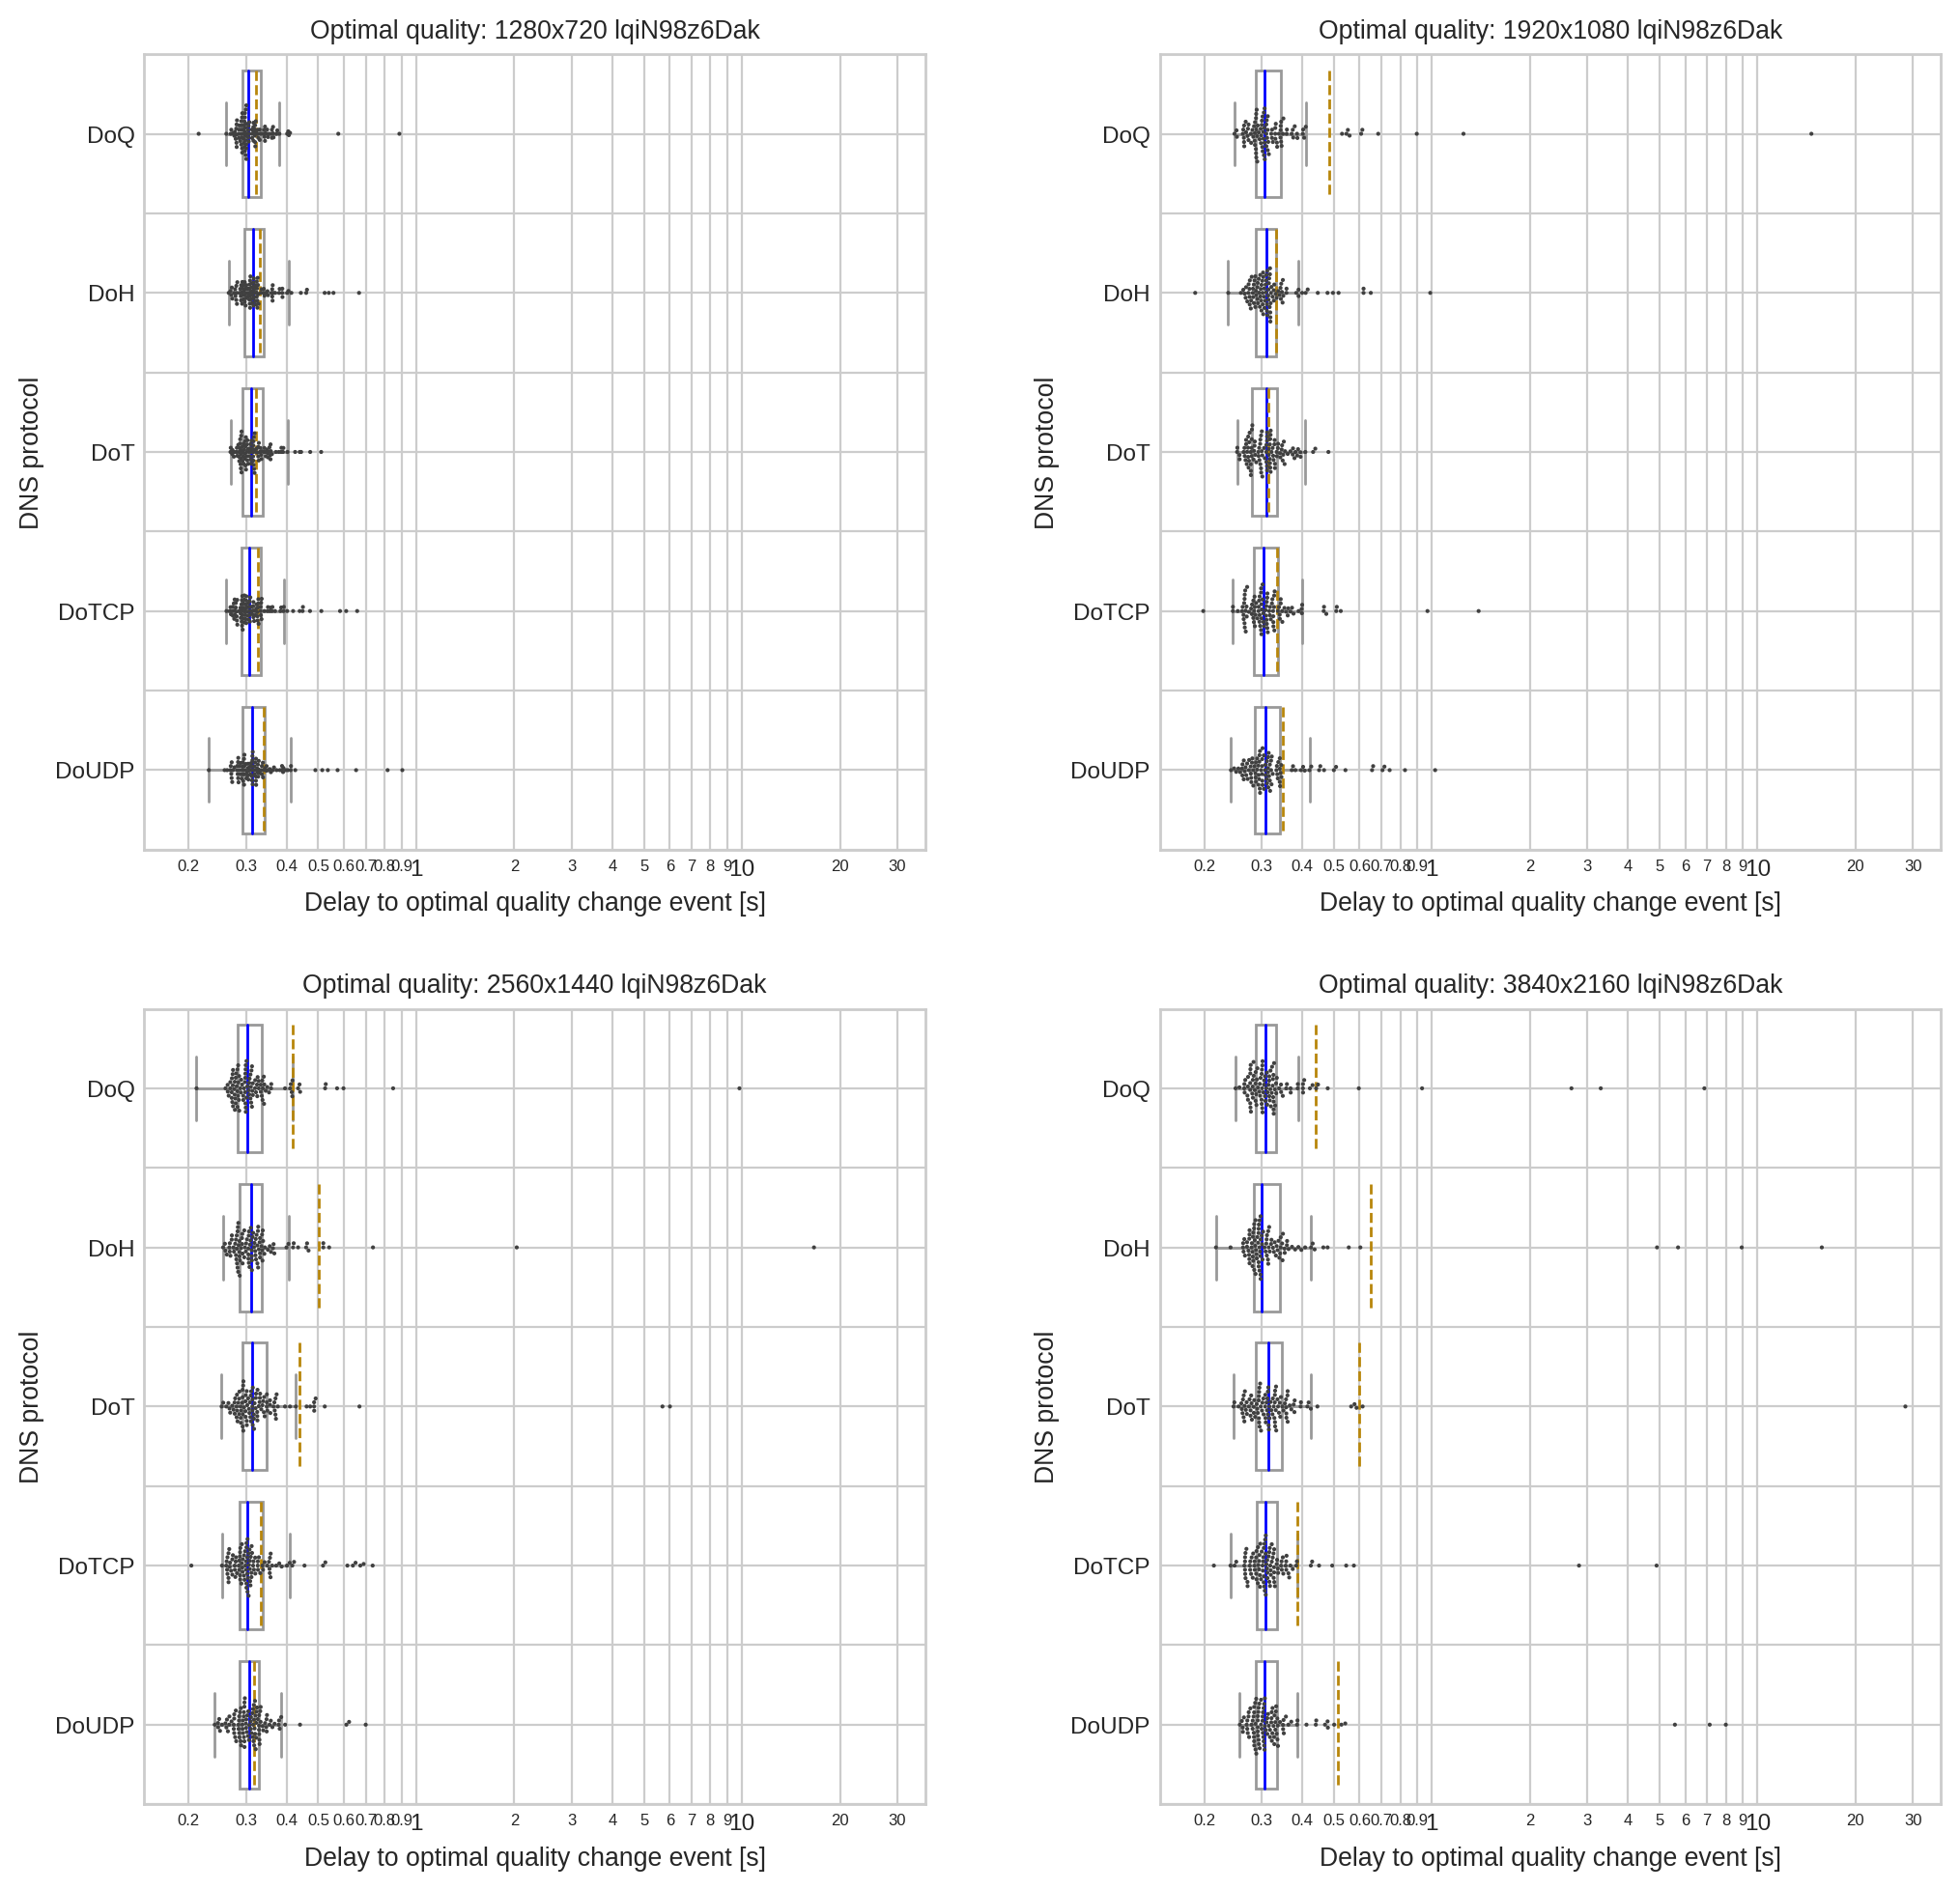

/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 43.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 40.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/quic_net01/.pyenv/versions/3.8.12/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 39.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/hom

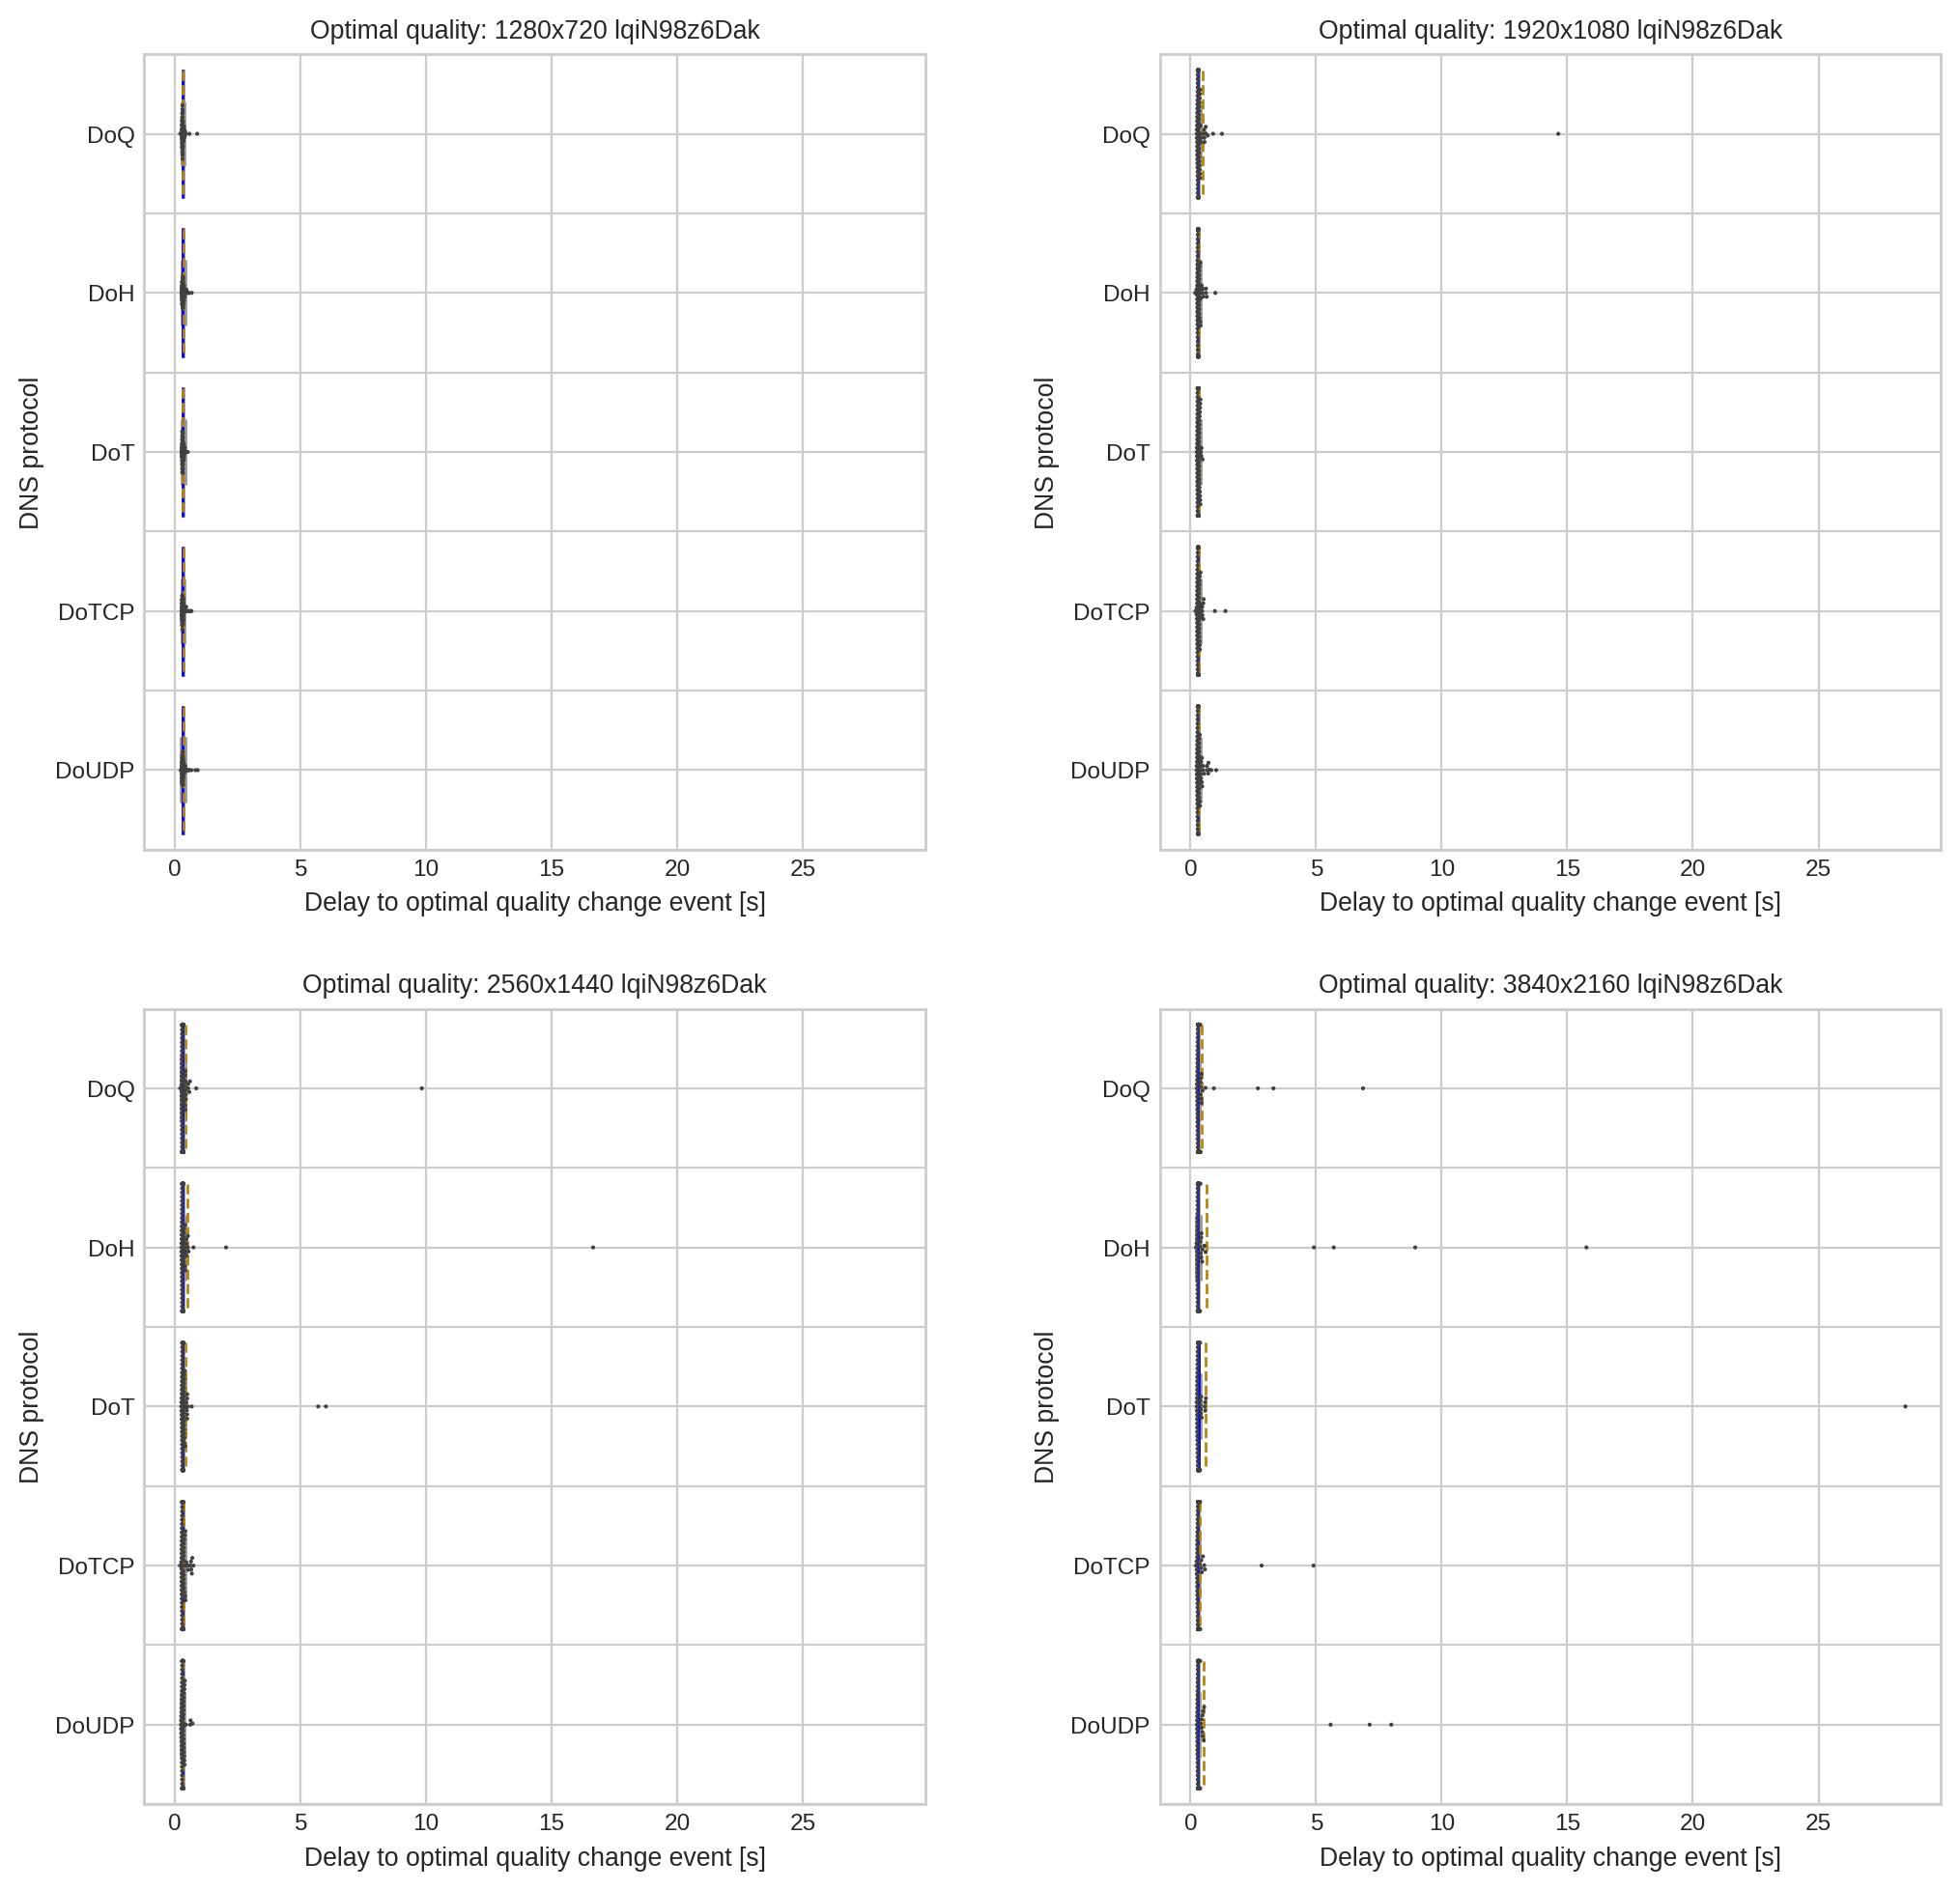

In [133]:
draw_boxplot_grid(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True, False], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], "DNS protocol")

In [ ]:
draw_boxplot(df_player_quality_change_event_to_opt, 'optimal_res', 'protocol', 'optimal_quality_delay', [True], 'Delay to optimal quality change event [s]', 'Optimal quality:', 'optimal-quality-delay-by-optimal-quality-and-proto', [0,0], "DNS protocol")

In [ ]:
conn.close()